**ImportLibs**

In [1]:
# data
import pandas as pd
import numpy as np
import gc
from typing import List
from tqdm import tqdm

# models
from lightgbm import LGBMClassifier, log_evaluation
from sklearn.model_selection import StratifiedGroupKFold
import seaborn as sns

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

**Utils**

In [2]:
def get_amex_metric_calculated(y_true: np.array, y_pred: np.array) -> float:
    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)


def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex', get_amex_metric_calculated(y_true, y_pred), True)

### Prepare data

In [3]:
def get_train_data(TRAIN_PATH: str) -> pd.DataFrame:
    '''Returns train dataset'''
    df_train = pd.read_parquet(TRAIN_PATH)
    return df_train


def get_test_data(TEST_PATH: str) -> pd.DataFrame:
    '''Returns test dataset'''
    df_test = pd.read_parquet(TEST_PATH)
    return df_test


def get_target(TARGET_PATH: str) -> pd.DataFrame:
    '''Retruns dataset with train targets'''
    df_train_target = pd.read_csv(TARGET_PATH)
    return df_train_target


def get_train_data_with_target_merged(df_train: pd.DataFrame, df_train_target: pd.DataFrame) -> pd.DataFrame:
    '''Retruns train dataset with target variable merged'''
    df_train_w_target = (
        df_train
        .merge(df_train_target,
            on='customer_ID',
            how='left'
        )
    )
    # df_train_w_target.groupby('target', dropna=False).count()['customer_ID']
    '''
    target
    0    4153582
    1    1377869
    Name: customer_ID, dtype: int64    
    '''
    return df_train_w_target


def get_all_features(df: pd.DataFrame) -> List:
    '''Returns list of all features from the dataset'''
    return list(df)


def get_cat_features() -> List:
    '''Returns list of categorical features from the dataset'''
    cat_features = ['B_30', 'B_38', 'D_114', 
                    'D_116', 'D_117', 'D_120', 
                    'D_126', 'D_63', 'D_64', 
                    'D_66', 'D_68']
    
    return cat_features


def get_num_features(all_features: List, cat_features: List) -> List:
    '''Returns list of all numerical features from the dataset'''
    num_feats = [col for col in all_features if col not in cat_features + ['customer_ID', 'S_2', 'target']]

    return num_feats


def get_df_w_aggrs(df: pd.DataFrame, feats: List) ->  pd.DataFrame:
    '''Returns dataframe with generated aggregates based on numerical features'''

    cid = pd.Categorical(df.pop('customer_ID'), ordered=True)
    last = (cid != np.roll(cid, -1)) # mask for last statement of every customer

    df_min = (df
        .groupby(cid)
        .min()[feats]
        .rename(columns={f: f"{f}_min" for f in feats})
    )
    print(df_min.shape)

    df_max = (df
        .groupby(cid)
        .max()[feats]
        .rename(columns={f: f"{f}_max" for f in feats})
    )
    print(df_max.shape)

    df_avg = (df
        .drop('S_2', axis='columns')
        .groupby(cid)
        .mean()[feats]
        .rename(columns={f: f"{f}_avg" for f in feats})
    )
    print(df_avg.shape)

    df_last = (df
        .loc[last, feats]
        .rename(columns={f: f"{f}_last" for f in feats})
        .set_index(np.asarray(cid[last]))
    )
    print(df_last.shape)

    df_aggrs = (pd.concat([df_min, df_max, df_avg, df_last], axis=1)
        .reset_index()
        .rename(columns={'index': 'customer_ID'})
    )
    print(df_aggrs.shape)

    '''
    del df, df_min, df_max, df_avg, cid, last
    gc.collect()
    '''
    return df_aggrs


def check_zapolnenie(df: pd.DataFrame) -> pd.DataFrame:
    '''Returns pd.DataFrame with isNotNullShare of each column of given df'''
    # Calculate percent of not null share each column 
    col_pct_notNull = [] 
    for col in df.columns: 
        percent_notNull = np.mean(~df[col].isnull())*100 
        col_pct_notNull.append([col, percent_notNull]) 
        
    col_pct_notNull_df = pd.DataFrame(col_pct_notNull, columns = ['column_name','isNotNullShare']).sort_values(by = 'isNotNullShare', ascending = False) 
    #print(col_pct_notNull_df)
    return col_pct_notNull_df

**train_df , test_df**

In [4]:
df_train = get_train_data(TRAIN_PATH='./data/train.parquet')

all_features = get_all_features(df_train)
cat_features = get_cat_features()
num_features = get_num_features(all_features, cat_features)
# len(all_features), len(cat_features), len(num_features) -> (190, 11, 177)

df_train_agg = get_df_w_aggrs(df=df_train, feats=num_features)
df_train_target = get_target(TARGET_PATH='./data/train_labels.csv')
df_train = get_train_data_with_target_merged(df_train=df_train_agg, df_train_target=df_train_target)

'''
df_train.target.value_counts()
target
0    340085
1    118828
Name: count, dtype: int64
'''

# df_test = get_test_data(TEST_PATH='./data/test.parquet')
# df_test = get_df_w_aggrs(df=df_test, feats=num_features)

# zapolnenie_train = check_zapolnenie(df_train)
# zapolnenie_test = check_zapolnenie(df_test)

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2046887445.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cid)


(458913, 177)


C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2046887445.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cid)


(458913, 177)


C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2046887445.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cid)


(458913, 177)
(458913, 177)
(458913, 709)


'\ndf_train.target.value_counts()\ntarget\n0    340085\n1    118828\nName: count, dtype: int64\n'

**выделение групп признаков (из исходных признаков)**

In [ ]:
payment_feats = []
delinq_feats = []
spend_feats = []
balance_feats = []
risk_feats = []

for feat in num_features:
    if feat[0] == 'P':
        #print(feat)
        payment_feats.append(feat)
    elif feat[0] == 'D':
        delinq_feats.append(feat)
    elif feat[0] == 'S':
        spend_feats.append(feat)
    elif feat[0] == 'B':
        balance_feats.append(feat)
    elif feat[0] == 'R':
        risk_feats.append(feat)

In [ ]:
len(payment_feats) + len(delinq_feats) + len(spend_feats) + len(balance_feats) + len(risk_feats)

In [ ]:
len(payment_feats), len(delinq_feats), len(spend_feats), len(balance_feats), len(risk_feats)

### Однофакторный анализ

#### Однофакторный gini

In [5]:
# выделение групп признаков (из всех признаков, вариант после аггрегирования)

payment_feats = []
delinq_feats = []
spend_feats = []
balance_feats = []
risk_feats = []

for feat in list(df_train):
    if feat[0] == 'P':
        #print(feat)
        payment_feats.append(feat)
    elif feat[0] == 'D':
        delinq_feats.append(feat)
    elif feat[0] == 'S':
        spend_feats.append(feat)
    elif feat[0] == 'B':
        balance_feats.append(feat)
    elif feat[0] == 'R':
        risk_feats.append(feat)

In [6]:
len(payment_feats) + len(delinq_feats) + len(spend_feats) + len(balance_feats) + len(risk_feats)

708

In [8]:
sgkf_gr = StratifiedGroupKFold(n_splits=5)

In [9]:
odnofactorniy_gini = []

for feat in tqdm((payment_feats + delinq_feats + spend_feats + balance_feats + risk_feats)):
    print("="*50)
    print(feat)
    print("="*50)
    
    score_list = []

    for fold, (idx_tr, idx_va) in enumerate(sgkf_gr.split(X=df_train[['customer_ID', 'target']], y=df_train['target'], groups=df_train['customer_ID'])):
        print(fold)
        X_tr, X_va, y_tr, y_va, clf = None, None, None, None, None


        X_tr = df_train.iloc[idx_tr][[feat]] # 'P_2_min' -> feat
        X_va = df_train.iloc[idx_va][[feat]] # 'P_2_min' -> feat
        y_tr = df_train.target.values[idx_tr]
        y_va = df_train.target.values[idx_va]


        clf = LGBMClassifier(n_estimators=200,
                     max_depth=2,
                     learning_rate=0.05,
                     colsample_bytree=0.8,
                     subsample=0.95,
                     subsample_freq=1,
                     verbosity=-1,
                     random_state=42)

        # abc
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=UserWarning)

            clf.fit(X_tr, 
                    y_tr,
                    eval_set = [(X_va, y_va)],
                    eval_metric=[lgb_amex_metric],
                    callbacks=[log_evaluation(100)]
                   )
        # abc
        X_tr, y_tr = None, None
        y_va_pred = clf.predict_proba(X_va, raw_score=True)

        '''
        try:
            print(len(y_va), len(y_va_pred))
            print(type(y_va), type(y_va_pred))
            print(y_va)
            print()
            print(y_va_pred)

        except:
            print(y_va.shape, y_va_pred.shape)
        '''

        score = get_amex_metric_calculated(y_va, y_va_pred)
        print(f"Score = {score:.5f}")

        score_list.append(score)
        
    odnofactorniy_gini.append(np.mean(score_list))

  0%|                                                                                          | 0/708 [00:00<?, ?it/s]

P_2_min
0
[100]	valid_0's binary_logloss: 0.337375	valid_0's amex: 0.59905
[200]	valid_0's binary_logloss: 0.337074	valid_0's amex: 0.599415
Score = 0.59915
1
[100]	valid_0's binary_logloss: 0.336377	valid_0's amex: 0.599288
[200]	valid_0's binary_logloss: 0.335946	valid_0's amex: 0.599219
Score = 0.59896
2
[100]	valid_0's binary_logloss: 0.338069	valid_0's amex: 0.594974
[200]	valid_0's binary_logloss: 0.337847	valid_0's amex: 0.594606
Score = 0.59437
3
[100]	valid_0's binary_logloss: 0.336796	valid_0's amex: 0.601091
[200]	valid_0's binary_logloss: 0.336457	valid_0's amex: 0.600334
Score = 0.60010
4
[100]	valid_0's binary_logloss: 0.339635	valid_0's amex: 0.597166


  0%|                                                                               | 1/708 [01:10<13:55:49, 70.93s/it]

[200]	valid_0's binary_logloss: 0.339386	valid_0's amex: 0.597362
Score = 0.59710
P_3_min
0
[100]	valid_0's binary_logloss: 0.497178	valid_0's amex: 0.33916
[200]	valid_0's binary_logloss: 0.497014	valid_0's amex: 0.338426
Score = 0.33816
1
[100]	valid_0's binary_logloss: 0.494973	valid_0's amex: 0.346625
[200]	valid_0's binary_logloss: 0.494851	valid_0's amex: 0.346297
Score = 0.34603
2
[100]	valid_0's binary_logloss: 0.497608	valid_0's amex: 0.337203
[200]	valid_0's binary_logloss: 0.497506	valid_0's amex: 0.336747
Score = 0.33650
3
[100]	valid_0's binary_logloss: 0.495076	valid_0's amex: 0.34548
[200]	valid_0's binary_logloss: 0.494925	valid_0's amex: 0.345678
Score = 0.34543
4
[100]	valid_0's binary_logloss: 0.496776	valid_0's amex: 0.342379


  0%|▏                                                                              | 2/708 [02:20<13:44:18, 70.05s/it]

[200]	valid_0's binary_logloss: 0.496568	valid_0's amex: 0.342597
Score = 0.34233
P_4_min
0
[100]	valid_0's binary_logloss: 0.556425	valid_0's amex: 0.127862
[200]	valid_0's binary_logloss: 0.556426	valid_0's amex: 0.127845
Score = 0.12760
1
[100]	valid_0's binary_logloss: 0.556207	valid_0's amex: 0.128096
[200]	valid_0's binary_logloss: 0.556206	valid_0's amex: 0.12833
Score = 0.12808
2
[100]	valid_0's binary_logloss: 0.556229	valid_0's amex: 0.129473
[200]	valid_0's binary_logloss: 0.556228	valid_0's amex: 0.129607
Score = 0.12937
3
[100]	valid_0's binary_logloss: 0.556438	valid_0's amex: 0.127483
[200]	valid_0's binary_logloss: 0.556452	valid_0's amex: 0.12841
Score = 0.12817
4
[100]	valid_0's binary_logloss: 0.556008	valid_0's amex: 0.128808


  0%|▎                                                                              | 3/708 [03:30<13:42:29, 70.00s/it]

[200]	valid_0's binary_logloss: 0.556037	valid_0's amex: 0.128806
Score = 0.12856
P_2_max
0
[100]	valid_0's binary_logloss: 0.369204	valid_0's amex: 0.526438
[200]	valid_0's binary_logloss: 0.368988	valid_0's amex: 0.526268
Score = 0.52604
1
[100]	valid_0's binary_logloss: 0.370909	valid_0's amex: 0.520884
[200]	valid_0's binary_logloss: 0.370705	valid_0's amex: 0.520639
Score = 0.52037
2
[100]	valid_0's binary_logloss: 0.370192	valid_0's amex: 0.525215
[200]	valid_0's binary_logloss: 0.369977	valid_0's amex: 0.525232
Score = 0.52499
3
[100]	valid_0's binary_logloss: 0.369908	valid_0's amex: 0.52279
[200]	valid_0's binary_logloss: 0.3697	valid_0's amex: 0.523208
Score = 0.52297
4
[100]	valid_0's binary_logloss: 0.371257	valid_0's amex: 0.523155


  1%|▍                                                                              | 4/708 [04:39<13:37:12, 69.65s/it]

[200]	valid_0's binary_logloss: 0.370991	valid_0's amex: 0.523478
Score = 0.52321
P_3_max
0
[100]	valid_0's binary_logloss: 0.536728	valid_0's amex: 0.22373
[200]	valid_0's binary_logloss: 0.536535	valid_0's amex: 0.224684
Score = 0.22447
1
[100]	valid_0's binary_logloss: 0.536664	valid_0's amex: 0.224203
[200]	valid_0's binary_logloss: 0.53642	valid_0's amex: 0.225282
Score = 0.22503
2
[100]	valid_0's binary_logloss: 0.537454	valid_0's amex: 0.222319
[200]	valid_0's binary_logloss: 0.537302	valid_0's amex: 0.222853
Score = 0.22261
3
[100]	valid_0's binary_logloss: 0.537556	valid_0's amex: 0.221919
[200]	valid_0's binary_logloss: 0.537316	valid_0's amex: 0.223563
Score = 0.22332
4
[100]	valid_0's binary_logloss: 0.535431	valid_0's amex: 0.228212


  1%|▌                                                                              | 5/708 [05:50<13:40:42, 70.05s/it]

[200]	valid_0's binary_logloss: 0.53521	valid_0's amex: 0.228284
Score = 0.22803
P_4_max
0
[100]	valid_0's binary_logloss: 0.524888	valid_0's amex: 0.240205
[200]	valid_0's binary_logloss: 0.524599	valid_0's amex: 0.240411
Score = 0.24016
1
[100]	valid_0's binary_logloss: 0.523047	valid_0's amex: 0.246543
[200]	valid_0's binary_logloss: 0.52272	valid_0's amex: 0.244987
Score = 0.24474
2
[100]	valid_0's binary_logloss: 0.524733	valid_0's amex: 0.241397
[200]	valid_0's binary_logloss: 0.524522	valid_0's amex: 0.241786
Score = 0.24155
3
[100]	valid_0's binary_logloss: 0.524373	valid_0's amex: 0.241469
[200]	valid_0's binary_logloss: 0.524072	valid_0's amex: 0.24213
Score = 0.24190
4
[100]	valid_0's binary_logloss: 0.525655	valid_0's amex: 0.236256


  1%|▋                                                                              | 6/708 [07:20<15:01:26, 77.05s/it]

[200]	valid_0's binary_logloss: 0.525473	valid_0's amex: 0.236402
Score = 0.23615
P_2_avg
0
[100]	valid_0's binary_logloss: 0.342155	valid_0's amex: 0.576927
[200]	valid_0's binary_logloss: 0.341867	valid_0's amex: 0.577017
Score = 0.57676
1
[100]	valid_0's binary_logloss: 0.342622	valid_0's amex: 0.57339
[200]	valid_0's binary_logloss: 0.342343	valid_0's amex: 0.573658
Score = 0.57340
2
[100]	valid_0's binary_logloss: 0.343054	valid_0's amex: 0.574566
[200]	valid_0's binary_logloss: 0.342855	valid_0's amex: 0.574558
Score = 0.57432
3
[100]	valid_0's binary_logloss: 0.34226	valid_0's amex: 0.574567
[200]	valid_0's binary_logloss: 0.341966	valid_0's amex: 0.573767
Score = 0.57357
4
[100]	valid_0's binary_logloss: 0.344218	valid_0's amex: 0.575819


  1%|▊                                                                             | 7/708 [09:57<20:03:37, 103.02s/it]

[200]	valid_0's binary_logloss: 0.343908	valid_0's amex: 0.575827
Score = 0.57557
P_3_avg
0
[100]	valid_0's binary_logloss: 0.486972	valid_0's amex: 0.369838
[200]	valid_0's binary_logloss: 0.486887	valid_0's amex: 0.369731
Score = 0.36948
1
[100]	valid_0's binary_logloss: 0.484832	valid_0's amex: 0.372952
[200]	valid_0's binary_logloss: 0.484739	valid_0's amex: 0.372755
Score = 0.37250
2
[100]	valid_0's binary_logloss: 0.487957	valid_0's amex: 0.36704
[200]	valid_0's binary_logloss: 0.487932	valid_0's amex: 0.367298
Score = 0.36706
3
[100]	valid_0's binary_logloss: 0.486997	valid_0's amex: 0.370506
[200]	valid_0's binary_logloss: 0.486908	valid_0's amex: 0.370897
Score = 0.37066
4
[100]	valid_0's binary_logloss: 0.486821	valid_0's amex: 0.369789


  1%|▉                                                                             | 8/708 [12:31<23:13:13, 119.42s/it]

[200]	valid_0's binary_logloss: 0.486834	valid_0's amex: 0.369345
Score = 0.36909
P_4_avg
0
[100]	valid_0's binary_logloss: 0.530439	valid_0's amex: 0.216878
[200]	valid_0's binary_logloss: 0.529402	valid_0's amex: 0.226566
Score = 0.22632
1
[100]	valid_0's binary_logloss: 0.528375	valid_0's amex: 0.224407
[200]	valid_0's binary_logloss: 0.527189	valid_0's amex: 0.232202
Score = 0.23195
2
[100]	valid_0's binary_logloss: 0.529731	valid_0's amex: 0.221438
[200]	valid_0's binary_logloss: 0.528517	valid_0's amex: 0.22783
Score = 0.22760
3
[100]	valid_0's binary_logloss: 0.529902	valid_0's amex: 0.214585
[200]	valid_0's binary_logloss: 0.528784	valid_0's amex: 0.223449
Score = 0.22322
4
[100]	valid_0's binary_logloss: 0.531188	valid_0's amex: 0.212451


  1%|▉                                                                             | 9/708 [15:22<26:16:43, 135.34s/it]

[200]	valid_0's binary_logloss: 0.530112	valid_0's amex: 0.221439
Score = 0.22119
P_2_last
0
[100]	valid_0's binary_logloss: 0.314088	valid_0's amex: 0.64106
[200]	valid_0's binary_logloss: 0.313765	valid_0's amex: 0.641283
Score = 0.64103
1
[100]	valid_0's binary_logloss: 0.313891	valid_0's amex: 0.636256
[200]	valid_0's binary_logloss: 0.313388	valid_0's amex: 0.636278
Score = 0.63602
2
[100]	valid_0's binary_logloss: 0.316155	valid_0's amex: 0.637515
[200]	valid_0's binary_logloss: 0.315909	valid_0's amex: 0.636868
Score = 0.63668
3
[100]	valid_0's binary_logloss: 0.314885	valid_0's amex: 0.637915
[200]	valid_0's binary_logloss: 0.314513	valid_0's amex: 0.637609
Score = 0.63738
4
[100]	valid_0's binary_logloss: 0.316586	valid_0's amex: 0.637807


  1%|█                                                                            | 10/708 [17:53<27:10:18, 140.14s/it]

[200]	valid_0's binary_logloss: 0.316261	valid_0's amex: 0.636945
Score = 0.63669
P_3_last
0
[100]	valid_0's binary_logloss: 0.499325	valid_0's amex: 0.345345
[200]	valid_0's binary_logloss: 0.499264	valid_0's amex: 0.345892
Score = 0.34563
1
[100]	valid_0's binary_logloss: 0.498816	valid_0's amex: 0.346101
[200]	valid_0's binary_logloss: 0.498737	valid_0's amex: 0.346259
Score = 0.34600
2
[100]	valid_0's binary_logloss: 0.501596	valid_0's amex: 0.338245
[200]	valid_0's binary_logloss: 0.501611	valid_0's amex: 0.338594
Score = 0.33835
3
[100]	valid_0's binary_logloss: 0.4981	valid_0's amex: 0.34767
[200]	valid_0's binary_logloss: 0.498013	valid_0's amex: 0.347739
Score = 0.34750
4
[100]	valid_0's binary_logloss: 0.499692	valid_0's amex: 0.342498


  2%|█▏                                                                           | 11/708 [20:06<26:43:36, 138.04s/it]

[200]	valid_0's binary_logloss: 0.499652	valid_0's amex: 0.342694
Score = 0.34244
P_4_last
0
[100]	valid_0's binary_logloss: 0.554687	valid_0's amex: 0.130218
[200]	valid_0's binary_logloss: 0.554622	valid_0's amex: 0.1308
Score = 0.13055
1
[100]	valid_0's binary_logloss: 0.554468	valid_0's amex: 0.12798
[200]	valid_0's binary_logloss: 0.554397	valid_0's amex: 0.129348
Score = 0.12912
2
[100]	valid_0's binary_logloss: 0.554685	valid_0's amex: 0.128005
[200]	valid_0's binary_logloss: 0.554577	valid_0's amex: 0.129879
Score = 0.12964
3
[100]	valid_0's binary_logloss: 0.555177	valid_0's amex: 0.126743
[200]	valid_0's binary_logloss: 0.555181	valid_0's amex: 0.125647
Score = 0.12541
4
[100]	valid_0's binary_logloss: 0.554171	valid_0's amex: 0.131756


  2%|█▎                                                                           | 12/708 [22:39<27:35:18, 142.70s/it]

[200]	valid_0's binary_logloss: 0.554097	valid_0's amex: 0.132618
Score = 0.13237
D_39_min
0
[100]	valid_0's binary_logloss: 0.568883	valid_0's amex: 0.048446
[200]	valid_0's binary_logloss: 0.568846	valid_0's amex: 0.0484491
Score = 0.04820
1
[100]	valid_0's binary_logloss: 0.569402	valid_0's amex: 0.04239
[200]	valid_0's binary_logloss: 0.56938	valid_0's amex: 0.0424036
Score = 0.04215
2
[100]	valid_0's binary_logloss: 0.568598	valid_0's amex: 0.0478566
[200]	valid_0's binary_logloss: 0.568531	valid_0's amex: 0.0478587
Score = 0.04762
3
[100]	valid_0's binary_logloss: 0.569099	valid_0's amex: 0.0462306
[200]	valid_0's binary_logloss: 0.569107	valid_0's amex: 0.0462281
Score = 0.04599
4
[100]	valid_0's binary_logloss: 0.56874	valid_0's amex: 0.0497068


  2%|█▍                                                                           | 13/708 [24:54<27:06:22, 140.41s/it]

[200]	valid_0's binary_logloss: 0.56871	valid_0's amex: 0.0497127
Score = 0.04946
D_41_min
0
[100]	valid_0's binary_logloss: 0.561615	valid_0's amex: 0.0822647
[200]	valid_0's binary_logloss: 0.561627	valid_0's amex: 0.0822645
Score = 0.08202
1
[100]	valid_0's binary_logloss: 0.562244	valid_0's amex: 0.0800333
[200]	valid_0's binary_logloss: 0.56226	valid_0's amex: 0.0800347
Score = 0.07979
2
[100]	valid_0's binary_logloss: 0.561589	valid_0's amex: 0.0830426
[200]	valid_0's binary_logloss: 0.561606	valid_0's amex: 0.08304
Score = 0.08280
3
[100]	valid_0's binary_logloss: 0.561304	valid_0's amex: 0.083272
[200]	valid_0's binary_logloss: 0.56131	valid_0's amex: 0.0832711
Score = 0.08303
4
[100]	valid_0's binary_logloss: 0.561581	valid_0's amex: 0.0815878


  2%|█▌                                                                           | 14/708 [26:51<25:39:41, 133.11s/it]

[200]	valid_0's binary_logloss: 0.561605	valid_0's amex: 0.0815848
Score = 0.08134
D_42_min
0
[100]	valid_0's binary_logloss: 0.494814	valid_0's amex: 0.324378
[200]	valid_0's binary_logloss: 0.494791	valid_0's amex: 0.324342
Score = 0.32410
1
[100]	valid_0's binary_logloss: 0.49168	valid_0's amex: 0.330856
[200]	valid_0's binary_logloss: 0.491608	valid_0's amex: 0.33091
Score = 0.33067
2
[100]	valid_0's binary_logloss: 0.493492	valid_0's amex: 0.329191
[200]	valid_0's binary_logloss: 0.493433	valid_0's amex: 0.329475
Score = 0.32925
3
[100]	valid_0's binary_logloss: 0.494219	valid_0's amex: 0.327616
[200]	valid_0's binary_logloss: 0.494177	valid_0's amex: 0.327313
Score = 0.32709
4
[100]	valid_0's binary_logloss: 0.494888	valid_0's amex: 0.325747


  2%|█▋                                                                           | 15/708 [28:01<21:59:50, 114.27s/it]

[200]	valid_0's binary_logloss: 0.494874	valid_0's amex: 0.325679
Score = 0.32544
D_43_min
0
[100]	valid_0's binary_logloss: 0.520955	valid_0's amex: 0.280276
[200]	valid_0's binary_logloss: 0.52072	valid_0's amex: 0.281765
Score = 0.28151
1
[100]	valid_0's binary_logloss: 0.523487	valid_0's amex: 0.273829
[200]	valid_0's binary_logloss: 0.523378	valid_0's amex: 0.274492
Score = 0.27423
2
[100]	valid_0's binary_logloss: 0.523074	valid_0's amex: 0.274721
[200]	valid_0's binary_logloss: 0.522892	valid_0's amex: 0.275746
Score = 0.27550
3
[100]	valid_0's binary_logloss: 0.524611	valid_0's amex: 0.267661
[200]	valid_0's binary_logloss: 0.52436	valid_0's amex: 0.27015
Score = 0.26991
4
[100]	valid_0's binary_logloss: 0.523003	valid_0's amex: 0.276094


  2%|█▋                                                                           | 16/708 [29:10<19:18:53, 100.48s/it]

[200]	valid_0's binary_logloss: 0.522822	valid_0's amex: 0.277352
Score = 0.27709
D_44_min
0
[100]	valid_0's binary_logloss: 0.487481	valid_0's amex: 0.337344
[200]	valid_0's binary_logloss: 0.487464	valid_0's amex: 0.337346
Score = 0.33710
1
[100]	valid_0's binary_logloss: 0.490741	valid_0's amex: 0.330696
[200]	valid_0's binary_logloss: 0.490761	valid_0's amex: 0.329619
Score = 0.32937
2
[100]	valid_0's binary_logloss: 0.489192	valid_0's amex: 0.330493
[200]	valid_0's binary_logloss: 0.489183	valid_0's amex: 0.330506
Score = 0.33028
3
[100]	valid_0's binary_logloss: 0.487887	valid_0's amex: 0.336246
[200]	valid_0's binary_logloss: 0.487865	valid_0's amex: 0.336247
Score = 0.33602
4
[100]	valid_0's binary_logloss: 0.490582	valid_0's amex: 0.330779


  2%|█▊                                                                            | 17/708 [30:19<17:28:53, 91.08s/it]

[200]	valid_0's binary_logloss: 0.490579	valid_0's amex: 0.330756
Score = 0.33051
D_45_min
0
[100]	valid_0's binary_logloss: 0.513119	valid_0's amex: 0.276409
[200]	valid_0's binary_logloss: 0.512933	valid_0's amex: 0.276444
Score = 0.27617
1
[100]	valid_0's binary_logloss: 0.510223	valid_0's amex: 0.280202
[200]	valid_0's binary_logloss: 0.509995	valid_0's amex: 0.281046
Score = 0.28077
2
[100]	valid_0's binary_logloss: 0.513188	valid_0's amex: 0.275693
[200]	valid_0's binary_logloss: 0.51304	valid_0's amex: 0.276355
Score = 0.27610
3
[100]	valid_0's binary_logloss: 0.513007	valid_0's amex: 0.276006
[200]	valid_0's binary_logloss: 0.512791	valid_0's amex: 0.27702
Score = 0.27676
4
[100]	valid_0's binary_logloss: 0.514039	valid_0's amex: 0.27176


  3%|█▉                                                                            | 18/708 [31:27<16:09:42, 84.32s/it]

[200]	valid_0's binary_logloss: 0.513871	valid_0's amex: 0.272557
Score = 0.27228
D_46_min
0
[100]	valid_0's binary_logloss: 0.510578	valid_0's amex: 0.294988
[200]	valid_0's binary_logloss: 0.510542	valid_0's amex: 0.294397
Score = 0.29415
1
[100]	valid_0's binary_logloss: 0.511382	valid_0's amex: 0.292805
[200]	valid_0's binary_logloss: 0.511392	valid_0's amex: 0.292696
Score = 0.29247
2
[100]	valid_0's binary_logloss: 0.509367	valid_0's amex: 0.295786
[200]	valid_0's binary_logloss: 0.50932	valid_0's amex: 0.296484
Score = 0.29625
3
[100]	valid_0's binary_logloss: 0.510178	valid_0's amex: 0.29403
[200]	valid_0's binary_logloss: 0.51013	valid_0's amex: 0.293736
Score = 0.29350
4
[100]	valid_0's binary_logloss: 0.508836	valid_0's amex: 0.300631


  3%|██                                                                            | 19/708 [32:38<15:22:10, 80.31s/it]

[200]	valid_0's binary_logloss: 0.508793	valid_0's amex: 0.301075
Score = 0.30083
D_47_min
0
[100]	valid_0's binary_logloss: 0.522614	valid_0's amex: 0.262404
[200]	valid_0's binary_logloss: 0.522538	valid_0's amex: 0.262021
Score = 0.26175
1
[100]	valid_0's binary_logloss: 0.520729	valid_0's amex: 0.265201
[200]	valid_0's binary_logloss: 0.520693	valid_0's amex: 0.265672
Score = 0.26540
2
[100]	valid_0's binary_logloss: 0.522962	valid_0's amex: 0.260068
[200]	valid_0's binary_logloss: 0.522952	valid_0's amex: 0.260168
Score = 0.25991
3
[100]	valid_0's binary_logloss: 0.522011	valid_0's amex: 0.264399
[200]	valid_0's binary_logloss: 0.521926	valid_0's amex: 0.264947
Score = 0.26469
4
[100]	valid_0's binary_logloss: 0.523319	valid_0's amex: 0.258864


  3%|██▏                                                                           | 20/708 [33:47<14:39:32, 76.70s/it]

[200]	valid_0's binary_logloss: 0.523259	valid_0's amex: 0.258947
Score = 0.25867
D_48_min
0
[100]	valid_0's binary_logloss: 0.427483	valid_0's amex: 0.443962
[200]	valid_0's binary_logloss: 0.427428	valid_0's amex: 0.443187
Score = 0.44294
1
[100]	valid_0's binary_logloss: 0.428689	valid_0's amex: 0.440127
[200]	valid_0's binary_logloss: 0.428617	valid_0's amex: 0.440094
Score = 0.43982
2
[100]	valid_0's binary_logloss: 0.429371	valid_0's amex: 0.438708
[200]	valid_0's binary_logloss: 0.429306	valid_0's amex: 0.43883
Score = 0.43858
3
[100]	valid_0's binary_logloss: 0.429478	valid_0's amex: 0.443425
[200]	valid_0's binary_logloss: 0.429399	valid_0's amex: 0.442024
Score = 0.44178
4
[100]	valid_0's binary_logloss: 0.42933	valid_0's amex: 0.440544


  3%|██▎                                                                           | 21/708 [34:55<14:08:22, 74.09s/it]

[200]	valid_0's binary_logloss: 0.429302	valid_0's amex: 0.441899
Score = 0.44163
D_49_min
0
[100]	valid_0's binary_logloss: 0.5594	valid_0's amex: 0.111317
[200]	valid_0's binary_logloss: 0.559406	valid_0's amex: 0.111254
Score = 0.11101
1
[100]	valid_0's binary_logloss: 0.560183	valid_0's amex: 0.109583
[200]	valid_0's binary_logloss: 0.560194	valid_0's amex: 0.109576
Score = 0.10933
2
[100]	valid_0's binary_logloss: 0.558992	valid_0's amex: 0.113523
[200]	valid_0's binary_logloss: 0.559022	valid_0's amex: 0.11351
Score = 0.11327
3
[100]	valid_0's binary_logloss: 0.560007	valid_0's amex: 0.108124
[200]	valid_0's binary_logloss: 0.560041	valid_0's amex: 0.108116
Score = 0.10788
4
[100]	valid_0's binary_logloss: 0.55919	valid_0's amex: 0.112439


  3%|██▍                                                                           | 22/708 [36:03<13:48:27, 72.46s/it]

[200]	valid_0's binary_logloss: 0.559234	valid_0's amex: 0.112435
Score = 0.11219
D_50_min
0
[100]	valid_0's binary_logloss: 0.545663	valid_0's amex: 0.150359
[200]	valid_0's binary_logloss: 0.545549	valid_0's amex: 0.15037
Score = 0.15010
1
[100]	valid_0's binary_logloss: 0.545543	valid_0's amex: 0.152727
[200]	valid_0's binary_logloss: 0.545358	valid_0's amex: 0.152819
Score = 0.15254
2
[100]	valid_0's binary_logloss: 0.546284	valid_0's amex: 0.156332
[200]	valid_0's binary_logloss: 0.546114	valid_0's amex: 0.155234
Score = 0.15497
3
[100]	valid_0's binary_logloss: 0.545461	valid_0's amex: 0.150219
[200]	valid_0's binary_logloss: 0.545318	valid_0's amex: 0.150158
Score = 0.14990
4
[100]	valid_0's binary_logloss: 0.544415	valid_0's amex: 0.154762


  3%|██▌                                                                           | 23/708 [37:13<13:36:39, 71.53s/it]

[200]	valid_0's binary_logloss: 0.544319	valid_0's amex: 0.154621
Score = 0.15435
D_51_min
0
[100]	valid_0's binary_logloss: 0.535169	valid_0's amex: 0.132959
[200]	valid_0's binary_logloss: 0.535173	valid_0's amex: 0.132959
Score = 0.13269
1
[100]	valid_0's binary_logloss: 0.534309	valid_0's amex: 0.133069
[200]	valid_0's binary_logloss: 0.534298	valid_0's amex: 0.133072
Score = 0.13280
2
[100]	valid_0's binary_logloss: 0.534746	valid_0's amex: 0.132734
[200]	valid_0's binary_logloss: 0.534726	valid_0's amex: 0.132734
Score = 0.13247
3
[100]	valid_0's binary_logloss: 0.535547	valid_0's amex: 0.130785
[200]	valid_0's binary_logloss: 0.535549	valid_0's amex: 0.130785
Score = 0.13053
4
[100]	valid_0's binary_logloss: 0.534557	valid_0's amex: 0.132301


  3%|██▋                                                                           | 24/708 [38:20<13:19:42, 70.15s/it]

[200]	valid_0's binary_logloss: 0.53463	valid_0's amex: 0.132301
Score = 0.13203
D_52_min
0
[100]	valid_0's binary_logloss: 0.495234	valid_0's amex: 0.310252
[200]	valid_0's binary_logloss: 0.495102	valid_0's amex: 0.314657
Score = 0.31438
1
[100]	valid_0's binary_logloss: 0.494106	valid_0's amex: 0.315551
[200]	valid_0's binary_logloss: 0.493953	valid_0's amex: 0.31698
Score = 0.31671
2
[100]	valid_0's binary_logloss: 0.494575	valid_0's amex: 0.313443
[200]	valid_0's binary_logloss: 0.494463	valid_0's amex: 0.317065
Score = 0.31681
3
[100]	valid_0's binary_logloss: 0.492848	valid_0's amex: 0.318648
[200]	valid_0's binary_logloss: 0.492632	valid_0's amex: 0.319877
Score = 0.31962
4
[100]	valid_0's binary_logloss: 0.496516	valid_0's amex: 0.311686


  4%|██▊                                                                           | 25/708 [39:28<13:11:33, 69.54s/it]

[200]	valid_0's binary_logloss: 0.496405	valid_0's amex: 0.312416
Score = 0.31214
D_53_min
0
[100]	valid_0's binary_logloss: 0.506303	valid_0's amex: 0.309413
[200]	valid_0's binary_logloss: 0.506261	valid_0's amex: 0.309585
Score = 0.30933
1
[100]	valid_0's binary_logloss: 0.506678	valid_0's amex: 0.311877
[200]	valid_0's binary_logloss: 0.506686	valid_0's amex: 0.311676
Score = 0.31142
2
[100]	valid_0's binary_logloss: 0.507243	valid_0's amex: 0.309178
[200]	valid_0's binary_logloss: 0.507226	valid_0's amex: 0.308929
Score = 0.30869
3
[100]	valid_0's binary_logloss: 0.506753	valid_0's amex: 0.310766
[200]	valid_0's binary_logloss: 0.506728	valid_0's amex: 0.310496
Score = 0.31026
4
[100]	valid_0's binary_logloss: 0.507969	valid_0's amex: 0.307066


  4%|██▊                                                                           | 26/708 [40:37<13:10:07, 69.51s/it]

[200]	valid_0's binary_logloss: 0.507973	valid_0's amex: 0.307236
Score = 0.30698
D_54_min
0
[100]	valid_0's binary_logloss: 0.539895	valid_0's amex: 0.153983
[200]	valid_0's binary_logloss: 0.539889	valid_0's amex: 0.153976
Score = 0.15373
1
[100]	valid_0's binary_logloss: 0.538074	valid_0's amex: 0.158077
[200]	valid_0's binary_logloss: 0.538048	valid_0's amex: 0.158081
Score = 0.15783
2
[100]	valid_0's binary_logloss: 0.540179	valid_0's amex: 0.152419
[200]	valid_0's binary_logloss: 0.540219	valid_0's amex: 0.152423
Score = 0.15219
3
[100]	valid_0's binary_logloss: 0.539853	valid_0's amex: 0.153325
[200]	valid_0's binary_logloss: 0.539844	valid_0's amex: 0.153328
Score = 0.15309
4
[100]	valid_0's binary_logloss: 0.53928	valid_0's amex: 0.156474


  4%|██▉                                                                           | 27/708 [41:46<13:06:41, 69.31s/it]

[200]	valid_0's binary_logloss: 0.539267	valid_0's amex: 0.156469
Score = 0.15624
D_55_min
0
[100]	valid_0's binary_logloss: 0.504512	valid_0's amex: 0.314198
[200]	valid_0's binary_logloss: 0.504181	valid_0's amex: 0.314638
Score = 0.31437
1
[100]	valid_0's binary_logloss: 0.507987	valid_0's amex: 0.302576
[200]	valid_0's binary_logloss: 0.50783	valid_0's amex: 0.302781
Score = 0.30251
2
[100]	valid_0's binary_logloss: 0.506709	valid_0's amex: 0.306829
[200]	valid_0's binary_logloss: 0.506593	valid_0's amex: 0.307132
Score = 0.30688
3
[100]	valid_0's binary_logloss: 0.506214	valid_0's amex: 0.306813
[200]	valid_0's binary_logloss: 0.505978	valid_0's amex: 0.307593
Score = 0.30737
4
[100]	valid_0's binary_logloss: 0.506404	valid_0's amex: 0.309983


  4%|███                                                                           | 28/708 [42:54<13:01:13, 68.93s/it]

[200]	valid_0's binary_logloss: 0.506195	valid_0's amex: 0.310228
Score = 0.30996
D_56_min
0
[100]	valid_0's binary_logloss: 0.536935	valid_0's amex: 0.186659
[200]	valid_0's binary_logloss: 0.536955	valid_0's amex: 0.186607
Score = 0.18633
1
[100]	valid_0's binary_logloss: 0.536759	valid_0's amex: 0.187856
[200]	valid_0's binary_logloss: 0.536763	valid_0's amex: 0.187563
Score = 0.18728
2
[100]	valid_0's binary_logloss: 0.536553	valid_0's amex: 0.187302
[200]	valid_0's binary_logloss: 0.53656	valid_0's amex: 0.186936
Score = 0.18667
3
[100]	valid_0's binary_logloss: 0.537446	valid_0's amex: 0.184164
[200]	valid_0's binary_logloss: 0.537445	valid_0's amex: 0.184177
Score = 0.18391
4
[100]	valid_0's binary_logloss: 0.536623	valid_0's amex: 0.187587


  4%|███▏                                                                          | 29/708 [44:03<12:59:13, 68.86s/it]

[200]	valid_0's binary_logloss: 0.536657	valid_0's amex: 0.187391
Score = 0.18711
D_58_min
0
[100]	valid_0's binary_logloss: 0.479463	valid_0's amex: 0.362307
[200]	valid_0's binary_logloss: 0.479278	valid_0's amex: 0.362694
Score = 0.36242
1
[100]	valid_0's binary_logloss: 0.481601	valid_0's amex: 0.358588
[200]	valid_0's binary_logloss: 0.48148	valid_0's amex: 0.359039
Score = 0.35876
2
[100]	valid_0's binary_logloss: 0.480168	valid_0's amex: 0.361526
[200]	valid_0's binary_logloss: 0.480008	valid_0's amex: 0.361657
Score = 0.36140
3
[100]	valid_0's binary_logloss: 0.481696	valid_0's amex: 0.357802
[200]	valid_0's binary_logloss: 0.481636	valid_0's amex: 0.358101
Score = 0.35789
4
[100]	valid_0's binary_logloss: 0.480966	valid_0's amex: 0.361035


  4%|███▎                                                                          | 30/708 [45:11<12:56:35, 68.73s/it]

[200]	valid_0's binary_logloss: 0.480825	valid_0's amex: 0.361288
Score = 0.36101
D_59_min
0
[100]	valid_0's binary_logloss: 0.539132	valid_0's amex: 0.203678
[200]	valid_0's binary_logloss: 0.538883	valid_0's amex: 0.203946
Score = 0.20368
1
[100]	valid_0's binary_logloss: 0.53647	valid_0's amex: 0.209134
[200]	valid_0's binary_logloss: 0.536143	valid_0's amex: 0.209089
Score = 0.20882
2
[100]	valid_0's binary_logloss: 0.5391	valid_0's amex: 0.203771
[200]	valid_0's binary_logloss: 0.538642	valid_0's amex: 0.20303
Score = 0.20278
3
[100]	valid_0's binary_logloss: 0.538749	valid_0's amex: 0.204459
[200]	valid_0's binary_logloss: 0.538433	valid_0's amex: 0.205598
Score = 0.20535
4
[100]	valid_0's binary_logloss: 0.539203	valid_0's amex: 0.202522


  4%|███▍                                                                          | 31/708 [46:20<12:54:02, 68.60s/it]

[200]	valid_0's binary_logloss: 0.538956	valid_0's amex: 0.204249
Score = 0.20398
D_60_min
0
[100]	valid_0's binary_logloss: 0.534456	valid_0's amex: 0.211458
[200]	valid_0's binary_logloss: 0.534024	valid_0's amex: 0.213658
Score = 0.21338
1
[100]	valid_0's binary_logloss: 0.536836	valid_0's amex: 0.200064
[200]	valid_0's binary_logloss: 0.536611	valid_0's amex: 0.205343
Score = 0.20506
2
[100]	valid_0's binary_logloss: 0.534632	valid_0's amex: 0.20824
[200]	valid_0's binary_logloss: 0.534257	valid_0's amex: 0.212251
Score = 0.21199
3
[100]	valid_0's binary_logloss: 0.534727	valid_0's amex: 0.206985
[200]	valid_0's binary_logloss: 0.534395	valid_0's amex: 0.210366
Score = 0.21010
4
[100]	valid_0's binary_logloss: 0.534706	valid_0's amex: 0.209143


  5%|███▌                                                                          | 32/708 [47:28<12:52:01, 68.52s/it]

[200]	valid_0's binary_logloss: 0.534376	valid_0's amex: 0.212601
Score = 0.21232
D_61_min
0
[100]	valid_0's binary_logloss: 0.444556	valid_0's amex: 0.411961
[200]	valid_0's binary_logloss: 0.444176	valid_0's amex: 0.412191
Score = 0.41191
1
[100]	valid_0's binary_logloss: 0.447143	valid_0's amex: 0.403862
[200]	valid_0's binary_logloss: 0.446906	valid_0's amex: 0.404624
Score = 0.40434
2
[100]	valid_0's binary_logloss: 0.448112	valid_0's amex: 0.403683
[200]	valid_0's binary_logloss: 0.447852	valid_0's amex: 0.404317
Score = 0.40406
3
[100]	valid_0's binary_logloss: 0.446876	valid_0's amex: 0.406833
[200]	valid_0's binary_logloss: 0.446635	valid_0's amex: 0.407167
Score = 0.40691
4
[100]	valid_0's binary_logloss: 0.447517	valid_0's amex: 0.404144


  5%|███▋                                                                          | 33/708 [48:36<12:50:32, 68.49s/it]

[200]	valid_0's binary_logloss: 0.44728	valid_0's amex: 0.404407
Score = 0.40417
D_62_min
0
[100]	valid_0's binary_logloss: 0.436556	valid_0's amex: 0.427756
[200]	valid_0's binary_logloss: 0.436538	valid_0's amex: 0.427411
Score = 0.42714
1
[100]	valid_0's binary_logloss: 0.436182	valid_0's amex: 0.42627
[200]	valid_0's binary_logloss: 0.436148	valid_0's amex: 0.426051
Score = 0.42578
2
[100]	valid_0's binary_logloss: 0.435546	valid_0's amex: 0.426603
[200]	valid_0's binary_logloss: 0.435506	valid_0's amex: 0.426431
Score = 0.42618
3
[100]	valid_0's binary_logloss: 0.433307	valid_0's amex: 0.431922
[200]	valid_0's binary_logloss: 0.433207	valid_0's amex: 0.432388
Score = 0.43216
4
[100]	valid_0's binary_logloss: 0.435962	valid_0's amex: 0.423866


  5%|███▋                                                                          | 34/708 [49:45<12:49:53, 68.54s/it]

[200]	valid_0's binary_logloss: 0.43592	valid_0's amex: 0.424154
Score = 0.42388
D_65_min
0
[100]	valid_0's binary_logloss: 0.570976	valid_0's amex: 0.0219027
[200]	valid_0's binary_logloss: 0.570985	valid_0's amex: 0.0219027
Score = 0.02165
1
[100]	valid_0's binary_logloss: 0.570932	valid_0's amex: 0.0218795
[200]	valid_0's binary_logloss: 0.570928	valid_0's amex: 0.0218795
Score = 0.02163
2
[100]	valid_0's binary_logloss: 0.571132	valid_0's amex: 0.0215648
[200]	valid_0's binary_logloss: 0.571129	valid_0's amex: 0.0215648
Score = 0.02132
3
[100]	valid_0's binary_logloss: 0.571086	valid_0's amex: 0.0214953
[200]	valid_0's binary_logloss: 0.571103	valid_0's amex: 0.0214952
Score = 0.02125
4
[100]	valid_0's binary_logloss: 0.570983	valid_0's amex: 0.0219449


  5%|███▊                                                                          | 35/708 [50:53<12:47:13, 68.40s/it]

[200]	valid_0's binary_logloss: 0.570992	valid_0's amex: 0.0219449
Score = 0.02169
D_69_min
0
[100]	valid_0's binary_logloss: 0.565708	valid_0's amex: 0.0931444
[200]	valid_0's binary_logloss: 0.565746	valid_0's amex: 0.0909844
Score = 0.09073
1
[100]	valid_0's binary_logloss: 0.565259	valid_0's amex: 0.0931172
[200]	valid_0's binary_logloss: 0.565255	valid_0's amex: 0.0929769
Score = 0.09273
2
[100]	valid_0's binary_logloss: 0.565543	valid_0's amex: 0.0879976
[200]	valid_0's binary_logloss: 0.565533	valid_0's amex: 0.0886925
Score = 0.08845
3
[100]	valid_0's binary_logloss: 0.565248	valid_0's amex: 0.0949388
[200]	valid_0's binary_logloss: 0.565252	valid_0's amex: 0.0945308
Score = 0.09429
4
[100]	valid_0's binary_logloss: 0.564936	valid_0's amex: 0.0962532


  5%|███▉                                                                          | 36/708 [52:02<12:46:25, 68.43s/it]

[200]	valid_0's binary_logloss: 0.564963	valid_0's amex: 0.0954739
Score = 0.09522
D_70_min
0
[100]	valid_0's binary_logloss: 0.539678	valid_0's amex: 0.188481
[200]	valid_0's binary_logloss: 0.539683	valid_0's amex: 0.188481
Score = 0.18824
1
[100]	valid_0's binary_logloss: 0.539418	valid_0's amex: 0.188771
[200]	valid_0's binary_logloss: 0.539426	valid_0's amex: 0.188771
Score = 0.18853
2
[100]	valid_0's binary_logloss: 0.539475	valid_0's amex: 0.188874
[200]	valid_0's binary_logloss: 0.53947	valid_0's amex: 0.188874
Score = 0.18864
3
[100]	valid_0's binary_logloss: 0.539536	valid_0's amex: 0.188814
[200]	valid_0's binary_logloss: 0.539536	valid_0's amex: 0.188814
Score = 0.18858
4
[100]	valid_0's binary_logloss: 0.537859	valid_0's amex: 0.196448


  5%|████                                                                          | 37/708 [53:11<12:47:55, 68.67s/it]

[200]	valid_0's binary_logloss: 0.537854	valid_0's amex: 0.196448
Score = 0.19620
D_71_min
0
[100]	valid_0's binary_logloss: 0.540329	valid_0's amex: 0.196444
[200]	valid_0's binary_logloss: 0.539857	valid_0's amex: 0.196916
Score = 0.19664
1
[100]	valid_0's binary_logloss: 0.540672	valid_0's amex: 0.196635
[200]	valid_0's binary_logloss: 0.54026	valid_0's amex: 0.197339
Score = 0.19706
2
[100]	valid_0's binary_logloss: 0.540746	valid_0's amex: 0.196055
[200]	valid_0's binary_logloss: 0.54032	valid_0's amex: 0.196603
Score = 0.19634
3
[100]	valid_0's binary_logloss: 0.541239	valid_0's amex: 0.192306
[200]	valid_0's binary_logloss: 0.540905	valid_0's amex: 0.193343
Score = 0.19308
4
[100]	valid_0's binary_logloss: 0.540848	valid_0's amex: 0.191851


  5%|████▏                                                                         | 38/708 [54:19<12:44:33, 68.47s/it]

[200]	valid_0's binary_logloss: 0.540463	valid_0's amex: 0.192126
Score = 0.19185
D_72_min
0
[100]	valid_0's binary_logloss: 0.561701	valid_0's amex: 0.0872387
[200]	valid_0's binary_logloss: 0.561713	valid_0's amex: 0.0872382
Score = 0.08699
1
[100]	valid_0's binary_logloss: 0.560414	valid_0's amex: 0.0921466
[200]	valid_0's binary_logloss: 0.560417	valid_0's amex: 0.0921431
Score = 0.09189
2
[100]	valid_0's binary_logloss: 0.561399	valid_0's amex: 0.0884669
[200]	valid_0's binary_logloss: 0.561405	valid_0's amex: 0.0884672
Score = 0.08823
3
[100]	valid_0's binary_logloss: 0.561731	valid_0's amex: 0.0880074
[200]	valid_0's binary_logloss: 0.561751	valid_0's amex: 0.0880042
Score = 0.08777
4
[100]	valid_0's binary_logloss: 0.561592	valid_0's amex: 0.0879857


  6%|████▎                                                                         | 39/708 [55:27<12:43:07, 68.44s/it]

[200]	valid_0's binary_logloss: 0.561597	valid_0's amex: 0.0879857
Score = 0.08774
D_73_min
0
[100]	valid_0's binary_logloss: 0.570976	valid_0's amex: 0.0289925
[200]	valid_0's binary_logloss: 0.570976	valid_0's amex: 0.0292321
Score = 0.02898
1
[100]	valid_0's binary_logloss: 0.570932	valid_0's amex: 0.0280538
[200]	valid_0's binary_logloss: 0.570954	valid_0's amex: 0.0280905
Score = 0.02784
2
[100]	valid_0's binary_logloss: 0.570994	valid_0's amex: 0.0281862
[200]	valid_0's binary_logloss: 0.571013	valid_0's amex: 0.0282155
Score = 0.02797
3
[100]	valid_0's binary_logloss: 0.570885	valid_0's amex: 0.0286711
[200]	valid_0's binary_logloss: 0.570911	valid_0's amex: 0.0293071
Score = 0.02907
4
[100]	valid_0's binary_logloss: 0.570831	valid_0's amex: 0.0306922


  6%|████▍                                                                         | 40/708 [56:36<12:43:16, 68.56s/it]

[200]	valid_0's binary_logloss: 0.570834	valid_0's amex: 0.0305841
Score = 0.03033
D_74_min
0
[100]	valid_0's binary_logloss: 0.488989	valid_0's amex: 0.337573
[200]	valid_0's binary_logloss: 0.488976	valid_0's amex: 0.337553
Score = 0.33729
1
[100]	valid_0's binary_logloss: 0.490278	valid_0's amex: 0.335639
[200]	valid_0's binary_logloss: 0.490288	valid_0's amex: 0.336102
Score = 0.33584
2
[100]	valid_0's binary_logloss: 0.489252	valid_0's amex: 0.336587
[200]	valid_0's binary_logloss: 0.489257	valid_0's amex: 0.336587
Score = 0.33634
3
[100]	valid_0's binary_logloss: 0.490169	valid_0's amex: 0.334509
[200]	valid_0's binary_logloss: 0.490187	valid_0's amex: 0.334501
Score = 0.33426
4
[100]	valid_0's binary_logloss: 0.489922	valid_0's amex: 0.332348


  6%|████▌                                                                         | 41/708 [57:45<12:42:47, 68.62s/it]

[200]	valid_0's binary_logloss: 0.489923	valid_0's amex: 0.332352
Score = 0.33209
D_75_min
0
[100]	valid_0's binary_logloss: 0.47074	valid_0's amex: 0.368222
[200]	valid_0's binary_logloss: 0.470747	valid_0's amex: 0.368223
Score = 0.36795
1
[100]	valid_0's binary_logloss: 0.471837	valid_0's amex: 0.367393
[200]	valid_0's binary_logloss: 0.471833	valid_0's amex: 0.367392
Score = 0.36712
2
[100]	valid_0's binary_logloss: 0.470882	valid_0's amex: 0.368918
[200]	valid_0's binary_logloss: 0.470877	valid_0's amex: 0.368733
Score = 0.36848
3
[100]	valid_0's binary_logloss: 0.472047	valid_0's amex: 0.365551
[200]	valid_0's binary_logloss: 0.472056	valid_0's amex: 0.365549
Score = 0.36530
4
[100]	valid_0's binary_logloss: 0.471505	valid_0's amex: 0.365899


  6%|████▋                                                                         | 42/708 [58:53<12:41:21, 68.59s/it]

[200]	valid_0's binary_logloss: 0.471511	valid_0's amex: 0.365882
Score = 0.36568
D_76_min
0
[100]	valid_0's binary_logloss: 0.557196	valid_0's amex: 0.0726641
[200]	valid_0's binary_logloss: 0.55724	valid_0's amex: 0.0729637
Score = 0.07270
1
[100]	valid_0's binary_logloss: 0.557048	valid_0's amex: 0.0733195
[200]	valid_0's binary_logloss: 0.557027	valid_0's amex: 0.0722227
Score = 0.07198
2
[100]	valid_0's binary_logloss: 0.556396	valid_0's amex: 0.0750342
[200]	valid_0's binary_logloss: 0.556422	valid_0's amex: 0.0740676
Score = 0.07382
3
[100]	valid_0's binary_logloss: 0.555975	valid_0's amex: 0.0747668
[200]	valid_0's binary_logloss: 0.555949	valid_0's amex: 0.0747639
Score = 0.07451
4
[100]	valid_0's binary_logloss: 0.557128	valid_0's amex: 0.0728776


  6%|████▌                                                                       | 43/708 [1:00:01<12:38:11, 68.41s/it]

[200]	valid_0's binary_logloss: 0.557162	valid_0's amex: 0.0722416
Score = 0.07198
D_77_min
0
[100]	valid_0's binary_logloss: 0.468242	valid_0's amex: 0.370583
[200]	valid_0's binary_logloss: 0.468056	valid_0's amex: 0.370683
Score = 0.37041
1
[100]	valid_0's binary_logloss: 0.467821	valid_0's amex: 0.368781
[200]	valid_0's binary_logloss: 0.467696	valid_0's amex: 0.368787
Score = 0.36855
2
[100]	valid_0's binary_logloss: 0.468162	valid_0's amex: 0.367669
[200]	valid_0's binary_logloss: 0.468066	valid_0's amex: 0.368331
Score = 0.36808
3
[100]	valid_0's binary_logloss: 0.465032	valid_0's amex: 0.374451
[200]	valid_0's binary_logloss: 0.464869	valid_0's amex: 0.374295
Score = 0.37404
4
[100]	valid_0's binary_logloss: 0.468123	valid_0's amex: 0.370683


  6%|████▋                                                                       | 44/708 [1:01:10<12:37:02, 68.41s/it]

[200]	valid_0's binary_logloss: 0.467933	valid_0's amex: 0.370782
Score = 0.37053
D_78_min
0
[100]	valid_0's binary_logloss: 0.566221	valid_0's amex: 0.0672199
[200]	valid_0's binary_logloss: 0.566239	valid_0's amex: 0.0672199
Score = 0.06697
1
[100]	valid_0's binary_logloss: 0.564955	valid_0's amex: 0.0728251
[200]	valid_0's binary_logloss: 0.564965	valid_0's amex: 0.0728251
Score = 0.07258
2
[100]	valid_0's binary_logloss: 0.564534	valid_0's amex: 0.0730304
[200]	valid_0's binary_logloss: 0.564522	valid_0's amex: 0.0730304
Score = 0.07279
3
[100]	valid_0's binary_logloss: 0.565129	valid_0's amex: 0.0720933
[200]	valid_0's binary_logloss: 0.565114	valid_0's amex: 0.0720935
Score = 0.07186
4
[100]	valid_0's binary_logloss: 0.565226	valid_0's amex: 0.0694247


  6%|████▊                                                                       | 45/708 [1:02:18<12:35:13, 68.35s/it]

[200]	valid_0's binary_logloss: 0.565213	valid_0's amex: 0.0694253
Score = 0.06918
D_79_min
0
[100]	valid_0's binary_logloss: 0.546876	valid_0's amex: 0.16619
[200]	valid_0's binary_logloss: 0.546882	valid_0's amex: 0.16619
Score = 0.16595
1
[100]	valid_0's binary_logloss: 0.547071	valid_0's amex: 0.164034
[200]	valid_0's binary_logloss: 0.547064	valid_0's amex: 0.164035
Score = 0.16379
2
[100]	valid_0's binary_logloss: 0.546052	valid_0's amex: 0.168509
[200]	valid_0's binary_logloss: 0.546047	valid_0's amex: 0.168509
Score = 0.16828
3
[100]	valid_0's binary_logloss: 0.547222	valid_0's amex: 0.165664
[200]	valid_0's binary_logloss: 0.547218	valid_0's amex: 0.165664
Score = 0.16543
4
[100]	valid_0's binary_logloss: 0.546178	valid_0's amex: 0.169987


  6%|████▉                                                                       | 46/708 [1:03:26<12:33:11, 68.27s/it]

[200]	valid_0's binary_logloss: 0.546174	valid_0's amex: 0.169987
Score = 0.16974
D_80_min
0
[100]	valid_0's binary_logloss: 0.571359	valid_0's amex: 0.037919
[200]	valid_0's binary_logloss: 0.571358	valid_0's amex: 0.0365044
Score = 0.03625
1
[100]	valid_0's binary_logloss: 0.571578	valid_0's amex: 0.0341719
[200]	valid_0's binary_logloss: 0.571583	valid_0's amex: 0.0341719
Score = 0.03392
2
[100]	valid_0's binary_logloss: 0.571511	valid_0's amex: 0.0352571
[200]	valid_0's binary_logloss: 0.571519	valid_0's amex: 0.0352568
Score = 0.03502
3
[100]	valid_0's binary_logloss: 0.571511	valid_0's amex: 0.0356054
[200]	valid_0's binary_logloss: 0.571513	valid_0's amex: 0.0356054
Score = 0.03536
4
[100]	valid_0's binary_logloss: 0.571389	valid_0's amex: 0.036865


  7%|█████                                                                       | 47/708 [1:04:34<12:32:42, 68.32s/it]

[200]	valid_0's binary_logloss: 0.571394	valid_0's amex: 0.0367957
Score = 0.03655
D_81_min
0
[100]	valid_0's binary_logloss: 0.563522	valid_0's amex: 0.0774639
[200]	valid_0's binary_logloss: 0.56352	valid_0's amex: 0.0774638
Score = 0.07722
1
[100]	valid_0's binary_logloss: 0.562651	valid_0's amex: 0.0832822
[200]	valid_0's binary_logloss: 0.562649	valid_0's amex: 0.0832812
Score = 0.08303
2
[100]	valid_0's binary_logloss: 0.563175	valid_0's amex: 0.0795608
[200]	valid_0's binary_logloss: 0.563176	valid_0's amex: 0.079561
Score = 0.07932
3
[100]	valid_0's binary_logloss: 0.56322	valid_0's amex: 0.0797855
[200]	valid_0's binary_logloss: 0.563215	valid_0's amex: 0.0797854
Score = 0.07955
4
[100]	valid_0's binary_logloss: 0.563428	valid_0's amex: 0.0790187


  7%|█████▏                                                                      | 48/708 [1:05:43<12:32:05, 68.37s/it]

[200]	valid_0's binary_logloss: 0.563444	valid_0's amex: 0.0790186
Score = 0.07877
D_82_min
0
[100]	valid_0's binary_logloss: 0.569853	valid_0's amex: 0.0535511
[200]	valid_0's binary_logloss: 0.569856	valid_0's amex: 0.0535511
Score = 0.05329
1
[100]	valid_0's binary_logloss: 0.569309	valid_0's amex: 0.0557012
[200]	valid_0's binary_logloss: 0.569307	valid_0's amex: 0.0557012
Score = 0.05544
2
[100]	valid_0's binary_logloss: 0.569331	valid_0's amex: 0.0571555
[200]	valid_0's binary_logloss: 0.569331	valid_0's amex: 0.0571555
Score = 0.05691
3
[100]	valid_0's binary_logloss: 0.570005	valid_0's amex: 0.0502443
[200]	valid_0's binary_logloss: 0.570008	valid_0's amex: 0.0502443
Score = 0.05000
4
[100]	valid_0's binary_logloss: 0.569772	valid_0's amex: 0.0516472


  7%|█████▎                                                                      | 49/708 [1:06:51<12:30:37, 68.34s/it]

[200]	valid_0's binary_logloss: 0.569774	valid_0's amex: 0.0516472
Score = 0.05139
D_83_min
0
[100]	valid_0's binary_logloss: 0.553068	valid_0's amex: 0.135499
[200]	valid_0's binary_logloss: 0.553089	valid_0's amex: 0.135498
Score = 0.13525
1
[100]	valid_0's binary_logloss: 0.551919	valid_0's amex: 0.137166
[200]	valid_0's binary_logloss: 0.551918	valid_0's amex: 0.137166
Score = 0.13692
2
[100]	valid_0's binary_logloss: 0.55255	valid_0's amex: 0.136307
[200]	valid_0's binary_logloss: 0.552549	valid_0's amex: 0.136307
Score = 0.13607
3
[100]	valid_0's binary_logloss: 0.552304	valid_0's amex: 0.135984
[200]	valid_0's binary_logloss: 0.552314	valid_0's amex: 0.135984
Score = 0.13575
4
[100]	valid_0's binary_logloss: 0.552164	valid_0's amex: 0.138782


  7%|█████▎                                                                      | 50/708 [1:08:00<12:32:39, 68.63s/it]

[200]	valid_0's binary_logloss: 0.552155	valid_0's amex: 0.138782
Score = 0.13853
D_84_min
0
[100]	valid_0's binary_logloss: 0.565655	valid_0's amex: 0.0694986
[200]	valid_0's binary_logloss: 0.565656	valid_0's amex: 0.0694986
Score = 0.06925
1
[100]	valid_0's binary_logloss: 0.565025	valid_0's amex: 0.0729658
[200]	valid_0's binary_logloss: 0.56502	valid_0's amex: 0.0729658
Score = 0.07272
2
[100]	valid_0's binary_logloss: 0.564928	valid_0's amex: 0.0727652
[200]	valid_0's binary_logloss: 0.564927	valid_0's amex: 0.0727652
Score = 0.07253
3
[100]	valid_0's binary_logloss: 0.565028	valid_0's amex: 0.0732565
[200]	valid_0's binary_logloss: 0.565026	valid_0's amex: 0.0732564
Score = 0.07302
4
[100]	valid_0's binary_logloss: 0.565489	valid_0's amex: 0.0706803


  7%|█████▍                                                                      | 51/708 [1:09:09<12:29:42, 68.47s/it]

[200]	valid_0's binary_logloss: 0.565499	valid_0's amex: 0.0706803
Score = 0.07043
D_86_min
0
[100]	valid_0's binary_logloss: 0.570513	valid_0's amex: 0.0262122
[200]	valid_0's binary_logloss: 0.570514	valid_0's amex: 0.0262122
Score = 0.02596
1
[100]	valid_0's binary_logloss: 0.57004	valid_0's amex: 0.0271665
[200]	valid_0's binary_logloss: 0.570038	valid_0's amex: 0.0271665
Score = 0.02691
2
[100]	valid_0's binary_logloss: 0.570363	valid_0's amex: 0.0264765
[200]	valid_0's binary_logloss: 0.570364	valid_0's amex: 0.0264765
Score = 0.02623
3
[100]	valid_0's binary_logloss: 0.570517	valid_0's amex: 0.026222
[200]	valid_0's binary_logloss: 0.570518	valid_0's amex: 0.026222
Score = 0.02598
4
[100]	valid_0's binary_logloss: 0.570113	valid_0's amex: 0.0272236


  7%|█████▌                                                                      | 52/708 [1:10:14<12:19:58, 67.68s/it]

[200]	valid_0's binary_logloss: 0.570111	valid_0's amex: 0.0272236
Score = 0.02697
D_87_min
0
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179694
[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179694
Score = 0.01772
1
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0180517
[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0180517
Score = 0.01780
2
[100]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0181007
[200]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0181007
Score = 0.01786
3
[100]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0179067
[200]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0179067
Score = 0.01767
4
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179989


  7%|█████▋                                                                      | 53/708 [1:11:19<12:08:03, 66.69s/it]

[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179989
Score = 0.01775
D_88_min
0
[100]	valid_0's binary_logloss: 0.568828	valid_0's amex: 0.0308581
[200]	valid_0's binary_logloss: 0.568861	valid_0's amex: 0.030858
Score = 0.03061
1
[100]	valid_0's binary_logloss: 0.568665	valid_0's amex: 0.0319738
[200]	valid_0's binary_logloss: 0.568696	valid_0's amex: 0.0319734
Score = 0.03172
2
[100]	valid_0's binary_logloss: 0.568114	valid_0's amex: 0.0332549
[200]	valid_0's binary_logloss: 0.568146	valid_0's amex: 0.0332544
Score = 0.03301
3
[100]	valid_0's binary_logloss: 0.568431	valid_0's amex: 0.0323609
[200]	valid_0's binary_logloss: 0.56844	valid_0's amex: 0.0323609
Score = 0.03212
4
[100]	valid_0's binary_logloss: 0.568074	valid_0's amex: 0.0332033


  8%|█████▊                                                                      | 54/708 [1:12:27<12:11:28, 67.11s/it]

[200]	valid_0's binary_logloss: 0.568084	valid_0's amex: 0.0332031
Score = 0.03295
D_89_min
0
[100]	valid_0's binary_logloss: 0.568565	valid_0's amex: 0.0570084
[200]	valid_0's binary_logloss: 0.568565	valid_0's amex: 0.0570084
Score = 0.05676
1
[100]	valid_0's binary_logloss: 0.568065	valid_0's amex: 0.0600796
[200]	valid_0's binary_logloss: 0.568062	valid_0's amex: 0.0600796
Score = 0.05983
2
[100]	valid_0's binary_logloss: 0.568337	valid_0's amex: 0.0583909
[200]	valid_0's binary_logloss: 0.568338	valid_0's amex: 0.0583909
Score = 0.05815
3
[100]	valid_0's binary_logloss: 0.56809	valid_0's amex: 0.0603322
[200]	valid_0's binary_logloss: 0.568086	valid_0's amex: 0.0603322
Score = 0.06009
4
[100]	valid_0's binary_logloss: 0.568729	valid_0's amex: 0.0565127


  8%|█████▉                                                                      | 55/708 [1:13:35<12:14:11, 67.46s/it]

[200]	valid_0's binary_logloss: 0.568731	valid_0's amex: 0.0565127
Score = 0.05626
D_91_min
0
[100]	valid_0's binary_logloss: 0.548942	valid_0's amex: 0.148281
[200]	valid_0's binary_logloss: 0.548939	valid_0's amex: 0.148281
Score = 0.14803
1
[100]	valid_0's binary_logloss: 0.548553	valid_0's amex: 0.146923
[200]	valid_0's binary_logloss: 0.54854	valid_0's amex: 0.146923
Score = 0.14667
2
[100]	valid_0's binary_logloss: 0.549757	valid_0's amex: 0.144712
[200]	valid_0's binary_logloss: 0.549759	valid_0's amex: 0.144712
Score = 0.14450
3
[100]	valid_0's binary_logloss: 0.548524	valid_0's amex: 0.149864
[200]	valid_0's binary_logloss: 0.548518	valid_0's amex: 0.149864
Score = 0.14963
4
[100]	valid_0's binary_logloss: 0.54829	valid_0's amex: 0.151936


  8%|██████                                                                      | 56/708 [1:14:44<12:17:08, 67.83s/it]

[200]	valid_0's binary_logloss: 0.548289	valid_0's amex: 0.151936
Score = 0.15169
D_92_min
0
[100]	valid_0's binary_logloss: 0.56358	valid_0's amex: 0.0404255
[200]	valid_0's binary_logloss: 0.563588	valid_0's amex: 0.0404255
Score = 0.04017
1
[100]	valid_0's binary_logloss: 0.563402	valid_0's amex: 0.0402099
[200]	valid_0's binary_logloss: 0.563397	valid_0's amex: 0.0402099
Score = 0.03995
2
[100]	valid_0's binary_logloss: 0.563311	valid_0's amex: 0.04149
[200]	valid_0's binary_logloss: 0.56331	valid_0's amex: 0.04149
Score = 0.04124
3
[100]	valid_0's binary_logloss: 0.563428	valid_0's amex: 0.040046
[200]	valid_0's binary_logloss: 0.563413	valid_0's amex: 0.040046
Score = 0.03980
4
[100]	valid_0's binary_logloss: 0.563351	valid_0's amex: 0.0409793


  8%|██████                                                                      | 57/708 [1:15:50<12:09:59, 67.28s/it]

[200]	valid_0's binary_logloss: 0.563345	valid_0's amex: 0.0409793
Score = 0.04072
D_93_min
0
[100]	valid_0's binary_logloss: 0.57164	valid_0's amex: 0.0202927
[200]	valid_0's binary_logloss: 0.57164	valid_0's amex: 0.0202927
Score = 0.02004
1
[100]	valid_0's binary_logloss: 0.571553	valid_0's amex: 0.0206053
[200]	valid_0's binary_logloss: 0.571552	valid_0's amex: 0.0206053
Score = 0.02035
2
[100]	valid_0's binary_logloss: 0.571592	valid_0's amex: 0.0205107
[200]	valid_0's binary_logloss: 0.571592	valid_0's amex: 0.0205107
Score = 0.02027
3
[100]	valid_0's binary_logloss: 0.571672	valid_0's amex: 0.0199819
[200]	valid_0's binary_logloss: 0.571673	valid_0's amex: 0.0199819
Score = 0.01974
4
[100]	valid_0's binary_logloss: 0.571547	valid_0's amex: 0.0201933


  8%|██████▏                                                                     | 58/708 [1:16:56<12:05:15, 66.95s/it]

[200]	valid_0's binary_logloss: 0.571547	valid_0's amex: 0.0201933
Score = 0.01994
D_94_min
0
[100]	valid_0's binary_logloss: 0.570847	valid_0's amex: 0.0213055
[200]	valid_0's binary_logloss: 0.570846	valid_0's amex: 0.0213055
Score = 0.02105
1
[100]	valid_0's binary_logloss: 0.570759	valid_0's amex: 0.021883
[200]	valid_0's binary_logloss: 0.570757	valid_0's amex: 0.021883
Score = 0.02163
2
[100]	valid_0's binary_logloss: 0.570826	valid_0's amex: 0.0213974
[200]	valid_0's binary_logloss: 0.570826	valid_0's amex: 0.0213974
Score = 0.02116
3
[100]	valid_0's binary_logloss: 0.571053	valid_0's amex: 0.0208596
[200]	valid_0's binary_logloss: 0.571056	valid_0's amex: 0.0208596
Score = 0.02062
4
[100]	valid_0's binary_logloss: 0.570805	valid_0's amex: 0.0214814


  8%|██████▎                                                                     | 59/708 [1:18:02<12:01:21, 66.69s/it]

[200]	valid_0's binary_logloss: 0.570803	valid_0's amex: 0.0214814
Score = 0.02123
D_96_min
0
[100]	valid_0's binary_logloss: 0.5711	valid_0's amex: 0.0218204
[200]	valid_0's binary_logloss: 0.571098	valid_0's amex: 0.0218204
Score = 0.02157
1
[100]	valid_0's binary_logloss: 0.571207	valid_0's amex: 0.0212781
[200]	valid_0's binary_logloss: 0.571205	valid_0's amex: 0.0212781
Score = 0.02103
2
[100]	valid_0's binary_logloss: 0.571367	valid_0's amex: 0.0212951
[200]	valid_0's binary_logloss: 0.571368	valid_0's amex: 0.0212951
Score = 0.02105
3
[100]	valid_0's binary_logloss: 0.571386	valid_0's amex: 0.0211021
[200]	valid_0's binary_logloss: 0.571386	valid_0's amex: 0.0211021
Score = 0.02086
4
[100]	valid_0's binary_logloss: 0.571554	valid_0's amex: 0.0206214


  8%|██████▍                                                                     | 60/708 [1:19:08<11:58:19, 66.51s/it]

[200]	valid_0's binary_logloss: 0.571557	valid_0's amex: 0.0206214
Score = 0.02037
D_102_min
0
[100]	valid_0's binary_logloss: 0.563472	valid_0's amex: 0.116528
[200]	valid_0's binary_logloss: 0.563454	valid_0's amex: 0.11604
Score = 0.11578
1
[100]	valid_0's binary_logloss: 0.564728	valid_0's amex: 0.108666
[200]	valid_0's binary_logloss: 0.564724	valid_0's amex: 0.107896
Score = 0.10764
2
[100]	valid_0's binary_logloss: 0.564611	valid_0's amex: 0.108327
[200]	valid_0's binary_logloss: 0.564618	valid_0's amex: 0.108106
Score = 0.10786
3
[100]	valid_0's binary_logloss: 0.563683	valid_0's amex: 0.113025
[200]	valid_0's binary_logloss: 0.563636	valid_0's amex: 0.113378
Score = 0.11313
4
[100]	valid_0's binary_logloss: 0.56415	valid_0's amex: 0.11092


  9%|██████▌                                                                     | 61/708 [1:20:16<12:00:38, 66.83s/it]

[200]	valid_0's binary_logloss: 0.564129	valid_0's amex: 0.111183
Score = 0.11092
D_103_min
0
[100]	valid_0's binary_logloss: 0.557296	valid_0's amex: 0.139681
[200]	valid_0's binary_logloss: 0.557295	valid_0's amex: 0.139681
Score = 0.13942
1
[100]	valid_0's binary_logloss: 0.557701	valid_0's amex: 0.137122
[200]	valid_0's binary_logloss: 0.557701	valid_0's amex: 0.137122
Score = 0.13686
2
[100]	valid_0's binary_logloss: 0.558016	valid_0's amex: 0.136453
[200]	valid_0's binary_logloss: 0.558019	valid_0's amex: 0.136453
Score = 0.13620
3
[100]	valid_0's binary_logloss: 0.556912	valid_0's amex: 0.142082
[200]	valid_0's binary_logloss: 0.556907	valid_0's amex: 0.142082
Score = 0.14183
4
[100]	valid_0's binary_logloss: 0.557534	valid_0's amex: 0.138151


  9%|██████▋                                                                     | 62/708 [1:21:23<12:01:17, 66.99s/it]

[200]	valid_0's binary_logloss: 0.557534	valid_0's amex: 0.138151
Score = 0.13789
D_104_min
0
[100]	valid_0's binary_logloss: 0.563338	valid_0's amex: 0.110644
[200]	valid_0's binary_logloss: 0.563328	valid_0's amex: 0.111045
Score = 0.11078
1
[100]	valid_0's binary_logloss: 0.564652	valid_0's amex: 0.102142
[200]	valid_0's binary_logloss: 0.564708	valid_0's amex: 0.101525
Score = 0.10126
2
[100]	valid_0's binary_logloss: 0.564135	valid_0's amex: 0.105662
[200]	valid_0's binary_logloss: 0.564147	valid_0's amex: 0.10578
Score = 0.10553
3
[100]	valid_0's binary_logloss: 0.563583	valid_0's amex: 0.108005
[200]	valid_0's binary_logloss: 0.563599	valid_0's amex: 0.108379
Score = 0.10813
4
[100]	valid_0's binary_logloss: 0.563792	valid_0's amex: 0.105596


  9%|██████▊                                                                     | 63/708 [1:22:33<12:09:37, 67.87s/it]

[200]	valid_0's binary_logloss: 0.563768	valid_0's amex: 0.105634
Score = 0.10537
D_105_min
0
[100]	valid_0's binary_logloss: 0.564034	valid_0's amex: 0.107136
[200]	valid_0's binary_logloss: 0.56405	valid_0's amex: 0.107265
Score = 0.10700
1
[100]	valid_0's binary_logloss: 0.564801	valid_0's amex: 0.103471
[200]	valid_0's binary_logloss: 0.564812	valid_0's amex: 0.103387
Score = 0.10312
2
[100]	valid_0's binary_logloss: 0.564413	valid_0's amex: 0.104341
[200]	valid_0's binary_logloss: 0.564424	valid_0's amex: 0.103918
Score = 0.10367
3
[100]	valid_0's binary_logloss: 0.564183	valid_0's amex: 0.105953
[200]	valid_0's binary_logloss: 0.564206	valid_0's amex: 0.10536
Score = 0.10511
4
[100]	valid_0's binary_logloss: 0.564646	valid_0's amex: 0.105992


  9%|██████▊                                                                     | 64/708 [1:23:42<12:12:11, 68.22s/it]

[200]	valid_0's binary_logloss: 0.564638	valid_0's amex: 0.106037
Score = 0.10577
D_106_min
0
[100]	valid_0's binary_logloss: 0.560451	valid_0's amex: 0.103778
[200]	valid_0's binary_logloss: 0.560439	valid_0's amex: 0.103769
Score = 0.10352
1
[100]	valid_0's binary_logloss: 0.561297	valid_0's amex: 0.101944
[200]	valid_0's binary_logloss: 0.561316	valid_0's amex: 0.101936
Score = 0.10169
2
[100]	valid_0's binary_logloss: 0.560056	valid_0's amex: 0.106647
[200]	valid_0's binary_logloss: 0.560063	valid_0's amex: 0.106627
Score = 0.10639
3
[100]	valid_0's binary_logloss: 0.561098	valid_0's amex: 0.100988
[200]	valid_0's binary_logloss: 0.561102	valid_0's amex: 0.100988
Score = 0.10075
4
[100]	valid_0's binary_logloss: 0.560167	valid_0's amex: 0.105512


  9%|██████▉                                                                     | 65/708 [1:24:51<12:12:08, 68.32s/it]

[200]	valid_0's binary_logloss: 0.560167	valid_0's amex: 0.105505
Score = 0.10526
D_107_min
0
[100]	valid_0's binary_logloss: 0.556996	valid_0's amex: 0.142079
[200]	valid_0's binary_logloss: 0.556989	valid_0's amex: 0.142271
Score = 0.14201
1
[100]	valid_0's binary_logloss: 0.557397	valid_0's amex: 0.139956
[200]	valid_0's binary_logloss: 0.5574	valid_0's amex: 0.139955
Score = 0.13969
2
[100]	valid_0's binary_logloss: 0.557775	valid_0's amex: 0.138791
[200]	valid_0's binary_logloss: 0.557791	valid_0's amex: 0.138766
Score = 0.13852
3
[100]	valid_0's binary_logloss: 0.556579	valid_0's amex: 0.144434
[200]	valid_0's binary_logloss: 0.556573	valid_0's amex: 0.144212
Score = 0.14396
4
[100]	valid_0's binary_logloss: 0.557277	valid_0's amex: 0.140425


  9%|███████                                                                     | 66/708 [1:25:59<12:10:37, 68.28s/it]

[200]	valid_0's binary_logloss: 0.557278	valid_0's amex: 0.140425
Score = 0.14016
D_108_min
0
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179694
[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179694
Score = 0.01772
1
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0180517
[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0180517
Score = 0.01780
2
[100]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0181007
[200]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0181007
Score = 0.01786
3
[100]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0179067
[200]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0179067
Score = 0.01767
4
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179989


  9%|███████▏                                                                    | 67/708 [1:27:05<12:03:53, 67.76s/it]

[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179989
Score = 0.01775
D_109_min
0
[100]	valid_0's binary_logloss: 0.571655	valid_0's amex: 0.0197163
[200]	valid_0's binary_logloss: 0.571655	valid_0's amex: 0.0197163
Score = 0.01947
1
[100]	valid_0's binary_logloss: 0.571676	valid_0's amex: 0.0192691
[200]	valid_0's binary_logloss: 0.571676	valid_0's amex: 0.0192691
Score = 0.01902
2
[100]	valid_0's binary_logloss: 0.571599	valid_0's amex: 0.0194538
[200]	valid_0's binary_logloss: 0.571598	valid_0's amex: 0.0194538
Score = 0.01921
3
[100]	valid_0's binary_logloss: 0.571711	valid_0's amex: 0.0193972
[200]	valid_0's binary_logloss: 0.571712	valid_0's amex: 0.0193972
Score = 0.01916
4
[100]	valid_0's binary_logloss: 0.57159	valid_0's amex: 0.0198061


 10%|███████▎                                                                    | 68/708 [1:28:12<11:58:42, 67.38s/it]

[200]	valid_0's binary_logloss: 0.57159	valid_0's amex: 0.0198061
Score = 0.01956
D_110_min
0
[100]	valid_0's binary_logloss: 0.570166	valid_0's amex: 0.031502
[200]	valid_0's binary_logloss: 0.57017	valid_0's amex: 0.0315011
Score = 0.03125
1
[100]	valid_0's binary_logloss: 0.570745	valid_0's amex: 0.0283853
[200]	valid_0's binary_logloss: 0.570773	valid_0's amex: 0.0285906
Score = 0.02834
2
[100]	valid_0's binary_logloss: 0.570174	valid_0's amex: 0.0305614
[200]	valid_0's binary_logloss: 0.57021	valid_0's amex: 0.0303423
Score = 0.03010
3
[100]	valid_0's binary_logloss: 0.570098	valid_0's amex: 0.0311998
[200]	valid_0's binary_logloss: 0.570113	valid_0's amex: 0.0311993
Score = 0.03096
4
[100]	valid_0's binary_logloss: 0.570635	valid_0's amex: 0.0292469


 10%|███████▍                                                                    | 69/708 [1:29:20<12:01:33, 67.75s/it]

[200]	valid_0's binary_logloss: 0.570651	valid_0's amex: 0.0295052
Score = 0.02925
D_111_min
0
[100]	valid_0's binary_logloss: 0.571431	valid_0's amex: 0.0210752
[200]	valid_0's binary_logloss: 0.571431	valid_0's amex: 0.0210752
Score = 0.02082
1
[100]	valid_0's binary_logloss: 0.571687	valid_0's amex: 0.0201605
[200]	valid_0's binary_logloss: 0.571688	valid_0's amex: 0.0201605
Score = 0.01991
2
[100]	valid_0's binary_logloss: 0.571551	valid_0's amex: 0.0207952
[200]	valid_0's binary_logloss: 0.571552	valid_0's amex: 0.0207952
Score = 0.02055
3
[100]	valid_0's binary_logloss: 0.571396	valid_0's amex: 0.0213522
[200]	valid_0's binary_logloss: 0.571397	valid_0's amex: 0.0213522
Score = 0.02111
4
[100]	valid_0's binary_logloss: 0.57164	valid_0's amex: 0.020117


 10%|███████▌                                                                    | 70/708 [1:30:29<12:02:26, 67.94s/it]

[200]	valid_0's binary_logloss: 0.57164	valid_0's amex: 0.020117
Score = 0.01987
D_112_min
0
[100]	valid_0's binary_logloss: 0.520501	valid_0's amex: 0.247562
[200]	valid_0's binary_logloss: 0.520474	valid_0's amex: 0.247452
Score = 0.24720
1
[100]	valid_0's binary_logloss: 0.521953	valid_0's amex: 0.246288
[200]	valid_0's binary_logloss: 0.521992	valid_0's amex: 0.245937
Score = 0.24569
2
[100]	valid_0's binary_logloss: 0.521395	valid_0's amex: 0.245482
[200]	valid_0's binary_logloss: 0.521423	valid_0's amex: 0.245009
Score = 0.24477
3
[100]	valid_0's binary_logloss: 0.519626	valid_0's amex: 0.251937
[200]	valid_0's binary_logloss: 0.519606	valid_0's amex: 0.251218
Score = 0.25098
4
[100]	valid_0's binary_logloss: 0.520201	valid_0's amex: 0.248479


 10%|███████▌                                                                    | 71/708 [1:31:38<12:05:24, 68.33s/it]

[200]	valid_0's binary_logloss: 0.520205	valid_0's amex: 0.24838
Score = 0.24813
D_113_min
0
[100]	valid_0's binary_logloss: 0.546384	valid_0's amex: 0.182582
[200]	valid_0's binary_logloss: 0.54638	valid_0's amex: 0.182491
Score = 0.18223
1
[100]	valid_0's binary_logloss: 0.544764	valid_0's amex: 0.184912
[200]	valid_0's binary_logloss: 0.544732	valid_0's amex: 0.185178
Score = 0.18492
2
[100]	valid_0's binary_logloss: 0.546665	valid_0's amex: 0.181028
[200]	valid_0's binary_logloss: 0.546684	valid_0's amex: 0.180991
Score = 0.18074
3
[100]	valid_0's binary_logloss: 0.546274	valid_0's amex: 0.182148
[200]	valid_0's binary_logloss: 0.546295	valid_0's amex: 0.182197
Score = 0.18195
4
[100]	valid_0's binary_logloss: 0.545718	valid_0's amex: 0.180863


 10%|███████▋                                                                    | 72/708 [1:32:47<12:05:38, 68.46s/it]

[200]	valid_0's binary_logloss: 0.545698	valid_0's amex: 0.181069
Score = 0.18081
D_115_min
0
[100]	valid_0's binary_logloss: 0.553224	valid_0's amex: 0.159324
[200]	valid_0's binary_logloss: 0.553209	valid_0's amex: 0.159449
Score = 0.15922
1
[100]	valid_0's binary_logloss: 0.552696	valid_0's amex: 0.160898
[200]	valid_0's binary_logloss: 0.552653	valid_0's amex: 0.162286
Score = 0.16202
2
[100]	valid_0's binary_logloss: 0.553561	valid_0's amex: 0.154984
[200]	valid_0's binary_logloss: 0.553542	valid_0's amex: 0.155353
Score = 0.15510
3
[100]	valid_0's binary_logloss: 0.553571	valid_0's amex: 0.156658
[200]	valid_0's binary_logloss: 0.553554	valid_0's amex: 0.158571
Score = 0.15831
4
[100]	valid_0's binary_logloss: 0.552547	valid_0's amex: 0.158539


 10%|███████▊                                                                    | 73/708 [1:33:55<12:02:41, 68.29s/it]

[200]	valid_0's binary_logloss: 0.552504	valid_0's amex: 0.160474
Score = 0.16020
D_118_min
0
[100]	valid_0's binary_logloss: 0.556716	valid_0's amex: 0.141615
[200]	valid_0's binary_logloss: 0.55672	valid_0's amex: 0.14241
Score = 0.14214
1
[100]	valid_0's binary_logloss: 0.556143	valid_0's amex: 0.146451
[200]	valid_0's binary_logloss: 0.556114	valid_0's amex: 0.145513
Score = 0.14524
2
[100]	valid_0's binary_logloss: 0.556025	valid_0's amex: 0.146091
[200]	valid_0's binary_logloss: 0.55599	valid_0's amex: 0.146694
Score = 0.14644
3
[100]	valid_0's binary_logloss: 0.556402	valid_0's amex: 0.146733
[200]	valid_0's binary_logloss: 0.556356	valid_0's amex: 0.146452
Score = 0.14620
4
[100]	valid_0's binary_logloss: 0.556157	valid_0's amex: 0.144985


 10%|███████▉                                                                    | 74/708 [1:35:03<12:01:19, 68.26s/it]

[200]	valid_0's binary_logloss: 0.556103	valid_0's amex: 0.145378
Score = 0.14511
D_119_min
0
[100]	valid_0's binary_logloss: 0.556992	valid_0's amex: 0.139236
[200]	valid_0's binary_logloss: 0.557006	valid_0's amex: 0.140364
Score = 0.14010
1
[100]	valid_0's binary_logloss: 0.556589	valid_0's amex: 0.142664
[200]	valid_0's binary_logloss: 0.556564	valid_0's amex: 0.143577
Score = 0.14331
2
[100]	valid_0's binary_logloss: 0.556696	valid_0's amex: 0.140969
[200]	valid_0's binary_logloss: 0.556674	valid_0's amex: 0.140764
Score = 0.14051
3
[100]	valid_0's binary_logloss: 0.557167	valid_0's amex: 0.13872
[200]	valid_0's binary_logloss: 0.557173	valid_0's amex: 0.140228
Score = 0.13997
4
[100]	valid_0's binary_logloss: 0.556491	valid_0's amex: 0.141454


 11%|████████                                                                    | 75/708 [1:36:11<12:00:33, 68.30s/it]

[200]	valid_0's binary_logloss: 0.556463	valid_0's amex: 0.14262
Score = 0.14235
D_121_min
0
[100]	valid_0's binary_logloss: 0.555185	valid_0's amex: 0.162041
[200]	valid_0's binary_logloss: 0.555006	valid_0's amex: 0.16243
Score = 0.16216
1
[100]	valid_0's binary_logloss: 0.555156	valid_0's amex: 0.161417
[200]	valid_0's binary_logloss: 0.554832	valid_0's amex: 0.163028
Score = 0.16276
2
[100]	valid_0's binary_logloss: 0.555563	valid_0's amex: 0.157579
[200]	valid_0's binary_logloss: 0.555312	valid_0's amex: 0.159002
Score = 0.15875
3
[100]	valid_0's binary_logloss: 0.554925	valid_0's amex: 0.163107
[200]	valid_0's binary_logloss: 0.554759	valid_0's amex: 0.163133
Score = 0.16288
4
[100]	valid_0's binary_logloss: 0.554828	valid_0's amex: 0.162726


 11%|████████▏                                                                   | 76/708 [1:37:20<11:59:33, 68.31s/it]

[200]	valid_0's binary_logloss: 0.554575	valid_0's amex: 0.163719
Score = 0.16345
D_122_min
0
[100]	valid_0's binary_logloss: 0.543875	valid_0's amex: 0.197203
[200]	valid_0's binary_logloss: 0.543752	valid_0's amex: 0.197203
Score = 0.19694
1
[100]	valid_0's binary_logloss: 0.542693	valid_0's amex: 0.200475
[200]	valid_0's binary_logloss: 0.542554	valid_0's amex: 0.200475
Score = 0.20021
2
[100]	valid_0's binary_logloss: 0.544856	valid_0's amex: 0.192405
[200]	valid_0's binary_logloss: 0.544862	valid_0's amex: 0.192476
Score = 0.19223
3
[100]	valid_0's binary_logloss: 0.543727	valid_0's amex: 0.198865
[200]	valid_0's binary_logloss: 0.543658	valid_0's amex: 0.198853
Score = 0.19860
4
[100]	valid_0's binary_logloss: 0.543281	valid_0's amex: 0.196548


 11%|████████▎                                                                   | 77/708 [1:38:27<11:56:51, 68.16s/it]

[200]	valid_0's binary_logloss: 0.543175	valid_0's amex: 0.196548
Score = 0.19628
D_123_min
0
[100]	valid_0's binary_logloss: 0.555432	valid_0's amex: 0.125505
[200]	valid_0's binary_logloss: 0.555434	valid_0's amex: 0.125505
Score = 0.12528
1
[100]	valid_0's binary_logloss: 0.554618	valid_0's amex: 0.124764
[200]	valid_0's binary_logloss: 0.554615	valid_0's amex: 0.124764
Score = 0.12452
2
[100]	valid_0's binary_logloss: 0.555665	valid_0's amex: 0.125027
[200]	valid_0's binary_logloss: 0.555668	valid_0's amex: 0.125027
Score = 0.12479
3
[100]	valid_0's binary_logloss: 0.554836	valid_0's amex: 0.126408
[200]	valid_0's binary_logloss: 0.554833	valid_0's amex: 0.126408
Score = 0.12618
4
[100]	valid_0's binary_logloss: 0.554721	valid_0's amex: 0.126317


 11%|████████▎                                                                   | 78/708 [1:39:36<11:56:47, 68.27s/it]

[200]	valid_0's binary_logloss: 0.55472	valid_0's amex: 0.126317
Score = 0.12609
D_124_min
0
[100]	valid_0's binary_logloss: 0.552332	valid_0's amex: 0.158489
[200]	valid_0's binary_logloss: 0.552222	valid_0's amex: 0.159158
Score = 0.15890
1
[100]	valid_0's binary_logloss: 0.552037	valid_0's amex: 0.158101
[200]	valid_0's binary_logloss: 0.551929	valid_0's amex: 0.158283
Score = 0.15803
2
[100]	valid_0's binary_logloss: 0.552998	valid_0's amex: 0.155587
[200]	valid_0's binary_logloss: 0.552966	valid_0's amex: 0.15534
Score = 0.15510
3
[100]	valid_0's binary_logloss: 0.552176	valid_0's amex: 0.159537
[200]	valid_0's binary_logloss: 0.552075	valid_0's amex: 0.15796
Score = 0.15772
4
[100]	valid_0's binary_logloss: 0.552032	valid_0's amex: 0.15863


 11%|████████▍                                                                   | 79/708 [1:40:44<11:53:40, 68.08s/it]

[200]	valid_0's binary_logloss: 0.551924	valid_0's amex: 0.159083
Score = 0.15885
D_125_min
0
[100]	valid_0's binary_logloss: 0.555261	valid_0's amex: 0.126326
[200]	valid_0's binary_logloss: 0.555264	valid_0's amex: 0.126326
Score = 0.12608
1
[100]	valid_0's binary_logloss: 0.55445	valid_0's amex: 0.124627
[200]	valid_0's binary_logloss: 0.554446	valid_0's amex: 0.124627
Score = 0.12438
2
[100]	valid_0's binary_logloss: 0.555535	valid_0's amex: 0.125776
[200]	valid_0's binary_logloss: 0.555539	valid_0's amex: 0.125776
Score = 0.12554
3
[100]	valid_0's binary_logloss: 0.554725	valid_0's amex: 0.126603
[200]	valid_0's binary_logloss: 0.554722	valid_0's amex: 0.126603
Score = 0.12637
4
[100]	valid_0's binary_logloss: 0.554524	valid_0's amex: 0.127097


 11%|████████▌                                                                   | 80/708 [1:41:52<11:54:09, 68.23s/it]

[200]	valid_0's binary_logloss: 0.554522	valid_0's amex: 0.127097
Score = 0.12685
D_127_min
0
[100]	valid_0's binary_logloss: 0.562778	valid_0's amex: 0.0423858
[200]	valid_0's binary_logloss: 0.562786	valid_0's amex: 0.0423858
Score = 0.04213
1
[100]	valid_0's binary_logloss: 0.562379	valid_0's amex: 0.0432163
[200]	valid_0's binary_logloss: 0.562377	valid_0's amex: 0.0432163
Score = 0.04296
2
[100]	valid_0's binary_logloss: 0.56241	valid_0's amex: 0.0428157
[200]	valid_0's binary_logloss: 0.562396	valid_0's amex: 0.0428157
Score = 0.04257
3
[100]	valid_0's binary_logloss: 0.562456	valid_0's amex: 0.0424772
[200]	valid_0's binary_logloss: 0.562449	valid_0's amex: 0.0424772
Score = 0.04223
4
[100]	valid_0's binary_logloss: 0.56252	valid_0's amex: 0.0426378


 11%|████████▋                                                                   | 81/708 [1:42:58<11:46:53, 67.65s/it]

[200]	valid_0's binary_logloss: 0.562509	valid_0's amex: 0.0426378
Score = 0.04238
D_128_min
0
[100]	valid_0's binary_logloss: 0.550761	valid_0's amex: 0.155854
[200]	valid_0's binary_logloss: 0.550785	valid_0's amex: 0.154946
Score = 0.15467
1
[100]	valid_0's binary_logloss: 0.549915	valid_0's amex: 0.157268
[200]	valid_0's binary_logloss: 0.549913	valid_0's amex: 0.157615
Score = 0.15734
2
[100]	valid_0's binary_logloss: 0.550947	valid_0's amex: 0.15571
[200]	valid_0's binary_logloss: 0.550962	valid_0's amex: 0.155646
Score = 0.15539
3
[100]	valid_0's binary_logloss: 0.550488	valid_0's amex: 0.155493
[200]	valid_0's binary_logloss: 0.550497	valid_0's amex: 0.155713
Score = 0.15545
4
[100]	valid_0's binary_logloss: 0.550048	valid_0's amex: 0.159626


 12%|████████▊                                                                   | 82/708 [1:44:06<11:46:55, 67.76s/it]

[200]	valid_0's binary_logloss: 0.550046	valid_0's amex: 0.159235
Score = 0.15896
D_129_min
0
[100]	valid_0's binary_logloss: 0.557225	valid_0's amex: 0.137592
[200]	valid_0's binary_logloss: 0.557226	valid_0's amex: 0.137592
Score = 0.13733
1
[100]	valid_0's binary_logloss: 0.556938	valid_0's amex: 0.138101
[200]	valid_0's binary_logloss: 0.556938	valid_0's amex: 0.138101
Score = 0.13784
2
[100]	valid_0's binary_logloss: 0.557209	valid_0's amex: 0.137361
[200]	valid_0's binary_logloss: 0.557211	valid_0's amex: 0.137361
Score = 0.13711
3
[100]	valid_0's binary_logloss: 0.556388	valid_0's amex: 0.142729
[200]	valid_0's binary_logloss: 0.556384	valid_0's amex: 0.142729
Score = 0.14248
4
[100]	valid_0's binary_logloss: 0.556746	valid_0's amex: 0.140538


 12%|████████▉                                                                   | 83/708 [1:45:15<11:49:29, 68.11s/it]

[200]	valid_0's binary_logloss: 0.556744	valid_0's amex: 0.140538
Score = 0.14030
D_130_min
0
[100]	valid_0's binary_logloss: 0.555011	valid_0's amex: 0.134682
[200]	valid_0's binary_logloss: 0.555019	valid_0's amex: 0.134668
Score = 0.13442
1
[100]	valid_0's binary_logloss: 0.556406	valid_0's amex: 0.128311
[200]	valid_0's binary_logloss: 0.556432	valid_0's amex: 0.128034
Score = 0.12779
2
[100]	valid_0's binary_logloss: 0.555229	valid_0's amex: 0.131675
[200]	valid_0's binary_logloss: 0.555242	valid_0's amex: 0.131847
Score = 0.13161
3
[100]	valid_0's binary_logloss: 0.555671	valid_0's amex: 0.129595
[200]	valid_0's binary_logloss: 0.555678	valid_0's amex: 0.129066
Score = 0.12883
4
[100]	valid_0's binary_logloss: 0.555271	valid_0's amex: 0.133831


 12%|█████████                                                                   | 84/708 [1:46:24<11:50:51, 68.35s/it]

[200]	valid_0's binary_logloss: 0.555289	valid_0's amex: 0.133588
Score = 0.13334
D_131_min
0
[100]	valid_0's binary_logloss: 0.553621	valid_0's amex: 0.137721
[200]	valid_0's binary_logloss: 0.553612	valid_0's amex: 0.13772
Score = 0.13747
1
[100]	valid_0's binary_logloss: 0.554723	valid_0's amex: 0.132748
[200]	valid_0's binary_logloss: 0.55472	valid_0's amex: 0.132604
Score = 0.13236
2
[100]	valid_0's binary_logloss: 0.553338	valid_0's amex: 0.137849
[200]	valid_0's binary_logloss: 0.553363	valid_0's amex: 0.137614
Score = 0.13742
3
[100]	valid_0's binary_logloss: 0.554869	valid_0's amex: 0.130961
[200]	valid_0's binary_logloss: 0.554873	valid_0's amex: 0.131053
Score = 0.13082
4
[100]	valid_0's binary_logloss: 0.553225	valid_0's amex: 0.138819


 12%|█████████                                                                   | 85/708 [1:47:33<11:50:09, 68.39s/it]

[200]	valid_0's binary_logloss: 0.55322	valid_0's amex: 0.138815
Score = 0.13857
D_132_min
0
[100]	valid_0's binary_logloss: 0.540629	valid_0's amex: 0.180851
[200]	valid_0's binary_logloss: 0.540642	valid_0's amex: 0.181247
Score = 0.18100
1
[100]	valid_0's binary_logloss: 0.541623	valid_0's amex: 0.175686
[200]	valid_0's binary_logloss: 0.541657	valid_0's amex: 0.175268
Score = 0.17504
2
[100]	valid_0's binary_logloss: 0.540333	valid_0's amex: 0.179792
[200]	valid_0's binary_logloss: 0.540324	valid_0's amex: 0.180769
Score = 0.18054
3
[100]	valid_0's binary_logloss: 0.541525	valid_0's amex: 0.176284
[200]	valid_0's binary_logloss: 0.541532	valid_0's amex: 0.17463
Score = 0.17440
4
[100]	valid_0's binary_logloss: 0.540377	valid_0's amex: 0.18084


 12%|█████████▏                                                                  | 86/708 [1:48:42<11:50:59, 68.58s/it]

[200]	valid_0's binary_logloss: 0.540415	valid_0's amex: 0.17998
Score = 0.17974
D_133_min
0
[100]	valid_0's binary_logloss: 0.558928	valid_0's amex: 0.13274
[200]	valid_0's binary_logloss: 0.55893	valid_0's amex: 0.132767
Score = 0.13252
1
[100]	valid_0's binary_logloss: 0.559929	valid_0's amex: 0.126997
[200]	valid_0's binary_logloss: 0.559946	valid_0's amex: 0.125515
Score = 0.12527
2
[100]	valid_0's binary_logloss: 0.558658	valid_0's amex: 0.131536
[200]	valid_0's binary_logloss: 0.558661	valid_0's amex: 0.131485
Score = 0.13125
3
[100]	valid_0's binary_logloss: 0.559262	valid_0's amex: 0.124823
[200]	valid_0's binary_logloss: 0.559256	valid_0's amex: 0.125078
Score = 0.12484
4
[100]	valid_0's binary_logloss: 0.558267	valid_0's amex: 0.13444


 12%|█████████▎                                                                  | 87/708 [1:49:50<11:47:54, 68.40s/it]

[200]	valid_0's binary_logloss: 0.558269	valid_0's amex: 0.13434
Score = 0.13409
D_134_min
0
[100]	valid_0's binary_logloss: 0.551803	valid_0's amex: 0.142076
[200]	valid_0's binary_logloss: 0.551696	valid_0's amex: 0.142352
Score = 0.14210
1
[100]	valid_0's binary_logloss: 0.550931	valid_0's amex: 0.146498
[200]	valid_0's binary_logloss: 0.550764	valid_0's amex: 0.146751
Score = 0.14650
2
[100]	valid_0's binary_logloss: 0.551367	valid_0's amex: 0.14484
[200]	valid_0's binary_logloss: 0.551253	valid_0's amex: 0.144687
Score = 0.14445
3
[100]	valid_0's binary_logloss: 0.55182	valid_0's amex: 0.144137
[200]	valid_0's binary_logloss: 0.551696	valid_0's amex: 0.143945
Score = 0.14371
4
[100]	valid_0's binary_logloss: 0.550581	valid_0's amex: 0.148012


 12%|█████████▍                                                                  | 88/708 [1:50:59<11:48:18, 68.55s/it]

[200]	valid_0's binary_logloss: 0.5504	valid_0's amex: 0.148213
Score = 0.14797
D_135_min
0
[100]	valid_0's binary_logloss: 0.570835	valid_0's amex: 0.0247592
[200]	valid_0's binary_logloss: 0.570835	valid_0's amex: 0.0247592
Score = 0.02451
1
[100]	valid_0's binary_logloss: 0.570678	valid_0's amex: 0.0254079
[200]	valid_0's binary_logloss: 0.570677	valid_0's amex: 0.0254079
Score = 0.02516
2
[100]	valid_0's binary_logloss: 0.570939	valid_0's amex: 0.0246826
[200]	valid_0's binary_logloss: 0.57094	valid_0's amex: 0.0246826
Score = 0.02444
3
[100]	valid_0's binary_logloss: 0.57083	valid_0's amex: 0.0246366
[200]	valid_0's binary_logloss: 0.57083	valid_0's amex: 0.0246366
Score = 0.02440
4
[100]	valid_0's binary_logloss: 0.570602	valid_0's amex: 0.0255851


 13%|█████████▌                                                                  | 89/708 [1:52:07<11:45:58, 68.43s/it]

[200]	valid_0's binary_logloss: 0.570601	valid_0's amex: 0.0255851
Score = 0.02533
D_136_min
0
[100]	valid_0's binary_logloss: 0.570825	valid_0's amex: 0.0247585
[200]	valid_0's binary_logloss: 0.570826	valid_0's amex: 0.0247585
Score = 0.02451
1
[100]	valid_0's binary_logloss: 0.570689	valid_0's amex: 0.0254079
[200]	valid_0's binary_logloss: 0.570689	valid_0's amex: 0.0254079
Score = 0.02516
2
[100]	valid_0's binary_logloss: 0.570929	valid_0's amex: 0.0246834
[200]	valid_0's binary_logloss: 0.57093	valid_0's amex: 0.0246834
Score = 0.02444
3
[100]	valid_0's binary_logloss: 0.570812	valid_0's amex: 0.024637
[200]	valid_0's binary_logloss: 0.570813	valid_0's amex: 0.024637
Score = 0.02440
4
[100]	valid_0's binary_logloss: 0.570599	valid_0's amex: 0.0255855


 13%|█████████▋                                                                  | 90/708 [1:53:15<11:44:05, 68.36s/it]

[200]	valid_0's binary_logloss: 0.570598	valid_0's amex: 0.0255855
Score = 0.02534
D_137_min
0
[100]	valid_0's binary_logloss: 0.570835	valid_0's amex: 0.0247592
[200]	valid_0's binary_logloss: 0.570835	valid_0's amex: 0.0247592
Score = 0.02451
1
[100]	valid_0's binary_logloss: 0.570678	valid_0's amex: 0.0254079
[200]	valid_0's binary_logloss: 0.570677	valid_0's amex: 0.0254079
Score = 0.02516
2
[100]	valid_0's binary_logloss: 0.570939	valid_0's amex: 0.0246826
[200]	valid_0's binary_logloss: 0.57094	valid_0's amex: 0.0246826
Score = 0.02444
3
[100]	valid_0's binary_logloss: 0.57083	valid_0's amex: 0.0246366
[200]	valid_0's binary_logloss: 0.57083	valid_0's amex: 0.0246366
Score = 0.02440
4
[100]	valid_0's binary_logloss: 0.570602	valid_0's amex: 0.0255851


 13%|█████████▊                                                                  | 91/708 [1:54:23<11:41:29, 68.22s/it]

[200]	valid_0's binary_logloss: 0.570601	valid_0's amex: 0.0255851
Score = 0.02533
D_138_min
0
[100]	valid_0's binary_logloss: 0.570835	valid_0's amex: 0.0247586
[200]	valid_0's binary_logloss: 0.570835	valid_0's amex: 0.0247586
Score = 0.02451
1
[100]	valid_0's binary_logloss: 0.570693	valid_0's amex: 0.0254078
[200]	valid_0's binary_logloss: 0.570693	valid_0's amex: 0.0254078
Score = 0.02516
2
[100]	valid_0's binary_logloss: 0.570938	valid_0's amex: 0.0246831
[200]	valid_0's binary_logloss: 0.570939	valid_0's amex: 0.0246831
Score = 0.02444
3
[100]	valid_0's binary_logloss: 0.570828	valid_0's amex: 0.0246375
[200]	valid_0's binary_logloss: 0.570828	valid_0's amex: 0.0246375
Score = 0.02440
4
[100]	valid_0's binary_logloss: 0.5706	valid_0's amex: 0.0255852


 13%|█████████▉                                                                  | 92/708 [1:55:31<11:39:42, 68.15s/it]

[200]	valid_0's binary_logloss: 0.570599	valid_0's amex: 0.0255852
Score = 0.02533
D_139_min
0
[100]	valid_0's binary_logloss: 0.557895	valid_0's amex: 0.124519
[200]	valid_0's binary_logloss: 0.557897	valid_0's amex: 0.124519
Score = 0.12426
1
[100]	valid_0's binary_logloss: 0.556744	valid_0's amex: 0.130039
[200]	valid_0's binary_logloss: 0.556738	valid_0's amex: 0.130039
Score = 0.12978
2
[100]	valid_0's binary_logloss: 0.55751	valid_0's amex: 0.12815
[200]	valid_0's binary_logloss: 0.55751	valid_0's amex: 0.12815
Score = 0.12790
3
[100]	valid_0's binary_logloss: 0.557505	valid_0's amex: 0.126894
[200]	valid_0's binary_logloss: 0.557504	valid_0's amex: 0.126894
Score = 0.12665
4
[100]	valid_0's binary_logloss: 0.557873	valid_0's amex: 0.125858


 13%|█████████▉                                                                  | 93/708 [1:56:40<11:41:11, 68.41s/it]

[200]	valid_0's binary_logloss: 0.557876	valid_0's amex: 0.125858
Score = 0.12560
D_140_min
0
[100]	valid_0's binary_logloss: 0.56215	valid_0's amex: 0.0949945
[200]	valid_0's binary_logloss: 0.562147	valid_0's amex: 0.0949945
Score = 0.09475
1
[100]	valid_0's binary_logloss: 0.562777	valid_0's amex: 0.0924947
[200]	valid_0's binary_logloss: 0.562777	valid_0's amex: 0.0924947
Score = 0.09225
2
[100]	valid_0's binary_logloss: 0.562343	valid_0's amex: 0.0949937
[200]	valid_0's binary_logloss: 0.562342	valid_0's amex: 0.0949937
Score = 0.09476
3
[100]	valid_0's binary_logloss: 0.562386	valid_0's amex: 0.0948574
[200]	valid_0's binary_logloss: 0.562386	valid_0's amex: 0.0948574
Score = 0.09462
4
[100]	valid_0's binary_logloss: 0.562611	valid_0's amex: 0.0936883


 13%|██████████                                                                  | 94/708 [1:57:49<11:40:44, 68.48s/it]

[200]	valid_0's binary_logloss: 0.562613	valid_0's amex: 0.0936883
Score = 0.09344
D_141_min
0
[100]	valid_0's binary_logloss: 0.563754	valid_0's amex: 0.0964583
[200]	valid_0's binary_logloss: 0.563726	valid_0's amex: 0.0966991
Score = 0.09645
1
[100]	valid_0's binary_logloss: 0.562117	valid_0's amex: 0.10812
[200]	valid_0's binary_logloss: 0.562017	valid_0's amex: 0.109495
Score = 0.10925
2
[100]	valid_0's binary_logloss: 0.562815	valid_0's amex: 0.104174
[200]	valid_0's binary_logloss: 0.562777	valid_0's amex: 0.104156
Score = 0.10392
3
[100]	valid_0's binary_logloss: 0.563478	valid_0's amex: 0.0985531
[200]	valid_0's binary_logloss: 0.563444	valid_0's amex: 0.0984546
Score = 0.09822
4
[100]	valid_0's binary_logloss: 0.563352	valid_0's amex: 0.100354


 13%|██████████▏                                                                 | 95/708 [1:58:58<11:41:58, 68.71s/it]

[200]	valid_0's binary_logloss: 0.563317	valid_0's amex: 0.0995263
Score = 0.09928
D_142_min
0
[100]	valid_0's binary_logloss: 0.564168	valid_0's amex: 0.0958931
[200]	valid_0's binary_logloss: 0.563989	valid_0's amex: 0.0974091
Score = 0.09716
1
[100]	valid_0's binary_logloss: 0.562816	valid_0's amex: 0.106397
[200]	valid_0's binary_logloss: 0.562687	valid_0's amex: 0.107528
Score = 0.10728
2
[100]	valid_0's binary_logloss: 0.563381	valid_0's amex: 0.102396
[200]	valid_0's binary_logloss: 0.563268	valid_0's amex: 0.102708
Score = 0.10247
3
[100]	valid_0's binary_logloss: 0.564202	valid_0's amex: 0.0945464
[200]	valid_0's binary_logloss: 0.564101	valid_0's amex: 0.0958442
Score = 0.09561
4
[100]	valid_0's binary_logloss: 0.563848	valid_0's amex: 0.0979627


 14%|██████████▎                                                                 | 96/708 [2:00:07<11:42:14, 68.85s/it]

[200]	valid_0's binary_logloss: 0.563724	valid_0's amex: 0.0998531
Score = 0.09961
D_143_min
0
[100]	valid_0's binary_logloss: 0.557889	valid_0's amex: 0.12462
[200]	valid_0's binary_logloss: 0.557891	valid_0's amex: 0.12462
Score = 0.12436
1
[100]	valid_0's binary_logloss: 0.556739	valid_0's amex: 0.130126
[200]	valid_0's binary_logloss: 0.556732	valid_0's amex: 0.130126
Score = 0.12987
2
[100]	valid_0's binary_logloss: 0.557503	valid_0's amex: 0.126842
[200]	valid_0's binary_logloss: 0.557502	valid_0's amex: 0.126842
Score = 0.12660
3
[100]	valid_0's binary_logloss: 0.557511	valid_0's amex: 0.127019
[200]	valid_0's binary_logloss: 0.55751	valid_0's amex: 0.127019
Score = 0.12677
4
[100]	valid_0's binary_logloss: 0.557884	valid_0's amex: 0.126616


 14%|██████████▍                                                                 | 97/708 [2:01:16<11:40:25, 68.78s/it]

[200]	valid_0's binary_logloss: 0.557887	valid_0's amex: 0.126616
Score = 0.12636
D_144_min
0
[100]	valid_0's binary_logloss: 0.571212	valid_0's amex: 0.0464418
[200]	valid_0's binary_logloss: 0.571232	valid_0's amex: 0.0460505
Score = 0.04580
1
[100]	valid_0's binary_logloss: 0.570997	valid_0's amex: 0.0495816
[200]	valid_0's binary_logloss: 0.570997	valid_0's amex: 0.0497127
Score = 0.04946
2
[100]	valid_0's binary_logloss: 0.571312	valid_0's amex: 0.046005
[200]	valid_0's binary_logloss: 0.571335	valid_0's amex: 0.0451873
Score = 0.04495
3
[100]	valid_0's binary_logloss: 0.571036	valid_0's amex: 0.0500492
[200]	valid_0's binary_logloss: 0.57103	valid_0's amex: 0.0499338
Score = 0.04969
4
[100]	valid_0's binary_logloss: 0.570819	valid_0's amex: 0.0552041


 14%|██████████▌                                                                 | 98/708 [2:02:24<11:36:35, 68.52s/it]

[200]	valid_0's binary_logloss: 0.57081	valid_0's amex: 0.0554952
Score = 0.05524
D_145_min
0
[100]	valid_0's binary_logloss: 0.55742	valid_0's amex: 0.1288
[200]	valid_0's binary_logloss: 0.557425	valid_0's amex: 0.128814
Score = 0.12856
1
[100]	valid_0's binary_logloss: 0.55618	valid_0's amex: 0.136188
[200]	valid_0's binary_logloss: 0.556179	valid_0's amex: 0.136634
Score = 0.13638
2
[100]	valid_0's binary_logloss: 0.556792	valid_0's amex: 0.13256
[200]	valid_0's binary_logloss: 0.556795	valid_0's amex: 0.132488
Score = 0.13224
3
[100]	valid_0's binary_logloss: 0.556989	valid_0's amex: 0.131013
[200]	valid_0's binary_logloss: 0.556994	valid_0's amex: 0.130988
Score = 0.13074
4
[100]	valid_0's binary_logloss: 0.557301	valid_0's amex: 0.131973


 14%|██████████▋                                                                 | 99/708 [2:03:32<11:35:20, 68.51s/it]

[200]	valid_0's binary_logloss: 0.557322	valid_0's amex: 0.131542
Score = 0.13128
D_39_max
0
[100]	valid_0's binary_logloss: 0.485983	valid_0's amex: 0.369013
[200]	valid_0's binary_logloss: 0.485222	valid_0's amex: 0.369673
Score = 0.36941
1
[100]	valid_0's binary_logloss: 0.485822	valid_0's amex: 0.365362
[200]	valid_0's binary_logloss: 0.485076	valid_0's amex: 0.366543
Score = 0.36628
2
[100]	valid_0's binary_logloss: 0.484484	valid_0's amex: 0.370751
[200]	valid_0's binary_logloss: 0.483916	valid_0's amex: 0.372026
Score = 0.37179
3
[100]	valid_0's binary_logloss: 0.484486	valid_0's amex: 0.370775
[200]	valid_0's binary_logloss: 0.483881	valid_0's amex: 0.369762
Score = 0.36952
4
[100]	valid_0's binary_logloss: 0.486715	valid_0's amex: 0.366304


 14%|██████████▌                                                                | 100/708 [2:04:40<11:33:36, 68.45s/it]

[200]	valid_0's binary_logloss: 0.48609	valid_0's amex: 0.366879
Score = 0.36662
D_41_max
0
[100]	valid_0's binary_logloss: 0.497904	valid_0's amex: 0.31568
[200]	valid_0's binary_logloss: 0.497605	valid_0's amex: 0.319031
Score = 0.31879
1
[100]	valid_0's binary_logloss: 0.497689	valid_0's amex: 0.316938
[200]	valid_0's binary_logloss: 0.497212	valid_0's amex: 0.318703
Score = 0.31848
2
[100]	valid_0's binary_logloss: 0.49743	valid_0's amex: 0.316227
[200]	valid_0's binary_logloss: 0.497001	valid_0's amex: 0.319807
Score = 0.31958
3
[100]	valid_0's binary_logloss: 0.496798	valid_0's amex: 0.318511
[200]	valid_0's binary_logloss: 0.496342	valid_0's amex: 0.322782
Score = 0.32256
4
[100]	valid_0's binary_logloss: 0.497839	valid_0's amex: 0.316424


 14%|██████████▋                                                                | 101/708 [2:05:49<11:34:34, 68.66s/it]

[200]	valid_0's binary_logloss: 0.497472	valid_0's amex: 0.319501
Score = 0.31926
D_42_max
0
[100]	valid_0's binary_logloss: 0.493755	valid_0's amex: 0.326307
[200]	valid_0's binary_logloss: 0.493732	valid_0's amex: 0.326297
Score = 0.32605
1
[100]	valid_0's binary_logloss: 0.491072	valid_0's amex: 0.330741
[200]	valid_0's binary_logloss: 0.49103	valid_0's amex: 0.330751
Score = 0.33051
2
[100]	valid_0's binary_logloss: 0.492696	valid_0's amex: 0.331434
[200]	valid_0's binary_logloss: 0.492628	valid_0's amex: 0.33179
Score = 0.33156
3
[100]	valid_0's binary_logloss: 0.493299	valid_0's amex: 0.329197
[200]	valid_0's binary_logloss: 0.493288	valid_0's amex: 0.328881
Score = 0.32865
4
[100]	valid_0's binary_logloss: 0.494262	valid_0's amex: 0.327306


 14%|██████████▊                                                                | 102/708 [2:06:59<11:36:41, 68.98s/it]

[200]	valid_0's binary_logloss: 0.494283	valid_0's amex: 0.327586
Score = 0.32734
D_43_max
0
[100]	valid_0's binary_logloss: 0.518246	valid_0's amex: 0.290655
[200]	valid_0's binary_logloss: 0.518076	valid_0's amex: 0.292858
Score = 0.29260
1
[100]	valid_0's binary_logloss: 0.520453	valid_0's amex: 0.284122
[200]	valid_0's binary_logloss: 0.520309	valid_0's amex: 0.285194
Score = 0.28493
2
[100]	valid_0's binary_logloss: 0.520647	valid_0's amex: 0.282269
[200]	valid_0's binary_logloss: 0.520494	valid_0's amex: 0.284141
Score = 0.28390
3
[100]	valid_0's binary_logloss: 0.51993	valid_0's amex: 0.284375
[200]	valid_0's binary_logloss: 0.519705	valid_0's amex: 0.285954
Score = 0.28571
4
[100]	valid_0's binary_logloss: 0.519775	valid_0's amex: 0.284793


 15%|██████████▉                                                                | 103/708 [2:08:09<11:36:34, 69.08s/it]

[200]	valid_0's binary_logloss: 0.51958	valid_0's amex: 0.285956
Score = 0.28569
D_44_max
0
[100]	valid_0's binary_logloss: 0.402455	valid_0's amex: 0.497694
[200]	valid_0's binary_logloss: 0.402383	valid_0's amex: 0.497694
Score = 0.49743
1
[100]	valid_0's binary_logloss: 0.404622	valid_0's amex: 0.488139
[200]	valid_0's binary_logloss: 0.404522	valid_0's amex: 0.488136
Score = 0.48787
2
[100]	valid_0's binary_logloss: 0.404805	valid_0's amex: 0.489729
[200]	valid_0's binary_logloss: 0.404815	valid_0's amex: 0.48975
Score = 0.48951
3
[100]	valid_0's binary_logloss: 0.405411	valid_0's amex: 0.492339
[200]	valid_0's binary_logloss: 0.405378	valid_0's amex: 0.492324
Score = 0.49209
4
[100]	valid_0's binary_logloss: 0.405031	valid_0's amex: 0.49542


 15%|███████████                                                                | 104/708 [2:09:18<11:35:05, 69.05s/it]

[200]	valid_0's binary_logloss: 0.404978	valid_0's amex: 0.49542
Score = 0.49520
D_45_max
0
[100]	valid_0's binary_logloss: 0.505122	valid_0's amex: 0.287648
[200]	valid_0's binary_logloss: 0.504918	valid_0's amex: 0.289171
Score = 0.28890
1
[100]	valid_0's binary_logloss: 0.501939	valid_0's amex: 0.296101
[200]	valid_0's binary_logloss: 0.501624	valid_0's amex: 0.298947
Score = 0.29867
2
[100]	valid_0's binary_logloss: 0.504313	valid_0's amex: 0.288675
[200]	valid_0's binary_logloss: 0.504124	valid_0's amex: 0.290275
Score = 0.29002
3
[100]	valid_0's binary_logloss: 0.504711	valid_0's amex: 0.288258
[200]	valid_0's binary_logloss: 0.504506	valid_0's amex: 0.291635
Score = 0.29138
4
[100]	valid_0's binary_logloss: 0.505999	valid_0's amex: 0.285778


 15%|███████████                                                                | 105/708 [2:10:26<11:32:03, 68.86s/it]

[200]	valid_0's binary_logloss: 0.505756	valid_0's amex: 0.286997
Score = 0.28672
D_46_max
0
[100]	valid_0's binary_logloss: 0.56251	valid_0's amex: 0.120409
[200]	valid_0's binary_logloss: 0.562441	valid_0's amex: 0.120446
Score = 0.12018
1
[100]	valid_0's binary_logloss: 0.563168	valid_0's amex: 0.117203
[200]	valid_0's binary_logloss: 0.563138	valid_0's amex: 0.116971
Score = 0.11671
2
[100]	valid_0's binary_logloss: 0.562557	valid_0's amex: 0.118723
[200]	valid_0's binary_logloss: 0.562502	valid_0's amex: 0.118227
Score = 0.11798
3
[100]	valid_0's binary_logloss: 0.562748	valid_0's amex: 0.120101
[200]	valid_0's binary_logloss: 0.562641	valid_0's amex: 0.119944
Score = 0.11969
4
[100]	valid_0's binary_logloss: 0.56256	valid_0's amex: 0.120223


 15%|███████████▏                                                               | 106/708 [2:11:34<11:29:24, 68.71s/it]

[200]	valid_0's binary_logloss: 0.562469	valid_0's amex: 0.120502
Score = 0.12024
D_47_max
0
[100]	valid_0's binary_logloss: 0.526215	valid_0's amex: 0.255837
[200]	valid_0's binary_logloss: 0.526148	valid_0's amex: 0.256306
Score = 0.25603
1
[100]	valid_0's binary_logloss: 0.524921	valid_0's amex: 0.257758
[200]	valid_0's binary_logloss: 0.524887	valid_0's amex: 0.257554
Score = 0.25728
2
[100]	valid_0's binary_logloss: 0.526155	valid_0's amex: 0.253998
[200]	valid_0's binary_logloss: 0.526101	valid_0's amex: 0.254883
Score = 0.25463
3
[100]	valid_0's binary_logloss: 0.525961	valid_0's amex: 0.256647
[200]	valid_0's binary_logloss: 0.525888	valid_0's amex: 0.256719
Score = 0.25646
4
[100]	valid_0's binary_logloss: 0.526586	valid_0's amex: 0.2522


 15%|███████████▎                                                               | 107/708 [2:12:42<11:26:40, 68.55s/it]

[200]	valid_0's binary_logloss: 0.526526	valid_0's amex: 0.251938
Score = 0.25166
D_48_max
0
[100]	valid_0's binary_logloss: 0.407877	valid_0's amex: 0.486004
[200]	valid_0's binary_logloss: 0.407662	valid_0's amex: 0.486206
Score = 0.48594
1
[100]	valid_0's binary_logloss: 0.408893	valid_0's amex: 0.483324
[200]	valid_0's binary_logloss: 0.408676	valid_0's amex: 0.484077
Score = 0.48381
2
[100]	valid_0's binary_logloss: 0.409003	valid_0's amex: 0.483067
[200]	valid_0's binary_logloss: 0.408871	valid_0's amex: 0.482643
Score = 0.48240
3
[100]	valid_0's binary_logloss: 0.408035	valid_0's amex: 0.483098
[200]	valid_0's binary_logloss: 0.407918	valid_0's amex: 0.482611
Score = 0.48237
4
[100]	valid_0's binary_logloss: 0.408797	valid_0's amex: 0.482482


 15%|███████████▍                                                               | 108/708 [2:13:51<11:25:28, 68.55s/it]

[200]	valid_0's binary_logloss: 0.408614	valid_0's amex: 0.482475
Score = 0.48221
D_49_max
0
[100]	valid_0's binary_logloss: 0.541637	valid_0's amex: 0.172808
[200]	valid_0's binary_logloss: 0.541609	valid_0's amex: 0.175175
Score = 0.17493
1
[100]	valid_0's binary_logloss: 0.542436	valid_0's amex: 0.168244
[200]	valid_0's binary_logloss: 0.542425	valid_0's amex: 0.168857
Score = 0.16861
2
[100]	valid_0's binary_logloss: 0.541236	valid_0's amex: 0.170686
[200]	valid_0's binary_logloss: 0.541221	valid_0's amex: 0.170531
Score = 0.17030
3
[100]	valid_0's binary_logloss: 0.542567	valid_0's amex: 0.166987
[200]	valid_0's binary_logloss: 0.542597	valid_0's amex: 0.166409
Score = 0.16618
4
[100]	valid_0's binary_logloss: 0.541479	valid_0's amex: 0.171344


 15%|███████████▌                                                               | 109/708 [2:15:00<11:26:18, 68.74s/it]

[200]	valid_0's binary_logloss: 0.541455	valid_0's amex: 0.172286
Score = 0.17204
D_50_max
0
[100]	valid_0's binary_logloss: 0.544796	valid_0's amex: 0.154638
[200]	valid_0's binary_logloss: 0.54472	valid_0's amex: 0.156782
Score = 0.15655
1
[100]	valid_0's binary_logloss: 0.544219	valid_0's amex: 0.155596
[200]	valid_0's binary_logloss: 0.544127	valid_0's amex: 0.155792
Score = 0.15552
2
[100]	valid_0's binary_logloss: 0.544849	valid_0's amex: 0.158582
[200]	valid_0's binary_logloss: 0.544736	valid_0's amex: 0.160203
Score = 0.15994
3
[100]	valid_0's binary_logloss: 0.544342	valid_0's amex: 0.154718
[200]	valid_0's binary_logloss: 0.544212	valid_0's amex: 0.15589
Score = 0.15563
4
[100]	valid_0's binary_logloss: 0.543621	valid_0's amex: 0.155702


 16%|███████████▋                                                               | 110/708 [2:16:09<11:25:18, 68.76s/it]

[200]	valid_0's binary_logloss: 0.543539	valid_0's amex: 0.156548
Score = 0.15627
D_51_max
0
[100]	valid_0's binary_logloss: 0.52504	valid_0's amex: 0.204254
[200]	valid_0's binary_logloss: 0.525027	valid_0's amex: 0.204254
Score = 0.20397
1
[100]	valid_0's binary_logloss: 0.525291	valid_0's amex: 0.202155
[200]	valid_0's binary_logloss: 0.525293	valid_0's amex: 0.202155
Score = 0.20187
2
[100]	valid_0's binary_logloss: 0.52576	valid_0's amex: 0.201137
[200]	valid_0's binary_logloss: 0.525752	valid_0's amex: 0.201133
Score = 0.20086
3
[100]	valid_0's binary_logloss: 0.526932	valid_0's amex: 0.198196
[200]	valid_0's binary_logloss: 0.526947	valid_0's amex: 0.198196
Score = 0.19793
4
[100]	valid_0's binary_logloss: 0.525514	valid_0's amex: 0.199399


 16%|███████████▊                                                               | 111/708 [2:17:16<11:20:05, 68.35s/it]

[200]	valid_0's binary_logloss: 0.525509	valid_0's amex: 0.199412
Score = 0.19913
D_52_max
0
[100]	valid_0's binary_logloss: 0.498031	valid_0's amex: 0.312417
[200]	valid_0's binary_logloss: 0.497797	valid_0's amex: 0.313973
Score = 0.31370
1
[100]	valid_0's binary_logloss: 0.497631	valid_0's amex: 0.315216
[200]	valid_0's binary_logloss: 0.497412	valid_0's amex: 0.31554
Score = 0.31527
2
[100]	valid_0's binary_logloss: 0.498015	valid_0's amex: 0.309072
[200]	valid_0's binary_logloss: 0.49782	valid_0's amex: 0.310423
Score = 0.31017
3
[100]	valid_0's binary_logloss: 0.49724	valid_0's amex: 0.317566
[200]	valid_0's binary_logloss: 0.496912	valid_0's amex: 0.316979
Score = 0.31673
4
[100]	valid_0's binary_logloss: 0.499137	valid_0's amex: 0.313172


 16%|███████████▊                                                               | 112/708 [2:18:25<11:19:21, 68.39s/it]

[200]	valid_0's binary_logloss: 0.49891	valid_0's amex: 0.311999
Score = 0.31173
D_53_max
0
[100]	valid_0's binary_logloss: 0.489093	valid_0's amex: 0.352747
[200]	valid_0's binary_logloss: 0.489038	valid_0's amex: 0.352565
Score = 0.35232
1
[100]	valid_0's binary_logloss: 0.490862	valid_0's amex: 0.348614
[200]	valid_0's binary_logloss: 0.490828	valid_0's amex: 0.348452
Score = 0.34821
2
[100]	valid_0's binary_logloss: 0.491549	valid_0's amex: 0.346912
[200]	valid_0's binary_logloss: 0.491552	valid_0's amex: 0.346741
Score = 0.34651
3
[100]	valid_0's binary_logloss: 0.490793	valid_0's amex: 0.348915
[200]	valid_0's binary_logloss: 0.490798	valid_0's amex: 0.349727
Score = 0.34950
4
[100]	valid_0's binary_logloss: 0.491809	valid_0's amex: 0.347116


 16%|███████████▉                                                               | 113/708 [2:19:33<11:18:19, 68.40s/it]

[200]	valid_0's binary_logloss: 0.49181	valid_0's amex: 0.346847
Score = 0.34660
D_54_max
0
[100]	valid_0's binary_logloss: 0.57034	valid_0's amex: 0.0260721
[200]	valid_0's binary_logloss: 0.57036	valid_0's amex: 0.026072
Score = 0.02582
1
[100]	valid_0's binary_logloss: 0.570323	valid_0's amex: 0.0260004
[200]	valid_0's binary_logloss: 0.570318	valid_0's amex: 0.0260003
Score = 0.02577
2
[100]	valid_0's binary_logloss: 0.570662	valid_0's amex: 0.0244158
[200]	valid_0's binary_logloss: 0.570666	valid_0's amex: 0.0244157
Score = 0.02417
3
[100]	valid_0's binary_logloss: 0.570313	valid_0's amex: 0.0258043
[200]	valid_0's binary_logloss: 0.570308	valid_0's amex: 0.0258042
Score = 0.02556
4
[100]	valid_0's binary_logloss: 0.570264	valid_0's amex: 0.0269289


 16%|████████████                                                               | 114/708 [2:20:42<11:18:07, 68.50s/it]

[200]	valid_0's binary_logloss: 0.570311	valid_0's amex: 0.0269285
Score = 0.02668
D_55_max
0
[100]	valid_0's binary_logloss: 0.440251	valid_0's amex: 0.414679
[200]	valid_0's binary_logloss: 0.440145	valid_0's amex: 0.41562
Score = 0.41535
1
[100]	valid_0's binary_logloss: 0.443565	valid_0's amex: 0.406863
[200]	valid_0's binary_logloss: 0.443427	valid_0's amex: 0.407316
Score = 0.40704
2
[100]	valid_0's binary_logloss: 0.442057	valid_0's amex: 0.408995
[200]	valid_0's binary_logloss: 0.441967	valid_0's amex: 0.410025
Score = 0.40977
3
[100]	valid_0's binary_logloss: 0.441874	valid_0's amex: 0.413641
[200]	valid_0's binary_logloss: 0.441684	valid_0's amex: 0.412719
Score = 0.41247
4
[100]	valid_0's binary_logloss: 0.442385	valid_0's amex: 0.411461


 16%|████████████▏                                                              | 115/708 [2:21:50<11:16:41, 68.47s/it]

[200]	valid_0's binary_logloss: 0.442284	valid_0's amex: 0.413015
Score = 0.41274
D_56_max
0
[100]	valid_0's binary_logloss: 0.535426	valid_0's amex: 0.188924
[200]	valid_0's binary_logloss: 0.535438	valid_0's amex: 0.18817
Score = 0.18789
1
[100]	valid_0's binary_logloss: 0.535501	valid_0's amex: 0.190375
[200]	valid_0's binary_logloss: 0.535504	valid_0's amex: 0.189597
Score = 0.18936
2
[100]	valid_0's binary_logloss: 0.535164	valid_0's amex: 0.189508
[200]	valid_0's binary_logloss: 0.535141	valid_0's amex: 0.189466
Score = 0.18920
3
[100]	valid_0's binary_logloss: 0.536	valid_0's amex: 0.187625
[200]	valid_0's binary_logloss: 0.536018	valid_0's amex: 0.1878
Score = 0.18753
4
[100]	valid_0's binary_logloss: 0.535511	valid_0's amex: 0.190348


 16%|████████████▎                                                              | 116/708 [2:22:59<11:16:22, 68.55s/it]

[200]	valid_0's binary_logloss: 0.535513	valid_0's amex: 0.190315
Score = 0.19003
D_58_max
0
[100]	valid_0's binary_logloss: 0.457623	valid_0's amex: 0.411006
[200]	valid_0's binary_logloss: 0.457272	valid_0's amex: 0.411123
Score = 0.41085
1
[100]	valid_0's binary_logloss: 0.460023	valid_0's amex: 0.401675
[200]	valid_0's binary_logloss: 0.459886	valid_0's amex: 0.402002
Score = 0.40175
2
[100]	valid_0's binary_logloss: 0.458576	valid_0's amex: 0.407451
[200]	valid_0's binary_logloss: 0.458269	valid_0's amex: 0.407446
Score = 0.40719
3
[100]	valid_0's binary_logloss: 0.458733	valid_0's amex: 0.407106
[200]	valid_0's binary_logloss: 0.458363	valid_0's amex: 0.407672
Score = 0.40742
4
[100]	valid_0's binary_logloss: 0.458425	valid_0's amex: 0.406057


 17%|████████████▍                                                              | 117/708 [2:24:08<11:14:41, 68.50s/it]

[200]	valid_0's binary_logloss: 0.45814	valid_0's amex: 0.406641
Score = 0.40637
D_59_max
0
[100]	valid_0's binary_logloss: 0.545954	valid_0's amex: 0.172833
[200]	valid_0's binary_logloss: 0.545533	valid_0's amex: 0.173787
Score = 0.17353
1
[100]	valid_0's binary_logloss: 0.543142	valid_0's amex: 0.179688
[200]	valid_0's binary_logloss: 0.542737	valid_0's amex: 0.179741
Score = 0.17946
2
[100]	valid_0's binary_logloss: 0.544873	valid_0's amex: 0.176758
[200]	valid_0's binary_logloss: 0.54433	valid_0's amex: 0.179657
Score = 0.17940
3
[100]	valid_0's binary_logloss: 0.545983	valid_0's amex: 0.170971
[200]	valid_0's binary_logloss: 0.545487	valid_0's amex: 0.17378
Score = 0.17352
4
[100]	valid_0's binary_logloss: 0.546019	valid_0's amex: 0.173853


 17%|████████████▌                                                              | 118/708 [2:25:16<11:11:55, 68.33s/it]

[200]	valid_0's binary_logloss: 0.545596	valid_0's amex: 0.175273
Score = 0.17500
D_60_max
0
[100]	valid_0's binary_logloss: 0.531423	valid_0's amex: 0.219644
[200]	valid_0's binary_logloss: 0.530944	valid_0's amex: 0.220568
Score = 0.22029
1
[100]	valid_0's binary_logloss: 0.531488	valid_0's amex: 0.218427
[200]	valid_0's binary_logloss: 0.531059	valid_0's amex: 0.220876
Score = 0.22060
2
[100]	valid_0's binary_logloss: 0.530284	valid_0's amex: 0.218821
[200]	valid_0's binary_logloss: 0.52984	valid_0's amex: 0.221299
Score = 0.22104
3
[100]	valid_0's binary_logloss: 0.532449	valid_0's amex: 0.215411
[200]	valid_0's binary_logloss: 0.532115	valid_0's amex: 0.218335
Score = 0.21807
4
[100]	valid_0's binary_logloss: 0.533073	valid_0's amex: 0.215026


 17%|████████████▌                                                              | 119/708 [2:26:23<11:09:00, 68.15s/it]

[200]	valid_0's binary_logloss: 0.532731	valid_0's amex: 0.216598
Score = 0.21632
D_61_max
0
[100]	valid_0's binary_logloss: 0.420749	valid_0's amex: 0.451612
[200]	valid_0's binary_logloss: 0.420061	valid_0's amex: 0.451988
Score = 0.45172
1
[100]	valid_0's binary_logloss: 0.421973	valid_0's amex: 0.451353
[200]	valid_0's binary_logloss: 0.42112	valid_0's amex: 0.452987
Score = 0.45271
2
[100]	valid_0's binary_logloss: 0.422075	valid_0's amex: 0.447821
[200]	valid_0's binary_logloss: 0.421272	valid_0's amex: 0.448599
Score = 0.44835
3
[100]	valid_0's binary_logloss: 0.421297	valid_0's amex: 0.45042
[200]	valid_0's binary_logloss: 0.42056	valid_0's amex: 0.450908
Score = 0.45066
4
[100]	valid_0's binary_logloss: 0.423477	valid_0's amex: 0.448084


 17%|████████████▋                                                              | 120/708 [2:27:32<11:08:41, 68.23s/it]

[200]	valid_0's binary_logloss: 0.422719	valid_0's amex: 0.449285
Score = 0.44901
D_62_max
0
[100]	valid_0's binary_logloss: 0.453013	valid_0's amex: 0.393806
[200]	valid_0's binary_logloss: 0.452933	valid_0's amex: 0.394748
Score = 0.39447
1
[100]	valid_0's binary_logloss: 0.45425	valid_0's amex: 0.393981
[200]	valid_0's binary_logloss: 0.454152	valid_0's amex: 0.395607
Score = 0.39535
2
[100]	valid_0's binary_logloss: 0.453856	valid_0's amex: 0.391358
[200]	valid_0's binary_logloss: 0.453758	valid_0's amex: 0.391735
Score = 0.39148
3
[100]	valid_0's binary_logloss: 0.451242	valid_0's amex: 0.399527
[200]	valid_0's binary_logloss: 0.451096	valid_0's amex: 0.400216
Score = 0.39996
4
[100]	valid_0's binary_logloss: 0.45424	valid_0's amex: 0.395123


 17%|████████████▊                                                              | 121/708 [2:28:40<11:07:53, 68.27s/it]

[200]	valid_0's binary_logloss: 0.454171	valid_0's amex: 0.393553
Score = 0.39328
D_65_max
0
[100]	valid_0's binary_logloss: 0.510646	valid_0's amex: 0.262855
[200]	valid_0's binary_logloss: 0.510644	valid_0's amex: 0.26201
Score = 0.26177
1
[100]	valid_0's binary_logloss: 0.511734	valid_0's amex: 0.257146
[200]	valid_0's binary_logloss: 0.511767	valid_0's amex: 0.257608
Score = 0.25737
2
[100]	valid_0's binary_logloss: 0.511055	valid_0's amex: 0.264399
[200]	valid_0's binary_logloss: 0.511011	valid_0's amex: 0.26418
Score = 0.26400
3
[100]	valid_0's binary_logloss: 0.50994	valid_0's amex: 0.262873
[200]	valid_0's binary_logloss: 0.509964	valid_0's amex: 0.26351
Score = 0.26328
4
[100]	valid_0's binary_logloss: 0.510807	valid_0's amex: 0.259706


 17%|████████████▉                                                              | 122/708 [2:29:49<11:07:49, 68.38s/it]

[200]	valid_0's binary_logloss: 0.510811	valid_0's amex: 0.260442
Score = 0.26022
D_69_max
0
[100]	valid_0's binary_logloss: 0.562775	valid_0's amex: 0.10628
[200]	valid_0's binary_logloss: 0.562827	valid_0's amex: 0.105375
Score = 0.10513
1
[100]	valid_0's binary_logloss: 0.561819	valid_0's amex: 0.114194
[200]	valid_0's binary_logloss: 0.56183	valid_0's amex: 0.113738
Score = 0.11349
2
[100]	valid_0's binary_logloss: 0.561656	valid_0's amex: 0.114323
[200]	valid_0's binary_logloss: 0.561655	valid_0's amex: 0.114936
Score = 0.11470
3
[100]	valid_0's binary_logloss: 0.561801	valid_0's amex: 0.1124
[200]	valid_0's binary_logloss: 0.561825	valid_0's amex: 0.11184
Score = 0.11160
4
[100]	valid_0's binary_logloss: 0.561505	valid_0's amex: 0.116891


 17%|█████████████                                                              | 123/708 [2:30:57<11:06:10, 68.33s/it]

[200]	valid_0's binary_logloss: 0.561487	valid_0's amex: 0.116612
Score = 0.11636
D_70_max
0
[100]	valid_0's binary_logloss: 0.504784	valid_0's amex: 0.317558
[200]	valid_0's binary_logloss: 0.504743	valid_0's amex: 0.317558
Score = 0.31730
1
[100]	valid_0's binary_logloss: 0.506419	valid_0's amex: 0.311195
[200]	valid_0's binary_logloss: 0.506436	valid_0's amex: 0.311191
Score = 0.31093
2
[100]	valid_0's binary_logloss: 0.505181	valid_0's amex: 0.314924
[200]	valid_0's binary_logloss: 0.50516	valid_0's amex: 0.314924
Score = 0.31468
3
[100]	valid_0's binary_logloss: 0.505011	valid_0's amex: 0.313242
[200]	valid_0's binary_logloss: 0.504972	valid_0's amex: 0.313242
Score = 0.31300
4
[100]	valid_0's binary_logloss: 0.504646	valid_0's amex: 0.316622


 18%|█████████████▏                                                             | 124/708 [2:32:05<11:05:32, 68.38s/it]

[200]	valid_0's binary_logloss: 0.504655	valid_0's amex: 0.316622
Score = 0.31636
D_71_max
0
[100]	valid_0's binary_logloss: 0.532643	valid_0's amex: 0.225987
[200]	valid_0's binary_logloss: 0.53181	valid_0's amex: 0.226803
Score = 0.22653
1
[100]	valid_0's binary_logloss: 0.534127	valid_0's amex: 0.222538
[200]	valid_0's binary_logloss: 0.533361	valid_0's amex: 0.225165
Score = 0.22489
2
[100]	valid_0's binary_logloss: 0.534208	valid_0's amex: 0.220576
[200]	valid_0's binary_logloss: 0.533243	valid_0's amex: 0.224217
Score = 0.22396
3
[100]	valid_0's binary_logloss: 0.534917	valid_0's amex: 0.220316
[200]	valid_0's binary_logloss: 0.534354	valid_0's amex: 0.219931
Score = 0.21967
4
[100]	valid_0's binary_logloss: 0.533442	valid_0's amex: 0.224058


 18%|█████████████▏                                                             | 125/708 [2:33:14<11:04:35, 68.40s/it]

[200]	valid_0's binary_logloss: 0.532529	valid_0's amex: 0.225251
Score = 0.22498
D_72_max
0
[100]	valid_0's binary_logloss: 0.531107	valid_0's amex: 0.213578
[200]	valid_0's binary_logloss: 0.531122	valid_0's amex: 0.21358
Score = 0.21333
1
[100]	valid_0's binary_logloss: 0.528823	valid_0's amex: 0.220064
[200]	valid_0's binary_logloss: 0.528805	valid_0's amex: 0.220061
Score = 0.21982
2
[100]	valid_0's binary_logloss: 0.530083	valid_0's amex: 0.218349
[200]	valid_0's binary_logloss: 0.530081	valid_0's amex: 0.218348
Score = 0.21812
3
[100]	valid_0's binary_logloss: 0.530298	valid_0's amex: 0.217221
[200]	valid_0's binary_logloss: 0.530296	valid_0's amex: 0.217224
Score = 0.21699
4
[100]	valid_0's binary_logloss: 0.529221	valid_0's amex: 0.219538


 18%|█████████████▎                                                             | 126/708 [2:34:23<11:04:39, 68.52s/it]

[200]	valid_0's binary_logloss: 0.529215	valid_0's amex: 0.219534
Score = 0.21929
D_73_max
0
[100]	valid_0's binary_logloss: 0.570959	valid_0's amex: 0.0289141
[200]	valid_0's binary_logloss: 0.570962	valid_0's amex: 0.0288847
Score = 0.02863
1
[100]	valid_0's binary_logloss: 0.570914	valid_0's amex: 0.0285622
[200]	valid_0's binary_logloss: 0.570934	valid_0's amex: 0.0283999
Score = 0.02815
2
[100]	valid_0's binary_logloss: 0.570983	valid_0's amex: 0.0280514
[200]	valid_0's binary_logloss: 0.570997	valid_0's amex: 0.0278851
Score = 0.02764
3
[100]	valid_0's binary_logloss: 0.570859	valid_0's amex: 0.0287389
[200]	valid_0's binary_logloss: 0.570864	valid_0's amex: 0.0288531
Score = 0.02861
4
[100]	valid_0's binary_logloss: 0.570836	valid_0's amex: 0.0310335


 18%|█████████████▍                                                             | 127/708 [2:35:31<11:04:30, 68.62s/it]

[200]	valid_0's binary_logloss: 0.570857	valid_0's amex: 0.0310052
Score = 0.03075
D_74_max
0
[100]	valid_0's binary_logloss: 0.455299	valid_0's amex: 0.407404
[200]	valid_0's binary_logloss: 0.455214	valid_0's amex: 0.407414
Score = 0.40714
1
[100]	valid_0's binary_logloss: 0.456412	valid_0's amex: 0.401886
[200]	valid_0's binary_logloss: 0.456381	valid_0's amex: 0.401887
Score = 0.40162
2
[100]	valid_0's binary_logloss: 0.455452	valid_0's amex: 0.405691
[200]	valid_0's binary_logloss: 0.455403	valid_0's amex: 0.405695
Score = 0.40545
3
[100]	valid_0's binary_logloss: 0.455852	valid_0's amex: 0.405048
[200]	valid_0's binary_logloss: 0.455842	valid_0's amex: 0.405046
Score = 0.40480
4
[100]	valid_0's binary_logloss: 0.456046	valid_0's amex: 0.404549


 18%|█████████████▌                                                             | 128/708 [2:36:39<11:01:31, 68.43s/it]

[200]	valid_0's binary_logloss: 0.456041	valid_0's amex: 0.405034
Score = 0.40476
D_75_max
0
[100]	valid_0's binary_logloss: 0.432804	valid_0's amex: 0.435832
[200]	valid_0's binary_logloss: 0.432754	valid_0's amex: 0.435833
Score = 0.43556
1
[100]	valid_0's binary_logloss: 0.433274	valid_0's amex: 0.431439
[200]	valid_0's binary_logloss: 0.433245	valid_0's amex: 0.431442
Score = 0.43117
2
[100]	valid_0's binary_logloss: 0.431395	valid_0's amex: 0.435514
[200]	valid_0's binary_logloss: 0.431302	valid_0's amex: 0.436119
Score = 0.43587
3
[100]	valid_0's binary_logloss: 0.432527	valid_0's amex: 0.434315
[200]	valid_0's binary_logloss: 0.432511	valid_0's amex: 0.434316
Score = 0.43411
4
[100]	valid_0's binary_logloss: 0.433343	valid_0's amex: 0.433792


 18%|█████████████▋                                                             | 129/708 [2:37:48<10:59:34, 68.35s/it]

[200]	valid_0's binary_logloss: 0.43335	valid_0's amex: 0.432424
Score = 0.43215
D_76_max
0
[100]	valid_0's binary_logloss: 0.556757	valid_0's amex: 0.0759892
[200]	valid_0's binary_logloss: 0.556764	valid_0's amex: 0.0759975
Score = 0.07574
1
[100]	valid_0's binary_logloss: 0.556557	valid_0's amex: 0.0744249
[200]	valid_0's binary_logloss: 0.556536	valid_0's amex: 0.0744205
Score = 0.07416
2
[100]	valid_0's binary_logloss: 0.5562	valid_0's amex: 0.0752897
[200]	valid_0's binary_logloss: 0.556223	valid_0's amex: 0.0751763
Score = 0.07493
3
[100]	valid_0's binary_logloss: 0.555627	valid_0's amex: 0.0762499
[200]	valid_0's binary_logloss: 0.555592	valid_0's amex: 0.0769061
Score = 0.07666
4
[100]	valid_0's binary_logloss: 0.556637	valid_0's amex: 0.0736949


 18%|█████████████▊                                                             | 130/708 [2:38:57<11:00:25, 68.56s/it]

[200]	valid_0's binary_logloss: 0.55662	valid_0's amex: 0.0738891
Score = 0.07363
D_77_max
0
[100]	valid_0's binary_logloss: 0.468137	valid_0's amex: 0.375978
[200]	valid_0's binary_logloss: 0.46792	valid_0's amex: 0.377823
Score = 0.37755
1
[100]	valid_0's binary_logloss: 0.468732	valid_0's amex: 0.373321
[200]	valid_0's binary_logloss: 0.468494	valid_0's amex: 0.374696
Score = 0.37446
2
[100]	valid_0's binary_logloss: 0.468751	valid_0's amex: 0.375294
[200]	valid_0's binary_logloss: 0.468634	valid_0's amex: 0.376942
Score = 0.37669
3
[100]	valid_0's binary_logloss: 0.466563	valid_0's amex: 0.381277
[200]	valid_0's binary_logloss: 0.466251	valid_0's amex: 0.381215
Score = 0.38096
4
[100]	valid_0's binary_logloss: 0.469489	valid_0's amex: 0.373867


 19%|█████████████▉                                                             | 131/708 [2:40:06<11:00:44, 68.71s/it]

[200]	valid_0's binary_logloss: 0.469256	valid_0's amex: 0.373942
Score = 0.37367
D_78_max
0
[100]	valid_0's binary_logloss: 0.46897	valid_0's amex: 0.370422
[200]	valid_0's binary_logloss: 0.468941	valid_0's amex: 0.370422
Score = 0.37018
1
[100]	valid_0's binary_logloss: 0.469635	valid_0's amex: 0.373727
[200]	valid_0's binary_logloss: 0.469598	valid_0's amex: 0.373725
Score = 0.37349
2
[100]	valid_0's binary_logloss: 0.470221	valid_0's amex: 0.370064
[200]	valid_0's binary_logloss: 0.470238	valid_0's amex: 0.370068
Score = 0.36985
3
[100]	valid_0's binary_logloss: 0.468953	valid_0's amex: 0.372092
[200]	valid_0's binary_logloss: 0.468934	valid_0's amex: 0.372093
Score = 0.37187
4
[100]	valid_0's binary_logloss: 0.471528	valid_0's amex: 0.363732


 19%|█████████████▉                                                             | 132/708 [2:41:14<10:57:34, 68.50s/it]

[200]	valid_0's binary_logloss: 0.471523	valid_0's amex: 0.363733
Score = 0.36349
D_79_max
0
[100]	valid_0's binary_logloss: 0.540523	valid_0's amex: 0.180291
[200]	valid_0's binary_logloss: 0.540522	valid_0's amex: 0.180291
Score = 0.18005
1
[100]	valid_0's binary_logloss: 0.541168	valid_0's amex: 0.177973
[200]	valid_0's binary_logloss: 0.541161	valid_0's amex: 0.177975
Score = 0.17773
2
[100]	valid_0's binary_logloss: 0.540241	valid_0's amex: 0.180275
[200]	valid_0's binary_logloss: 0.540237	valid_0's amex: 0.180275
Score = 0.18004
3
[100]	valid_0's binary_logloss: 0.541354	valid_0's amex: 0.173684
[200]	valid_0's binary_logloss: 0.541356	valid_0's amex: 0.173981
Score = 0.17377
4
[100]	valid_0's binary_logloss: 0.540168	valid_0's amex: 0.178548


 19%|██████████████                                                             | 133/708 [2:42:23<10:57:20, 68.59s/it]

[200]	valid_0's binary_logloss: 0.540178	valid_0's amex: 0.178545
Score = 0.17830
D_80_max
0
[100]	valid_0's binary_logloss: 0.569592	valid_0's amex: 0.0590939
[200]	valid_0's binary_logloss: 0.56959	valid_0's amex: 0.0590938
Score = 0.05884
1
[100]	valid_0's binary_logloss: 0.569965	valid_0's amex: 0.0568564
[200]	valid_0's binary_logloss: 0.569978	valid_0's amex: 0.0568563
Score = 0.05661
2
[100]	valid_0's binary_logloss: 0.569823	valid_0's amex: 0.0599522
[200]	valid_0's binary_logloss: 0.569819	valid_0's amex: 0.0599521
Score = 0.05971
3
[100]	valid_0's binary_logloss: 0.569847	valid_0's amex: 0.0587492
[200]	valid_0's binary_logloss: 0.569846	valid_0's amex: 0.0587492
Score = 0.05851
4
[100]	valid_0's binary_logloss: 0.569615	valid_0's amex: 0.0575798


 19%|██████████████▏                                                            | 134/708 [2:43:32<10:57:18, 68.71s/it]

[200]	valid_0's binary_logloss: 0.569629	valid_0's amex: 0.0575795
Score = 0.05733
D_81_max
0
[100]	valid_0's binary_logloss: 0.5331	valid_0's amex: 0.179625
[200]	valid_0's binary_logloss: 0.53309	valid_0's amex: 0.179625
Score = 0.17938
1
[100]	valid_0's binary_logloss: 0.532667	valid_0's amex: 0.179589
[200]	valid_0's binary_logloss: 0.532672	valid_0's amex: 0.179591
Score = 0.17934
2
[100]	valid_0's binary_logloss: 0.533813	valid_0's amex: 0.179366
[200]	valid_0's binary_logloss: 0.53385	valid_0's amex: 0.179367
Score = 0.17913
3
[100]	valid_0's binary_logloss: 0.531849	valid_0's amex: 0.181981
[200]	valid_0's binary_logloss: 0.531831	valid_0's amex: 0.181978
Score = 0.18174
4
[100]	valid_0's binary_logloss: 0.53234	valid_0's amex: 0.17942


 19%|██████████████▎                                                            | 135/708 [2:44:40<10:55:41, 68.66s/it]

[200]	valid_0's binary_logloss: 0.532334	valid_0's amex: 0.179422
Score = 0.17918
D_82_max
0
[100]	valid_0's binary_logloss: 0.570219	valid_0's amex: 0.0517883
[200]	valid_0's binary_logloss: 0.57022	valid_0's amex: 0.0517883
Score = 0.05153
1
[100]	valid_0's binary_logloss: 0.569706	valid_0's amex: 0.0556293
[200]	valid_0's binary_logloss: 0.569702	valid_0's amex: 0.0556293
Score = 0.05537
2
[100]	valid_0's binary_logloss: 0.569687	valid_0's amex: 0.0560698
[200]	valid_0's binary_logloss: 0.569691	valid_0's amex: 0.0560698
Score = 0.05582
3
[100]	valid_0's binary_logloss: 0.570041	valid_0's amex: 0.0520443
[200]	valid_0's binary_logloss: 0.570037	valid_0's amex: 0.0520434
Score = 0.05180
4
[100]	valid_0's binary_logloss: 0.570026	valid_0's amex: 0.0518362


 19%|██████████████▍                                                            | 136/708 [2:45:49<10:54:10, 68.62s/it]

[200]	valid_0's binary_logloss: 0.570029	valid_0's amex: 0.0518337
Score = 0.05158
D_83_max
0
[100]	valid_0's binary_logloss: 0.566173	valid_0's amex: 0.0719834
[200]	valid_0's binary_logloss: 0.566191	valid_0's amex: 0.0719806
Score = 0.07173
1
[100]	valid_0's binary_logloss: 0.565335	valid_0's amex: 0.0730088
[200]	valid_0's binary_logloss: 0.565338	valid_0's amex: 0.0730081
Score = 0.07276
2
[100]	valid_0's binary_logloss: 0.565748	valid_0's amex: 0.0712685
[200]	valid_0's binary_logloss: 0.565759	valid_0's amex: 0.0712685
Score = 0.07103
3
[100]	valid_0's binary_logloss: 0.565125	valid_0's amex: 0.0744801
[200]	valid_0's binary_logloss: 0.565143	valid_0's amex: 0.0744782
Score = 0.07424
4
[100]	valid_0's binary_logloss: 0.5654	valid_0's amex: 0.0727522


 19%|██████████████▌                                                            | 137/708 [2:46:58<10:54:44, 68.80s/it]

[200]	valid_0's binary_logloss: 0.565398	valid_0's amex: 0.072755
Score = 0.07251
D_84_max
0
[100]	valid_0's binary_logloss: 0.499175	valid_0's amex: 0.293833
[200]	valid_0's binary_logloss: 0.499169	valid_0's amex: 0.293835
Score = 0.29359
1
[100]	valid_0's binary_logloss: 0.497579	valid_0's amex: 0.298669
[200]	valid_0's binary_logloss: 0.497591	valid_0's amex: 0.298671
Score = 0.29843
2
[100]	valid_0's binary_logloss: 0.49988	valid_0's amex: 0.294045
[200]	valid_0's binary_logloss: 0.49989	valid_0's amex: 0.294045
Score = 0.29382
3
[100]	valid_0's binary_logloss: 0.498437	valid_0's amex: 0.297564
[200]	valid_0's binary_logloss: 0.498426	valid_0's amex: 0.297557
Score = 0.29733
4
[100]	valid_0's binary_logloss: 0.498831	valid_0's amex: 0.294579


 19%|██████████████▌                                                            | 138/708 [2:48:07<10:55:48, 69.03s/it]

[200]	valid_0's binary_logloss: 0.498828	valid_0's amex: 0.294578
Score = 0.29434
D_86_max
0
[100]	valid_0's binary_logloss: 0.568157	valid_0's amex: 0.0383104
[200]	valid_0's binary_logloss: 0.568159	valid_0's amex: 0.0383104
Score = 0.03806
1
[100]	valid_0's binary_logloss: 0.567969	valid_0's amex: 0.0384825
[200]	valid_0's binary_logloss: 0.567969	valid_0's amex: 0.0384825
Score = 0.03823
2
[100]	valid_0's binary_logloss: 0.567847	valid_0's amex: 0.0391557
[200]	valid_0's binary_logloss: 0.567846	valid_0's amex: 0.0391557
Score = 0.03891
3
[100]	valid_0's binary_logloss: 0.568179	valid_0's amex: 0.0383821
[200]	valid_0's binary_logloss: 0.568181	valid_0's amex: 0.0383821
Score = 0.03814
4
[100]	valid_0's binary_logloss: 0.567532	valid_0's amex: 0.039087


 20%|██████████████▋                                                            | 139/708 [2:49:14<10:47:29, 68.28s/it]

[200]	valid_0's binary_logloss: 0.567527	valid_0's amex: 0.039087
Score = 0.03883
D_87_max
0
[100]	valid_0's binary_logloss: 0.570197	valid_0's amex: 0.023704
[200]	valid_0's binary_logloss: 0.570197	valid_0's amex: 0.023704
Score = 0.02345
1
[100]	valid_0's binary_logloss: 0.570126	valid_0's amex: 0.0240117
[200]	valid_0's binary_logloss: 0.570125	valid_0's amex: 0.0240117
Score = 0.02376
2
[100]	valid_0's binary_logloss: 0.570283	valid_0's amex: 0.0236829
[200]	valid_0's binary_logloss: 0.570285	valid_0's amex: 0.0236829
Score = 0.02344
3
[100]	valid_0's binary_logloss: 0.570083	valid_0's amex: 0.0240293
[200]	valid_0's binary_logloss: 0.57008	valid_0's amex: 0.0240293
Score = 0.02379
4
[100]	valid_0's binary_logloss: 0.570503	valid_0's amex: 0.0229693


 20%|██████████████▊                                                            | 140/708 [2:50:22<10:45:44, 68.21s/it]

[200]	valid_0's binary_logloss: 0.570505	valid_0's amex: 0.0229693
Score = 0.02272
D_88_max
0
[100]	valid_0's binary_logloss: 0.568895	valid_0's amex: 0.0308578
[200]	valid_0's binary_logloss: 0.56893	valid_0's amex: 0.0308576
Score = 0.03061
1
[100]	valid_0's binary_logloss: 0.568649	valid_0's amex: 0.031974
[200]	valid_0's binary_logloss: 0.568649	valid_0's amex: 0.0319741
Score = 0.03172
2
[100]	valid_0's binary_logloss: 0.568187	valid_0's amex: 0.0332542
[200]	valid_0's binary_logloss: 0.56823	valid_0's amex: 0.0332537
Score = 0.03301
3
[100]	valid_0's binary_logloss: 0.568438	valid_0's amex: 0.0323609
[200]	valid_0's binary_logloss: 0.568443	valid_0's amex: 0.0323609
Score = 0.03212
4
[100]	valid_0's binary_logloss: 0.568091	valid_0's amex: 0.0332034


 20%|██████████████▉                                                            | 141/708 [2:51:31<10:45:38, 68.32s/it]

[200]	valid_0's binary_logloss: 0.5681	valid_0's amex: 0.0332033
Score = 0.03295
D_89_max
0
[100]	valid_0's binary_logloss: 0.53453	valid_0's amex: 0.158169
[200]	valid_0's binary_logloss: 0.534519	valid_0's amex: 0.158168
Score = 0.15792
1
[100]	valid_0's binary_logloss: 0.534006	valid_0's amex: 0.160999
[200]	valid_0's binary_logloss: 0.534012	valid_0's amex: 0.160998
Score = 0.16075
2
[100]	valid_0's binary_logloss: 0.535265	valid_0's amex: 0.158562
[200]	valid_0's binary_logloss: 0.5353	valid_0's amex: 0.158562
Score = 0.15833
3
[100]	valid_0's binary_logloss: 0.533486	valid_0's amex: 0.161752
[200]	valid_0's binary_logloss: 0.533473	valid_0's amex: 0.16175
Score = 0.16151
4
[100]	valid_0's binary_logloss: 0.533475	valid_0's amex: 0.160156


 20%|███████████████                                                            | 142/708 [2:52:40<10:46:36, 68.55s/it]

[200]	valid_0's binary_logloss: 0.53346	valid_0's amex: 0.160157
Score = 0.15991
D_91_max
0
[100]	valid_0's binary_logloss: 0.554943	valid_0's amex: 0.10188
[200]	valid_0's binary_logloss: 0.554942	valid_0's amex: 0.101881
Score = 0.10162
1
[100]	valid_0's binary_logloss: 0.554612	valid_0's amex: 0.102285
[200]	valid_0's binary_logloss: 0.554613	valid_0's amex: 0.102285
Score = 0.10202
2
[100]	valid_0's binary_logloss: 0.554964	valid_0's amex: 0.100056
[200]	valid_0's binary_logloss: 0.554965	valid_0's amex: 0.100056
Score = 0.09980
3
[100]	valid_0's binary_logloss: 0.555057	valid_0's amex: 0.101699
[200]	valid_0's binary_logloss: 0.555068	valid_0's amex: 0.101699
Score = 0.10145
4
[100]	valid_0's binary_logloss: 0.55487	valid_0's amex: 0.103606


 20%|███████████████▏                                                           | 143/708 [2:53:48<10:45:07, 68.51s/it]

[200]	valid_0's binary_logloss: 0.554879	valid_0's amex: 0.103606
Score = 0.10336
D_92_max
0
[100]	valid_0's binary_logloss: 0.55006	valid_0's amex: 0.0934472
[200]	valid_0's binary_logloss: 0.550053	valid_0's amex: 0.0934472
Score = 0.09318
1
[100]	valid_0's binary_logloss: 0.550919	valid_0's amex: 0.0906689
[200]	valid_0's binary_logloss: 0.550919	valid_0's amex: 0.0906689
Score = 0.09040
2
[100]	valid_0's binary_logloss: 0.55025	valid_0's amex: 0.0938402
[200]	valid_0's binary_logloss: 0.550249	valid_0's amex: 0.0938402
Score = 0.09359
3
[100]	valid_0's binary_logloss: 0.550725	valid_0's amex: 0.0931456
[200]	valid_0's binary_logloss: 0.550731	valid_0's amex: 0.0931456
Score = 0.09289
4
[100]	valid_0's binary_logloss: 0.549949	valid_0's amex: 0.0928577


 20%|███████████████▎                                                           | 144/708 [2:54:55<10:40:06, 68.10s/it]

[200]	valid_0's binary_logloss: 0.54994	valid_0's amex: 0.0928577
Score = 0.09259
D_93_max
0
[100]	valid_0's binary_logloss: 0.570515	valid_0's amex: 0.0252968
[200]	valid_0's binary_logloss: 0.570515	valid_0's amex: 0.0252968
Score = 0.02504
1
[100]	valid_0's binary_logloss: 0.570516	valid_0's amex: 0.0254617
[200]	valid_0's binary_logloss: 0.570516	valid_0's amex: 0.0254617
Score = 0.02521
2
[100]	valid_0's binary_logloss: 0.570429	valid_0's amex: 0.0259696
[200]	valid_0's binary_logloss: 0.570428	valid_0's amex: 0.0259696
Score = 0.02573
3
[100]	valid_0's binary_logloss: 0.570478	valid_0's amex: 0.025586
[200]	valid_0's binary_logloss: 0.570478	valid_0's amex: 0.025586
Score = 0.02534
4
[100]	valid_0's binary_logloss: 0.570423	valid_0's amex: 0.0259134


 20%|███████████████▎                                                           | 145/708 [2:56:02<10:34:16, 67.60s/it]

[200]	valid_0's binary_logloss: 0.570422	valid_0's amex: 0.0259134
Score = 0.02566
D_94_max
0
[100]	valid_0's binary_logloss: 0.565166	valid_0's amex: 0.0403332
[200]	valid_0's binary_logloss: 0.565161	valid_0's amex: 0.0403332
Score = 0.04008
1
[100]	valid_0's binary_logloss: 0.565357	valid_0's amex: 0.0404563
[200]	valid_0's binary_logloss: 0.565356	valid_0's amex: 0.0404563
Score = 0.04022
2
[100]	valid_0's binary_logloss: 0.565309	valid_0's amex: 0.040132
[200]	valid_0's binary_logloss: 0.565306	valid_0's amex: 0.040132
Score = 0.03989
3
[100]	valid_0's binary_logloss: 0.565497	valid_0's amex: 0.0394469
[200]	valid_0's binary_logloss: 0.565499	valid_0's amex: 0.0394469
Score = 0.03920
4
[100]	valid_0's binary_logloss: 0.565506	valid_0's amex: 0.0395783


 21%|███████████████▍                                                           | 146/708 [2:57:08<10:30:40, 67.33s/it]

[200]	valid_0's binary_logloss: 0.565509	valid_0's amex: 0.0395783
Score = 0.03932
D_96_max
0
[100]	valid_0's binary_logloss: 0.568045	valid_0's amex: 0.042451
[200]	valid_0's binary_logloss: 0.568047	valid_0's amex: 0.042451
Score = 0.04220
1
[100]	valid_0's binary_logloss: 0.567512	valid_0's amex: 0.0426264
[200]	valid_0's binary_logloss: 0.567508	valid_0's amex: 0.0426264
Score = 0.04241
2
[100]	valid_0's binary_logloss: 0.568271	valid_0's amex: 0.0415195
[200]	valid_0's binary_logloss: 0.568274	valid_0's amex: 0.0415195
Score = 0.04127
3
[100]	valid_0's binary_logloss: 0.567956	valid_0's amex: 0.0424787
[200]	valid_0's binary_logloss: 0.567956	valid_0's amex: 0.0424787
Score = 0.04223
4
[100]	valid_0's binary_logloss: 0.567869	valid_0's amex: 0.0415786


 21%|███████████████▌                                                           | 147/708 [2:58:15<10:27:30, 67.11s/it]

[200]	valid_0's binary_logloss: 0.567869	valid_0's amex: 0.0415786
Score = 0.04132
D_102_max
0
[100]	valid_0's binary_logloss: 0.557707	valid_0's amex: 0.145062
[200]	valid_0's binary_logloss: 0.557559	valid_0's amex: 0.145054
Score = 0.14479
1
[100]	valid_0's binary_logloss: 0.558502	valid_0's amex: 0.140343
[200]	valid_0's binary_logloss: 0.558426	valid_0's amex: 0.140047
Score = 0.13979
2
[100]	valid_0's binary_logloss: 0.558312	valid_0's amex: 0.14184
[200]	valid_0's binary_logloss: 0.558187	valid_0's amex: 0.142315
Score = 0.14209
3
[100]	valid_0's binary_logloss: 0.55751	valid_0's amex: 0.146568
[200]	valid_0's binary_logloss: 0.557302	valid_0's amex: 0.147191
Score = 0.14694
4
[100]	valid_0's binary_logloss: 0.558179	valid_0's amex: 0.14205


 21%|███████████████▋                                                           | 148/708 [2:59:23<10:30:16, 67.53s/it]

[200]	valid_0's binary_logloss: 0.558093	valid_0's amex: 0.142205
Score = 0.14194
D_103_max
0
[100]	valid_0's binary_logloss: 0.564687	valid_0's amex: 0.0953913
[200]	valid_0's binary_logloss: 0.564684	valid_0's amex: 0.0953913
Score = 0.09513
1
[100]	valid_0's binary_logloss: 0.565338	valid_0's amex: 0.091236
[200]	valid_0's binary_logloss: 0.565339	valid_0's amex: 0.091236
Score = 0.09097
2
[100]	valid_0's binary_logloss: 0.565082	valid_0's amex: 0.0913524
[200]	valid_0's binary_logloss: 0.565082	valid_0's amex: 0.0913524
Score = 0.09110
3
[100]	valid_0's binary_logloss: 0.564799	valid_0's amex: 0.0936155
[200]	valid_0's binary_logloss: 0.564797	valid_0's amex: 0.0936155
Score = 0.09336
4
[100]	valid_0's binary_logloss: 0.565613	valid_0's amex: 0.0888721


 21%|███████████████▊                                                           | 149/708 [3:00:32<10:31:21, 67.77s/it]

[200]	valid_0's binary_logloss: 0.565616	valid_0's amex: 0.0888721
Score = 0.08861
D_104_max
0
[100]	valid_0's binary_logloss: 0.563395	valid_0's amex: 0.112749
[200]	valid_0's binary_logloss: 0.563391	valid_0's amex: 0.113045
Score = 0.11278
1
[100]	valid_0's binary_logloss: 0.56422	valid_0's amex: 0.108256
[200]	valid_0's binary_logloss: 0.564243	valid_0's amex: 0.109226
Score = 0.10896
2
[100]	valid_0's binary_logloss: 0.563636	valid_0's amex: 0.111273
[200]	valid_0's binary_logloss: 0.563599	valid_0's amex: 0.111038
Score = 0.11079
3
[100]	valid_0's binary_logloss: 0.563403	valid_0's amex: 0.111846
[200]	valid_0's binary_logloss: 0.563381	valid_0's amex: 0.111057
Score = 0.11081
4
[100]	valid_0's binary_logloss: 0.564116	valid_0's amex: 0.107684


 21%|███████████████▉                                                           | 150/708 [3:01:41<10:35:32, 68.34s/it]

[200]	valid_0's binary_logloss: 0.564076	valid_0's amex: 0.108102
Score = 0.10784
D_105_max
0
[100]	valid_0's binary_logloss: 0.563176	valid_0's amex: 0.113971
[200]	valid_0's binary_logloss: 0.563101	valid_0's amex: 0.112332
Score = 0.11207
1
[100]	valid_0's binary_logloss: 0.564125	valid_0's amex: 0.106831
[200]	valid_0's binary_logloss: 0.564157	valid_0's amex: 0.106207
Score = 0.10594
2
[100]	valid_0's binary_logloss: 0.56335	valid_0's amex: 0.110666
[200]	valid_0's binary_logloss: 0.56325	valid_0's amex: 0.112809
Score = 0.11256
3
[100]	valid_0's binary_logloss: 0.563088	valid_0's amex: 0.113168
[200]	valid_0's binary_logloss: 0.563013	valid_0's amex: 0.113556
Score = 0.11330
4
[100]	valid_0's binary_logloss: 0.563956	valid_0's amex: 0.108055


 21%|███████████████▉                                                           | 151/708 [3:02:51<10:38:37, 68.79s/it]

[200]	valid_0's binary_logloss: 0.563933	valid_0's amex: 0.10959
Score = 0.10933
D_106_max
0
[100]	valid_0's binary_logloss: 0.541519	valid_0's amex: 0.175044
[200]	valid_0's binary_logloss: 0.541515	valid_0's amex: 0.175759
Score = 0.17553
1
[100]	valid_0's binary_logloss: 0.542298	valid_0's amex: 0.170264
[200]	valid_0's binary_logloss: 0.542304	valid_0's amex: 0.170095
Score = 0.16985
2
[100]	valid_0's binary_logloss: 0.541137	valid_0's amex: 0.173864
[200]	valid_0's binary_logloss: 0.541136	valid_0's amex: 0.173199
Score = 0.17297
3
[100]	valid_0's binary_logloss: 0.542434	valid_0's amex: 0.166585
[200]	valid_0's binary_logloss: 0.542436	valid_0's amex: 0.166436
Score = 0.16623
4
[100]	valid_0's binary_logloss: 0.541297	valid_0's amex: 0.174053


 21%|████████████████                                                           | 152/708 [3:04:01<10:39:42, 69.03s/it]

[200]	valid_0's binary_logloss: 0.541272	valid_0's amex: 0.174512
Score = 0.17427
D_107_max
0
[100]	valid_0's binary_logloss: 0.563755	valid_0's amex: 0.111491
[200]	valid_0's binary_logloss: 0.563747	valid_0's amex: 0.111487
Score = 0.11123
1
[100]	valid_0's binary_logloss: 0.564711	valid_0's amex: 0.106237
[200]	valid_0's binary_logloss: 0.564714	valid_0's amex: 0.106236
Score = 0.10597
2
[100]	valid_0's binary_logloss: 0.564512	valid_0's amex: 0.103912
[200]	valid_0's binary_logloss: 0.564514	valid_0's amex: 0.103907
Score = 0.10368
3
[100]	valid_0's binary_logloss: 0.563998	valid_0's amex: 0.109748
[200]	valid_0's binary_logloss: 0.563993	valid_0's amex: 0.109748
Score = 0.10950
4
[100]	valid_0's binary_logloss: 0.564846	valid_0's amex: 0.103005


 22%|████████████████▏                                                          | 153/708 [3:05:10<10:39:48, 69.17s/it]

[200]	valid_0's binary_logloss: 0.564863	valid_0's amex: 0.103939
Score = 0.10368
D_108_max
0
[100]	valid_0's binary_logloss: 0.568523	valid_0's amex: 0.0577021
[200]	valid_0's binary_logloss: 0.568521	valid_0's amex: 0.0577021
Score = 0.05745
1
[100]	valid_0's binary_logloss: 0.568585	valid_0's amex: 0.0597464
[200]	valid_0's binary_logloss: 0.56858	valid_0's amex: 0.0597464
Score = 0.05950
2
[100]	valid_0's binary_logloss: 0.569252	valid_0's amex: 0.0545809
[200]	valid_0's binary_logloss: 0.569257	valid_0's amex: 0.0545809
Score = 0.05434
3
[100]	valid_0's binary_logloss: 0.569262	valid_0's amex: 0.054166
[200]	valid_0's binary_logloss: 0.569271	valid_0's amex: 0.0541659
Score = 0.05393
4
[100]	valid_0's binary_logloss: 0.568541	valid_0's amex: 0.0585413


 22%|████████████████▎                                                          | 154/708 [3:06:19<10:36:59, 68.99s/it]

[200]	valid_0's binary_logloss: 0.568539	valid_0's amex: 0.0585413
Score = 0.05829
D_109_max
0
[100]	valid_0's binary_logloss: 0.571632	valid_0's amex: 0.0188664
[200]	valid_0's binary_logloss: 0.571633	valid_0's amex: 0.0188664
Score = 0.01862
1
[100]	valid_0's binary_logloss: 0.571666	valid_0's amex: 0.0192062
[200]	valid_0's binary_logloss: 0.571667	valid_0's amex: 0.0192062
Score = 0.01896
2
[100]	valid_0's binary_logloss: 0.571637	valid_0's amex: 0.0192293
[200]	valid_0's binary_logloss: 0.571638	valid_0's amex: 0.0192293
Score = 0.01899
3
[100]	valid_0's binary_logloss: 0.571678	valid_0's amex: 0.0189288
[200]	valid_0's binary_logloss: 0.571678	valid_0's amex: 0.0189288
Score = 0.01869
4
[100]	valid_0's binary_logloss: 0.571544	valid_0's amex: 0.0191811


 22%|████████████████▍                                                          | 155/708 [3:07:27<10:32:10, 68.59s/it]

[200]	valid_0's binary_logloss: 0.571543	valid_0's amex: 0.0191811
Score = 0.01893
D_110_max
0
[100]	valid_0's binary_logloss: 0.570176	valid_0's amex: 0.0313882
[200]	valid_0's binary_logloss: 0.570191	valid_0's amex: 0.031594
Score = 0.03134
1
[100]	valid_0's binary_logloss: 0.570742	valid_0's amex: 0.0284563
[200]	valid_0's binary_logloss: 0.570771	valid_0's amex: 0.0286722
Score = 0.02842
2
[100]	valid_0's binary_logloss: 0.57018	valid_0's amex: 0.0305832
[200]	valid_0's binary_logloss: 0.57021	valid_0's amex: 0.0305827
Score = 0.03034
3
[100]	valid_0's binary_logloss: 0.570059	valid_0's amex: 0.0313961
[200]	valid_0's binary_logloss: 0.570055	valid_0's amex: 0.0313054
Score = 0.03106
4
[100]	valid_0's binary_logloss: 0.570646	valid_0's amex: 0.0292458


 22%|████████████████▌                                                          | 156/708 [3:08:36<10:32:35, 68.76s/it]

[200]	valid_0's binary_logloss: 0.570685	valid_0's amex: 0.0292239
Score = 0.02897
D_111_max
0
[100]	valid_0's binary_logloss: 0.570255	valid_0's amex: 0.0313982
[200]	valid_0's binary_logloss: 0.570254	valid_0's amex: 0.0313982
Score = 0.03115
1
[100]	valid_0's binary_logloss: 0.570762	valid_0's amex: 0.0283816
[200]	valid_0's binary_logloss: 0.570764	valid_0's amex: 0.0283816
Score = 0.02813
2
[100]	valid_0's binary_logloss: 0.570109	valid_0's amex: 0.0309595
[200]	valid_0's binary_logloss: 0.570107	valid_0's amex: 0.0309595
Score = 0.03072
3
[100]	valid_0's binary_logloss: 0.570112	valid_0's amex: 0.0315472
[200]	valid_0's binary_logloss: 0.57011	valid_0's amex: 0.0315472
Score = 0.03131
4
[100]	valid_0's binary_logloss: 0.570603	valid_0's amex: 0.0292439


 22%|████████████████▋                                                          | 157/708 [3:09:44<10:30:14, 68.63s/it]

[200]	valid_0's binary_logloss: 0.570605	valid_0's amex: 0.0292439
Score = 0.02899
D_112_max
0
[100]	valid_0's binary_logloss: 0.561654	valid_0's amex: 0.0935298
[200]	valid_0's binary_logloss: 0.561671	valid_0's amex: 0.0935281
Score = 0.09330
1
[100]	valid_0's binary_logloss: 0.562488	valid_0's amex: 0.0922268
[200]	valid_0's binary_logloss: 0.562506	valid_0's amex: 0.092224
Score = 0.09198
2
[100]	valid_0's binary_logloss: 0.562056	valid_0's amex: 0.0935977
[200]	valid_0's binary_logloss: 0.562076	valid_0's amex: 0.0935943
Score = 0.09336
3
[100]	valid_0's binary_logloss: 0.5616	valid_0's amex: 0.0940593
[200]	valid_0's binary_logloss: 0.56162	valid_0's amex: 0.0940528
Score = 0.09382
4
[100]	valid_0's binary_logloss: 0.561929	valid_0's amex: 0.0917651


 22%|████████████████▋                                                          | 158/708 [3:10:53<10:31:22, 68.88s/it]

[200]	valid_0's binary_logloss: 0.561954	valid_0's amex: 0.0917645
Score = 0.09152
D_113_max
0
[100]	valid_0's binary_logloss: 0.558149	valid_0's amex: 0.140873
[200]	valid_0's binary_logloss: 0.558152	valid_0's amex: 0.141293
Score = 0.14103
1
[100]	valid_0's binary_logloss: 0.558229	valid_0's amex: 0.14005
[200]	valid_0's binary_logloss: 0.55823	valid_0's amex: 0.140156
Score = 0.13989
2
[100]	valid_0's binary_logloss: 0.558092	valid_0's amex: 0.141056
[200]	valid_0's binary_logloss: 0.558099	valid_0's amex: 0.141028
Score = 0.14080
3
[100]	valid_0's binary_logloss: 0.558067	valid_0's amex: 0.142495
[200]	valid_0's binary_logloss: 0.558074	valid_0's amex: 0.142495
Score = 0.14225
4
[100]	valid_0's binary_logloss: 0.557953	valid_0's amex: 0.143724


 22%|████████████████▊                                                          | 159/708 [3:12:02<10:29:20, 68.78s/it]

[200]	valid_0's binary_logloss: 0.557949	valid_0's amex: 0.143489
Score = 0.14323
D_115_max
0
[100]	valid_0's binary_logloss: 0.551593	valid_0's amex: 0.173712
[200]	valid_0's binary_logloss: 0.551586	valid_0's amex: 0.173411
Score = 0.17314
1
[100]	valid_0's binary_logloss: 0.550891	valid_0's amex: 0.175528
[200]	valid_0's binary_logloss: 0.550866	valid_0's amex: 0.175994
Score = 0.17572
2
[100]	valid_0's binary_logloss: 0.551085	valid_0's amex: 0.173544
[200]	valid_0's binary_logloss: 0.551058	valid_0's amex: 0.173628
Score = 0.17337
3
[100]	valid_0's binary_logloss: 0.551507	valid_0's amex: 0.172938
[200]	valid_0's binary_logloss: 0.551513	valid_0's amex: 0.172643
Score = 0.17239
4
[100]	valid_0's binary_logloss: 0.550386	valid_0's amex: 0.178325


 23%|████████████████▉                                                          | 160/708 [3:13:11<10:28:09, 68.78s/it]

[200]	valid_0's binary_logloss: 0.55035	valid_0's amex: 0.178875
Score = 0.17861
D_118_max
0
[100]	valid_0's binary_logloss: 0.551241	valid_0's amex: 0.172537
[200]	valid_0's binary_logloss: 0.551164	valid_0's amex: 0.172757
Score = 0.17249
1
[100]	valid_0's binary_logloss: 0.551339	valid_0's amex: 0.169515
[200]	valid_0's binary_logloss: 0.551304	valid_0's amex: 0.169518
Score = 0.16925
2
[100]	valid_0's binary_logloss: 0.550804	valid_0's amex: 0.173226
[200]	valid_0's binary_logloss: 0.550747	valid_0's amex: 0.173697
Score = 0.17344
3
[100]	valid_0's binary_logloss: 0.551004	valid_0's amex: 0.173704
[200]	valid_0's binary_logloss: 0.550968	valid_0's amex: 0.173691
Score = 0.17344
4
[100]	valid_0's binary_logloss: 0.551002	valid_0's amex: 0.172437


 23%|█████████████████                                                          | 161/708 [3:14:19<10:26:01, 68.67s/it]

[200]	valid_0's binary_logloss: 0.550954	valid_0's amex: 0.172594
Score = 0.17232
D_119_max
0
[100]	valid_0's binary_logloss: 0.551829	valid_0's amex: 0.168379
[200]	valid_0's binary_logloss: 0.551796	valid_0's amex: 0.16923
Score = 0.16896
1
[100]	valid_0's binary_logloss: 0.551732	valid_0's amex: 0.168463
[200]	valid_0's binary_logloss: 0.551704	valid_0's amex: 0.168138
Score = 0.16787
2
[100]	valid_0's binary_logloss: 0.551167	valid_0's amex: 0.169908
[200]	valid_0's binary_logloss: 0.551104	valid_0's amex: 0.169983
Score = 0.16973
3
[100]	valid_0's binary_logloss: 0.55161	valid_0's amex: 0.169556
[200]	valid_0's binary_logloss: 0.551556	valid_0's amex: 0.170098
Score = 0.16984
4
[100]	valid_0's binary_logloss: 0.551491	valid_0's amex: 0.169331


 23%|█████████████████▏                                                         | 162/708 [3:15:28<10:25:27, 68.73s/it]

[200]	valid_0's binary_logloss: 0.551442	valid_0's amex: 0.169372
Score = 0.16910
D_121_max
0
[100]	valid_0's binary_logloss: 0.554646	valid_0's amex: 0.163237
[200]	valid_0's binary_logloss: 0.554603	valid_0's amex: 0.163316
Score = 0.16305
1
[100]	valid_0's binary_logloss: 0.554391	valid_0's amex: 0.164748
[200]	valid_0's binary_logloss: 0.554247	valid_0's amex: 0.165103
Score = 0.16484
2
[100]	valid_0's binary_logloss: 0.554846	valid_0's amex: 0.161483
[200]	valid_0's binary_logloss: 0.554748	valid_0's amex: 0.161327
Score = 0.16107
3
[100]	valid_0's binary_logloss: 0.554473	valid_0's amex: 0.164918
[200]	valid_0's binary_logloss: 0.554432	valid_0's amex: 0.164896
Score = 0.16464
4
[100]	valid_0's binary_logloss: 0.554243	valid_0's amex: 0.165728


 23%|█████████████████▎                                                         | 163/708 [3:16:36<10:23:18, 68.62s/it]

[200]	valid_0's binary_logloss: 0.554168	valid_0's amex: 0.165746
Score = 0.16548
D_122_max
0
[100]	valid_0's binary_logloss: 0.55713	valid_0's amex: 0.142632
[200]	valid_0's binary_logloss: 0.557077	valid_0's amex: 0.142702
Score = 0.14243
1
[100]	valid_0's binary_logloss: 0.557259	valid_0's amex: 0.14274
[200]	valid_0's binary_logloss: 0.557178	valid_0's amex: 0.142965
Score = 0.14270
2
[100]	valid_0's binary_logloss: 0.557896	valid_0's amex: 0.141054
[200]	valid_0's binary_logloss: 0.557898	valid_0's amex: 0.141127
Score = 0.14087
3
[100]	valid_0's binary_logloss: 0.556884	valid_0's amex: 0.146147
[200]	valid_0's binary_logloss: 0.556869	valid_0's amex: 0.146159
Score = 0.14591
4
[100]	valid_0's binary_logloss: 0.557393	valid_0's amex: 0.14267


 23%|█████████████████▎                                                         | 164/708 [3:17:45<10:20:40, 68.46s/it]

[200]	valid_0's binary_logloss: 0.557365	valid_0's amex: 0.142812
Score = 0.14254
D_123_max
0
[100]	valid_0's binary_logloss: 0.565664	valid_0's amex: 0.0819271
[200]	valid_0's binary_logloss: 0.565663	valid_0's amex: 0.0819271
Score = 0.08168
1
[100]	valid_0's binary_logloss: 0.565978	valid_0's amex: 0.0796568
[200]	valid_0's binary_logloss: 0.565978	valid_0's amex: 0.0796568
Score = 0.07941
2
[100]	valid_0's binary_logloss: 0.566494	valid_0's amex: 0.0764214
[200]	valid_0's binary_logloss: 0.566498	valid_0's amex: 0.0764214
Score = 0.07618
3
[100]	valid_0's binary_logloss: 0.566201	valid_0's amex: 0.0787658
[200]	valid_0's binary_logloss: 0.566203	valid_0's amex: 0.0787658
Score = 0.07855
4
[100]	valid_0's binary_logloss: 0.565567	valid_0's amex: 0.0831114


 23%|█████████████████▍                                                         | 165/708 [3:18:53<10:19:22, 68.44s/it]

[200]	valid_0's binary_logloss: 0.565565	valid_0's amex: 0.0831114
Score = 0.08286
D_124_max
0
[100]	valid_0's binary_logloss: 0.567972	valid_0's amex: 0.0864067
[200]	valid_0's binary_logloss: 0.567911	valid_0's amex: 0.0877947
Score = 0.08754
1
[100]	valid_0's binary_logloss: 0.568307	valid_0's amex: 0.0829808
[200]	valid_0's binary_logloss: 0.568288	valid_0's amex: 0.0835987
Score = 0.08334
2
[100]	valid_0's binary_logloss: 0.568153	valid_0's amex: 0.0843577
[200]	valid_0's binary_logloss: 0.568141	valid_0's amex: 0.0844835
Score = 0.08424
3
[100]	valid_0's binary_logloss: 0.568241	valid_0's amex: 0.0840994
[200]	valid_0's binary_logloss: 0.568235	valid_0's amex: 0.0846344
Score = 0.08439
4
[100]	valid_0's binary_logloss: 0.568224	valid_0's amex: 0.084989


 23%|█████████████████▌                                                         | 166/708 [3:20:01<10:17:56, 68.41s/it]

[200]	valid_0's binary_logloss: 0.568189	valid_0's amex: 0.0850409
Score = 0.08479
D_125_max
0
[100]	valid_0's binary_logloss: 0.567082	valid_0's amex: 0.0741836
[200]	valid_0's binary_logloss: 0.567082	valid_0's amex: 0.0741836
Score = 0.07393
1
[100]	valid_0's binary_logloss: 0.567039	valid_0's amex: 0.0759426
[200]	valid_0's binary_logloss: 0.567038	valid_0's amex: 0.0759432
Score = 0.07569
2
[100]	valid_0's binary_logloss: 0.567631	valid_0's amex: 0.0707784
[200]	valid_0's binary_logloss: 0.567644	valid_0's amex: 0.0707784
Score = 0.07054
3
[100]	valid_0's binary_logloss: 0.567162	valid_0's amex: 0.074735
[200]	valid_0's binary_logloss: 0.567161	valid_0's amex: 0.074735
Score = 0.07449
4
[100]	valid_0's binary_logloss: 0.567129	valid_0's amex: 0.0761058


 24%|█████████████████▋                                                         | 167/708 [3:21:10<10:18:40, 68.61s/it]

[200]	valid_0's binary_logloss: 0.567129	valid_0's amex: 0.0761058
Score = 0.07585
D_127_max
0
[100]	valid_0's binary_logloss: 0.537642	valid_0's amex: 0.118965
[200]	valid_0's binary_logloss: 0.537649	valid_0's amex: 0.118965
Score = 0.11869
1
[100]	valid_0's binary_logloss: 0.537374	valid_0's amex: 0.118249
[200]	valid_0's binary_logloss: 0.537364	valid_0's amex: 0.118249
Score = 0.11798
2
[100]	valid_0's binary_logloss: 0.537352	valid_0's amex: 0.118232
[200]	valid_0's binary_logloss: 0.537333	valid_0's amex: 0.118232
Score = 0.11797
3
[100]	valid_0's binary_logloss: 0.537855	valid_0's amex: 0.11764
[200]	valid_0's binary_logloss: 0.537858	valid_0's amex: 0.11764
Score = 0.11738
4
[100]	valid_0's binary_logloss: 0.537835	valid_0's amex: 0.11678


 24%|█████████████████▊                                                         | 168/708 [3:22:17<10:12:13, 68.03s/it]

[200]	valid_0's binary_logloss: 0.537829	valid_0's amex: 0.11678
Score = 0.11651
D_128_max
0
[100]	valid_0's binary_logloss: 0.54728	valid_0's amex: 0.172131
[200]	valid_0's binary_logloss: 0.547299	valid_0's amex: 0.171579
Score = 0.17131
1
[100]	valid_0's binary_logloss: 0.546242	valid_0's amex: 0.175851
[200]	valid_0's binary_logloss: 0.546247	valid_0's amex: 0.175556
Score = 0.17528
2
[100]	valid_0's binary_logloss: 0.547807	valid_0's amex: 0.170798
[200]	valid_0's binary_logloss: 0.547827	valid_0's amex: 0.170747
Score = 0.17049
3
[100]	valid_0's binary_logloss: 0.546925	valid_0's amex: 0.174115
[200]	valid_0's binary_logloss: 0.546924	valid_0's amex: 0.174363
Score = 0.17411
4
[100]	valid_0's binary_logloss: 0.546625	valid_0's amex: 0.176289


 24%|█████████████████▉                                                         | 169/708 [3:23:27<10:15:09, 68.48s/it]

[200]	valid_0's binary_logloss: 0.546617	valid_0's amex: 0.176212
Score = 0.17594
D_129_max
0
[100]	valid_0's binary_logloss: 0.561971	valid_0's amex: 0.107673
[200]	valid_0's binary_logloss: 0.561972	valid_0's amex: 0.107673
Score = 0.10741
1
[100]	valid_0's binary_logloss: 0.561857	valid_0's amex: 0.10624
[200]	valid_0's binary_logloss: 0.561857	valid_0's amex: 0.10624
Score = 0.10597
2
[100]	valid_0's binary_logloss: 0.561869	valid_0's amex: 0.108373
[200]	valid_0's binary_logloss: 0.561869	valid_0's amex: 0.108373
Score = 0.10812
3
[100]	valid_0's binary_logloss: 0.561996	valid_0's amex: 0.105246
[200]	valid_0's binary_logloss: 0.561997	valid_0's amex: 0.105246
Score = 0.10499
4
[100]	valid_0's binary_logloss: 0.56144	valid_0's amex: 0.109801


 24%|██████████████████                                                         | 170/708 [3:24:35<10:13:27, 68.41s/it]

[200]	valid_0's binary_logloss: 0.561436	valid_0's amex: 0.109801
Score = 0.10953
D_130_max
0
[100]	valid_0's binary_logloss: 0.546574	valid_0's amex: 0.165151
[200]	valid_0's binary_logloss: 0.546581	valid_0's amex: 0.164647
Score = 0.16440
1
[100]	valid_0's binary_logloss: 0.547371	valid_0's amex: 0.162876
[200]	valid_0's binary_logloss: 0.547397	valid_0's amex: 0.161929
Score = 0.16168
2
[100]	valid_0's binary_logloss: 0.546503	valid_0's amex: 0.161761
[200]	valid_0's binary_logloss: 0.546512	valid_0's amex: 0.161126
Score = 0.16089
3
[100]	valid_0's binary_logloss: 0.546934	valid_0's amex: 0.163094
[200]	valid_0's binary_logloss: 0.54694	valid_0's amex: 0.161899
Score = 0.16166
4
[100]	valid_0's binary_logloss: 0.546638	valid_0's amex: 0.165188


 24%|██████████████████                                                         | 171/708 [3:25:44<10:13:53, 68.59s/it]

[200]	valid_0's binary_logloss: 0.54664	valid_0's amex: 0.163651
Score = 0.16340
D_131_max
0
[100]	valid_0's binary_logloss: 0.540366	valid_0's amex: 0.181878
[200]	valid_0's binary_logloss: 0.540346	valid_0's amex: 0.184039
Score = 0.18379
1
[100]	valid_0's binary_logloss: 0.541036	valid_0's amex: 0.182328
[200]	valid_0's binary_logloss: 0.541026	valid_0's amex: 0.182128
Score = 0.18188
2
[100]	valid_0's binary_logloss: 0.539921	valid_0's amex: 0.181814
[200]	valid_0's binary_logloss: 0.539953	valid_0's amex: 0.180532
Score = 0.18030
3
[100]	valid_0's binary_logloss: 0.541084	valid_0's amex: 0.178428
[200]	valid_0's binary_logloss: 0.541048	valid_0's amex: 0.178611
Score = 0.17838
4
[100]	valid_0's binary_logloss: 0.540166	valid_0's amex: 0.18071


 24%|██████████████████▏                                                        | 172/708 [3:26:53<10:14:44, 68.81s/it]

[200]	valid_0's binary_logloss: 0.540158	valid_0's amex: 0.180783
Score = 0.18054
D_132_max
0
[100]	valid_0's binary_logloss: 0.540579	valid_0's amex: 0.182338
[200]	valid_0's binary_logloss: 0.540526	valid_0's amex: 0.182122
Score = 0.18188
1
[100]	valid_0's binary_logloss: 0.541564	valid_0's amex: 0.176145
[200]	valid_0's binary_logloss: 0.54155	valid_0's amex: 0.175803
Score = 0.17556
2
[100]	valid_0's binary_logloss: 0.540399	valid_0's amex: 0.178139
[200]	valid_0's binary_logloss: 0.5404	valid_0's amex: 0.178059
Score = 0.17783
3
[100]	valid_0's binary_logloss: 0.541445	valid_0's amex: 0.175111
[200]	valid_0's binary_logloss: 0.541448	valid_0's amex: 0.174132
Score = 0.17394
4
[100]	valid_0's binary_logloss: 0.540414	valid_0's amex: 0.179152


 24%|██████████████████▎                                                        | 173/708 [3:28:03<10:15:43, 69.05s/it]

[200]	valid_0's binary_logloss: 0.540414	valid_0's amex: 0.178966
Score = 0.17872
D_133_max
0
[100]	valid_0's binary_logloss: 0.546645	valid_0's amex: 0.177691
[200]	valid_0's binary_logloss: 0.546641	valid_0's amex: 0.177171
Score = 0.17692
1
[100]	valid_0's binary_logloss: 0.547479	valid_0's amex: 0.175508
[200]	valid_0's binary_logloss: 0.547457	valid_0's amex: 0.174767
Score = 0.17452
2
[100]	valid_0's binary_logloss: 0.54644	valid_0's amex: 0.176572
[200]	valid_0's binary_logloss: 0.54642	valid_0's amex: 0.177164
Score = 0.17693
3
[100]	valid_0's binary_logloss: 0.546675	valid_0's amex: 0.177516
[200]	valid_0's binary_logloss: 0.546614	valid_0's amex: 0.178421
Score = 0.17819
4
[100]	valid_0's binary_logloss: 0.545517	valid_0's amex: 0.18246


 25%|██████████████████▍                                                        | 174/708 [3:29:11<10:12:11, 68.79s/it]

[200]	valid_0's binary_logloss: 0.545442	valid_0's amex: 0.182242
Score = 0.18200
D_134_max
0
[100]	valid_0's binary_logloss: 0.551483	valid_0's amex: 0.143142
[200]	valid_0's binary_logloss: 0.551316	valid_0's amex: 0.1432
Score = 0.14295
1
[100]	valid_0's binary_logloss: 0.550709	valid_0's amex: 0.147463
[200]	valid_0's binary_logloss: 0.550451	valid_0's amex: 0.147691
Score = 0.14744
2
[100]	valid_0's binary_logloss: 0.551124	valid_0's amex: 0.146312
[200]	valid_0's binary_logloss: 0.55093	valid_0's amex: 0.146401
Score = 0.14617
3
[100]	valid_0's binary_logloss: 0.551674	valid_0's amex: 0.144412
[200]	valid_0's binary_logloss: 0.551548	valid_0's amex: 0.145008
Score = 0.14477
4
[100]	valid_0's binary_logloss: 0.550333	valid_0's amex: 0.148482


 25%|██████████████████▌                                                        | 175/708 [3:30:20<10:12:36, 68.96s/it]

[200]	valid_0's binary_logloss: 0.550128	valid_0's amex: 0.148516
Score = 0.14827
D_135_max
0
[100]	valid_0's binary_logloss: 0.552237	valid_0's amex: 0.139938
[200]	valid_0's binary_logloss: 0.552239	valid_0's amex: 0.139938
Score = 0.13969
1
[100]	valid_0's binary_logloss: 0.551297	valid_0's amex: 0.144637
[200]	valid_0's binary_logloss: 0.551295	valid_0's amex: 0.144637
Score = 0.14439
2
[100]	valid_0's binary_logloss: 0.551855	valid_0's amex: 0.141809
[200]	valid_0's binary_logloss: 0.551855	valid_0's amex: 0.141809
Score = 0.14157
3
[100]	valid_0's binary_logloss: 0.552201	valid_0's amex: 0.141589
[200]	valid_0's binary_logloss: 0.552204	valid_0's amex: 0.141589
Score = 0.14135
4
[100]	valid_0's binary_logloss: 0.55107	valid_0's amex: 0.146205


 25%|██████████████████▋                                                        | 176/708 [3:31:29<10:09:24, 68.73s/it]

[200]	valid_0's binary_logloss: 0.551064	valid_0's amex: 0.146205
Score = 0.14596
D_136_max
0
[100]	valid_0's binary_logloss: 0.552053	valid_0's amex: 0.141028
[200]	valid_0's binary_logloss: 0.552056	valid_0's amex: 0.141028
Score = 0.14078
1
[100]	valid_0's binary_logloss: 0.551146	valid_0's amex: 0.144116
[200]	valid_0's binary_logloss: 0.551152	valid_0's amex: 0.144116
Score = 0.14387
2
[100]	valid_0's binary_logloss: 0.551642	valid_0's amex: 0.142089
[200]	valid_0's binary_logloss: 0.551647	valid_0's amex: 0.142089
Score = 0.14188
3
[100]	valid_0's binary_logloss: 0.552092	valid_0's amex: 0.142516
[200]	valid_0's binary_logloss: 0.552096	valid_0's amex: 0.142516
Score = 0.14228
4
[100]	valid_0's binary_logloss: 0.550906	valid_0's amex: 0.146126


 25%|██████████████████▊                                                        | 177/708 [3:32:37<10:07:33, 68.65s/it]

[200]	valid_0's binary_logloss: 0.550901	valid_0's amex: 0.146126
Score = 0.14592
D_137_max
0
[100]	valid_0's binary_logloss: 0.552288	valid_0's amex: 0.140112
[200]	valid_0's binary_logloss: 0.552291	valid_0's amex: 0.140112
Score = 0.13986
1
[100]	valid_0's binary_logloss: 0.551327	valid_0's amex: 0.144467
[200]	valid_0's binary_logloss: 0.551325	valid_0's amex: 0.144467
Score = 0.14422
2
[100]	valid_0's binary_logloss: 0.551815	valid_0's amex: 0.141593
[200]	valid_0's binary_logloss: 0.551815	valid_0's amex: 0.141593
Score = 0.14136
3
[100]	valid_0's binary_logloss: 0.552252	valid_0's amex: 0.141686
[200]	valid_0's binary_logloss: 0.552255	valid_0's amex: 0.141686
Score = 0.14145
4
[100]	valid_0's binary_logloss: 0.551131	valid_0's amex: 0.146535


 25%|██████████████████▊                                                        | 178/708 [3:33:46<10:06:27, 68.66s/it]

[200]	valid_0's binary_logloss: 0.551125	valid_0's amex: 0.146535
Score = 0.14629
D_138_max
0
[100]	valid_0's binary_logloss: 0.552221	valid_0's amex: 0.139962
[200]	valid_0's binary_logloss: 0.552223	valid_0's amex: 0.139962
Score = 0.13971
1
[100]	valid_0's binary_logloss: 0.551289	valid_0's amex: 0.143815
[200]	valid_0's binary_logloss: 0.551294	valid_0's amex: 0.143815
Score = 0.14359
2
[100]	valid_0's binary_logloss: 0.55187	valid_0's amex: 0.141507
[200]	valid_0's binary_logloss: 0.551875	valid_0's amex: 0.141507
Score = 0.14127
3
[100]	valid_0's binary_logloss: 0.552215	valid_0's amex: 0.140815
[200]	valid_0's binary_logloss: 0.552219	valid_0's amex: 0.140815
Score = 0.14058
4
[100]	valid_0's binary_logloss: 0.551124	valid_0's amex: 0.145874


 25%|██████████████████▉                                                        | 179/708 [3:34:54<10:04:32, 68.57s/it]

[200]	valid_0's binary_logloss: 0.551116	valid_0's amex: 0.145874
Score = 0.14563
D_139_max
0
[100]	valid_0's binary_logloss: 0.565431	valid_0's amex: 0.0848098
[200]	valid_0's binary_logloss: 0.565434	valid_0's amex: 0.0848098
Score = 0.08456
1
[100]	valid_0's binary_logloss: 0.564005	valid_0's amex: 0.0924015
[200]	valid_0's binary_logloss: 0.563998	valid_0's amex: 0.0924015
Score = 0.09217
2
[100]	valid_0's binary_logloss: 0.564601	valid_0's amex: 0.0895967
[200]	valid_0's binary_logloss: 0.564599	valid_0's amex: 0.0895967
Score = 0.08936
3
[100]	valid_0's binary_logloss: 0.565339	valid_0's amex: 0.0842146
[200]	valid_0's binary_logloss: 0.565342	valid_0's amex: 0.0842146
Score = 0.08397
4
[100]	valid_0's binary_logloss: 0.565185	valid_0's amex: 0.0866447


 25%|███████████████████                                                        | 180/708 [3:36:03<10:03:51, 68.62s/it]

[200]	valid_0's binary_logloss: 0.565187	valid_0's amex: 0.0866447
Score = 0.08641
D_140_max
0
[100]	valid_0's binary_logloss: 0.564735	valid_0's amex: 0.0742966
[200]	valid_0's binary_logloss: 0.564739	valid_0's amex: 0.0742966
Score = 0.07405
1
[100]	valid_0's binary_logloss: 0.563711	valid_0's amex: 0.0795351
[200]	valid_0's binary_logloss: 0.563706	valid_0's amex: 0.0795351
Score = 0.07929
2
[100]	valid_0's binary_logloss: 0.564052	valid_0's amex: 0.0778346
[200]	valid_0's binary_logloss: 0.56405	valid_0's amex: 0.0778346
Score = 0.07760
3
[100]	valid_0's binary_logloss: 0.56459	valid_0's amex: 0.0749146
[200]	valid_0's binary_logloss: 0.564591	valid_0's amex: 0.0749146
Score = 0.07468
4
[100]	valid_0's binary_logloss: 0.564467	valid_0's amex: 0.0750887


 26%|███████████████████▏                                                       | 181/708 [3:37:11<10:01:44, 68.51s/it]

[200]	valid_0's binary_logloss: 0.564468	valid_0's amex: 0.0750887
Score = 0.07484
D_141_max
0
[100]	valid_0's binary_logloss: 0.56387	valid_0's amex: 0.0966616
[200]	valid_0's binary_logloss: 0.563877	valid_0's amex: 0.0970797
Score = 0.09683
1
[100]	valid_0's binary_logloss: 0.562178	valid_0's amex: 0.109057
[200]	valid_0's binary_logloss: 0.562116	valid_0's amex: 0.109748
Score = 0.10950
2
[100]	valid_0's binary_logloss: 0.562878	valid_0's amex: 0.105548
[200]	valid_0's binary_logloss: 0.562831	valid_0's amex: 0.105461
Score = 0.10522
3
[100]	valid_0's binary_logloss: 0.563544	valid_0's amex: 0.0995704
[200]	valid_0's binary_logloss: 0.563531	valid_0's amex: 0.0994171
Score = 0.09918
4
[100]	valid_0's binary_logloss: 0.563511	valid_0's amex: 0.0998414


 26%|███████████████████▎                                                       | 182/708 [3:38:20<10:02:38, 68.74s/it]

[200]	valid_0's binary_logloss: 0.563523	valid_0's amex: 0.0994075
Score = 0.09916
D_142_max
0
[100]	valid_0's binary_logloss: 0.564212	valid_0's amex: 0.0963436
[200]	valid_0's binary_logloss: 0.564097	valid_0's amex: 0.0961818
Score = 0.09593
1
[100]	valid_0's binary_logloss: 0.562768	valid_0's amex: 0.106617
[200]	valid_0's binary_logloss: 0.562638	valid_0's amex: 0.10847
Score = 0.10822
2
[100]	valid_0's binary_logloss: 0.563419	valid_0's amex: 0.102411
[200]	valid_0's binary_logloss: 0.563327	valid_0's amex: 0.102817
Score = 0.10258
3
[100]	valid_0's binary_logloss: 0.564197	valid_0's amex: 0.0956301
[200]	valid_0's binary_logloss: 0.564075	valid_0's amex: 0.0968992
Score = 0.09666
4
[100]	valid_0's binary_logloss: 0.563844	valid_0's amex: 0.0989342


 26%|███████████████████▍                                                       | 183/708 [3:39:29<10:02:03, 68.81s/it]

[200]	valid_0's binary_logloss: 0.563691	valid_0's amex: 0.100365
Score = 0.10012
D_143_max
0
[100]	valid_0's binary_logloss: 0.565408	valid_0's amex: 0.0849544
[200]	valid_0's binary_logloss: 0.565411	valid_0's amex: 0.0849544
Score = 0.08470
1
[100]	valid_0's binary_logloss: 0.564002	valid_0's amex: 0.0925084
[200]	valid_0's binary_logloss: 0.563995	valid_0's amex: 0.0925084
Score = 0.09226
2
[100]	valid_0's binary_logloss: 0.56461	valid_0's amex: 0.08948
[200]	valid_0's binary_logloss: 0.564608	valid_0's amex: 0.08948
Score = 0.08924
3
[100]	valid_0's binary_logloss: 0.56534	valid_0's amex: 0.0842206
[200]	valid_0's binary_logloss: 0.565343	valid_0's amex: 0.0842206
Score = 0.08398
4
[100]	valid_0's binary_logloss: 0.565177	valid_0's amex: 0.086635


 26%|███████████████████▍                                                       | 184/708 [3:40:38<10:00:49, 68.80s/it]

[200]	valid_0's binary_logloss: 0.565179	valid_0's amex: 0.086635
Score = 0.08638
D_144_max
0
[100]	valid_0's binary_logloss: 0.57089	valid_0's amex: 0.0515009
[200]	valid_0's binary_logloss: 0.570843	valid_0's amex: 0.0519692
Score = 0.05172
1
[100]	valid_0's binary_logloss: 0.570651	valid_0's amex: 0.0553251
[200]	valid_0's binary_logloss: 0.570572	valid_0's amex: 0.0555767
Score = 0.05532
2
[100]	valid_0's binary_logloss: 0.570751	valid_0's amex: 0.0531963
[200]	valid_0's binary_logloss: 0.57074	valid_0's amex: 0.0532057
Score = 0.05296
3
[100]	valid_0's binary_logloss: 0.57095	valid_0's amex: 0.0501476
[200]	valid_0's binary_logloss: 0.570919	valid_0's amex: 0.051173
Score = 0.05093
4
[100]	valid_0's binary_logloss: 0.570546	valid_0's amex: 0.0575716


 26%|███████████████████▊                                                        | 185/708 [3:41:46<9:58:21, 68.64s/it]

[200]	valid_0's binary_logloss: 0.570461	valid_0's amex: 0.0586147
Score = 0.05836
D_145_max
0
[100]	valid_0's binary_logloss: 0.564594	valid_0's amex: 0.093347
[200]	valid_0's binary_logloss: 0.564599	valid_0's amex: 0.0933839
Score = 0.09313
1
[100]	valid_0's binary_logloss: 0.563157	valid_0's amex: 0.105254
[200]	valid_0's binary_logloss: 0.56317	valid_0's amex: 0.104765
Score = 0.10452
2
[100]	valid_0's binary_logloss: 0.563693	valid_0's amex: 0.102808
[200]	valid_0's binary_logloss: 0.563689	valid_0's amex: 0.102577
Score = 0.10234
3
[100]	valid_0's binary_logloss: 0.56465	valid_0's amex: 0.0941906
[200]	valid_0's binary_logloss: 0.564652	valid_0's amex: 0.0941315
Score = 0.09389
4
[100]	valid_0's binary_logloss: 0.564361	valid_0's amex: 0.0965875


 26%|███████████████████▉                                                        | 186/708 [3:42:55<9:57:16, 68.65s/it]

[200]	valid_0's binary_logloss: 0.56438	valid_0's amex: 0.0965831
Score = 0.09633
D_39_avg
0
[100]	valid_0's binary_logloss: 0.516895	valid_0's amex: 0.273371
[200]	valid_0's binary_logloss: 0.516545	valid_0's amex: 0.274098
Score = 0.27383
1
[100]	valid_0's binary_logloss: 0.516919	valid_0's amex: 0.270631
[200]	valid_0's binary_logloss: 0.516569	valid_0's amex: 0.271631
Score = 0.27136
2
[100]	valid_0's binary_logloss: 0.51581	valid_0's amex: 0.27406
[200]	valid_0's binary_logloss: 0.515488	valid_0's amex: 0.274493
Score = 0.27424
3
[100]	valid_0's binary_logloss: 0.515241	valid_0's amex: 0.277258
[200]	valid_0's binary_logloss: 0.514797	valid_0's amex: 0.278348
Score = 0.27809
4
[100]	valid_0's binary_logloss: 0.51773	valid_0's amex: 0.271057


 26%|████████████████████                                                        | 187/708 [3:44:04<9:56:28, 68.69s/it]

[200]	valid_0's binary_logloss: 0.517362	valid_0's amex: 0.271926
Score = 0.27165
D_41_avg
0
[100]	valid_0's binary_logloss: 0.510586	valid_0's amex: 0.279518
[200]	valid_0's binary_logloss: 0.510413	valid_0's amex: 0.279778
Score = 0.27958
1
[100]	valid_0's binary_logloss: 0.511926	valid_0's amex: 0.278101
[200]	valid_0's binary_logloss: 0.511665	valid_0's amex: 0.278442
Score = 0.27820
2
[100]	valid_0's binary_logloss: 0.511002	valid_0's amex: 0.282338
[200]	valid_0's binary_logloss: 0.510816	valid_0's amex: 0.282201
Score = 0.28204
3
[100]	valid_0's binary_logloss: 0.510094	valid_0's amex: 0.282981
[200]	valid_0's binary_logloss: 0.509818	valid_0's amex: 0.283179
Score = 0.28295
4
[100]	valid_0's binary_logloss: 0.510987	valid_0's amex: 0.27979


 27%|████████████████████▏                                                       | 188/708 [3:45:13<9:57:31, 68.95s/it]

[200]	valid_0's binary_logloss: 0.510855	valid_0's amex: 0.280175
Score = 0.27999
D_42_avg
0
[100]	valid_0's binary_logloss: 0.493543	valid_0's amex: 0.327096
[200]	valid_0's binary_logloss: 0.493508	valid_0's amex: 0.326959
Score = 0.32672
1
[100]	valid_0's binary_logloss: 0.490777	valid_0's amex: 0.332714
[200]	valid_0's binary_logloss: 0.490701	valid_0's amex: 0.332932
Score = 0.33269
2
[100]	valid_0's binary_logloss: 0.492508	valid_0's amex: 0.332172
[200]	valid_0's binary_logloss: 0.492446	valid_0's amex: 0.331941
Score = 0.33171
3
[100]	valid_0's binary_logloss: 0.493041	valid_0's amex: 0.330267
[200]	valid_0's binary_logloss: 0.493009	valid_0's amex: 0.330261
Score = 0.33003
4
[100]	valid_0's binary_logloss: 0.493949	valid_0's amex: 0.326861


 27%|████████████████████▎                                                       | 189/708 [3:46:23<9:58:04, 69.14s/it]

[200]	valid_0's binary_logloss: 0.493965	valid_0's amex: 0.327741
Score = 0.32750
D_43_avg
0
[100]	valid_0's binary_logloss: 0.507988	valid_0's amex: 0.320945
[200]	valid_0's binary_logloss: 0.507936	valid_0's amex: 0.320546
Score = 0.32029
1
[100]	valid_0's binary_logloss: 0.510954	valid_0's amex: 0.312288
[200]	valid_0's binary_logloss: 0.510939	valid_0's amex: 0.311737
Score = 0.31148
2
[100]	valid_0's binary_logloss: 0.511122	valid_0's amex: 0.310743
[200]	valid_0's binary_logloss: 0.511044	valid_0's amex: 0.310691
Score = 0.31045
3
[100]	valid_0's binary_logloss: 0.511047	valid_0's amex: 0.311213
[200]	valid_0's binary_logloss: 0.510966	valid_0's amex: 0.31135
Score = 0.31111
4
[100]	valid_0's binary_logloss: 0.510213	valid_0's amex: 0.314985


 27%|████████████████████▍                                                       | 190/708 [3:47:32<9:56:44, 69.12s/it]

[200]	valid_0's binary_logloss: 0.510081	valid_0's amex: 0.314924
Score = 0.31466
D_44_avg
0
[100]	valid_0's binary_logloss: 0.40082	valid_0's amex: 0.490445
[200]	valid_0's binary_logloss: 0.4001	valid_0's amex: 0.491889
Score = 0.49163
1
[100]	valid_0's binary_logloss: 0.403242	valid_0's amex: 0.483136
[200]	valid_0's binary_logloss: 0.402507	valid_0's amex: 0.483945
Score = 0.48368
2
[100]	valid_0's binary_logloss: 0.402323	valid_0's amex: 0.48232
[200]	valid_0's binary_logloss: 0.4016	valid_0's amex: 0.484729
Score = 0.48449
3
[100]	valid_0's binary_logloss: 0.403171	valid_0's amex: 0.489052
[200]	valid_0's binary_logloss: 0.402324	valid_0's amex: 0.490752
Score = 0.49051
4
[100]	valid_0's binary_logloss: 0.403982	valid_0's amex: 0.488047


 27%|████████████████████▌                                                       | 191/708 [3:48:41<9:56:13, 69.19s/it]

[200]	valid_0's binary_logloss: 0.403156	valid_0's amex: 0.488708
Score = 0.48845
D_45_avg
0
[100]	valid_0's binary_logloss: 0.50603	valid_0's amex: 0.284959
[200]	valid_0's binary_logloss: 0.505754	valid_0's amex: 0.28741
Score = 0.28714
1
[100]	valid_0's binary_logloss: 0.502931	valid_0's amex: 0.294176
[200]	valid_0's binary_logloss: 0.502601	valid_0's amex: 0.296168
Score = 0.29594
2
[100]	valid_0's binary_logloss: 0.505337	valid_0's amex: 0.285723
[200]	valid_0's binary_logloss: 0.505158	valid_0's amex: 0.289616
Score = 0.28936
3
[100]	valid_0's binary_logloss: 0.505765	valid_0's amex: 0.286062
[200]	valid_0's binary_logloss: 0.50549	valid_0's amex: 0.289168
Score = 0.28891
4
[100]	valid_0's binary_logloss: 0.507026	valid_0's amex: 0.280351


 27%|████████████████████▌                                                       | 192/708 [3:49:50<9:54:24, 69.12s/it]

[200]	valid_0's binary_logloss: 0.506781	valid_0's amex: 0.282338
Score = 0.28208
D_46_avg
0
[100]	valid_0's binary_logloss: 0.521716	valid_0's amex: 0.269583
[200]	valid_0's binary_logloss: 0.521644	valid_0's amex: 0.269631
Score = 0.26937
1
[100]	valid_0's binary_logloss: 0.522656	valid_0's amex: 0.270613
[200]	valid_0's binary_logloss: 0.522621	valid_0's amex: 0.269749
Score = 0.26949
2
[100]	valid_0's binary_logloss: 0.522034	valid_0's amex: 0.272285
[200]	valid_0's binary_logloss: 0.521957	valid_0's amex: 0.272397
Score = 0.27215
3
[100]	valid_0's binary_logloss: 0.522594	valid_0's amex: 0.270412
[200]	valid_0's binary_logloss: 0.522492	valid_0's amex: 0.270616
Score = 0.27037
4
[100]	valid_0's binary_logloss: 0.521073	valid_0's amex: 0.272812


 27%|████████████████████▋                                                       | 193/708 [3:51:00<9:54:05, 69.21s/it]

[200]	valid_0's binary_logloss: 0.520971	valid_0's amex: 0.272971
Score = 0.27275
D_47_avg
0
[100]	valid_0's binary_logloss: 0.52424	valid_0's amex: 0.259851
[200]	valid_0's binary_logloss: 0.524216	valid_0's amex: 0.26002
Score = 0.25975
1
[100]	valid_0's binary_logloss: 0.522549	valid_0's amex: 0.263326
[200]	valid_0's binary_logloss: 0.522507	valid_0's amex: 0.263648
Score = 0.26337
2
[100]	valid_0's binary_logloss: 0.523967	valid_0's amex: 0.258848
[200]	valid_0's binary_logloss: 0.523957	valid_0's amex: 0.259107
Score = 0.25885
3
[100]	valid_0's binary_logloss: 0.523562	valid_0's amex: 0.261871
[200]	valid_0's binary_logloss: 0.523474	valid_0's amex: 0.262318
Score = 0.26206
4
[100]	valid_0's binary_logloss: 0.524547	valid_0's amex: 0.257275


 27%|████████████████████▊                                                       | 194/708 [3:52:08<9:50:59, 68.99s/it]

[200]	valid_0's binary_logloss: 0.524514	valid_0's amex: 0.256974
Score = 0.25670
D_48_avg
0
[100]	valid_0's binary_logloss: 0.393581	valid_0's amex: 0.48824
[200]	valid_0's binary_logloss: 0.393464	valid_0's amex: 0.488013
Score = 0.48775
1
[100]	valid_0's binary_logloss: 0.39545	valid_0's amex: 0.485586
[200]	valid_0's binary_logloss: 0.395329	valid_0's amex: 0.485125
Score = 0.48485
2
[100]	valid_0's binary_logloss: 0.395071	valid_0's amex: 0.486187
[200]	valid_0's binary_logloss: 0.394952	valid_0's amex: 0.48496
Score = 0.48471
3
[100]	valid_0's binary_logloss: 0.394341	valid_0's amex: 0.490291
[200]	valid_0's binary_logloss: 0.394213	valid_0's amex: 0.490733
Score = 0.49049
4
[100]	valid_0's binary_logloss: 0.394414	valid_0's amex: 0.489128


 28%|████████████████████▉                                                       | 195/708 [3:53:17<9:50:03, 69.01s/it]

[200]	valid_0's binary_logloss: 0.394319	valid_0's amex: 0.489994
Score = 0.48975
D_49_avg
0
[100]	valid_0's binary_logloss: 0.541625	valid_0's amex: 0.173794
[200]	valid_0's binary_logloss: 0.541656	valid_0's amex: 0.172296
Score = 0.17205
1
[100]	valid_0's binary_logloss: 0.542515	valid_0's amex: 0.167522
[200]	valid_0's binary_logloss: 0.542515	valid_0's amex: 0.168479
Score = 0.16823
2
[100]	valid_0's binary_logloss: 0.541275	valid_0's amex: 0.169978
[200]	valid_0's binary_logloss: 0.541298	valid_0's amex: 0.170196
Score = 0.16996
3
[100]	valid_0's binary_logloss: 0.542597	valid_0's amex: 0.165877
[200]	valid_0's binary_logloss: 0.542602	valid_0's amex: 0.166564
Score = 0.16633
4
[100]	valid_0's binary_logloss: 0.541481	valid_0's amex: 0.171049


 28%|█████████████████████                                                       | 196/708 [3:54:26<9:48:34, 68.97s/it]

[200]	valid_0's binary_logloss: 0.541513	valid_0's amex: 0.172232
Score = 0.17199
D_50_avg
0
[100]	valid_0's binary_logloss: 0.543758	valid_0's amex: 0.159561
[200]	valid_0's binary_logloss: 0.543755	valid_0's amex: 0.160055
Score = 0.15978
1
[100]	valid_0's binary_logloss: 0.543215	valid_0's amex: 0.163022
[200]	valid_0's binary_logloss: 0.543059	valid_0's amex: 0.163358
Score = 0.16308
2
[100]	valid_0's binary_logloss: 0.543977	valid_0's amex: 0.163542
[200]	valid_0's binary_logloss: 0.543858	valid_0's amex: 0.165154
Score = 0.16489
3
[100]	valid_0's binary_logloss: 0.54329	valid_0's amex: 0.161307
[200]	valid_0's binary_logloss: 0.543123	valid_0's amex: 0.162455
Score = 0.16219
4
[100]	valid_0's binary_logloss: 0.542315	valid_0's amex: 0.163949


 28%|█████████████████████▏                                                      | 197/708 [3:55:36<9:48:44, 69.13s/it]

[200]	valid_0's binary_logloss: 0.542167	valid_0's amex: 0.16578
Score = 0.16551
D_51_avg
0
[100]	valid_0's binary_logloss: 0.514134	valid_0's amex: 0.217984
[200]	valid_0's binary_logloss: 0.513914	valid_0's amex: 0.219121
Score = 0.21883
1
[100]	valid_0's binary_logloss: 0.513465	valid_0's amex: 0.216933
[200]	valid_0's binary_logloss: 0.513077	valid_0's amex: 0.220613
Score = 0.22033
2
[100]	valid_0's binary_logloss: 0.513899	valid_0's amex: 0.2158
[200]	valid_0's binary_logloss: 0.513513	valid_0's amex: 0.218676
Score = 0.21840
3
[100]	valid_0's binary_logloss: 0.514574	valid_0's amex: 0.213484
[200]	valid_0's binary_logloss: 0.514328	valid_0's amex: 0.216798
Score = 0.21653
4
[100]	valid_0's binary_logloss: 0.514089	valid_0's amex: 0.2142


 28%|█████████████████████▎                                                      | 198/708 [3:56:45<9:48:30, 69.24s/it]

[200]	valid_0's binary_logloss: 0.513794	valid_0's amex: 0.217712
Score = 0.21742
D_52_avg
0
[100]	valid_0's binary_logloss: 0.498056	valid_0's amex: 0.308327
[200]	valid_0's binary_logloss: 0.497966	valid_0's amex: 0.310709
Score = 0.31044
1
[100]	valid_0's binary_logloss: 0.497085	valid_0's amex: 0.313266
[200]	valid_0's binary_logloss: 0.496953	valid_0's amex: 0.315048
Score = 0.31477
2
[100]	valid_0's binary_logloss: 0.497606	valid_0's amex: 0.310548
[200]	valid_0's binary_logloss: 0.497506	valid_0's amex: 0.311056
Score = 0.31080
3
[100]	valid_0's binary_logloss: 0.496718	valid_0's amex: 0.315222
[200]	valid_0's binary_logloss: 0.496567	valid_0's amex: 0.315578
Score = 0.31532
4
[100]	valid_0's binary_logloss: 0.499174	valid_0's amex: 0.312014


 28%|█████████████████████▎                                                      | 199/708 [3:57:54<9:46:06, 69.09s/it]

[200]	valid_0's binary_logloss: 0.499053	valid_0's amex: 0.312007
Score = 0.31173
D_53_avg
0
[100]	valid_0's binary_logloss: 0.493521	valid_0's amex: 0.342968
[200]	valid_0's binary_logloss: 0.493488	valid_0's amex: 0.342827
Score = 0.34258
1
[100]	valid_0's binary_logloss: 0.494563	valid_0's amex: 0.341242
[200]	valid_0's binary_logloss: 0.49455	valid_0's amex: 0.34201
Score = 0.34176
2
[100]	valid_0's binary_logloss: 0.495193	valid_0's amex: 0.339391
[200]	valid_0's binary_logloss: 0.495189	valid_0's amex: 0.338956
Score = 0.33873
3
[100]	valid_0's binary_logloss: 0.494305	valid_0's amex: 0.343373
[200]	valid_0's binary_logloss: 0.494303	valid_0's amex: 0.342875
Score = 0.34264
4
[100]	valid_0's binary_logloss: 0.495465	valid_0's amex: 0.339904


 28%|█████████████████████▍                                                      | 200/708 [3:59:03<9:45:43, 69.18s/it]

[200]	valid_0's binary_logloss: 0.495458	valid_0's amex: 0.338553
Score = 0.33831
D_54_avg
0
[100]	valid_0's binary_logloss: 0.538333	valid_0's amex: 0.154267
[200]	valid_0's binary_logloss: 0.537623	valid_0's amex: 0.154345
Score = 0.15410
1
[100]	valid_0's binary_logloss: 0.537167	valid_0's amex: 0.158317
[200]	valid_0's binary_logloss: 0.536416	valid_0's amex: 0.158396
Score = 0.15815
2
[100]	valid_0's binary_logloss: 0.539093	valid_0's amex: 0.15271
[200]	valid_0's binary_logloss: 0.538595	valid_0's amex: 0.152758
Score = 0.15252
3
[100]	valid_0's binary_logloss: 0.538634	valid_0's amex: 0.153555
[200]	valid_0's binary_logloss: 0.537972	valid_0's amex: 0.153663
Score = 0.15343
4
[100]	valid_0's binary_logloss: 0.53789	valid_0's amex: 0.156728


 28%|█████████████████████▌                                                      | 201/708 [4:00:13<9:45:08, 69.25s/it]

[200]	valid_0's binary_logloss: 0.537205	valid_0's amex: 0.15679
Score = 0.15656
D_55_avg
0
[100]	valid_0's binary_logloss: 0.462945	valid_0's amex: 0.380366
[200]	valid_0's binary_logloss: 0.462801	valid_0's amex: 0.380204
Score = 0.37993
1
[100]	valid_0's binary_logloss: 0.466523	valid_0's amex: 0.367654
[200]	valid_0's binary_logloss: 0.466422	valid_0's amex: 0.367685
Score = 0.36741
2
[100]	valid_0's binary_logloss: 0.465421	valid_0's amex: 0.373803
[200]	valid_0's binary_logloss: 0.465327	valid_0's amex: 0.37352
Score = 0.37326
3
[100]	valid_0's binary_logloss: 0.464598	valid_0's amex: 0.37464
[200]	valid_0's binary_logloss: 0.464495	valid_0's amex: 0.374351
Score = 0.37410
4
[100]	valid_0's binary_logloss: 0.465732	valid_0's amex: 0.377372


 29%|█████████████████████▋                                                      | 202/708 [4:01:21<9:41:37, 68.97s/it]

[200]	valid_0's binary_logloss: 0.465676	valid_0's amex: 0.377644
Score = 0.37737
D_56_avg
0
[100]	valid_0's binary_logloss: 0.535717	valid_0's amex: 0.188389
[200]	valid_0's binary_logloss: 0.535723	valid_0's amex: 0.188404
Score = 0.18812
1
[100]	valid_0's binary_logloss: 0.535537	valid_0's amex: 0.18924
[200]	valid_0's binary_logloss: 0.535536	valid_0's amex: 0.189679
Score = 0.18940
2
[100]	valid_0's binary_logloss: 0.535214	valid_0's amex: 0.190474
[200]	valid_0's binary_logloss: 0.535212	valid_0's amex: 0.189393
Score = 0.18913
3
[100]	valid_0's binary_logloss: 0.536243	valid_0's amex: 0.186419
[200]	valid_0's binary_logloss: 0.536266	valid_0's amex: 0.18639
Score = 0.18612
4
[100]	valid_0's binary_logloss: 0.53555	valid_0's amex: 0.190381


 29%|█████████████████████▊                                                      | 203/708 [4:02:30<9:40:45, 69.00s/it]

[200]	valid_0's binary_logloss: 0.535553	valid_0's amex: 0.190151
Score = 0.18987
D_58_avg
0
[100]	valid_0's binary_logloss: 0.456598	valid_0's amex: 0.40291
[200]	valid_0's binary_logloss: 0.456248	valid_0's amex: 0.403517
Score = 0.40324
1
[100]	valid_0's binary_logloss: 0.458872	valid_0's amex: 0.397376
[200]	valid_0's binary_logloss: 0.458635	valid_0's amex: 0.39881
Score = 0.39853
2
[100]	valid_0's binary_logloss: 0.457276	valid_0's amex: 0.401873
[200]	valid_0's binary_logloss: 0.456946	valid_0's amex: 0.402479
Score = 0.40222
3
[100]	valid_0's binary_logloss: 0.45758	valid_0's amex: 0.400109
[200]	valid_0's binary_logloss: 0.45713	valid_0's amex: 0.400231
Score = 0.39998
4
[100]	valid_0's binary_logloss: 0.457016	valid_0's amex: 0.401761


 29%|█████████████████████▉                                                      | 204/708 [4:03:39<9:38:52, 68.91s/it]

[200]	valid_0's binary_logloss: 0.456633	valid_0's amex: 0.402029
Score = 0.40175
D_59_avg
0
[100]	valid_0's binary_logloss: 0.54583	valid_0's amex: 0.18616
[200]	valid_0's binary_logloss: 0.544008	valid_0's amex: 0.19926
Score = 0.19899
1
[100]	valid_0's binary_logloss: 0.543275	valid_0's amex: 0.19753
[200]	valid_0's binary_logloss: 0.541219	valid_0's amex: 0.208403
Score = 0.20813
2
[100]	valid_0's binary_logloss: 0.544783	valid_0's amex: 0.191606
[200]	valid_0's binary_logloss: 0.542747	valid_0's amex: 0.206951
Score = 0.20670
3
[100]	valid_0's binary_logloss: 0.545569	valid_0's amex: 0.189849
[200]	valid_0's binary_logloss: 0.543851	valid_0's amex: 0.197881
Score = 0.19765
4
[100]	valid_0's binary_logloss: 0.545753	valid_0's amex: 0.190145


 29%|██████████████████████                                                      | 205/708 [4:04:48<9:38:49, 69.05s/it]

[200]	valid_0's binary_logloss: 0.54391	valid_0's amex: 0.199544
Score = 0.19932
D_60_avg
0
[100]	valid_0's binary_logloss: 0.537295	valid_0's amex: 0.187676
[200]	valid_0's binary_logloss: 0.536869	valid_0's amex: 0.188845
Score = 0.18857
1
[100]	valid_0's binary_logloss: 0.537719	valid_0's amex: 0.188818
[200]	valid_0's binary_logloss: 0.537383	valid_0's amex: 0.190304
Score = 0.19003
2
[100]	valid_0's binary_logloss: 0.53655	valid_0's amex: 0.191255
[200]	valid_0's binary_logloss: 0.536137	valid_0's amex: 0.192418
Score = 0.19215
3
[100]	valid_0's binary_logloss: 0.537603	valid_0's amex: 0.187468
[200]	valid_0's binary_logloss: 0.537337	valid_0's amex: 0.189296
Score = 0.18903
4
[100]	valid_0's binary_logloss: 0.538192	valid_0's amex: 0.187854


 29%|██████████████████████                                                      | 206/708 [4:05:56<9:36:03, 68.85s/it]

[200]	valid_0's binary_logloss: 0.537895	valid_0's amex: 0.190068
Score = 0.18979
D_61_avg
0
[100]	valid_0's binary_logloss: 0.41213	valid_0's amex: 0.453686
[200]	valid_0's binary_logloss: 0.411821	valid_0's amex: 0.454029
Score = 0.45375
1
[100]	valid_0's binary_logloss: 0.414184	valid_0's amex: 0.448453
[200]	valid_0's binary_logloss: 0.413904	valid_0's amex: 0.448581
Score = 0.44830
2
[100]	valid_0's binary_logloss: 0.414652	valid_0's amex: 0.447919
[200]	valid_0's binary_logloss: 0.414454	valid_0's amex: 0.448084
Score = 0.44783
3
[100]	valid_0's binary_logloss: 0.413943	valid_0's amex: 0.451373
[200]	valid_0's binary_logloss: 0.413672	valid_0's amex: 0.451206
Score = 0.45095
4
[100]	valid_0's binary_logloss: 0.414957	valid_0's amex: 0.449537


 29%|██████████████████████▏                                                     | 207/708 [4:07:05<9:34:47, 68.84s/it]

[200]	valid_0's binary_logloss: 0.414681	valid_0's amex: 0.449927
Score = 0.44965
D_62_avg
0
[100]	valid_0's binary_logloss: 0.431591	valid_0's amex: 0.428957
[200]	valid_0's binary_logloss: 0.431534	valid_0's amex: 0.428953
Score = 0.42868
1
[100]	valid_0's binary_logloss: 0.432345	valid_0's amex: 0.428475
[200]	valid_0's binary_logloss: 0.43232	valid_0's amex: 0.4286
Score = 0.42839
2
[100]	valid_0's binary_logloss: 0.431366	valid_0's amex: 0.427907
[200]	valid_0's binary_logloss: 0.431335	valid_0's amex: 0.427622
Score = 0.42737
3
[100]	valid_0's binary_logloss: 0.429017	valid_0's amex: 0.434673
[200]	valid_0's binary_logloss: 0.42891	valid_0's amex: 0.434471
Score = 0.43422
4
[100]	valid_0's binary_logloss: 0.431718	valid_0's amex: 0.431521


 29%|██████████████████████▎                                                     | 208/708 [4:08:15<9:35:27, 69.05s/it]

[200]	valid_0's binary_logloss: 0.431655	valid_0's amex: 0.430768
Score = 0.43049
D_65_avg
0
[100]	valid_0's binary_logloss: 0.509347	valid_0's amex: 0.268345
[200]	valid_0's binary_logloss: 0.509353	valid_0's amex: 0.268107
Score = 0.26787
1
[100]	valid_0's binary_logloss: 0.510456	valid_0's amex: 0.267197
[200]	valid_0's binary_logloss: 0.510436	valid_0's amex: 0.267605
Score = 0.26736
2
[100]	valid_0's binary_logloss: 0.510112	valid_0's amex: 0.268237
[200]	valid_0's binary_logloss: 0.510109	valid_0's amex: 0.269315
Score = 0.26909
3
[100]	valid_0's binary_logloss: 0.508614	valid_0's amex: 0.273078
[200]	valid_0's binary_logloss: 0.50854	valid_0's amex: 0.272926
Score = 0.27270
4
[100]	valid_0's binary_logloss: 0.509582	valid_0's amex: 0.270004


 30%|██████████████████████▍                                                     | 209/708 [4:09:24<9:34:59, 69.14s/it]

[200]	valid_0's binary_logloss: 0.509583	valid_0's amex: 0.268877
Score = 0.26864
D_69_avg
0
[100]	valid_0's binary_logloss: 0.563179	valid_0's amex: 0.102509
[200]	valid_0's binary_logloss: 0.563219	valid_0's amex: 0.101565
Score = 0.10132
1
[100]	valid_0's binary_logloss: 0.562479	valid_0's amex: 0.106487
[200]	valid_0's binary_logloss: 0.562497	valid_0's amex: 0.104594
Score = 0.10434
2
[100]	valid_0's binary_logloss: 0.56255	valid_0's amex: 0.10677
[200]	valid_0's binary_logloss: 0.562563	valid_0's amex: 0.104617
Score = 0.10438
3
[100]	valid_0's binary_logloss: 0.561973	valid_0's amex: 0.107768
[200]	valid_0's binary_logloss: 0.561983	valid_0's amex: 0.107488
Score = 0.10725
4
[100]	valid_0's binary_logloss: 0.561918	valid_0's amex: 0.110833


 30%|██████████████████████▌                                                     | 210/708 [4:10:33<9:32:52, 69.02s/it]

[200]	valid_0's binary_logloss: 0.5619	valid_0's amex: 0.111295
Score = 0.11105
D_70_avg
0
[100]	valid_0's binary_logloss: 0.496052	valid_0's amex: 0.33531
[200]	valid_0's binary_logloss: 0.494943	valid_0's amex: 0.337379
Score = 0.33711
1
[100]	valid_0's binary_logloss: 0.49595	valid_0's amex: 0.33236
[200]	valid_0's binary_logloss: 0.494654	valid_0's amex: 0.334503
Score = 0.33423
2
[100]	valid_0's binary_logloss: 0.495058	valid_0's amex: 0.337998
[200]	valid_0's binary_logloss: 0.493718	valid_0's amex: 0.340108
Score = 0.33986
3
[100]	valid_0's binary_logloss: 0.494502	valid_0's amex: 0.338697
[200]	valid_0's binary_logloss: 0.493389	valid_0's amex: 0.340892
Score = 0.34064
4
[100]	valid_0's binary_logloss: 0.492827	valid_0's amex: 0.344264


 30%|██████████████████████▋                                                     | 211/708 [4:11:42<9:32:45, 69.15s/it]

[200]	valid_0's binary_logloss: 0.491555	valid_0's amex: 0.3462
Score = 0.34593
D_71_avg
0
[100]	valid_0's binary_logloss: 0.535229	valid_0's amex: 0.217994
[200]	valid_0's binary_logloss: 0.534572	valid_0's amex: 0.218912
Score = 0.21864
1
[100]	valid_0's binary_logloss: 0.535887	valid_0's amex: 0.217752
[200]	valid_0's binary_logloss: 0.53543	valid_0's amex: 0.218404
Score = 0.21813
2
[100]	valid_0's binary_logloss: 0.535901	valid_0's amex: 0.215225
[200]	valid_0's binary_logloss: 0.535376	valid_0's amex: 0.215845
Score = 0.21559
3
[100]	valid_0's binary_logloss: 0.536693	valid_0's amex: 0.212225
[200]	valid_0's binary_logloss: 0.53631	valid_0's amex: 0.21302
Score = 0.21276
4
[100]	valid_0's binary_logloss: 0.535827	valid_0's amex: 0.214073


 30%|██████████████████████▊                                                     | 212/708 [4:12:51<9:31:19, 69.11s/it]

[200]	valid_0's binary_logloss: 0.535155	valid_0's amex: 0.216288
Score = 0.21602
D_72_avg
0
[100]	valid_0's binary_logloss: 0.528879	valid_0's amex: 0.22806
[200]	valid_0's binary_logloss: 0.528789	valid_0's amex: 0.227788
Score = 0.22754
1
[100]	valid_0's binary_logloss: 0.526286	valid_0's amex: 0.234561
[200]	valid_0's binary_logloss: 0.526117	valid_0's amex: 0.234886
Score = 0.23464
2
[100]	valid_0's binary_logloss: 0.527704	valid_0's amex: 0.230814
[200]	valid_0's binary_logloss: 0.527514	valid_0's amex: 0.230508
Score = 0.23032
3
[100]	valid_0's binary_logloss: 0.528046	valid_0's amex: 0.230785
[200]	valid_0's binary_logloss: 0.527943	valid_0's amex: 0.230644
Score = 0.23041
4
[100]	valid_0's binary_logloss: 0.526799	valid_0's amex: 0.233527


 30%|██████████████████████▊                                                     | 213/708 [4:14:01<9:30:23, 69.14s/it]

[200]	valid_0's binary_logloss: 0.526712	valid_0's amex: 0.233104
Score = 0.23286
D_73_avg
0
[100]	valid_0's binary_logloss: 0.570978	valid_0's amex: 0.0287833
[200]	valid_0's binary_logloss: 0.570974	valid_0's amex: 0.0283512
Score = 0.02810
1
[100]	valid_0's binary_logloss: 0.570937	valid_0's amex: 0.0280771
[200]	valid_0's binary_logloss: 0.570973	valid_0's amex: 0.0285884
Score = 0.02834
2
[100]	valid_0's binary_logloss: 0.570966	valid_0's amex: 0.0282866
[200]	valid_0's binary_logloss: 0.570986	valid_0's amex: 0.0284782
Score = 0.02824
3
[100]	valid_0's binary_logloss: 0.570886	valid_0's amex: 0.0284072
[200]	valid_0's binary_logloss: 0.5709	valid_0's amex: 0.0285614
Score = 0.02832
4
[100]	valid_0's binary_logloss: 0.570809	valid_0's amex: 0.030861


 30%|██████████████████████▉                                                     | 214/708 [4:15:09<9:27:47, 68.96s/it]

[200]	valid_0's binary_logloss: 0.570827	valid_0's amex: 0.0311941
Score = 0.03094
D_74_avg
0
[100]	valid_0's binary_logloss: 0.449767	valid_0's amex: 0.407835
[200]	valid_0's binary_logloss: 0.448235	valid_0's amex: 0.408518
Score = 0.40824
1
[100]	valid_0's binary_logloss: 0.450727	valid_0's amex: 0.405183
[200]	valid_0's binary_logloss: 0.449035	valid_0's amex: 0.406957
Score = 0.40668
2
[100]	valid_0's binary_logloss: 0.450002	valid_0's amex: 0.40838
[200]	valid_0's binary_logloss: 0.448324	valid_0's amex: 0.409617
Score = 0.40936
3
[100]	valid_0's binary_logloss: 0.450503	valid_0's amex: 0.407754
[200]	valid_0's binary_logloss: 0.449066	valid_0's amex: 0.407815
Score = 0.40756
4
[100]	valid_0's binary_logloss: 0.450022	valid_0's amex: 0.407585


 30%|███████████████████████                                                     | 215/708 [4:16:18<9:27:30, 69.07s/it]

[200]	valid_0's binary_logloss: 0.448414	valid_0's amex: 0.409548
Score = 0.40927
D_75_avg
0
[100]	valid_0's binary_logloss: 0.424003	valid_0's amex: 0.436442
[200]	valid_0's binary_logloss: 0.421664	valid_0's amex: 0.43882
Score = 0.43854
1
[100]	valid_0's binary_logloss: 0.424552	valid_0's amex: 0.43293
[200]	valid_0's binary_logloss: 0.422454	valid_0's amex: 0.434597
Score = 0.43432
2
[100]	valid_0's binary_logloss: 0.423114	valid_0's amex: 0.436869
[200]	valid_0's binary_logloss: 0.420874	valid_0's amex: 0.438701
Score = 0.43844
3
[100]	valid_0's binary_logloss: 0.424258	valid_0's amex: 0.435664
[200]	valid_0's binary_logloss: 0.422263	valid_0's amex: 0.437253
Score = 0.43700
4
[100]	valid_0's binary_logloss: 0.424589	valid_0's amex: 0.434579


 31%|███████████████████████▏                                                    | 216/708 [4:17:28<9:26:36, 69.10s/it]

[200]	valid_0's binary_logloss: 0.422194	valid_0's amex: 0.436856
Score = 0.43658
D_76_avg
0
[100]	valid_0's binary_logloss: 0.55666	valid_0's amex: 0.0756571
[200]	valid_0's binary_logloss: 0.556683	valid_0's amex: 0.0756539
Score = 0.07541
1
[100]	valid_0's binary_logloss: 0.556448	valid_0's amex: 0.0746125
[200]	valid_0's binary_logloss: 0.556447	valid_0's amex: 0.0743918
Score = 0.07413
2
[100]	valid_0's binary_logloss: 0.555906	valid_0's amex: 0.0758083
[200]	valid_0's binary_logloss: 0.555904	valid_0's amex: 0.0758043
Score = 0.07555
3
[100]	valid_0's binary_logloss: 0.555354	valid_0's amex: 0.0769064
[200]	valid_0's binary_logloss: 0.555298	valid_0's amex: 0.0769092
Score = 0.07666
4
[100]	valid_0's binary_logloss: 0.556539	valid_0's amex: 0.0741745


 31%|███████████████████████▎                                                    | 217/708 [4:18:37<9:25:08, 69.06s/it]

[200]	valid_0's binary_logloss: 0.556561	valid_0's amex: 0.073538
Score = 0.07328
D_77_avg
0
[100]	valid_0's binary_logloss: 0.45879	valid_0's amex: 0.395257
[200]	valid_0's binary_logloss: 0.458668	valid_0's amex: 0.396142
Score = 0.39591
1
[100]	valid_0's binary_logloss: 0.458867	valid_0's amex: 0.393372
[200]	valid_0's binary_logloss: 0.458709	valid_0's amex: 0.394036
Score = 0.39376
2
[100]	valid_0's binary_logloss: 0.458714	valid_0's amex: 0.393474
[200]	valid_0's binary_logloss: 0.458722	valid_0's amex: 0.393684
Score = 0.39345
3
[100]	valid_0's binary_logloss: 0.455897	valid_0's amex: 0.400201
[200]	valid_0's binary_logloss: 0.45567	valid_0's amex: 0.400522
Score = 0.40027
4
[100]	valid_0's binary_logloss: 0.458895	valid_0's amex: 0.394483


 31%|███████████████████████▍                                                    | 218/708 [4:19:46<9:24:10, 69.08s/it]

[200]	valid_0's binary_logloss: 0.45874	valid_0's amex: 0.394099
Score = 0.39382
D_78_avg
0
[100]	valid_0's binary_logloss: 0.470712	valid_0's amex: 0.384879
[200]	valid_0's binary_logloss: 0.470531	valid_0's amex: 0.384882
Score = 0.38464
1
[100]	valid_0's binary_logloss: 0.470515	valid_0's amex: 0.388579
[200]	valid_0's binary_logloss: 0.470235	valid_0's amex: 0.388622
Score = 0.38838
2
[100]	valid_0's binary_logloss: 0.471143	valid_0's amex: 0.382328
[200]	valid_0's binary_logloss: 0.470818	valid_0's amex: 0.3824
Score = 0.38218
3
[100]	valid_0's binary_logloss: 0.470973	valid_0's amex: 0.384564
[200]	valid_0's binary_logloss: 0.470651	valid_0's amex: 0.384633
Score = 0.38441
4
[100]	valid_0's binary_logloss: 0.472893	valid_0's amex: 0.380998


 31%|███████████████████████▌                                                    | 219/708 [4:20:55<9:22:14, 68.99s/it]

[200]	valid_0's binary_logloss: 0.472612	valid_0's amex: 0.381552
Score = 0.38131
D_79_avg
0
[100]	valid_0's binary_logloss: 0.532608	valid_0's amex: 0.217896
[200]	valid_0's binary_logloss: 0.532374	valid_0's amex: 0.21728
Score = 0.21703
1
[100]	valid_0's binary_logloss: 0.53331	valid_0's amex: 0.213298
[200]	valid_0's binary_logloss: 0.533087	valid_0's amex: 0.214783
Score = 0.21454
2
[100]	valid_0's binary_logloss: 0.531914	valid_0's amex: 0.217564
[200]	valid_0's binary_logloss: 0.531565	valid_0's amex: 0.218301
Score = 0.21807
3
[100]	valid_0's binary_logloss: 0.533289	valid_0's amex: 0.215023
[200]	valid_0's binary_logloss: 0.533024	valid_0's amex: 0.215472
Score = 0.21524
4
[100]	valid_0's binary_logloss: 0.532371	valid_0's amex: 0.218078


 31%|███████████████████████▌                                                    | 220/708 [4:22:04<9:21:43, 69.07s/it]

[200]	valid_0's binary_logloss: 0.532105	valid_0's amex: 0.219564
Score = 0.21932
D_80_avg
0
[100]	valid_0's binary_logloss: 0.569183	valid_0's amex: 0.0746561
[200]	valid_0's binary_logloss: 0.568405	valid_0's amex: 0.0835629
Score = 0.08331
1
[100]	valid_0's binary_logloss: 0.569288	valid_0's amex: 0.0763263
[200]	valid_0's binary_logloss: 0.568333	valid_0's amex: 0.0850179
Score = 0.08476
2
[100]	valid_0's binary_logloss: 0.569189	valid_0's amex: 0.0734731
[200]	valid_0's binary_logloss: 0.568181	valid_0's amex: 0.0867672
Score = 0.08652
3
[100]	valid_0's binary_logloss: 0.569228	valid_0's amex: 0.0755213
[200]	valid_0's binary_logloss: 0.568231	valid_0's amex: 0.0855944
Score = 0.08535
4
[100]	valid_0's binary_logloss: 0.569047	valid_0's amex: 0.0759876


 31%|███████████████████████▋                                                    | 221/708 [4:23:14<9:22:25, 69.29s/it]

[200]	valid_0's binary_logloss: 0.567984	valid_0's amex: 0.0868439
Score = 0.08659
D_81_avg
0
[100]	valid_0's binary_logloss: 0.52956	valid_0's amex: 0.212382
[200]	valid_0's binary_logloss: 0.529398	valid_0's amex: 0.212369
Score = 0.21212
1
[100]	valid_0's binary_logloss: 0.528901	valid_0's amex: 0.214403
[200]	valid_0's binary_logloss: 0.528718	valid_0's amex: 0.214793
Score = 0.21455
2
[100]	valid_0's binary_logloss: 0.529798	valid_0's amex: 0.211986
[200]	valid_0's binary_logloss: 0.529537	valid_0's amex: 0.212773
Score = 0.21254
3
[100]	valid_0's binary_logloss: 0.52818	valid_0's amex: 0.216916
[200]	valid_0's binary_logloss: 0.527868	valid_0's amex: 0.21725
Score = 0.21702
4
[100]	valid_0's binary_logloss: 0.528671	valid_0's amex: 0.21224


 31%|███████████████████████▊                                                    | 222/708 [4:24:23<9:21:29, 69.32s/it]

[200]	valid_0's binary_logloss: 0.528492	valid_0's amex: 0.212965
Score = 0.21272
D_82_avg
0
[100]	valid_0's binary_logloss: 0.569848	valid_0's amex: 0.0548107
[200]	valid_0's binary_logloss: 0.569778	valid_0's amex: 0.05702
Score = 0.05676
1
[100]	valid_0's binary_logloss: 0.569238	valid_0's amex: 0.0593168
[200]	valid_0's binary_logloss: 0.569178	valid_0's amex: 0.0600994
Score = 0.05984
2
[100]	valid_0's binary_logloss: 0.569198	valid_0's amex: 0.0600405
[200]	valid_0's binary_logloss: 0.569127	valid_0's amex: 0.0610622
Score = 0.06081
3
[100]	valid_0's binary_logloss: 0.569809	valid_0's amex: 0.0552884
[200]	valid_0's binary_logloss: 0.569802	valid_0's amex: 0.0538063
Score = 0.05356
4
[100]	valid_0's binary_logloss: 0.56964	valid_0's amex: 0.0552434


 31%|███████████████████████▉                                                    | 223/708 [4:25:32<9:20:22, 69.32s/it]

[200]	valid_0's binary_logloss: 0.569606	valid_0's amex: 0.0551332
Score = 0.05488
D_83_avg
0
[100]	valid_0's binary_logloss: 0.549854	valid_0's amex: 0.155607
[200]	valid_0's binary_logloss: 0.549511	valid_0's amex: 0.156589
Score = 0.15634
1
[100]	valid_0's binary_logloss: 0.547458	valid_0's amex: 0.165518
[200]	valid_0's binary_logloss: 0.547122	valid_0's amex: 0.165941
Score = 0.16569
2
[100]	valid_0's binary_logloss: 0.548748	valid_0's amex: 0.159198
[200]	valid_0's binary_logloss: 0.548444	valid_0's amex: 0.16182
Score = 0.16159
3
[100]	valid_0's binary_logloss: 0.547842	valid_0's amex: 0.165129
[200]	valid_0's binary_logloss: 0.547503	valid_0's amex: 0.166171
Score = 0.16594
4
[100]	valid_0's binary_logloss: 0.547836	valid_0's amex: 0.166164


 32%|████████████████████████                                                    | 224/708 [4:26:42<9:20:15, 69.45s/it]

[200]	valid_0's binary_logloss: 0.547428	valid_0's amex: 0.167102
Score = 0.16685
D_84_avg
0
[100]	valid_0's binary_logloss: 0.497281	valid_0's amex: 0.313746
[200]	valid_0's binary_logloss: 0.49719	valid_0's amex: 0.313494
Score = 0.31325
1
[100]	valid_0's binary_logloss: 0.495484	valid_0's amex: 0.320114
[200]	valid_0's binary_logloss: 0.495355	valid_0's amex: 0.31971
Score = 0.31951
2
[100]	valid_0's binary_logloss: 0.498058	valid_0's amex: 0.314498
[200]	valid_0's binary_logloss: 0.49797	valid_0's amex: 0.314303
Score = 0.31408
3
[100]	valid_0's binary_logloss: 0.496913	valid_0's amex: 0.317808
[200]	valid_0's binary_logloss: 0.496826	valid_0's amex: 0.317294
Score = 0.31707
4
[100]	valid_0's binary_logloss: 0.497648	valid_0's amex: 0.313043


 32%|████████████████████████▏                                                   | 225/708 [4:27:52<9:20:22, 69.61s/it]

[200]	valid_0's binary_logloss: 0.49756	valid_0's amex: 0.314091
Score = 0.31385
D_86_avg
0
[100]	valid_0's binary_logloss: 0.568155	valid_0's amex: 0.0383082
[200]	valid_0's binary_logloss: 0.568157	valid_0's amex: 0.038315
Score = 0.03806
1
[100]	valid_0's binary_logloss: 0.567997	valid_0's amex: 0.0384651
[200]	valid_0's binary_logloss: 0.568013	valid_0's amex: 0.0384638
Score = 0.03821
2
[100]	valid_0's binary_logloss: 0.567872	valid_0's amex: 0.0391387
[200]	valid_0's binary_logloss: 0.567895	valid_0's amex: 0.0391409
Score = 0.03890
3
[100]	valid_0's binary_logloss: 0.568197	valid_0's amex: 0.0383537
[200]	valid_0's binary_logloss: 0.5682	valid_0's amex: 0.0383808
Score = 0.03814
4
[100]	valid_0's binary_logloss: 0.567535	valid_0's amex: 0.0390852


 32%|████████████████████████▎                                                   | 226/708 [4:28:59<9:13:31, 68.90s/it]

[200]	valid_0's binary_logloss: 0.567555	valid_0's amex: 0.0390828
Score = 0.03883
D_87_avg
0
[100]	valid_0's binary_logloss: 0.570183	valid_0's amex: 0.0237042
[200]	valid_0's binary_logloss: 0.570184	valid_0's amex: 0.0237043
Score = 0.02345
1
[100]	valid_0's binary_logloss: 0.570104	valid_0's amex: 0.024012
[200]	valid_0's binary_logloss: 0.570101	valid_0's amex: 0.0240121
Score = 0.02376
2
[100]	valid_0's binary_logloss: 0.570265	valid_0's amex: 0.0236829
[200]	valid_0's binary_logloss: 0.570275	valid_0's amex: 0.0236829
Score = 0.02344
3
[100]	valid_0's binary_logloss: 0.57009	valid_0's amex: 0.0240292
[200]	valid_0's binary_logloss: 0.570092	valid_0's amex: 0.0240292
Score = 0.02379
4
[100]	valid_0's binary_logloss: 0.570464	valid_0's amex: 0.0229695


 32%|████████████████████████▎                                                   | 227/708 [4:30:08<9:11:24, 68.78s/it]

[200]	valid_0's binary_logloss: 0.570463	valid_0's amex: 0.0229695
Score = 0.02272
D_88_avg
0
[100]	valid_0's binary_logloss: 0.568861	valid_0's amex: 0.030858
[200]	valid_0's binary_logloss: 0.568902	valid_0's amex: 0.030858
Score = 0.03061
1
[100]	valid_0's binary_logloss: 0.568659	valid_0's amex: 0.0319738
[200]	valid_0's binary_logloss: 0.568674	valid_0's amex: 0.0319736
Score = 0.03172
2
[100]	valid_0's binary_logloss: 0.568163	valid_0's amex: 0.0332546
[200]	valid_0's binary_logloss: 0.568195	valid_0's amex: 0.0332543
Score = 0.03301
3
[100]	valid_0's binary_logloss: 0.568433	valid_0's amex: 0.0323612
[200]	valid_0's binary_logloss: 0.568436	valid_0's amex: 0.0323611
Score = 0.03212
4
[100]	valid_0's binary_logloss: 0.568066	valid_0's amex: 0.0332035


 32%|████████████████████████▍                                                   | 228/708 [4:31:16<9:09:35, 68.70s/it]

[200]	valid_0's binary_logloss: 0.56807	valid_0's amex: 0.0332033
Score = 0.03295
D_89_avg
0
[100]	valid_0's binary_logloss: 0.531275	valid_0's amex: 0.193113
[200]	valid_0's binary_logloss: 0.531225	valid_0's amex: 0.193318
Score = 0.19307
1
[100]	valid_0's binary_logloss: 0.530456	valid_0's amex: 0.197844
[200]	valid_0's binary_logloss: 0.530372	valid_0's amex: 0.198026
Score = 0.19778
2
[100]	valid_0's binary_logloss: 0.531933	valid_0's amex: 0.192651
[200]	valid_0's binary_logloss: 0.531864	valid_0's amex: 0.192566
Score = 0.19233
3
[100]	valid_0's binary_logloss: 0.53033	valid_0's amex: 0.198135
[200]	valid_0's binary_logloss: 0.530214	valid_0's amex: 0.19816
Score = 0.19793
4
[100]	valid_0's binary_logloss: 0.530432	valid_0's amex: 0.19368


 32%|████████████████████████▌                                                   | 229/708 [4:32:25<9:09:15, 68.80s/it]

[200]	valid_0's binary_logloss: 0.530379	valid_0's amex: 0.193958
Score = 0.19371
D_91_avg
0
[100]	valid_0's binary_logloss: 0.539384	valid_0's amex: 0.196818
[200]	valid_0's binary_logloss: 0.539305	valid_0's amex: 0.197227
Score = 0.19697
1
[100]	valid_0's binary_logloss: 0.538564	valid_0's amex: 0.20026
[200]	valid_0's binary_logloss: 0.538447	valid_0's amex: 0.200749
Score = 0.20049
2
[100]	valid_0's binary_logloss: 0.539566	valid_0's amex: 0.198529
[200]	valid_0's binary_logloss: 0.539462	valid_0's amex: 0.198445
Score = 0.19820
3
[100]	valid_0's binary_logloss: 0.539132	valid_0's amex: 0.199419
[200]	valid_0's binary_logloss: 0.53904	valid_0's amex: 0.200227
Score = 0.19998
4
[100]	valid_0's binary_logloss: 0.539269	valid_0's amex: 0.19898


 32%|████████████████████████▋                                                   | 230/708 [4:33:35<9:09:37, 68.99s/it]

[200]	valid_0's binary_logloss: 0.539237	valid_0's amex: 0.198386
Score = 0.19813
D_92_avg
0
[100]	valid_0's binary_logloss: 0.548441	valid_0's amex: 0.094102
[200]	valid_0's binary_logloss: 0.548429	valid_0's amex: 0.0941001
Score = 0.09383
1
[100]	valid_0's binary_logloss: 0.54877	valid_0's amex: 0.0915258
[200]	valid_0's binary_logloss: 0.548753	valid_0's amex: 0.0915214
Score = 0.09126
2
[100]	valid_0's binary_logloss: 0.548374	valid_0's amex: 0.0946111
[200]	valid_0's binary_logloss: 0.548345	valid_0's amex: 0.0946089
Score = 0.09435
3
[100]	valid_0's binary_logloss: 0.548506	valid_0's amex: 0.094041
[200]	valid_0's binary_logloss: 0.548484	valid_0's amex: 0.0940393
Score = 0.09379
4
[100]	valid_0's binary_logloss: 0.548337	valid_0's amex: 0.0936561


 33%|████████████████████████▊                                                   | 231/708 [4:34:42<9:04:30, 68.49s/it]

[200]	valid_0's binary_logloss: 0.548352	valid_0's amex: 0.0936601
Score = 0.09339
D_93_avg
0
[100]	valid_0's binary_logloss: 0.570461	valid_0's amex: 0.0253043
[200]	valid_0's binary_logloss: 0.570448	valid_0's amex: 0.025305
Score = 0.02505
1
[100]	valid_0's binary_logloss: 0.570481	valid_0's amex: 0.0254687
[200]	valid_0's binary_logloss: 0.570476	valid_0's amex: 0.0254697
Score = 0.02522
2
[100]	valid_0's binary_logloss: 0.570393	valid_0's amex: 0.0259727
[200]	valid_0's binary_logloss: 0.570418	valid_0's amex: 0.0259724
Score = 0.02573
3
[100]	valid_0's binary_logloss: 0.570414	valid_0's amex: 0.0255932
[200]	valid_0's binary_logloss: 0.570404	valid_0's amex: 0.0252944
Score = 0.02505
4
[100]	valid_0's binary_logloss: 0.570416	valid_0's amex: 0.0259155


 33%|████████████████████████▉                                                   | 232/708 [4:35:49<9:00:45, 68.16s/it]

[200]	valid_0's binary_logloss: 0.570409	valid_0's amex: 0.0259161
Score = 0.02566
D_94_avg
0
[100]	valid_0's binary_logloss: 0.56505	valid_0's amex: 0.0403648
[200]	valid_0's binary_logloss: 0.565033	valid_0's amex: 0.0403661
Score = 0.04011
1
[100]	valid_0's binary_logloss: 0.565254	valid_0's amex: 0.0404666
[200]	valid_0's binary_logloss: 0.565272	valid_0's amex: 0.040467
Score = 0.04023
2
[100]	valid_0's binary_logloss: 0.565226	valid_0's amex: 0.0401456
[200]	valid_0's binary_logloss: 0.565232	valid_0's amex: 0.0401429
Score = 0.03990
3
[100]	valid_0's binary_logloss: 0.565435	valid_0's amex: 0.0394662
[200]	valid_0's binary_logloss: 0.565456	valid_0's amex: 0.0394659
Score = 0.03922
4
[100]	valid_0's binary_logloss: 0.565376	valid_0's amex: 0.0396159


 33%|█████████████████████████                                                   | 233/708 [4:36:57<8:56:57, 67.83s/it]

[200]	valid_0's binary_logloss: 0.565377	valid_0's amex: 0.0396164
Score = 0.03936
D_96_avg
0
[100]	valid_0's binary_logloss: 0.567907	valid_0's amex: 0.0425309
[200]	valid_0's binary_logloss: 0.567875	valid_0's amex: 0.0425547
Score = 0.04230
1
[100]	valid_0's binary_logloss: 0.567365	valid_0's amex: 0.0427401
[200]	valid_0's binary_logloss: 0.567329	valid_0's amex: 0.0427648
Score = 0.04255
2
[100]	valid_0's binary_logloss: 0.568178	valid_0's amex: 0.0416036
[200]	valid_0's binary_logloss: 0.568138	valid_0's amex: 0.0416295
Score = 0.04138
3
[100]	valid_0's binary_logloss: 0.56786	valid_0's amex: 0.0425589
[200]	valid_0's binary_logloss: 0.567787	valid_0's amex: 0.0425976
Score = 0.04235
4
[100]	valid_0's binary_logloss: 0.567805	valid_0's amex: 0.0416681


 33%|█████████████████████████                                                   | 234/708 [4:38:04<8:53:56, 67.59s/it]

[200]	valid_0's binary_logloss: 0.567782	valid_0's amex: 0.0416834
Score = 0.04143
D_102_avg
0
[100]	valid_0's binary_logloss: 0.560355	valid_0's amex: 0.129686
[200]	valid_0's binary_logloss: 0.560375	valid_0's amex: 0.129744
Score = 0.12948
1
[100]	valid_0's binary_logloss: 0.560769	valid_0's amex: 0.126752
[200]	valid_0's binary_logloss: 0.560742	valid_0's amex: 0.128077
Score = 0.12782
2
[100]	valid_0's binary_logloss: 0.560782	valid_0's amex: 0.12821
[200]	valid_0's binary_logloss: 0.560773	valid_0's amex: 0.127542
Score = 0.12730
3
[100]	valid_0's binary_logloss: 0.559996	valid_0's amex: 0.132375
[200]	valid_0's binary_logloss: 0.55998	valid_0's amex: 0.132741
Score = 0.13249
4
[100]	valid_0's binary_logloss: 0.561037	valid_0's amex: 0.126053


 33%|█████████████████████████▏                                                  | 235/708 [4:39:12<8:55:43, 67.96s/it]

[200]	valid_0's binary_logloss: 0.561032	valid_0's amex: 0.126319
Score = 0.12606
D_103_avg
0
[100]	valid_0's binary_logloss: 0.557336	valid_0's amex: 0.150413
[200]	valid_0's binary_logloss: 0.55634	valid_0's amex: 0.155054
Score = 0.15479
1
[100]	valid_0's binary_logloss: 0.557975	valid_0's amex: 0.147382
[200]	valid_0's binary_logloss: 0.55709	valid_0's amex: 0.151979
Score = 0.15172
2
[100]	valid_0's binary_logloss: 0.557275	valid_0's amex: 0.150372
[200]	valid_0's binary_logloss: 0.556253	valid_0's amex: 0.155814
Score = 0.15557
3
[100]	valid_0's binary_logloss: 0.55681	valid_0's amex: 0.153573
[200]	valid_0's binary_logloss: 0.555824	valid_0's amex: 0.158363
Score = 0.15811
4
[100]	valid_0's binary_logloss: 0.557853	valid_0's amex: 0.149872


 33%|█████████████████████████▎                                                  | 236/708 [4:40:22<8:59:12, 68.54s/it]

[200]	valid_0's binary_logloss: 0.556713	valid_0's amex: 0.157005
Score = 0.15674
D_104_avg
0
[100]	valid_0's binary_logloss: 0.561797	valid_0's amex: 0.125524
[200]	valid_0's binary_logloss: 0.561706	valid_0's amex: 0.125444
Score = 0.12518
1
[100]	valid_0's binary_logloss: 0.562986	valid_0's amex: 0.119789
[200]	valid_0's binary_logloss: 0.562936	valid_0's amex: 0.119792
Score = 0.11953
2
[100]	valid_0's binary_logloss: 0.562639	valid_0's amex: 0.120646
[200]	valid_0's binary_logloss: 0.562589	valid_0's amex: 0.120899
Score = 0.12065
3
[100]	valid_0's binary_logloss: 0.561993	valid_0's amex: 0.125194
[200]	valid_0's binary_logloss: 0.561885	valid_0's amex: 0.125015
Score = 0.12477
4
[100]	valid_0's binary_logloss: 0.562631	valid_0's amex: 0.121193


 33%|█████████████████████████▍                                                  | 237/708 [4:41:32<9:01:52, 69.03s/it]

[200]	valid_0's binary_logloss: 0.562511	valid_0's amex: 0.122343
Score = 0.12208
D_105_avg
0
[100]	valid_0's binary_logloss: 0.563535	valid_0's amex: 0.110186
[200]	valid_0's binary_logloss: 0.563526	valid_0's amex: 0.110981
Score = 0.11072
1
[100]	valid_0's binary_logloss: 0.564327	valid_0's amex: 0.104263
[200]	valid_0's binary_logloss: 0.564336	valid_0's amex: 0.107455
Score = 0.10719
2
[100]	valid_0's binary_logloss: 0.563855	valid_0's amex: 0.108128
[200]	valid_0's binary_logloss: 0.563823	valid_0's amex: 0.108814
Score = 0.10856
3
[100]	valid_0's binary_logloss: 0.563645	valid_0's amex: 0.108563
[200]	valid_0's binary_logloss: 0.563652	valid_0's amex: 0.108868
Score = 0.10862
4
[100]	valid_0's binary_logloss: 0.56436	valid_0's amex: 0.105297


 34%|█████████████████████████▌                                                  | 238/708 [4:42:42<9:01:58, 69.19s/it]

[200]	valid_0's binary_logloss: 0.564366	valid_0's amex: 0.105955
Score = 0.10569
D_106_avg
0
[100]	valid_0's binary_logloss: 0.541546	valid_0's amex: 0.173081
[200]	valid_0's binary_logloss: 0.54146	valid_0's amex: 0.177557
Score = 0.17731
1
[100]	valid_0's binary_logloss: 0.542423	valid_0's amex: 0.168873
[200]	valid_0's binary_logloss: 0.542371	valid_0's amex: 0.171137
Score = 0.17089
2
[100]	valid_0's binary_logloss: 0.541246	valid_0's amex: 0.172212
[200]	valid_0's binary_logloss: 0.541167	valid_0's amex: 0.175954
Score = 0.17572
3
[100]	valid_0's binary_logloss: 0.542532	valid_0's amex: 0.167895
[200]	valid_0's binary_logloss: 0.542458	valid_0's amex: 0.169497
Score = 0.16927
4
[100]	valid_0's binary_logloss: 0.541404	valid_0's amex: 0.17302


 34%|█████████████████████████▋                                                  | 239/708 [4:43:52<9:01:38, 69.29s/it]

[200]	valid_0's binary_logloss: 0.54134	valid_0's amex: 0.175093
Score = 0.17485
D_107_avg
0
[100]	valid_0's binary_logloss: 0.558221	valid_0's amex: 0.148844
[200]	valid_0's binary_logloss: 0.557136	valid_0's amex: 0.152694
Score = 0.15243
1
[100]	valid_0's binary_logloss: 0.559041	valid_0's amex: 0.145123
[200]	valid_0's binary_logloss: 0.557914	valid_0's amex: 0.149847
Score = 0.14958
2
[100]	valid_0's binary_logloss: 0.558632	valid_0's amex: 0.147446
[200]	valid_0's binary_logloss: 0.557409	valid_0's amex: 0.151809
Score = 0.15156
3
[100]	valid_0's binary_logloss: 0.557816	valid_0's amex: 0.152524
[200]	valid_0's binary_logloss: 0.55674	valid_0's amex: 0.154288
Score = 0.15404
4
[100]	valid_0's binary_logloss: 0.558758	valid_0's amex: 0.147742


 34%|█████████████████████████▊                                                  | 240/708 [4:45:01<9:01:28, 69.42s/it]

[200]	valid_0's binary_logloss: 0.557592	valid_0's amex: 0.152593
Score = 0.15233
D_108_avg
0
[100]	valid_0's binary_logloss: 0.568378	valid_0's amex: 0.0578021
[200]	valid_0's binary_logloss: 0.568377	valid_0's amex: 0.0578025
Score = 0.05755
1
[100]	valid_0's binary_logloss: 0.568056	valid_0's amex: 0.0599153
[200]	valid_0's binary_logloss: 0.568019	valid_0's amex: 0.0599124
Score = 0.05966
2
[100]	valid_0's binary_logloss: 0.568974	valid_0's amex: 0.0547228
[200]	valid_0's binary_logloss: 0.568961	valid_0's amex: 0.0547237
Score = 0.05448
3
[100]	valid_0's binary_logloss: 0.569074	valid_0's amex: 0.0542756
[200]	valid_0's binary_logloss: 0.569085	valid_0's amex: 0.0542756
Score = 0.05404
4
[100]	valid_0's binary_logloss: 0.568108	valid_0's amex: 0.0586483


 34%|█████████████████████████▊                                                  | 241/708 [4:46:10<8:59:10, 69.27s/it]

[200]	valid_0's binary_logloss: 0.568075	valid_0's amex: 0.0586492
Score = 0.05840
D_109_avg
0
[100]	valid_0's binary_logloss: 0.571528	valid_0's amex: 0.0201841
[200]	valid_0's binary_logloss: 0.571523	valid_0's amex: 0.0203966
Score = 0.02015
1
[100]	valid_0's binary_logloss: 0.571592	valid_0's amex: 0.0196295
[200]	valid_0's binary_logloss: 0.571601	valid_0's amex: 0.0196388
Score = 0.01939
2
[100]	valid_0's binary_logloss: 0.57156	valid_0's amex: 0.0194649
[200]	valid_0's binary_logloss: 0.571568	valid_0's amex: 0.0194651
Score = 0.01922
3
[100]	valid_0's binary_logloss: 0.571593	valid_0's amex: 0.0203254
[200]	valid_0's binary_logloss: 0.571576	valid_0's amex: 0.020319
Score = 0.02008
4
[100]	valid_0's binary_logloss: 0.57149	valid_0's amex: 0.0200202


 34%|█████████████████████████▉                                                  | 242/708 [4:47:19<8:56:18, 69.05s/it]

[200]	valid_0's binary_logloss: 0.571492	valid_0's amex: 0.0200201
Score = 0.01977
D_110_avg
0
[100]	valid_0's binary_logloss: 0.570166	valid_0's amex: 0.0313891
[200]	valid_0's binary_logloss: 0.570177	valid_0's amex: 0.0313887
Score = 0.03114
1
[100]	valid_0's binary_logloss: 0.57076	valid_0's amex: 0.0283735
[200]	valid_0's binary_logloss: 0.5708	valid_0's amex: 0.0286263
Score = 0.02838
2
[100]	valid_0's binary_logloss: 0.570189	valid_0's amex: 0.0306663
[200]	valid_0's binary_logloss: 0.570218	valid_0's amex: 0.0306778
Score = 0.03044
3
[100]	valid_0's binary_logloss: 0.570085	valid_0's amex: 0.0313047
[200]	valid_0's binary_logloss: 0.570094	valid_0's amex: 0.0313042
Score = 0.03106
4
[100]	valid_0's binary_logloss: 0.570627	valid_0's amex: 0.0292478


 34%|██████████████████████████                                                  | 243/708 [4:48:28<8:55:31, 69.10s/it]

[200]	valid_0's binary_logloss: 0.570637	valid_0's amex: 0.0292408
Score = 0.02899
D_111_avg
0
[100]	valid_0's binary_logloss: 0.570151	valid_0's amex: 0.0314052
[200]	valid_0's binary_logloss: 0.570136	valid_0's amex: 0.0314053
Score = 0.03115
1
[100]	valid_0's binary_logloss: 0.570696	valid_0's amex: 0.0284992
[200]	valid_0's binary_logloss: 0.570692	valid_0's amex: 0.0284992
Score = 0.02825
2
[100]	valid_0's binary_logloss: 0.570138	valid_0's amex: 0.030963
[200]	valid_0's binary_logloss: 0.570139	valid_0's amex: 0.0305525
Score = 0.03031
3
[100]	valid_0's binary_logloss: 0.570093	valid_0's amex: 0.0315483
[200]	valid_0's binary_logloss: 0.570101	valid_0's amex: 0.0315476
Score = 0.03131
4
[100]	valid_0's binary_logloss: 0.570555	valid_0's amex: 0.0292499


 34%|██████████████████████████▏                                                 | 244/708 [4:49:37<8:54:49, 69.16s/it]

[200]	valid_0's binary_logloss: 0.570587	valid_0's amex: 0.029249
Score = 0.02900
D_112_avg
0
[100]	valid_0's binary_logloss: 0.523252	valid_0's amex: 0.256419
[200]	valid_0's binary_logloss: 0.519776	valid_0's amex: 0.266505
Score = 0.26626
1
[100]	valid_0's binary_logloss: 0.524999	valid_0's amex: 0.252032
[200]	valid_0's binary_logloss: 0.521729	valid_0's amex: 0.257959
Score = 0.25771
2
[100]	valid_0's binary_logloss: 0.523829	valid_0's amex: 0.256121
[200]	valid_0's binary_logloss: 0.520213	valid_0's amex: 0.263463
Score = 0.26323
3
[100]	valid_0's binary_logloss: 0.522877	valid_0's amex: 0.257903
[200]	valid_0's binary_logloss: 0.519403	valid_0's amex: 0.266608
Score = 0.26638
4
[100]	valid_0's binary_logloss: 0.522922	valid_0's amex: 0.256646


 35%|██████████████████████████▎                                                 | 245/708 [4:50:47<8:54:52, 69.31s/it]

[200]	valid_0's binary_logloss: 0.519263	valid_0's amex: 0.26745
Score = 0.26720
D_113_avg
0
[100]	valid_0's binary_logloss: 0.551852	valid_0's amex: 0.171726
[200]	valid_0's binary_logloss: 0.550533	valid_0's amex: 0.178178
Score = 0.17791
1
[100]	valid_0's binary_logloss: 0.551386	valid_0's amex: 0.17327
[200]	valid_0's binary_logloss: 0.550201	valid_0's amex: 0.177943
Score = 0.17768
2
[100]	valid_0's binary_logloss: 0.552531	valid_0's amex: 0.166028
[200]	valid_0's binary_logloss: 0.551282	valid_0's amex: 0.17279
Score = 0.17254
3
[100]	valid_0's binary_logloss: 0.552682	valid_0's amex: 0.166528
[200]	valid_0's binary_logloss: 0.551469	valid_0's amex: 0.17112
Score = 0.17087
4
[100]	valid_0's binary_logloss: 0.552116	valid_0's amex: 0.168824


 35%|██████████████████████████▍                                                 | 246/708 [4:51:57<8:54:34, 69.43s/it]

[200]	valid_0's binary_logloss: 0.550812	valid_0's amex: 0.175927
Score = 0.17566
D_115_avg
0
[100]	valid_0's binary_logloss: 0.550778	valid_0's amex: 0.176637
[200]	valid_0's binary_logloss: 0.55074	valid_0's amex: 0.17649
Score = 0.17622
1
[100]	valid_0's binary_logloss: 0.550071	valid_0's amex: 0.178298
[200]	valid_0's binary_logloss: 0.550032	valid_0's amex: 0.177977
Score = 0.17771
2
[100]	valid_0's binary_logloss: 0.550596	valid_0's amex: 0.174427
[200]	valid_0's binary_logloss: 0.550574	valid_0's amex: 0.174838
Score = 0.17458
3
[100]	valid_0's binary_logloss: 0.55099	valid_0's amex: 0.172665
[200]	valid_0's binary_logloss: 0.550992	valid_0's amex: 0.172584
Score = 0.17233
4
[100]	valid_0's binary_logloss: 0.549894	valid_0's amex: 0.178322


 35%|██████████████████████████▌                                                 | 247/708 [4:53:05<8:51:34, 69.18s/it]

[200]	valid_0's binary_logloss: 0.549849	valid_0's amex: 0.178255
Score = 0.17798
D_118_avg
0
[100]	valid_0's binary_logloss: 0.552626	valid_0's amex: 0.165164
[200]	valid_0's binary_logloss: 0.552617	valid_0's amex: 0.164689
Score = 0.16442
1
[100]	valid_0's binary_logloss: 0.552255	valid_0's amex: 0.164475
[200]	valid_0's binary_logloss: 0.552232	valid_0's amex: 0.164473
Score = 0.16420
2
[100]	valid_0's binary_logloss: 0.552116	valid_0's amex: 0.16646
[200]	valid_0's binary_logloss: 0.552085	valid_0's amex: 0.166006
Score = 0.16575
3
[100]	valid_0's binary_logloss: 0.552336	valid_0's amex: 0.165235
[200]	valid_0's binary_logloss: 0.552344	valid_0's amex: 0.166011
Score = 0.16576
4
[100]	valid_0's binary_logloss: 0.551999	valid_0's amex: 0.16625


 35%|██████████████████████████▌                                                 | 248/708 [4:54:14<8:48:58, 69.00s/it]

[200]	valid_0's binary_logloss: 0.551978	valid_0's amex: 0.166229
Score = 0.16596
D_119_avg
0
[100]	valid_0's binary_logloss: 0.553106	valid_0's amex: 0.162525
[200]	valid_0's binary_logloss: 0.553089	valid_0's amex: 0.163534
Score = 0.16326
1
[100]	valid_0's binary_logloss: 0.552643	valid_0's amex: 0.163018
[200]	valid_0's binary_logloss: 0.552609	valid_0's amex: 0.163643
Score = 0.16337
2
[100]	valid_0's binary_logloss: 0.552648	valid_0's amex: 0.162636
[200]	valid_0's binary_logloss: 0.552621	valid_0's amex: 0.162959
Score = 0.16270
3
[100]	valid_0's binary_logloss: 0.553013	valid_0's amex: 0.163259
[200]	valid_0's binary_logloss: 0.553016	valid_0's amex: 0.162753
Score = 0.16250
4
[100]	valid_0's binary_logloss: 0.552381	valid_0's amex: 0.164806


 35%|██████████████████████████▋                                                 | 249/708 [4:55:22<8:46:10, 68.78s/it]

[200]	valid_0's binary_logloss: 0.552345	valid_0's amex: 0.164788
Score = 0.16452
D_121_avg
0
[100]	valid_0's binary_logloss: 0.55479	valid_0's amex: 0.163731
[200]	valid_0's binary_logloss: 0.554555	valid_0's amex: 0.16439
Score = 0.16416
1
[100]	valid_0's binary_logloss: 0.554741	valid_0's amex: 0.163642
[200]	valid_0's binary_logloss: 0.554407	valid_0's amex: 0.164322
Score = 0.16405
2
[100]	valid_0's binary_logloss: 0.555084	valid_0's amex: 0.1607
[200]	valid_0's binary_logloss: 0.554843	valid_0's amex: 0.161417
Score = 0.16116
3
[100]	valid_0's binary_logloss: 0.554699	valid_0's amex: 0.164148
[200]	valid_0's binary_logloss: 0.554508	valid_0's amex: 0.165534
Score = 0.16528
4
[100]	valid_0's binary_logloss: 0.554533	valid_0's amex: 0.163858


 35%|██████████████████████████▊                                                 | 250/708 [4:56:31<8:45:37, 68.86s/it]

[200]	valid_0's binary_logloss: 0.55433	valid_0's amex: 0.164603
Score = 0.16433
D_122_avg
0
[100]	valid_0's binary_logloss: 0.547272	valid_0's amex: 0.195202
[200]	valid_0's binary_logloss: 0.546637	valid_0's amex: 0.196915
Score = 0.19665
1
[100]	valid_0's binary_logloss: 0.546971	valid_0's amex: 0.196723
[200]	valid_0's binary_logloss: 0.546257	valid_0's amex: 0.198653
Score = 0.19838
2
[100]	valid_0's binary_logloss: 0.547779	valid_0's amex: 0.194469
[200]	valid_0's binary_logloss: 0.547094	valid_0's amex: 0.195477
Score = 0.19522
3
[100]	valid_0's binary_logloss: 0.547135	valid_0's amex: 0.197801
[200]	valid_0's binary_logloss: 0.546435	valid_0's amex: 0.198973
Score = 0.19872
4
[100]	valid_0's binary_logloss: 0.546768	valid_0's amex: 0.198939


 35%|██████████████████████████▉                                                 | 251/708 [4:57:40<8:45:41, 69.02s/it]

[200]	valid_0's binary_logloss: 0.54604	valid_0's amex: 0.201052
Score = 0.20080
D_123_avg
0
[100]	valid_0's binary_logloss: 0.550899	valid_0's amex: 0.162001
[200]	valid_0's binary_logloss: 0.550391	valid_0's amex: 0.164804
Score = 0.16455
1
[100]	valid_0's binary_logloss: 0.550564	valid_0's amex: 0.164008
[200]	valid_0's binary_logloss: 0.549993	valid_0's amex: 0.164945
Score = 0.16469
2
[100]	valid_0's binary_logloss: 0.551362	valid_0's amex: 0.160874
[200]	valid_0's binary_logloss: 0.550805	valid_0's amex: 0.163186
Score = 0.16295
3
[100]	valid_0's binary_logloss: 0.550977	valid_0's amex: 0.164162
[200]	valid_0's binary_logloss: 0.550367	valid_0's amex: 0.166386
Score = 0.16615
4
[100]	valid_0's binary_logloss: 0.550395	valid_0's amex: 0.162406


 36%|███████████████████████████                                                 | 252/708 [4:58:50<8:46:30, 69.28s/it]

[200]	valid_0's binary_logloss: 0.549753	valid_0's amex: 0.165394
Score = 0.16514
D_124_avg
0
[100]	valid_0's binary_logloss: 0.563711	valid_0's amex: 0.131384
[200]	valid_0's binary_logloss: 0.560502	valid_0's amex: 0.143876
Score = 0.14361
1
[100]	valid_0's binary_logloss: 0.564652	valid_0's amex: 0.121986
[200]	valid_0's binary_logloss: 0.561352	valid_0's amex: 0.13529
Score = 0.13503
2
[100]	valid_0's binary_logloss: 0.564757	valid_0's amex: 0.123588
[200]	valid_0's binary_logloss: 0.561499	valid_0's amex: 0.134585
Score = 0.13433
3
[100]	valid_0's binary_logloss: 0.564105	valid_0's amex: 0.130243
[200]	valid_0's binary_logloss: 0.560829	valid_0's amex: 0.142005
Score = 0.14180
4
[100]	valid_0's binary_logloss: 0.563971	valid_0's amex: 0.129581


 36%|███████████████████████████▏                                                | 253/708 [4:59:59<8:42:48, 68.94s/it]

[200]	valid_0's binary_logloss: 0.56077	valid_0's amex: 0.141349
Score = 0.14108
D_125_avg
0
[100]	valid_0's binary_logloss: 0.552346	valid_0's amex: 0.159637
[200]	valid_0's binary_logloss: 0.551737	valid_0's amex: 0.160697
Score = 0.16044
1
[100]	valid_0's binary_logloss: 0.551767	valid_0's amex: 0.163479
[200]	valid_0's binary_logloss: 0.551105	valid_0's amex: 0.164777
Score = 0.16455
2
[100]	valid_0's binary_logloss: 0.553158	valid_0's amex: 0.15673
[200]	valid_0's binary_logloss: 0.552484	valid_0's amex: 0.158515
Score = 0.15828
3
[100]	valid_0's binary_logloss: 0.552228	valid_0's amex: 0.16306
[200]	valid_0's binary_logloss: 0.55169	valid_0's amex: 0.164506
Score = 0.16427
4
[100]	valid_0's binary_logloss: 0.552011	valid_0's amex: 0.160887


 36%|███████████████████████████▎                                                | 254/708 [5:01:08<8:42:52, 69.10s/it]

[200]	valid_0's binary_logloss: 0.551233	valid_0's amex: 0.162485
Score = 0.16223
D_127_avg
0
[100]	valid_0's binary_logloss: 0.535804	valid_0's amex: 0.119982
[200]	valid_0's binary_logloss: 0.535666	valid_0's amex: 0.120007
Score = 0.11974
1
[100]	valid_0's binary_logloss: 0.535704	valid_0's amex: 0.119172
[200]	valid_0's binary_logloss: 0.53559	valid_0's amex: 0.119179
Score = 0.11891
2
[100]	valid_0's binary_logloss: 0.535775	valid_0's amex: 0.119126
[200]	valid_0's binary_logloss: 0.535681	valid_0's amex: 0.119129
Score = 0.11887
3
[100]	valid_0's binary_logloss: 0.535852	valid_0's amex: 0.118697
[200]	valid_0's binary_logloss: 0.535717	valid_0's amex: 0.118717
Score = 0.11846
4
[100]	valid_0's binary_logloss: 0.535861	valid_0's amex: 0.117879


 36%|███████████████████████████▎                                                | 255/708 [5:02:16<8:38:37, 68.69s/it]

[200]	valid_0's binary_logloss: 0.535755	valid_0's amex: 0.117878
Score = 0.11761
D_128_avg
0
[100]	valid_0's binary_logloss: 0.550768	valid_0's amex: 0.155327
[200]	valid_0's binary_logloss: 0.550767	valid_0's amex: 0.154677
Score = 0.15440
1
[100]	valid_0's binary_logloss: 0.550345	valid_0's amex: 0.155904
[200]	valid_0's binary_logloss: 0.55035	valid_0's amex: 0.156873
Score = 0.15660
2
[100]	valid_0's binary_logloss: 0.551253	valid_0's amex: 0.153394
[200]	valid_0's binary_logloss: 0.551271	valid_0's amex: 0.153062
Score = 0.15280
3
[100]	valid_0's binary_logloss: 0.550991	valid_0's amex: 0.153524
[200]	valid_0's binary_logloss: 0.550977	valid_0's amex: 0.153794
Score = 0.15354
4
[100]	valid_0's binary_logloss: 0.550513	valid_0's amex: 0.158532


 36%|███████████████████████████▍                                                | 256/708 [5:03:25<8:37:59, 68.76s/it]

[200]	valid_0's binary_logloss: 0.550482	valid_0's amex: 0.158611
Score = 0.15834
D_129_avg
0
[100]	valid_0's binary_logloss: 0.554035	valid_0's amex: 0.167327
[200]	valid_0's binary_logloss: 0.553724	valid_0's amex: 0.169027
Score = 0.16877
1
[100]	valid_0's binary_logloss: 0.553329	valid_0's amex: 0.168795
[200]	valid_0's binary_logloss: 0.552939	valid_0's amex: 0.171409
Score = 0.17115
2
[100]	valid_0's binary_logloss: 0.553685	valid_0's amex: 0.167485
[200]	valid_0's binary_logloss: 0.553133	valid_0's amex: 0.171204
Score = 0.17096
3
[100]	valid_0's binary_logloss: 0.553647	valid_0's amex: 0.166135
[200]	valid_0's binary_logloss: 0.553276	valid_0's amex: 0.168119
Score = 0.16787
4
[100]	valid_0's binary_logloss: 0.552824	valid_0's amex: 0.170467


 36%|███████████████████████████▌                                                | 257/708 [5:04:34<8:38:55, 69.04s/it]

[200]	valid_0's binary_logloss: 0.552439	valid_0's amex: 0.173276
Score = 0.17301
D_130_avg
0
[100]	valid_0's binary_logloss: 0.547424	valid_0's amex: 0.165296
[200]	valid_0's binary_logloss: 0.547406	valid_0's amex: 0.164913
Score = 0.16466
1
[100]	valid_0's binary_logloss: 0.547786	valid_0's amex: 0.1651
[200]	valid_0's binary_logloss: 0.547713	valid_0's amex: 0.165335
Score = 0.16508
2
[100]	valid_0's binary_logloss: 0.547113	valid_0's amex: 0.164425
[200]	valid_0's binary_logloss: 0.547071	valid_0's amex: 0.165213
Score = 0.16497
3
[100]	valid_0's binary_logloss: 0.5477	valid_0's amex: 0.163325
[200]	valid_0's binary_logloss: 0.547621	valid_0's amex: 0.163599
Score = 0.16336
4
[100]	valid_0's binary_logloss: 0.547398	valid_0's amex: 0.166592


 36%|███████████████████████████▋                                                | 258/708 [5:05:44<8:38:32, 69.14s/it]

[200]	valid_0's binary_logloss: 0.547347	valid_0's amex: 0.166663
Score = 0.16641
D_131_avg
0
[100]	valid_0's binary_logloss: 0.540367	valid_0's amex: 0.18444
[200]	valid_0's binary_logloss: 0.540307	valid_0's amex: 0.184594
Score = 0.18435
1
[100]	valid_0's binary_logloss: 0.540936	valid_0's amex: 0.182302
[200]	valid_0's binary_logloss: 0.540809	valid_0's amex: 0.183692
Score = 0.18345
2
[100]	valid_0's binary_logloss: 0.539947	valid_0's amex: 0.184376
[200]	valid_0's binary_logloss: 0.539868	valid_0's amex: 0.185812
Score = 0.18558
3
[100]	valid_0's binary_logloss: 0.541245	valid_0's amex: 0.178091
[200]	valid_0's binary_logloss: 0.541166	valid_0's amex: 0.179641
Score = 0.17941
4
[100]	valid_0's binary_logloss: 0.540024	valid_0's amex: 0.18552


 37%|███████████████████████████▊                                                | 259/708 [5:06:53<8:38:07, 69.24s/it]

[200]	valid_0's binary_logloss: 0.539977	valid_0's amex: 0.185767
Score = 0.18552
D_132_avg
0
[100]	valid_0's binary_logloss: 0.540559	valid_0's amex: 0.180614
[200]	valid_0's binary_logloss: 0.540548	valid_0's amex: 0.18061
Score = 0.18036
1
[100]	valid_0's binary_logloss: 0.541541	valid_0's amex: 0.177869
[200]	valid_0's binary_logloss: 0.541561	valid_0's amex: 0.177321
Score = 0.17708
2
[100]	valid_0's binary_logloss: 0.540361	valid_0's amex: 0.178463
[200]	valid_0's binary_logloss: 0.540402	valid_0's amex: 0.178661
Score = 0.17843
3
[100]	valid_0's binary_logloss: 0.541434	valid_0's amex: 0.175981
[200]	valid_0's binary_logloss: 0.541452	valid_0's amex: 0.173867
Score = 0.17364
4
[100]	valid_0's binary_logloss: 0.540384	valid_0's amex: 0.179099


 37%|███████████████████████████▉                                                | 260/708 [5:08:03<8:38:23, 69.43s/it]

[200]	valid_0's binary_logloss: 0.540416	valid_0's amex: 0.179663
Score = 0.17942
D_133_avg
0
[100]	valid_0's binary_logloss: 0.547388	valid_0's amex: 0.169912
[200]	valid_0's binary_logloss: 0.547409	valid_0's amex: 0.168142
Score = 0.16790
1
[100]	valid_0's binary_logloss: 0.548199	valid_0's amex: 0.167617
[200]	valid_0's binary_logloss: 0.54822	valid_0's amex: 0.167288
Score = 0.16704
2
[100]	valid_0's binary_logloss: 0.54721	valid_0's amex: 0.169772
[200]	valid_0's binary_logloss: 0.547208	valid_0's amex: 0.169566
Score = 0.16933
3
[100]	valid_0's binary_logloss: 0.547631	valid_0's amex: 0.170342
[200]	valid_0's binary_logloss: 0.547634	valid_0's amex: 0.169972
Score = 0.16974
4
[100]	valid_0's binary_logloss: 0.546461	valid_0's amex: 0.174096


 37%|████████████████████████████                                                | 261/708 [5:09:12<8:36:56, 69.39s/it]

[200]	valid_0's binary_logloss: 0.546448	valid_0's amex: 0.1737
Score = 0.17345
D_134_avg
0
[100]	valid_0's binary_logloss: 0.551784	valid_0's amex: 0.142883
[200]	valid_0's binary_logloss: 0.551734	valid_0's amex: 0.142815
Score = 0.14257
1
[100]	valid_0's binary_logloss: 0.550995	valid_0's amex: 0.147235
[200]	valid_0's binary_logloss: 0.550898	valid_0's amex: 0.147024
Score = 0.14678
2
[100]	valid_0's binary_logloss: 0.551304	valid_0's amex: 0.145779
[200]	valid_0's binary_logloss: 0.551232	valid_0's amex: 0.14583
Score = 0.14559
3
[100]	valid_0's binary_logloss: 0.551866	valid_0's amex: 0.144444
[200]	valid_0's binary_logloss: 0.551782	valid_0's amex: 0.144564
Score = 0.14433
4
[100]	valid_0's binary_logloss: 0.550572	valid_0's amex: 0.148273


 37%|████████████████████████████                                                | 262/708 [5:10:22<8:36:21, 69.47s/it]

[200]	valid_0's binary_logloss: 0.550496	valid_0's amex: 0.14833
Score = 0.14808
D_135_avg
0
[100]	valid_0's binary_logloss: 0.551936	valid_0's amex: 0.141946
[200]	valid_0's binary_logloss: 0.551898	valid_0's amex: 0.142145
Score = 0.14190
1
[100]	valid_0's binary_logloss: 0.551049	valid_0's amex: 0.14605
[200]	valid_0's binary_logloss: 0.551044	valid_0's amex: 0.145617
Score = 0.14537
2
[100]	valid_0's binary_logloss: 0.551532	valid_0's amex: 0.144447
[200]	valid_0's binary_logloss: 0.551509	valid_0's amex: 0.144645
Score = 0.14441
3
[100]	valid_0's binary_logloss: 0.552064	valid_0's amex: 0.143526
[200]	valid_0's binary_logloss: 0.552061	valid_0's amex: 0.143397
Score = 0.14318
4
[100]	valid_0's binary_logloss: 0.550892	valid_0's amex: 0.146794


 37%|████████████████████████████▏                                               | 263/708 [5:11:31<8:34:57, 69.43s/it]

[200]	valid_0's binary_logloss: 0.550863	valid_0's amex: 0.146674
Score = 0.14647
D_136_avg
0
[100]	valid_0's binary_logloss: 0.551994	valid_0's amex: 0.142517
[200]	valid_0's binary_logloss: 0.551981	valid_0's amex: 0.142362
Score = 0.14212
1
[100]	valid_0's binary_logloss: 0.551213	valid_0's amex: 0.145014
[200]	valid_0's binary_logloss: 0.55121	valid_0's amex: 0.144649
Score = 0.14440
2
[100]	valid_0's binary_logloss: 0.551555	valid_0's amex: 0.145035
[200]	valid_0's binary_logloss: 0.551551	valid_0's amex: 0.144921
Score = 0.14469
3
[100]	valid_0's binary_logloss: 0.55205	valid_0's amex: 0.143256
[200]	valid_0's binary_logloss: 0.552024	valid_0's amex: 0.143137
Score = 0.14290
4
[100]	valid_0's binary_logloss: 0.550853	valid_0's amex: 0.14726


 37%|████████████████████████████▎                                               | 264/708 [5:12:40<8:32:34, 69.27s/it]

[200]	valid_0's binary_logloss: 0.550805	valid_0's amex: 0.147499
Score = 0.14725
D_137_avg
0
[100]	valid_0's binary_logloss: 0.55193	valid_0's amex: 0.142317
[200]	valid_0's binary_logloss: 0.551924	valid_0's amex: 0.142478
Score = 0.14223
1
[100]	valid_0's binary_logloss: 0.551068	valid_0's amex: 0.146189
[200]	valid_0's binary_logloss: 0.551033	valid_0's amex: 0.14544
Score = 0.14521
2
[100]	valid_0's binary_logloss: 0.551502	valid_0's amex: 0.144804
[200]	valid_0's binary_logloss: 0.551489	valid_0's amex: 0.145086
Score = 0.14485
3
[100]	valid_0's binary_logloss: 0.552104	valid_0's amex: 0.142926
[200]	valid_0's binary_logloss: 0.55211	valid_0's amex: 0.143343
Score = 0.14313
4
[100]	valid_0's binary_logloss: 0.550864	valid_0's amex: 0.146963


 37%|████████████████████████████▍                                               | 265/708 [5:13:49<8:30:25, 69.13s/it]

[200]	valid_0's binary_logloss: 0.550815	valid_0's amex: 0.147052
Score = 0.14681
D_138_avg
0
[100]	valid_0's binary_logloss: 0.552001	valid_0's amex: 0.142398
[200]	valid_0's binary_logloss: 0.551976	valid_0's amex: 0.14227
Score = 0.14202
1
[100]	valid_0's binary_logloss: 0.551098	valid_0's amex: 0.146284
[200]	valid_0's binary_logloss: 0.551085	valid_0's amex: 0.146232
Score = 0.14599
2
[100]	valid_0's binary_logloss: 0.551629	valid_0's amex: 0.144652
[200]	valid_0's binary_logloss: 0.551582	valid_0's amex: 0.144328
Score = 0.14411
3
[100]	valid_0's binary_logloss: 0.55202	valid_0's amex: 0.143884
[200]	valid_0's binary_logloss: 0.551998	valid_0's amex: 0.143774
Score = 0.14354
4
[100]	valid_0's binary_logloss: 0.550932	valid_0's amex: 0.146903


 38%|████████████████████████████▌                                               | 266/708 [5:14:58<8:29:05, 69.11s/it]

[200]	valid_0's binary_logloss: 0.550907	valid_0's amex: 0.146888
Score = 0.14664
D_139_avg
0
[100]	valid_0's binary_logloss: 0.556168	valid_0's amex: 0.145748
[200]	valid_0's binary_logloss: 0.55596	valid_0's amex: 0.146161
Score = 0.14591
1
[100]	valid_0's binary_logloss: 0.554887	valid_0's amex: 0.151931
[200]	valid_0's binary_logloss: 0.554538	valid_0's amex: 0.152834
Score = 0.15258
2
[100]	valid_0's binary_logloss: 0.555095	valid_0's amex: 0.151508
[200]	valid_0's binary_logloss: 0.554753	valid_0's amex: 0.151979
Score = 0.15174
3
[100]	valid_0's binary_logloss: 0.555938	valid_0's amex: 0.146892
[200]	valid_0's binary_logloss: 0.555691	valid_0's amex: 0.147054
Score = 0.14681
4
[100]	valid_0's binary_logloss: 0.555704	valid_0's amex: 0.149206


 38%|████████████████████████████▋                                               | 267/708 [5:16:08<8:28:47, 69.22s/it]

[200]	valid_0's binary_logloss: 0.55549	valid_0's amex: 0.148308
Score = 0.14805
D_140_avg
0
[100]	valid_0's binary_logloss: 0.557411	valid_0's amex: 0.122023
[200]	valid_0's binary_logloss: 0.557361	valid_0's amex: 0.121823
Score = 0.12158
1
[100]	valid_0's binary_logloss: 0.556647	valid_0's amex: 0.127846
[200]	valid_0's binary_logloss: 0.556527	valid_0's amex: 0.128257
Score = 0.12801
2
[100]	valid_0's binary_logloss: 0.556455	valid_0's amex: 0.126291
[200]	valid_0's binary_logloss: 0.556361	valid_0's amex: 0.126591
Score = 0.12640
3
[100]	valid_0's binary_logloss: 0.557094	valid_0's amex: 0.126531
[200]	valid_0's binary_logloss: 0.556971	valid_0's amex: 0.126262
Score = 0.12603
4
[100]	valid_0's binary_logloss: 0.557073	valid_0's amex: 0.123979


 38%|████████████████████████████▊                                               | 268/708 [5:17:17<8:27:28, 69.20s/it]

[200]	valid_0's binary_logloss: 0.55701	valid_0's amex: 0.124393
Score = 0.12415
D_141_avg
0
[100]	valid_0's binary_logloss: 0.563731	valid_0's amex: 0.097765
[200]	valid_0's binary_logloss: 0.563667	valid_0's amex: 0.0976909
Score = 0.09744
1
[100]	valid_0's binary_logloss: 0.562	valid_0's amex: 0.111469
[200]	valid_0's binary_logloss: 0.56189	valid_0's amex: 0.111412
Score = 0.11116
2
[100]	valid_0's binary_logloss: 0.562738	valid_0's amex: 0.106456
[200]	valid_0's binary_logloss: 0.562624	valid_0's amex: 0.106088
Score = 0.10585
3
[100]	valid_0's binary_logloss: 0.563382	valid_0's amex: 0.101397
[200]	valid_0's binary_logloss: 0.56334	valid_0's amex: 0.100558
Score = 0.10032
4
[100]	valid_0's binary_logloss: 0.563207	valid_0's amex: 0.10229


 38%|████████████████████████████▉                                               | 269/708 [5:18:26<8:26:52, 69.28s/it]

[200]	valid_0's binary_logloss: 0.563191	valid_0's amex: 0.101835
Score = 0.10159
D_142_avg
0
[100]	valid_0's binary_logloss: 0.564235	valid_0's amex: 0.0949891
[200]	valid_0's binary_logloss: 0.564124	valid_0's amex: 0.0963068
Score = 0.09606
1
[100]	valid_0's binary_logloss: 0.562814	valid_0's amex: 0.107022
[200]	valid_0's binary_logloss: 0.562707	valid_0's amex: 0.107595
Score = 0.10735
2
[100]	valid_0's binary_logloss: 0.56347	valid_0's amex: 0.101248
[200]	valid_0's binary_logloss: 0.5634	valid_0's amex: 0.101472
Score = 0.10123
3
[100]	valid_0's binary_logloss: 0.564227	valid_0's amex: 0.0949275
[200]	valid_0's binary_logloss: 0.564158	valid_0's amex: 0.0957636
Score = 0.09553
4
[100]	valid_0's binary_logloss: 0.563905	valid_0's amex: 0.0983324


 38%|████████████████████████████▉                                               | 270/708 [5:19:36<8:27:40, 69.54s/it]

[200]	valid_0's binary_logloss: 0.563812	valid_0's amex: 0.0995115
Score = 0.09926
D_143_avg
0
[100]	valid_0's binary_logloss: 0.556137	valid_0's amex: 0.145959
[200]	valid_0's binary_logloss: 0.555928	valid_0's amex: 0.146442
Score = 0.14619
1
[100]	valid_0's binary_logloss: 0.554884	valid_0's amex: 0.152186
[200]	valid_0's binary_logloss: 0.554548	valid_0's amex: 0.152962
Score = 0.15271
2
[100]	valid_0's binary_logloss: 0.555103	valid_0's amex: 0.151149
[200]	valid_0's binary_logloss: 0.554756	valid_0's amex: 0.151452
Score = 0.15121
3
[100]	valid_0's binary_logloss: 0.555932	valid_0's amex: 0.147005
[200]	valid_0's binary_logloss: 0.555691	valid_0's amex: 0.147403
Score = 0.14716
4
[100]	valid_0's binary_logloss: 0.555695	valid_0's amex: 0.14974


 38%|█████████████████████████████                                               | 271/708 [5:21:00<8:56:39, 73.68s/it]

[200]	valid_0's binary_logloss: 0.555481	valid_0's amex: 0.148869
Score = 0.14861
D_144_avg
0
[100]	valid_0's binary_logloss: 0.571402	valid_0's amex: 0.042623
[200]	valid_0's binary_logloss: 0.571391	valid_0's amex: 0.0421962
Score = 0.04199
1
[100]	valid_0's binary_logloss: 0.571209	valid_0's amex: 0.0457285
[200]	valid_0's binary_logloss: 0.571234	valid_0's amex: 0.0442024
Score = 0.04395
2
[100]	valid_0's binary_logloss: 0.571402	valid_0's amex: 0.0423064
[200]	valid_0's binary_logloss: 0.571411	valid_0's amex: 0.041974
Score = 0.04173
3
[100]	valid_0's binary_logloss: 0.571191	valid_0's amex: 0.0468775
[200]	valid_0's binary_logloss: 0.571178	valid_0's amex: 0.0460571
Score = 0.04582
4
[100]	valid_0's binary_logloss: 0.571098	valid_0's amex: 0.0466593


 38%|█████████████████████████████▏                                              | 272/708 [5:22:08<8:43:58, 72.11s/it]

[200]	valid_0's binary_logloss: 0.57108	valid_0's amex: 0.0477246
Score = 0.04747
D_145_avg
0
[100]	valid_0's binary_logloss: 0.555787	valid_0's amex: 0.148061
[200]	valid_0's binary_logloss: 0.555596	valid_0's amex: 0.147964
Score = 0.14771
1
[100]	valid_0's binary_logloss: 0.554785	valid_0's amex: 0.151851
[200]	valid_0's binary_logloss: 0.554535	valid_0's amex: 0.151927
Score = 0.15167
2
[100]	valid_0's binary_logloss: 0.554863	valid_0's amex: 0.152052
[200]	valid_0's binary_logloss: 0.554527	valid_0's amex: 0.15199
Score = 0.15175
3
[100]	valid_0's binary_logloss: 0.555961	valid_0's amex: 0.146331
[200]	valid_0's binary_logloss: 0.555792	valid_0's amex: 0.146353
Score = 0.14611
4
[100]	valid_0's binary_logloss: 0.555605	valid_0's amex: 0.149019


 39%|█████████████████████████████▎                                              | 273/708 [5:23:18<8:37:06, 71.33s/it]

[200]	valid_0's binary_logloss: 0.555405	valid_0's amex: 0.149411
Score = 0.14916
D_39_last
0
[100]	valid_0's binary_logloss: 0.492977	valid_0's amex: 0.331677
[200]	valid_0's binary_logloss: 0.491986	valid_0's amex: 0.332433
Score = 0.33218
1
[100]	valid_0's binary_logloss: 0.493777	valid_0's amex: 0.332476
[200]	valid_0's binary_logloss: 0.492742	valid_0's amex: 0.331918
Score = 0.33166
2
[100]	valid_0's binary_logloss: 0.491816	valid_0's amex: 0.334443
[200]	valid_0's binary_logloss: 0.490915	valid_0's amex: 0.334827
Score = 0.33459
3
[100]	valid_0's binary_logloss: 0.492281	valid_0's amex: 0.333255
[200]	valid_0's binary_logloss: 0.491525	valid_0's amex: 0.333837
Score = 0.33360
4
[100]	valid_0's binary_logloss: 0.492667	valid_0's amex: 0.333724


 39%|█████████████████████████████▍                                              | 274/708 [5:24:27<8:30:39, 70.60s/it]

[200]	valid_0's binary_logloss: 0.491633	valid_0's amex: 0.334249
Score = 0.33399
D_41_last
0
[100]	valid_0's binary_logloss: 0.492329	valid_0's amex: 0.323698
[200]	valid_0's binary_logloss: 0.492253	valid_0's amex: 0.324088
Score = 0.32385
1
[100]	valid_0's binary_logloss: 0.491376	valid_0's amex: 0.326216
[200]	valid_0's binary_logloss: 0.491227	valid_0's amex: 0.326426
Score = 0.32623
2
[100]	valid_0's binary_logloss: 0.49191	valid_0's amex: 0.325026
[200]	valid_0's binary_logloss: 0.491859	valid_0's amex: 0.325109
Score = 0.32488
3
[100]	valid_0's binary_logloss: 0.4901	valid_0's amex: 0.328896
[200]	valid_0's binary_logloss: 0.489983	valid_0's amex: 0.330103
Score = 0.32988
4
[100]	valid_0's binary_logloss: 0.490875	valid_0's amex: 0.328968


 39%|█████████████████████████████▌                                              | 275/708 [5:25:36<8:26:42, 70.21s/it]

[200]	valid_0's binary_logloss: 0.490794	valid_0's amex: 0.328762
Score = 0.32852
D_42_last
0
[100]	valid_0's binary_logloss: 0.537727	valid_0's amex: 0.194282
[200]	valid_0's binary_logloss: 0.537699	valid_0's amex: 0.194619
Score = 0.19437
1
[100]	valid_0's binary_logloss: 0.537537	valid_0's amex: 0.193914
[200]	valid_0's binary_logloss: 0.537526	valid_0's amex: 0.193676
Score = 0.19343
2
[100]	valid_0's binary_logloss: 0.537548	valid_0's amex: 0.192893
[200]	valid_0's binary_logloss: 0.537523	valid_0's amex: 0.192104
Score = 0.19187
3
[100]	valid_0's binary_logloss: 0.53735	valid_0's amex: 0.193394
[200]	valid_0's binary_logloss: 0.537322	valid_0's amex: 0.193393
Score = 0.19316
4
[100]	valid_0's binary_logloss: 0.536749	valid_0's amex: 0.196365


 39%|█████████████████████████████▋                                              | 276/708 [5:26:45<8:22:50, 69.84s/it]

[200]	valid_0's binary_logloss: 0.536726	valid_0's amex: 0.196425
Score = 0.19620
D_43_last
0
[100]	valid_0's binary_logloss: 0.517539	valid_0's amex: 0.290006
[200]	valid_0's binary_logloss: 0.517495	valid_0's amex: 0.290727
Score = 0.29049
1
[100]	valid_0's binary_logloss: 0.519148	valid_0's amex: 0.2866
[200]	valid_0's binary_logloss: 0.519126	valid_0's amex: 0.286598
Score = 0.28634
2
[100]	valid_0's binary_logloss: 0.519296	valid_0's amex: 0.284336
[200]	valid_0's binary_logloss: 0.519262	valid_0's amex: 0.284726
Score = 0.28448
3
[100]	valid_0's binary_logloss: 0.520002	valid_0's amex: 0.282828
[200]	valid_0's binary_logloss: 0.519953	valid_0's amex: 0.2835
Score = 0.28326
4
[100]	valid_0's binary_logloss: 0.519798	valid_0's amex: 0.283628


 39%|█████████████████████████████▋                                              | 277/708 [5:27:54<8:20:16, 69.64s/it]

[200]	valid_0's binary_logloss: 0.519812	valid_0's amex: 0.284032
Score = 0.28377
D_44_last
0
[100]	valid_0's binary_logloss: 0.395248	valid_0's amex: 0.513078
[200]	valid_0's binary_logloss: 0.395169	valid_0's amex: 0.513069
Score = 0.51281
1
[100]	valid_0's binary_logloss: 0.398739	valid_0's amex: 0.502877
[200]	valid_0's binary_logloss: 0.398709	valid_0's amex: 0.502873
Score = 0.50262
2
[100]	valid_0's binary_logloss: 0.397627	valid_0's amex: 0.502789
[200]	valid_0's binary_logloss: 0.397646	valid_0's amex: 0.502773
Score = 0.50254
3
[100]	valid_0's binary_logloss: 0.397402	valid_0's amex: 0.50821
[200]	valid_0's binary_logloss: 0.397349	valid_0's amex: 0.508352
Score = 0.50812
4
[100]	valid_0's binary_logloss: 0.398554	valid_0's amex: 0.507104


 39%|█████████████████████████████▊                                              | 278/708 [5:29:03<8:18:29, 69.56s/it]

[200]	valid_0's binary_logloss: 0.398541	valid_0's amex: 0.507092
Score = 0.50684
D_45_last
0
[100]	valid_0's binary_logloss: 0.51552	valid_0's amex: 0.270697
[200]	valid_0's binary_logloss: 0.515308	valid_0's amex: 0.270706
Score = 0.27043
1
[100]	valid_0's binary_logloss: 0.512242	valid_0's amex: 0.279345
[200]	valid_0's binary_logloss: 0.511882	valid_0's amex: 0.280151
Score = 0.27988
2
[100]	valid_0's binary_logloss: 0.515067	valid_0's amex: 0.272118
[200]	valid_0's binary_logloss: 0.514819	valid_0's amex: 0.272367
Score = 0.27211
3
[100]	valid_0's binary_logloss: 0.515518	valid_0's amex: 0.270745
[200]	valid_0's binary_logloss: 0.515264	valid_0's amex: 0.27489
Score = 0.27466
4
[100]	valid_0's binary_logloss: 0.516548	valid_0's amex: 0.265019


 39%|█████████████████████████████▉                                              | 279/708 [5:30:12<8:15:14, 69.27s/it]

[200]	valid_0's binary_logloss: 0.51633	valid_0's amex: 0.266976
Score = 0.26670
D_46_last
0
[100]	valid_0's binary_logloss: 0.534112	valid_0's amex: 0.231708
[200]	valid_0's binary_logloss: 0.534047	valid_0's amex: 0.231288
Score = 0.23102
1
[100]	valid_0's binary_logloss: 0.535495	valid_0's amex: 0.226819
[200]	valid_0's binary_logloss: 0.535424	valid_0's amex: 0.227504
Score = 0.22723
2
[100]	valid_0's binary_logloss: 0.534618	valid_0's amex: 0.229117
[200]	valid_0's binary_logloss: 0.534603	valid_0's amex: 0.228369
Score = 0.22814
3
[100]	valid_0's binary_logloss: 0.53503	valid_0's amex: 0.230201
[200]	valid_0's binary_logloss: 0.534988	valid_0's amex: 0.229285
Score = 0.22907
4
[100]	valid_0's binary_logloss: 0.534572	valid_0's amex: 0.229057


 40%|██████████████████████████████                                              | 280/708 [5:31:21<8:13:19, 69.16s/it]

[200]	valid_0's binary_logloss: 0.534562	valid_0's amex: 0.228953
Score = 0.22868
D_47_last
0
[100]	valid_0's binary_logloss: 0.522708	valid_0's amex: 0.264728
[200]	valid_0's binary_logloss: 0.522645	valid_0's amex: 0.26483
Score = 0.26456
1
[100]	valid_0's binary_logloss: 0.521187	valid_0's amex: 0.266025
[200]	valid_0's binary_logloss: 0.521157	valid_0's amex: 0.26722
Score = 0.26695
2
[100]	valid_0's binary_logloss: 0.523206	valid_0's amex: 0.261629
[200]	valid_0's binary_logloss: 0.523182	valid_0's amex: 0.261539
Score = 0.26128
3
[100]	valid_0's binary_logloss: 0.522424	valid_0's amex: 0.266231
[200]	valid_0's binary_logloss: 0.522355	valid_0's amex: 0.26616
Score = 0.26591
4
[100]	valid_0's binary_logloss: 0.523212	valid_0's amex: 0.261031


 40%|██████████████████████████████▏                                             | 281/708 [5:32:29<8:11:03, 69.00s/it]

[200]	valid_0's binary_logloss: 0.523176	valid_0's amex: 0.261424
Score = 0.26115
D_48_last
0
[100]	valid_0's binary_logloss: 0.378955	valid_0's amex: 0.538226
[200]	valid_0's binary_logloss: 0.378884	valid_0's amex: 0.538364
Score = 0.53811
1
[100]	valid_0's binary_logloss: 0.379407	valid_0's amex: 0.543378
[200]	valid_0's binary_logloss: 0.379251	valid_0's amex: 0.543579
Score = 0.54332
2
[100]	valid_0's binary_logloss: 0.378294	valid_0's amex: 0.540897
[200]	valid_0's binary_logloss: 0.378159	valid_0's amex: 0.541103
Score = 0.54087
3
[100]	valid_0's binary_logloss: 0.379097	valid_0's amex: 0.543092
[200]	valid_0's binary_logloss: 0.378986	valid_0's amex: 0.543105
Score = 0.54293
4
[100]	valid_0's binary_logloss: 0.378711	valid_0's amex: 0.5438


 40%|██████████████████████████████▎                                             | 282/708 [5:33:38<8:09:51, 68.99s/it]

[200]	valid_0's binary_logloss: 0.378595	valid_0's amex: 0.543708
Score = 0.54345
D_49_last
0
[100]	valid_0's binary_logloss: 0.543538	valid_0's amex: 0.169147
[200]	valid_0's binary_logloss: 0.543525	valid_0's amex: 0.169397
Score = 0.16915
1
[100]	valid_0's binary_logloss: 0.543945	valid_0's amex: 0.1675
[200]	valid_0's binary_logloss: 0.54393	valid_0's amex: 0.16634
Score = 0.16609
2
[100]	valid_0's binary_logloss: 0.542738	valid_0's amex: 0.167937
[200]	valid_0's binary_logloss: 0.542735	valid_0's amex: 0.16827
Score = 0.16804
3
[100]	valid_0's binary_logloss: 0.544566	valid_0's amex: 0.16269
[200]	valid_0's binary_logloss: 0.544569	valid_0's amex: 0.163119
Score = 0.16289
4
[100]	valid_0's binary_logloss: 0.543239	valid_0's amex: 0.16739


 40%|██████████████████████████████▍                                             | 283/708 [5:34:47<8:07:41, 68.85s/it]

[200]	valid_0's binary_logloss: 0.543264	valid_0's amex: 0.167905
Score = 0.16766
D_50_last
0
[100]	valid_0's binary_logloss: 0.545578	valid_0's amex: 0.15082
[200]	valid_0's binary_logloss: 0.545556	valid_0's amex: 0.151973
Score = 0.15170
1
[100]	valid_0's binary_logloss: 0.545143	valid_0's amex: 0.153149
[200]	valid_0's binary_logloss: 0.54506	valid_0's amex: 0.153174
Score = 0.15290
2
[100]	valid_0's binary_logloss: 0.545405	valid_0's amex: 0.155875
[200]	valid_0's binary_logloss: 0.545265	valid_0's amex: 0.157904
Score = 0.15765
3
[100]	valid_0's binary_logloss: 0.54463	valid_0's amex: 0.152593
[200]	valid_0's binary_logloss: 0.544481	valid_0's amex: 0.152294
Score = 0.15203
4
[100]	valid_0's binary_logloss: 0.544602	valid_0's amex: 0.153941


 40%|██████████████████████████████▍                                             | 284/708 [5:35:56<8:07:10, 68.94s/it]

[200]	valid_0's binary_logloss: 0.544508	valid_0's amex: 0.155139
Score = 0.15487
D_51_last
0
[100]	valid_0's binary_logloss: 0.518823	valid_0's amex: 0.189017
[200]	valid_0's binary_logloss: 0.518841	valid_0's amex: 0.189017
Score = 0.18873
1
[100]	valid_0's binary_logloss: 0.517852	valid_0's amex: 0.18888
[200]	valid_0's binary_logloss: 0.517828	valid_0's amex: 0.188881
Score = 0.18860
2
[100]	valid_0's binary_logloss: 0.518581	valid_0's amex: 0.188978
[200]	valid_0's binary_logloss: 0.518586	valid_0's amex: 0.188978
Score = 0.18871
3
[100]	valid_0's binary_logloss: 0.518217	valid_0's amex: 0.188197
[200]	valid_0's binary_logloss: 0.518192	valid_0's amex: 0.188196
Score = 0.18795
4
[100]	valid_0's binary_logloss: 0.518479	valid_0's amex: 0.187409


 40%|██████████████████████████████▌                                             | 285/708 [5:37:04<8:03:03, 68.52s/it]

[200]	valid_0's binary_logloss: 0.518486	valid_0's amex: 0.18741
Score = 0.18713
D_52_last
0
[100]	valid_0's binary_logloss: 0.494936	valid_0's amex: 0.31735
[200]	valid_0's binary_logloss: 0.494884	valid_0's amex: 0.31698
Score = 0.31671
1
[100]	valid_0's binary_logloss: 0.494092	valid_0's amex: 0.319867
[200]	valid_0's binary_logloss: 0.494024	valid_0's amex: 0.321314
Score = 0.32104
2
[100]	valid_0's binary_logloss: 0.494242	valid_0's amex: 0.316396
[200]	valid_0's binary_logloss: 0.494207	valid_0's amex: 0.318534
Score = 0.31828
3
[100]	valid_0's binary_logloss: 0.493003	valid_0's amex: 0.323843
[200]	valid_0's binary_logloss: 0.492835	valid_0's amex: 0.323548
Score = 0.32329
4
[100]	valid_0's binary_logloss: 0.496146	valid_0's amex: 0.316858


 40%|██████████████████████████████▋                                             | 286/708 [5:38:12<8:01:57, 68.52s/it]

[200]	valid_0's binary_logloss: 0.49615	valid_0's amex: 0.318204
Score = 0.31793
D_53_last
0
[100]	valid_0's binary_logloss: 0.483105	valid_0's amex: 0.366046
[200]	valid_0's binary_logloss: 0.48305	valid_0's amex: 0.36603
Score = 0.36578
1
[100]	valid_0's binary_logloss: 0.485069	valid_0's amex: 0.361576
[200]	valid_0's binary_logloss: 0.485088	valid_0's amex: 0.362034
Score = 0.36183
2
[100]	valid_0's binary_logloss: 0.4855	valid_0's amex: 0.361176
[200]	valid_0's binary_logloss: 0.485544	valid_0's amex: 0.360681
Score = 0.36045
3
[100]	valid_0's binary_logloss: 0.484549	valid_0's amex: 0.3636
[200]	valid_0's binary_logloss: 0.484569	valid_0's amex: 0.364032
Score = 0.36380
4
[100]	valid_0's binary_logloss: 0.485507	valid_0's amex: 0.361028


 41%|██████████████████████████████▊                                             | 287/708 [5:39:22<8:03:09, 68.86s/it]

[200]	valid_0's binary_logloss: 0.485523	valid_0's amex: 0.360705
Score = 0.36046
D_54_last
0
[100]	valid_0's binary_logloss: 0.537248	valid_0's amex: 0.142001
[200]	valid_0's binary_logloss: 0.537286	valid_0's amex: 0.141993
Score = 0.14175
1
[100]	valid_0's binary_logloss: 0.535579	valid_0's amex: 0.144655
[200]	valid_0's binary_logloss: 0.535554	valid_0's amex: 0.144657
Score = 0.14441
2
[100]	valid_0's binary_logloss: 0.537897	valid_0's amex: 0.139059
[200]	valid_0's binary_logloss: 0.537918	valid_0's amex: 0.139058
Score = 0.13882
3
[100]	valid_0's binary_logloss: 0.537378	valid_0's amex: 0.14205
[200]	valid_0's binary_logloss: 0.537419	valid_0's amex: 0.142053
Score = 0.14182
4
[100]	valid_0's binary_logloss: 0.53628	valid_0's amex: 0.144381


 41%|██████████████████████████████▉                                             | 288/708 [5:40:31<8:02:41, 68.96s/it]

[200]	valid_0's binary_logloss: 0.536281	valid_0's amex: 0.144377
Score = 0.14413
D_55_last
0
[100]	valid_0's binary_logloss: 0.422004	valid_0's amex: 0.453425
[200]	valid_0's binary_logloss: 0.421902	valid_0's amex: 0.453402
Score = 0.45313
1
[100]	valid_0's binary_logloss: 0.424229	valid_0's amex: 0.447177
[200]	valid_0's binary_logloss: 0.424197	valid_0's amex: 0.446675
Score = 0.44640
2
[100]	valid_0's binary_logloss: 0.42332	valid_0's amex: 0.45012
[200]	valid_0's binary_logloss: 0.423279	valid_0's amex: 0.449716
Score = 0.44947
3
[100]	valid_0's binary_logloss: 0.423273	valid_0's amex: 0.451872
[200]	valid_0's binary_logloss: 0.423205	valid_0's amex: 0.452186
Score = 0.45194
4
[100]	valid_0's binary_logloss: 0.423198	valid_0's amex: 0.453915


 41%|███████████████████████████████                                             | 289/708 [5:41:40<8:01:21, 68.93s/it]

[200]	valid_0's binary_logloss: 0.423142	valid_0's amex: 0.453957
Score = 0.45369
D_56_last
0
[100]	valid_0's binary_logloss: 0.54004	valid_0's amex: 0.168653
[200]	valid_0's binary_logloss: 0.540057	valid_0's amex: 0.16859
Score = 0.16831
1
[100]	valid_0's binary_logloss: 0.540256	valid_0's amex: 0.168
[200]	valid_0's binary_logloss: 0.540254	valid_0's amex: 0.167968
Score = 0.16769
2
[100]	valid_0's binary_logloss: 0.539656	valid_0's amex: 0.170111
[200]	valid_0's binary_logloss: 0.539641	valid_0's amex: 0.170054
Score = 0.16979
3
[100]	valid_0's binary_logloss: 0.539859	valid_0's amex: 0.170013
[200]	valid_0's binary_logloss: 0.53984	valid_0's amex: 0.169397
Score = 0.16913
4
[100]	valid_0's binary_logloss: 0.539507	valid_0's amex: 0.173581


 41%|███████████████████████████████▏                                            | 290/708 [5:42:49<8:00:24, 68.96s/it]

[200]	valid_0's binary_logloss: 0.539476	valid_0's amex: 0.173207
Score = 0.17293
D_58_last
0
[100]	valid_0's binary_logloss: 0.440245	valid_0's amex: 0.440017
[200]	valid_0's binary_logloss: 0.440128	valid_0's amex: 0.440078
Score = 0.43981
1
[100]	valid_0's binary_logloss: 0.442105	valid_0's amex: 0.434377
[200]	valid_0's binary_logloss: 0.442121	valid_0's amex: 0.434145
Score = 0.43388
2
[100]	valid_0's binary_logloss: 0.440621	valid_0's amex: 0.437403
[200]	valid_0's binary_logloss: 0.440511	valid_0's amex: 0.437963
Score = 0.43772
3
[100]	valid_0's binary_logloss: 0.440926	valid_0's amex: 0.438069
[200]	valid_0's binary_logloss: 0.440813	valid_0's amex: 0.439128
Score = 0.43888
4
[100]	valid_0's binary_logloss: 0.439954	valid_0's amex: 0.437602


 41%|███████████████████████████████▏                                            | 291/708 [5:43:57<7:58:20, 68.83s/it]

[200]	valid_0's binary_logloss: 0.439845	valid_0's amex: 0.439146
Score = 0.43888
D_59_last
0
[100]	valid_0's binary_logloss: 0.544465	valid_0's amex: 0.177369
[200]	valid_0's binary_logloss: 0.543996	valid_0's amex: 0.18163
Score = 0.18136
1
[100]	valid_0's binary_logloss: 0.541776	valid_0's amex: 0.185434
[200]	valid_0's binary_logloss: 0.541319	valid_0's amex: 0.189444
Score = 0.18917
2
[100]	valid_0's binary_logloss: 0.543332	valid_0's amex: 0.183547
[200]	valid_0's binary_logloss: 0.542756	valid_0's amex: 0.184302
Score = 0.18404
3
[100]	valid_0's binary_logloss: 0.544472	valid_0's amex: 0.176972
[200]	valid_0's binary_logloss: 0.544023	valid_0's amex: 0.179283
Score = 0.17902
4
[100]	valid_0's binary_logloss: 0.544387	valid_0's amex: 0.180812


 41%|███████████████████████████████▎                                            | 292/708 [5:45:06<7:56:06, 68.67s/it]

[200]	valid_0's binary_logloss: 0.543936	valid_0's amex: 0.181294
Score = 0.18102
D_60_last
0
[100]	valid_0's binary_logloss: 0.510927	valid_0's amex: 0.25494
[200]	valid_0's binary_logloss: 0.510893	valid_0's amex: 0.254835
Score = 0.25455
1
[100]	valid_0's binary_logloss: 0.511311	valid_0's amex: 0.254366
[200]	valid_0's binary_logloss: 0.511304	valid_0's amex: 0.253403
Score = 0.25312
2
[100]	valid_0's binary_logloss: 0.509704	valid_0's amex: 0.255413
[200]	valid_0's binary_logloss: 0.509663	valid_0's amex: 0.253722
Score = 0.25345
3
[100]	valid_0's binary_logloss: 0.509741	valid_0's amex: 0.255635
[200]	valid_0's binary_logloss: 0.50968	valid_0's amex: 0.254331
Score = 0.25406
4
[100]	valid_0's binary_logloss: 0.510261	valid_0's amex: 0.253652


 41%|███████████████████████████████▍                                            | 293/708 [5:46:13<7:53:03, 68.39s/it]

[200]	valid_0's binary_logloss: 0.510221	valid_0's amex: 0.254053
Score = 0.25377
D_61_last
0
[100]	valid_0's binary_logloss: 0.403663	valid_0's amex: 0.492763
[200]	valid_0's binary_logloss: 0.403453	valid_0's amex: 0.492557
Score = 0.49229
1
[100]	valid_0's binary_logloss: 0.403797	valid_0's amex: 0.497096
[200]	valid_0's binary_logloss: 0.403589	valid_0's amex: 0.494728
Score = 0.49446
2
[100]	valid_0's binary_logloss: 0.402784	valid_0's amex: 0.497727
[200]	valid_0's binary_logloss: 0.40248	valid_0's amex: 0.497589
Score = 0.49735
3
[100]	valid_0's binary_logloss: 0.404872	valid_0's amex: 0.495048
[200]	valid_0's binary_logloss: 0.404682	valid_0's amex: 0.494988
Score = 0.49474
4
[100]	valid_0's binary_logloss: 0.403942	valid_0's amex: 0.494989


 42%|███████████████████████████████▌                                            | 294/708 [5:47:22<7:52:41, 68.51s/it]

[200]	valid_0's binary_logloss: 0.403714	valid_0's amex: 0.495391
Score = 0.49512
D_62_last
0
[100]	valid_0's binary_logloss: 0.434183	valid_0's amex: 0.431102
[200]	valid_0's binary_logloss: 0.434161	valid_0's amex: 0.431197
Score = 0.43092
1
[100]	valid_0's binary_logloss: 0.435436	valid_0's amex: 0.428456
[200]	valid_0's binary_logloss: 0.435438	valid_0's amex: 0.427818
Score = 0.42754
2
[100]	valid_0's binary_logloss: 0.433956	valid_0's amex: 0.433233
[200]	valid_0's binary_logloss: 0.433908	valid_0's amex: 0.433041
Score = 0.43279
3
[100]	valid_0's binary_logloss: 0.432115	valid_0's amex: 0.436734
[200]	valid_0's binary_logloss: 0.432036	valid_0's amex: 0.436599
Score = 0.43635
4
[100]	valid_0's binary_logloss: 0.433381	valid_0's amex: 0.434586


 42%|███████████████████████████████▋                                            | 295/708 [5:48:31<7:51:54, 68.56s/it]

[200]	valid_0's binary_logloss: 0.433346	valid_0's amex: 0.434375
Score = 0.43410
D_65_last
0
[100]	valid_0's binary_logloss: 0.519898	valid_0's amex: 0.227294
[200]	valid_0's binary_logloss: 0.51994	valid_0's amex: 0.227274
Score = 0.22703
1
[100]	valid_0's binary_logloss: 0.519626	valid_0's amex: 0.22837
[200]	valid_0's binary_logloss: 0.519627	valid_0's amex: 0.228374
Score = 0.22813
2
[100]	valid_0's binary_logloss: 0.519765	valid_0's amex: 0.227467
[200]	valid_0's binary_logloss: 0.519705	valid_0's amex: 0.227477
Score = 0.22724
3
[100]	valid_0's binary_logloss: 0.517743	valid_0's amex: 0.231068
[200]	valid_0's binary_logloss: 0.517689	valid_0's amex: 0.231074
Score = 0.23084
4
[100]	valid_0's binary_logloss: 0.518461	valid_0's amex: 0.231033


 42%|███████████████████████████████▊                                            | 296/708 [5:49:40<7:51:12, 68.62s/it]

[200]	valid_0's binary_logloss: 0.518459	valid_0's amex: 0.231023
Score = 0.23078
D_69_last
0
[100]	valid_0's binary_logloss: 0.566375	valid_0's amex: 0.0701309
[200]	valid_0's binary_logloss: 0.56638	valid_0's amex: 0.0705822
Score = 0.07033
1
[100]	valid_0's binary_logloss: 0.566045	valid_0's amex: 0.0694988
[200]	valid_0's binary_logloss: 0.566051	valid_0's amex: 0.0698914
Score = 0.06964
2
[100]	valid_0's binary_logloss: 0.565777	valid_0's amex: 0.0684715
[200]	valid_0's binary_logloss: 0.565812	valid_0's amex: 0.068444
Score = 0.06820
3
[100]	valid_0's binary_logloss: 0.565426	valid_0's amex: 0.0740384
[200]	valid_0's binary_logloss: 0.565405	valid_0's amex: 0.0762755
Score = 0.07606
4
[100]	valid_0's binary_logloss: 0.56573	valid_0's amex: 0.0689161


 42%|███████████████████████████████▉                                            | 297/708 [5:50:48<7:49:24, 68.53s/it]

[200]	valid_0's binary_logloss: 0.565792	valid_0's amex: 0.0668852
Score = 0.06664
D_70_last
0
[100]	valid_0's binary_logloss: 0.518232	valid_0's amex: 0.2701
[200]	valid_0's binary_logloss: 0.518223	valid_0's amex: 0.270098
Score = 0.26986
1
[100]	valid_0's binary_logloss: 0.518034	valid_0's amex: 0.270082
[200]	valid_0's binary_logloss: 0.518042	valid_0's amex: 0.270081
Score = 0.26983
2
[100]	valid_0's binary_logloss: 0.5165	valid_0's amex: 0.273881
[200]	valid_0's binary_logloss: 0.516488	valid_0's amex: 0.273881
Score = 0.27364
3
[100]	valid_0's binary_logloss: 0.517755	valid_0's amex: 0.269692
[200]	valid_0's binary_logloss: 0.517763	valid_0's amex: 0.269692
Score = 0.26945
4
[100]	valid_0's binary_logloss: 0.517292	valid_0's amex: 0.269682


 42%|███████████████████████████████▉                                            | 298/708 [5:51:58<7:50:14, 68.82s/it]

[200]	valid_0's binary_logloss: 0.517291	valid_0's amex: 0.269682
Score = 0.26943
D_71_last
0
[100]	valid_0's binary_logloss: 0.540316	valid_0's amex: 0.193593
[200]	valid_0's binary_logloss: 0.539841	valid_0's amex: 0.194467
Score = 0.19420
1
[100]	valid_0's binary_logloss: 0.539076	valid_0's amex: 0.197191
[200]	valid_0's binary_logloss: 0.53862	valid_0's amex: 0.197876
Score = 0.19761
2
[100]	valid_0's binary_logloss: 0.539357	valid_0's amex: 0.19761
[200]	valid_0's binary_logloss: 0.53884	valid_0's amex: 0.196951
Score = 0.19670
3
[100]	valid_0's binary_logloss: 0.540046	valid_0's amex: 0.193777
[200]	valid_0's binary_logloss: 0.539717	valid_0's amex: 0.194539
Score = 0.19429
4
[100]	valid_0's binary_logloss: 0.539963	valid_0's amex: 0.193703


 42%|████████████████████████████████                                            | 299/708 [5:53:07<7:49:38, 68.90s/it]

[200]	valid_0's binary_logloss: 0.539484	valid_0's amex: 0.194215
Score = 0.19395
D_72_last
0
[100]	valid_0's binary_logloss: 0.534796	valid_0's amex: 0.174685
[200]	valid_0's binary_logloss: 0.534798	valid_0's amex: 0.174688
Score = 0.17444
1
[100]	valid_0's binary_logloss: 0.532963	valid_0's amex: 0.179869
[200]	valid_0's binary_logloss: 0.532941	valid_0's amex: 0.179873
Score = 0.17963
2
[100]	valid_0's binary_logloss: 0.534206	valid_0's amex: 0.179755
[200]	valid_0's binary_logloss: 0.534214	valid_0's amex: 0.179754
Score = 0.17952
3
[100]	valid_0's binary_logloss: 0.534067	valid_0's amex: 0.177668
[200]	valid_0's binary_logloss: 0.534091	valid_0's amex: 0.177663
Score = 0.17743
4
[100]	valid_0's binary_logloss: 0.533559	valid_0's amex: 0.177552


 42%|████████████████████████████████▏                                           | 300/708 [5:54:15<7:47:45, 68.79s/it]

[200]	valid_0's binary_logloss: 0.533564	valid_0's amex: 0.177552
Score = 0.17731
D_73_last
0
[100]	valid_0's binary_logloss: 0.57159	valid_0's amex: 0.0223487
[200]	valid_0's binary_logloss: 0.57161	valid_0's amex: 0.0225901
Score = 0.02234
1
[100]	valid_0's binary_logloss: 0.571558	valid_0's amex: 0.0228849
[200]	valid_0's binary_logloss: 0.571577	valid_0's amex: 0.022968
Score = 0.02272
2
[100]	valid_0's binary_logloss: 0.571415	valid_0's amex: 0.0239094
[200]	valid_0's binary_logloss: 0.571427	valid_0's amex: 0.0236591
Score = 0.02342
3
[100]	valid_0's binary_logloss: 0.571447	valid_0's amex: 0.0239945
[200]	valid_0's binary_logloss: 0.571467	valid_0's amex: 0.0236906
Score = 0.02345
4
[100]	valid_0's binary_logloss: 0.571473	valid_0's amex: 0.0235234


 43%|████████████████████████████████▎                                           | 301/708 [5:55:24<7:46:34, 68.78s/it]

[200]	valid_0's binary_logloss: 0.571491	valid_0's amex: 0.0235874
Score = 0.02334
D_74_last
0
[100]	valid_0's binary_logloss: 0.437873	valid_0's amex: 0.435467
[200]	valid_0's binary_logloss: 0.437817	valid_0's amex: 0.435312
Score = 0.43504
1
[100]	valid_0's binary_logloss: 0.43845	valid_0's amex: 0.432693
[200]	valid_0's binary_logloss: 0.438421	valid_0's amex: 0.432692
Score = 0.43242
2
[100]	valid_0's binary_logloss: 0.43764	valid_0's amex: 0.434835
[200]	valid_0's binary_logloss: 0.437632	valid_0's amex: 0.434892
Score = 0.43464
3
[100]	valid_0's binary_logloss: 0.438709	valid_0's amex: 0.435273
[200]	valid_0's binary_logloss: 0.438705	valid_0's amex: 0.434616
Score = 0.43437
4
[100]	valid_0's binary_logloss: 0.437048	valid_0's amex: 0.435134


 43%|████████████████████████████████▍                                           | 302/708 [5:56:33<7:46:42, 68.97s/it]

[200]	valid_0's binary_logloss: 0.43703	valid_0's amex: 0.435131
Score = 0.43490
D_75_last
0
[100]	valid_0's binary_logloss: 0.408782	valid_0's amex: 0.470277
[200]	valid_0's binary_logloss: 0.408742	valid_0's amex: 0.470731
Score = 0.47046
1
[100]	valid_0's binary_logloss: 0.408634	valid_0's amex: 0.467825
[200]	valid_0's binary_logloss: 0.408579	valid_0's amex: 0.467814
Score = 0.46754
2
[100]	valid_0's binary_logloss: 0.407127	valid_0's amex: 0.469638
[200]	valid_0's binary_logloss: 0.407046	valid_0's amex: 0.469266
Score = 0.46902
3
[100]	valid_0's binary_logloss: 0.409305	valid_0's amex: 0.469238
[200]	valid_0's binary_logloss: 0.409292	valid_0's amex: 0.468933
Score = 0.46868
4
[100]	valid_0's binary_logloss: 0.408131	valid_0's amex: 0.468277


 43%|████████████████████████████████▌                                           | 303/708 [5:57:42<7:44:02, 68.75s/it]

[200]	valid_0's binary_logloss: 0.408106	valid_0's amex: 0.467933
Score = 0.46766
D_76_last
0
[100]	valid_0's binary_logloss: 0.558031	valid_0's amex: 0.0687874
[200]	valid_0's binary_logloss: 0.558081	valid_0's amex: 0.0685306
Score = 0.06827
1
[100]	valid_0's binary_logloss: 0.557905	valid_0's amex: 0.0664349
[200]	valid_0's binary_logloss: 0.557912	valid_0's amex: 0.0659305
Score = 0.06567
2
[100]	valid_0's binary_logloss: 0.557812	valid_0's amex: 0.0679884
[200]	valid_0's binary_logloss: 0.557834	valid_0's amex: 0.0676735
Score = 0.06742
3
[100]	valid_0's binary_logloss: 0.557096	valid_0's amex: 0.0676516
[200]	valid_0's binary_logloss: 0.557084	valid_0's amex: 0.0679325
Score = 0.06768
4
[100]	valid_0's binary_logloss: 0.557726	valid_0's amex: 0.0689103


 43%|████████████████████████████████▋                                           | 304/708 [5:58:50<7:42:24, 68.67s/it]

[200]	valid_0's binary_logloss: 0.557701	valid_0's amex: 0.0687559
Score = 0.06850
D_77_last
0
[100]	valid_0's binary_logloss: 0.479003	valid_0's amex: 0.322368
[200]	valid_0's binary_logloss: 0.478938	valid_0's amex: 0.322458
Score = 0.32219
1
[100]	valid_0's binary_logloss: 0.479751	valid_0's amex: 0.318873
[200]	valid_0's binary_logloss: 0.479623	valid_0's amex: 0.319194
Score = 0.31891
2
[100]	valid_0's binary_logloss: 0.479153	valid_0's amex: 0.320738
[200]	valid_0's binary_logloss: 0.479017	valid_0's amex: 0.321153
Score = 0.32089
3
[100]	valid_0's binary_logloss: 0.478547	valid_0's amex: 0.32453
[200]	valid_0's binary_logloss: 0.478413	valid_0's amex: 0.324838
Score = 0.32457
4
[100]	valid_0's binary_logloss: 0.479649	valid_0's amex: 0.323157


 43%|████████████████████████████████▋                                           | 305/708 [6:00:00<7:43:09, 68.96s/it]

[200]	valid_0's binary_logloss: 0.479509	valid_0's amex: 0.322548
Score = 0.32226
D_78_last
0
[100]	valid_0's binary_logloss: 0.49973	valid_0's amex: 0.294686
[200]	valid_0's binary_logloss: 0.499705	valid_0's amex: 0.294688
Score = 0.29444
1
[100]	valid_0's binary_logloss: 0.498649	valid_0's amex: 0.298311
[200]	valid_0's binary_logloss: 0.498638	valid_0's amex: 0.298311
Score = 0.29807
2
[100]	valid_0's binary_logloss: 0.500331	valid_0's amex: 0.294763
[200]	valid_0's binary_logloss: 0.500359	valid_0's amex: 0.294763
Score = 0.29453
3
[100]	valid_0's binary_logloss: 0.502246	valid_0's amex: 0.290832
[200]	valid_0's binary_logloss: 0.502254	valid_0's amex: 0.290831
Score = 0.29060
4
[100]	valid_0's binary_logloss: 0.500681	valid_0's amex: 0.290531


 43%|████████████████████████████████▊                                           | 306/708 [6:01:09<7:42:04, 68.97s/it]

[200]	valid_0's binary_logloss: 0.500658	valid_0's amex: 0.290529
Score = 0.29029
D_79_last
0
[100]	valid_0's binary_logloss: 0.542805	valid_0's amex: 0.171891
[200]	valid_0's binary_logloss: 0.54281	valid_0's amex: 0.171891
Score = 0.17165
1
[100]	valid_0's binary_logloss: 0.5429	valid_0's amex: 0.173599
[200]	valid_0's binary_logloss: 0.542897	valid_0's amex: 0.173598
Score = 0.17335
2
[100]	valid_0's binary_logloss: 0.542055	valid_0's amex: 0.173633
[200]	valid_0's binary_logloss: 0.542069	valid_0's amex: 0.173632
Score = 0.17340
3
[100]	valid_0's binary_logloss: 0.543576	valid_0's amex: 0.166472
[200]	valid_0's binary_logloss: 0.543578	valid_0's amex: 0.166469
Score = 0.16624
4
[100]	valid_0's binary_logloss: 0.542321	valid_0's amex: 0.172367


 43%|████████████████████████████████▉                                           | 307/708 [6:02:18<7:41:29, 69.05s/it]

[200]	valid_0's binary_logloss: 0.542346	valid_0's amex: 0.172367
Score = 0.17212
D_80_last
0
[100]	valid_0's binary_logloss: 0.569732	valid_0's amex: 0.0576608
[200]	valid_0's binary_logloss: 0.569729	valid_0's amex: 0.0576608
Score = 0.05741
1
[100]	valid_0's binary_logloss: 0.570391	valid_0's amex: 0.0554853
[200]	valid_0's binary_logloss: 0.570402	valid_0's amex: 0.0554851
Score = 0.05523
2
[100]	valid_0's binary_logloss: 0.570187	valid_0's amex: 0.0551456
[200]	valid_0's binary_logloss: 0.570191	valid_0's amex: 0.0551456
Score = 0.05490
3
[100]	valid_0's binary_logloss: 0.570149	valid_0's amex: 0.057234
[200]	valid_0's binary_logloss: 0.570162	valid_0's amex: 0.057234
Score = 0.05699
4
[100]	valid_0's binary_logloss: 0.569662	valid_0's amex: 0.059753


 44%|█████████████████████████████████                                           | 308/708 [6:03:26<7:37:33, 68.63s/it]

[200]	valid_0's binary_logloss: 0.569665	valid_0's amex: 0.0597528
Score = 0.05950
D_81_last
0
[100]	valid_0's binary_logloss: 0.532379	valid_0's amex: 0.163396
[200]	valid_0's binary_logloss: 0.532365	valid_0's amex: 0.163394
Score = 0.16315
1
[100]	valid_0's binary_logloss: 0.532265	valid_0's amex: 0.165565
[200]	valid_0's binary_logloss: 0.532259	valid_0's amex: 0.165566
Score = 0.16532
2
[100]	valid_0's binary_logloss: 0.533283	valid_0's amex: 0.165312
[200]	valid_0's binary_logloss: 0.533309	valid_0's amex: 0.165312
Score = 0.16508
3
[100]	valid_0's binary_logloss: 0.531355	valid_0's amex: 0.16686
[200]	valid_0's binary_logloss: 0.531344	valid_0's amex: 0.166858
Score = 0.16662
4
[100]	valid_0's binary_logloss: 0.53174	valid_0's amex: 0.165206


 44%|█████████████████████████████████▏                                          | 309/708 [6:04:34<7:36:53, 68.70s/it]

[200]	valid_0's binary_logloss: 0.531724	valid_0's amex: 0.165204
Score = 0.16496
D_82_last
0
[100]	valid_0's binary_logloss: 0.57039	valid_0's amex: 0.0504849
[200]	valid_0's binary_logloss: 0.570391	valid_0's amex: 0.0504849
Score = 0.05023
1
[100]	valid_0's binary_logloss: 0.570018	valid_0's amex: 0.0519571
[200]	valid_0's binary_logloss: 0.570016	valid_0's amex: 0.0519571
Score = 0.05170
2
[100]	valid_0's binary_logloss: 0.570026	valid_0's amex: 0.0526707
[200]	valid_0's binary_logloss: 0.570027	valid_0's amex: 0.0526707
Score = 0.05242
3
[100]	valid_0's binary_logloss: 0.570474	valid_0's amex: 0.0472165
[200]	valid_0's binary_logloss: 0.570477	valid_0's amex: 0.0472165
Score = 0.04697
4
[100]	valid_0's binary_logloss: 0.570267	valid_0's amex: 0.0488032


 44%|█████████████████████████████████▎                                          | 310/708 [6:05:43<7:35:56, 68.74s/it]

[200]	valid_0's binary_logloss: 0.570268	valid_0's amex: 0.0488032
Score = 0.04855
D_83_last
0
[100]	valid_0's binary_logloss: 0.567563	valid_0's amex: 0.0581544
[200]	valid_0's binary_logloss: 0.567574	valid_0's amex: 0.0581519
Score = 0.05790
1
[100]	valid_0's binary_logloss: 0.567099	valid_0's amex: 0.0569373
[200]	valid_0's binary_logloss: 0.567101	valid_0's amex: 0.0569375
Score = 0.05669
2
[100]	valid_0's binary_logloss: 0.566992	valid_0's amex: 0.057273
[200]	valid_0's binary_logloss: 0.566993	valid_0's amex: 0.0572719
Score = 0.05703
3
[100]	valid_0's binary_logloss: 0.566709	valid_0's amex: 0.0580738
[200]	valid_0's binary_logloss: 0.566719	valid_0's amex: 0.0580652
Score = 0.05783
4
[100]	valid_0's binary_logloss: 0.567125	valid_0's amex: 0.0562772


 44%|█████████████████████████████████▍                                          | 311/708 [6:06:52<7:35:16, 68.81s/it]

[200]	valid_0's binary_logloss: 0.567122	valid_0's amex: 0.0562754
Score = 0.05603
D_84_last
0
[100]	valid_0's binary_logloss: 0.514158	valid_0's amex: 0.215651
[200]	valid_0's binary_logloss: 0.514152	valid_0's amex: 0.215649
Score = 0.21540
1
[100]	valid_0's binary_logloss: 0.513375	valid_0's amex: 0.218809
[200]	valid_0's binary_logloss: 0.513361	valid_0's amex: 0.218809
Score = 0.21856
2
[100]	valid_0's binary_logloss: 0.516143	valid_0's amex: 0.213427
[200]	valid_0's binary_logloss: 0.516163	valid_0's amex: 0.213428
Score = 0.21319
3
[100]	valid_0's binary_logloss: 0.513252	valid_0's amex: 0.216896
[200]	valid_0's binary_logloss: 0.513236	valid_0's amex: 0.216896
Score = 0.21666
4
[100]	valid_0's binary_logloss: 0.514356	valid_0's amex: 0.214496


 44%|█████████████████████████████████▍                                          | 312/708 [6:08:01<7:34:50, 68.92s/it]

[200]	valid_0's binary_logloss: 0.514364	valid_0's amex: 0.214494
Score = 0.21425
D_86_last
0
[100]	valid_0's binary_logloss: 0.569576	valid_0's amex: 0.0319678
[200]	valid_0's binary_logloss: 0.569578	valid_0's amex: 0.0319678
Score = 0.03171
1
[100]	valid_0's binary_logloss: 0.569231	valid_0's amex: 0.0322382
[200]	valid_0's binary_logloss: 0.56923	valid_0's amex: 0.0322382
Score = 0.03198
2
[100]	valid_0's binary_logloss: 0.569234	valid_0's amex: 0.0324071
[200]	valid_0's binary_logloss: 0.569233	valid_0's amex: 0.0324071
Score = 0.03216
3
[100]	valid_0's binary_logloss: 0.569415	valid_0's amex: 0.0320717
[200]	valid_0's binary_logloss: 0.569416	valid_0's amex: 0.0320717
Score = 0.03183
4
[100]	valid_0's binary_logloss: 0.568957	valid_0's amex: 0.0328247


 44%|█████████████████████████████████▌                                          | 313/708 [6:09:08<7:28:18, 68.10s/it]

[200]	valid_0's binary_logloss: 0.568954	valid_0's amex: 0.0328247
Score = 0.03257
D_87_last
0
[100]	valid_0's binary_logloss: 0.570641	valid_0's amex: 0.0223919
[200]	valid_0's binary_logloss: 0.570644	valid_0's amex: 0.0223919
Score = 0.02214
1
[100]	valid_0's binary_logloss: 0.570225	valid_0's amex: 0.023101
[200]	valid_0's binary_logloss: 0.570222	valid_0's amex: 0.023101
Score = 0.02285
2
[100]	valid_0's binary_logloss: 0.570462	valid_0's amex: 0.0228
[200]	valid_0's binary_logloss: 0.570463	valid_0's amex: 0.0228
Score = 0.02256
3
[100]	valid_0's binary_logloss: 0.570339	valid_0's amex: 0.0231291
[200]	valid_0's binary_logloss: 0.570338	valid_0's amex: 0.0231291
Score = 0.02289
4
[100]	valid_0's binary_logloss: 0.570629	valid_0's amex: 0.0222612


 44%|█████████████████████████████████▋                                          | 314/708 [6:10:16<7:27:04, 68.08s/it]

[200]	valid_0's binary_logloss: 0.570629	valid_0's amex: 0.0222612
Score = 0.02201
D_88_last
0
[100]	valid_0's binary_logloss: 0.570666	valid_0's amex: 0.0225933
[200]	valid_0's binary_logloss: 0.570675	valid_0's amex: 0.0225932
Score = 0.02234
1
[100]	valid_0's binary_logloss: 0.570238	valid_0's amex: 0.0237681
[200]	valid_0's binary_logloss: 0.570236	valid_0's amex: 0.0237681
Score = 0.02352
2
[100]	valid_0's binary_logloss: 0.570094	valid_0's amex: 0.0241915
[200]	valid_0's binary_logloss: 0.570118	valid_0's amex: 0.0241914
Score = 0.02395
3
[100]	valid_0's binary_logloss: 0.570383	valid_0's amex: 0.0234525
[200]	valid_0's binary_logloss: 0.570404	valid_0's amex: 0.0234524
Score = 0.02321
4
[100]	valid_0's binary_logloss: 0.57017	valid_0's amex: 0.0237794


 44%|█████████████████████████████████▊                                          | 315/708 [6:11:24<7:26:29, 68.17s/it]

[200]	valid_0's binary_logloss: 0.570185	valid_0's amex: 0.0237794
Score = 0.02353
D_89_last
0
[100]	valid_0's binary_logloss: 0.5531	valid_0's amex: 0.0773991
[200]	valid_0's binary_logloss: 0.553096	valid_0's amex: 0.0773989
Score = 0.07715
1
[100]	valid_0's binary_logloss: 0.553246	valid_0's amex: 0.0773145
[200]	valid_0's binary_logloss: 0.553256	valid_0's amex: 0.0773134
Score = 0.07709
2
[100]	valid_0's binary_logloss: 0.553676	valid_0's amex: 0.0771754
[200]	valid_0's binary_logloss: 0.553692	valid_0's amex: 0.0771755
Score = 0.07694
3
[100]	valid_0's binary_logloss: 0.551564	valid_0's amex: 0.081431
[200]	valid_0's binary_logloss: 0.551532	valid_0's amex: 0.081431
Score = 0.08119
4
[100]	valid_0's binary_logloss: 0.55218	valid_0's amex: 0.0790625


 45%|█████████████████████████████████▉                                          | 316/708 [6:12:33<7:26:30, 68.34s/it]

[200]	valid_0's binary_logloss: 0.552179	valid_0's amex: 0.0790616
Score = 0.07881
D_91_last
0
[100]	valid_0's binary_logloss: 0.559919	valid_0's amex: 0.0765015
[200]	valid_0's binary_logloss: 0.559922	valid_0's amex: 0.0765015
Score = 0.07624
1
[100]	valid_0's binary_logloss: 0.559429	valid_0's amex: 0.0771021
[200]	valid_0's binary_logloss: 0.559428	valid_0's amex: 0.0771021
Score = 0.07684
2
[100]	valid_0's binary_logloss: 0.559696	valid_0's amex: 0.0753082
[200]	valid_0's binary_logloss: 0.559697	valid_0's amex: 0.0753082
Score = 0.07506
3
[100]	valid_0's binary_logloss: 0.559245	valid_0's amex: 0.0784718
[200]	valid_0's binary_logloss: 0.559242	valid_0's amex: 0.0784718
Score = 0.07822
4
[100]	valid_0's binary_logloss: 0.55953	valid_0's amex: 0.0792249


 45%|██████████████████████████████████                                          | 317/708 [6:13:42<7:26:59, 68.59s/it]

[200]	valid_0's binary_logloss: 0.559523	valid_0's amex: 0.0792249
Score = 0.07896
D_92_last
0
[100]	valid_0's binary_logloss: 0.553212	valid_0's amex: 0.0705249
[200]	valid_0's binary_logloss: 0.553217	valid_0's amex: 0.0705249
Score = 0.07026
1
[100]	valid_0's binary_logloss: 0.553189	valid_0's amex: 0.0700735
[200]	valid_0's binary_logloss: 0.553178	valid_0's amex: 0.0700735
Score = 0.06981
2
[100]	valid_0's binary_logloss: 0.553264	valid_0's amex: 0.0713767
[200]	valid_0's binary_logloss: 0.553267	valid_0's amex: 0.0713767
Score = 0.07113
3
[100]	valid_0's binary_logloss: 0.552669	valid_0's amex: 0.0705119
[200]	valid_0's binary_logloss: 0.552649	valid_0's amex: 0.0705119
Score = 0.07026
4
[100]	valid_0's binary_logloss: 0.553091	valid_0's amex: 0.0713847


 45%|██████████████████████████████████▏                                         | 318/708 [6:14:49<7:22:54, 68.14s/it]

[200]	valid_0's binary_logloss: 0.553093	valid_0's amex: 0.0713847
Score = 0.07112
D_93_last
0
[100]	valid_0's binary_logloss: 0.571323	valid_0's amex: 0.0218935
[200]	valid_0's binary_logloss: 0.571323	valid_0's amex: 0.0218935
Score = 0.02164
1
[100]	valid_0's binary_logloss: 0.571156	valid_0's amex: 0.0223152
[200]	valid_0's binary_logloss: 0.571155	valid_0's amex: 0.0223152
Score = 0.02206
2
[100]	valid_0's binary_logloss: 0.571238	valid_0's amex: 0.0225173
[200]	valid_0's binary_logloss: 0.571238	valid_0's amex: 0.0225173
Score = 0.02228
3
[100]	valid_0's binary_logloss: 0.57128	valid_0's amex: 0.0218409
[200]	valid_0's binary_logloss: 0.571281	valid_0's amex: 0.0218409
Score = 0.02160
4
[100]	valid_0's binary_logloss: 0.571166	valid_0's amex: 0.0224557


 45%|██████████████████████████████████▏                                         | 319/708 [6:15:55<7:17:47, 67.52s/it]

[200]	valid_0's binary_logloss: 0.571165	valid_0's amex: 0.0224557
Score = 0.02220
D_94_last
0
[100]	valid_0's binary_logloss: 0.56802	valid_0's amex: 0.0296821
[200]	valid_0's binary_logloss: 0.568017	valid_0's amex: 0.0296821
Score = 0.02943
1
[100]	valid_0's binary_logloss: 0.567881	valid_0's amex: 0.0301558
[200]	valid_0's binary_logloss: 0.567877	valid_0's amex: 0.0301558
Score = 0.02990
2
[100]	valid_0's binary_logloss: 0.567823	valid_0's amex: 0.0300884
[200]	valid_0's binary_logloss: 0.567818	valid_0's amex: 0.0300884
Score = 0.02985
3
[100]	valid_0's binary_logloss: 0.568145	valid_0's amex: 0.0291494
[200]	valid_0's binary_logloss: 0.568144	valid_0's amex: 0.0291494
Score = 0.02891
4
[100]	valid_0's binary_logloss: 0.568186	valid_0's amex: 0.0296203


 45%|██████████████████████████████████▎                                         | 320/708 [6:17:02<7:15:18, 67.32s/it]

[200]	valid_0's binary_logloss: 0.568195	valid_0's amex: 0.0296203
Score = 0.02937
D_96_last
0
[100]	valid_0's binary_logloss: 0.569323	valid_0's amex: 0.0326805
[200]	valid_0's binary_logloss: 0.569324	valid_0's amex: 0.0326805
Score = 0.03243
1
[100]	valid_0's binary_logloss: 0.568859	valid_0's amex: 0.0327154
[200]	valid_0's binary_logloss: 0.568854	valid_0's amex: 0.0327154
Score = 0.03246
2
[100]	valid_0's binary_logloss: 0.569467	valid_0's amex: 0.0321444
[200]	valid_0's binary_logloss: 0.56947	valid_0's amex: 0.0321444
Score = 0.03190
3
[100]	valid_0's binary_logloss: 0.569347	valid_0's amex: 0.0319713
[200]	valid_0's binary_logloss: 0.569348	valid_0's amex: 0.0319713
Score = 0.03173
4
[100]	valid_0's binary_logloss: 0.569303	valid_0's amex: 0.0317375


 45%|██████████████████████████████████▍                                         | 321/708 [6:18:08<7:12:46, 67.10s/it]

[200]	valid_0's binary_logloss: 0.569305	valid_0's amex: 0.0317375
Score = 0.03148
D_102_last
0
[100]	valid_0's binary_logloss: 0.560996	valid_0's amex: 0.122921
[200]	valid_0's binary_logloss: 0.561026	valid_0's amex: 0.121161
Score = 0.12090
1
[100]	valid_0's binary_logloss: 0.561498	valid_0's amex: 0.120403
[200]	valid_0's binary_logloss: 0.561491	valid_0's amex: 0.119967
Score = 0.11973
2
[100]	valid_0's binary_logloss: 0.561364	valid_0's amex: 0.12008
[200]	valid_0's binary_logloss: 0.561383	valid_0's amex: 0.119089
Score = 0.11884
3
[100]	valid_0's binary_logloss: 0.560876	valid_0's amex: 0.12412
[200]	valid_0's binary_logloss: 0.560869	valid_0's amex: 0.122551
Score = 0.12231
4
[100]	valid_0's binary_logloss: 0.561134	valid_0's amex: 0.122135


 45%|██████████████████████████████████▌                                         | 322/708 [6:19:17<7:13:57, 67.45s/it]

[200]	valid_0's binary_logloss: 0.561145	valid_0's amex: 0.121114
Score = 0.12086
D_103_last
0
[100]	valid_0's binary_logloss: 0.563518	valid_0's amex: 0.102245
[200]	valid_0's binary_logloss: 0.563515	valid_0's amex: 0.102245
Score = 0.10198
1
[100]	valid_0's binary_logloss: 0.564464	valid_0's amex: 0.0969086
[200]	valid_0's binary_logloss: 0.564467	valid_0's amex: 0.0969086
Score = 0.09664
2
[100]	valid_0's binary_logloss: 0.563949	valid_0's amex: 0.0988029
[200]	valid_0's binary_logloss: 0.563949	valid_0's amex: 0.0988029
Score = 0.09855
3
[100]	valid_0's binary_logloss: 0.563682	valid_0's amex: 0.0993627
[200]	valid_0's binary_logloss: 0.56368	valid_0's amex: 0.0993627
Score = 0.09911
4
[100]	valid_0's binary_logloss: 0.564127	valid_0's amex: 0.0986002


 46%|██████████████████████████████████▋                                         | 323/708 [6:20:25<7:14:59, 67.79s/it]

[200]	valid_0's binary_logloss: 0.564128	valid_0's amex: 0.0986002
Score = 0.09834
D_104_last
0
[100]	valid_0's binary_logloss: 0.563162	valid_0's amex: 0.108983
[200]	valid_0's binary_logloss: 0.56315	valid_0's amex: 0.110059
Score = 0.10979
1
[100]	valid_0's binary_logloss: 0.564147	valid_0's amex: 0.103541
[200]	valid_0's binary_logloss: 0.564174	valid_0's amex: 0.105583
Score = 0.10532
2
[100]	valid_0's binary_logloss: 0.56363	valid_0's amex: 0.106794
[200]	valid_0's binary_logloss: 0.563635	valid_0's amex: 0.108008
Score = 0.10776
3
[100]	valid_0's binary_logloss: 0.563309	valid_0's amex: 0.104713
[200]	valid_0's binary_logloss: 0.563302	valid_0's amex: 0.106842
Score = 0.10659
4
[100]	valid_0's binary_logloss: 0.56372	valid_0's amex: 0.105153


 46%|██████████████████████████████████▊                                         | 324/708 [6:21:35<7:17:45, 68.40s/it]

[200]	valid_0's binary_logloss: 0.563703	valid_0's amex: 0.106615
Score = 0.10635
D_105_last
0
[100]	valid_0's binary_logloss: 0.563201	valid_0's amex: 0.109453
[200]	valid_0's binary_logloss: 0.563196	valid_0's amex: 0.108756
Score = 0.10849
1
[100]	valid_0's binary_logloss: 0.564132	valid_0's amex: 0.104742
[200]	valid_0's binary_logloss: 0.564158	valid_0's amex: 0.105483
Score = 0.10522
2
[100]	valid_0's binary_logloss: 0.563489	valid_0's amex: 0.11006
[200]	valid_0's binary_logloss: 0.563473	valid_0's amex: 0.108242
Score = 0.10799
3
[100]	valid_0's binary_logloss: 0.563312	valid_0's amex: 0.108346
[200]	valid_0's binary_logloss: 0.563297	valid_0's amex: 0.109496
Score = 0.10925
4
[100]	valid_0's binary_logloss: 0.563589	valid_0's amex: 0.109984


 46%|██████████████████████████████████▉                                         | 325/708 [6:22:45<7:18:29, 68.69s/it]

[200]	valid_0's binary_logloss: 0.563592	valid_0's amex: 0.109853
Score = 0.10959
D_106_last
0
[100]	valid_0's binary_logloss: 0.543554	valid_0's amex: 0.168516
[200]	valid_0's binary_logloss: 0.543567	valid_0's amex: 0.169075
Score = 0.16883
1
[100]	valid_0's binary_logloss: 0.543907	valid_0's amex: 0.165836
[200]	valid_0's binary_logloss: 0.543916	valid_0's amex: 0.166005
Score = 0.16576
2
[100]	valid_0's binary_logloss: 0.542789	valid_0's amex: 0.169546
[200]	valid_0's binary_logloss: 0.542778	valid_0's amex: 0.170151
Score = 0.16992
3
[100]	valid_0's binary_logloss: 0.544525	valid_0's amex: 0.162112
[200]	valid_0's binary_logloss: 0.544532	valid_0's amex: 0.162493
Score = 0.16226
4
[100]	valid_0's binary_logloss: 0.543237	valid_0's amex: 0.170567


 46%|██████████████████████████████████▉                                         | 326/708 [6:23:53<7:17:50, 68.77s/it]

[200]	valid_0's binary_logloss: 0.543246	valid_0's amex: 0.171118
Score = 0.17087
D_107_last
0
[100]	valid_0's binary_logloss: 0.56302	valid_0's amex: 0.111821
[200]	valid_0's binary_logloss: 0.563034	valid_0's amex: 0.111821
Score = 0.11156
1
[100]	valid_0's binary_logloss: 0.564001	valid_0's amex: 0.107699
[200]	valid_0's binary_logloss: 0.563996	valid_0's amex: 0.107664
Score = 0.10740
2
[100]	valid_0's binary_logloss: 0.563538	valid_0's amex: 0.107383
[200]	valid_0's binary_logloss: 0.563545	valid_0's amex: 0.10797
Score = 0.10772
3
[100]	valid_0's binary_logloss: 0.563066	valid_0's amex: 0.112233
[200]	valid_0's binary_logloss: 0.563047	valid_0's amex: 0.112884
Score = 0.11264
4
[100]	valid_0's binary_logloss: 0.563623	valid_0's amex: 0.108483


 46%|███████████████████████████████████                                         | 327/708 [6:25:03<7:18:57, 69.13s/it]

[200]	valid_0's binary_logloss: 0.563621	valid_0's amex: 0.108924
Score = 0.10866
D_108_last
0
[100]	valid_0's binary_logloss: 0.571617	valid_0's amex: 0.0223803
[200]	valid_0's binary_logloss: 0.571617	valid_0's amex: 0.0223803
Score = 0.02213
1
[100]	valid_0's binary_logloss: 0.57163	valid_0's amex: 0.0225371
[200]	valid_0's binary_logloss: 0.57163	valid_0's amex: 0.0225371
Score = 0.02229
2
[100]	valid_0's binary_logloss: 0.571725	valid_0's amex: 0.0213659
[200]	valid_0's binary_logloss: 0.571725	valid_0's amex: 0.0213659
Score = 0.02115
3
[100]	valid_0's binary_logloss: 0.571857	valid_0's amex: 0.0204947
[200]	valid_0's binary_logloss: 0.571859	valid_0's amex: 0.0204947
Score = 0.02025
4
[100]	valid_0's binary_logloss: 0.571481	valid_0's amex: 0.0235902


 46%|███████████████████████████████████▏                                        | 328/708 [6:26:12<7:16:17, 68.89s/it]

[200]	valid_0's binary_logloss: 0.571479	valid_0's amex: 0.0235902
Score = 0.02334
D_109_last
0
[100]	valid_0's binary_logloss: 0.571657	valid_0's amex: 0.0188558
[200]	valid_0's binary_logloss: 0.571658	valid_0's amex: 0.0188558
Score = 0.01861
1
[100]	valid_0's binary_logloss: 0.571684	valid_0's amex: 0.0190867
[200]	valid_0's binary_logloss: 0.571685	valid_0's amex: 0.0190867
Score = 0.01884
2
[100]	valid_0's binary_logloss: 0.571614	valid_0's amex: 0.0190604
[200]	valid_0's binary_logloss: 0.571613	valid_0's amex: 0.0190604
Score = 0.01882
3
[100]	valid_0's binary_logloss: 0.571723	valid_0's amex: 0.0188109
[200]	valid_0's binary_logloss: 0.571724	valid_0's amex: 0.0188109
Score = 0.01857
4
[100]	valid_0's binary_logloss: 0.571601	valid_0's amex: 0.0190811


 46%|███████████████████████████████████▎                                        | 329/708 [6:27:20<7:12:55, 68.54s/it]

[200]	valid_0's binary_logloss: 0.571601	valid_0's amex: 0.0190811
Score = 0.01883
D_110_last
0
[100]	valid_0's binary_logloss: 0.570156	valid_0's amex: 0.0308802
[200]	valid_0's binary_logloss: 0.570147	valid_0's amex: 0.030881
Score = 0.03063
1
[100]	valid_0's binary_logloss: 0.570728	valid_0's amex: 0.0280583
[200]	valid_0's binary_logloss: 0.570763	valid_0's amex: 0.0280579
Score = 0.02781
2
[100]	valid_0's binary_logloss: 0.570225	valid_0's amex: 0.0299022
[200]	valid_0's binary_logloss: 0.570246	valid_0's amex: 0.0297844
Score = 0.02954
3
[100]	valid_0's binary_logloss: 0.570078	valid_0's amex: 0.0310324
[200]	valid_0's binary_logloss: 0.570086	valid_0's amex: 0.0308469
Score = 0.03063
4
[100]	valid_0's binary_logloss: 0.570528	valid_0's amex: 0.0287542


 47%|███████████████████████████████████▍                                        | 330/708 [6:28:28<7:11:55, 68.56s/it]

[200]	valid_0's binary_logloss: 0.570524	valid_0's amex: 0.02893
Score = 0.02868
D_111_last
0
[100]	valid_0's binary_logloss: 0.570207	valid_0's amex: 0.0308758
[200]	valid_0's binary_logloss: 0.570206	valid_0's amex: 0.0308758
Score = 0.03063
1
[100]	valid_0's binary_logloss: 0.570739	valid_0's amex: 0.0281757
[200]	valid_0's binary_logloss: 0.570741	valid_0's amex: 0.0281757
Score = 0.02793
2
[100]	valid_0's binary_logloss: 0.570193	valid_0's amex: 0.0301207
[200]	valid_0's binary_logloss: 0.570192	valid_0's amex: 0.0301207
Score = 0.02988
3
[100]	valid_0's binary_logloss: 0.570115	valid_0's amex: 0.0310289
[200]	valid_0's binary_logloss: 0.570114	valid_0's amex: 0.0310289
Score = 0.03081
4
[100]	valid_0's binary_logloss: 0.57056	valid_0's amex: 0.0287516


 47%|███████████████████████████████████▌                                        | 331/708 [6:29:37<7:10:43, 68.55s/it]

[200]	valid_0's binary_logloss: 0.570561	valid_0's amex: 0.0287516
Score = 0.02850
D_112_last
0
[100]	valid_0's binary_logloss: 0.509379	valid_0's amex: 0.268703
[200]	valid_0's binary_logloss: 0.509384	valid_0's amex: 0.26895
Score = 0.26873
1
[100]	valid_0's binary_logloss: 0.509166	valid_0's amex: 0.270441
[200]	valid_0's binary_logloss: 0.509176	valid_0's amex: 0.269766
Score = 0.26953
2
[100]	valid_0's binary_logloss: 0.509563	valid_0's amex: 0.270747
[200]	valid_0's binary_logloss: 0.509573	valid_0's amex: 0.271318
Score = 0.27109
3
[100]	valid_0's binary_logloss: 0.507734	valid_0's amex: 0.273921
[200]	valid_0's binary_logloss: 0.507737	valid_0's amex: 0.275217
Score = 0.27499
4
[100]	valid_0's binary_logloss: 0.508017	valid_0's amex: 0.271212


 47%|███████████████████████████████████▋                                        | 332/708 [6:30:46<7:11:28, 68.85s/it]

[200]	valid_0's binary_logloss: 0.508021	valid_0's amex: 0.27067
Score = 0.27043
D_113_last
0
[100]	valid_0's binary_logloss: 0.557592	valid_0's amex: 0.142435
[200]	valid_0's binary_logloss: 0.557591	valid_0's amex: 0.142434
Score = 0.14217
1
[100]	valid_0's binary_logloss: 0.556947	valid_0's amex: 0.143613
[200]	valid_0's binary_logloss: 0.55695	valid_0's amex: 0.143613
Score = 0.14335
2
[100]	valid_0's binary_logloss: 0.557645	valid_0's amex: 0.140584
[200]	valid_0's binary_logloss: 0.55766	valid_0's amex: 0.140585
Score = 0.14034
3
[100]	valid_0's binary_logloss: 0.557261	valid_0's amex: 0.143872
[200]	valid_0's binary_logloss: 0.557262	valid_0's amex: 0.144322
Score = 0.14407
4
[100]	valid_0's binary_logloss: 0.556885	valid_0's amex: 0.148219


 47%|███████████████████████████████████▋                                        | 333/708 [6:31:56<7:11:17, 69.01s/it]

[200]	valid_0's binary_logloss: 0.556881	valid_0's amex: 0.148214
Score = 0.14795
D_115_last
0
[100]	valid_0's binary_logloss: 0.551543	valid_0's amex: 0.168015
[200]	valid_0's binary_logloss: 0.551548	valid_0's amex: 0.167846
Score = 0.16758
1
[100]	valid_0's binary_logloss: 0.551328	valid_0's amex: 0.166671
[200]	valid_0's binary_logloss: 0.551299	valid_0's amex: 0.168429
Score = 0.16816
2
[100]	valid_0's binary_logloss: 0.551895	valid_0's amex: 0.163476
[200]	valid_0's binary_logloss: 0.551904	valid_0's amex: 0.16444
Score = 0.16418
3
[100]	valid_0's binary_logloss: 0.55184	valid_0's amex: 0.164258
[200]	valid_0's binary_logloss: 0.551848	valid_0's amex: 0.164139
Score = 0.16388
4
[100]	valid_0's binary_logloss: 0.550787	valid_0's amex: 0.169019


 47%|███████████████████████████████████▊                                        | 334/708 [6:33:04<7:09:05, 68.84s/it]

[200]	valid_0's binary_logloss: 0.550775	valid_0's amex: 0.166826
Score = 0.16656
D_118_last
0
[100]	valid_0's binary_logloss: 0.554052	valid_0's amex: 0.154803
[200]	valid_0's binary_logloss: 0.554049	valid_0's amex: 0.154691
Score = 0.15442
1
[100]	valid_0's binary_logloss: 0.553916	valid_0's amex: 0.154856
[200]	valid_0's binary_logloss: 0.55392	valid_0's amex: 0.154914
Score = 0.15464
2
[100]	valid_0's binary_logloss: 0.55377	valid_0's amex: 0.156032
[200]	valid_0's binary_logloss: 0.553744	valid_0's amex: 0.155096
Score = 0.15484
3
[100]	valid_0's binary_logloss: 0.553767	valid_0's amex: 0.156506
[200]	valid_0's binary_logloss: 0.553742	valid_0's amex: 0.156249
Score = 0.15599
4
[100]	valid_0's binary_logloss: 0.553269	valid_0's amex: 0.159275


 47%|███████████████████████████████████▉                                        | 335/708 [6:34:12<7:06:47, 68.65s/it]

[200]	valid_0's binary_logloss: 0.553223	valid_0's amex: 0.159109
Score = 0.15884
D_119_last
0
[100]	valid_0's binary_logloss: 0.554466	valid_0's amex: 0.154032
[200]	valid_0's binary_logloss: 0.554427	valid_0's amex: 0.154059
Score = 0.15379
1
[100]	valid_0's binary_logloss: 0.554118	valid_0's amex: 0.155135
[200]	valid_0's binary_logloss: 0.554099	valid_0's amex: 0.155366
Score = 0.15510
2
[100]	valid_0's binary_logloss: 0.554082	valid_0's amex: 0.152984
[200]	valid_0's binary_logloss: 0.554056	valid_0's amex: 0.152664
Score = 0.15241
3
[100]	valid_0's binary_logloss: 0.554179	valid_0's amex: 0.153088
[200]	valid_0's binary_logloss: 0.554162	valid_0's amex: 0.153501
Score = 0.15324
4
[100]	valid_0's binary_logloss: 0.553535	valid_0's amex: 0.157033


 47%|████████████████████████████████████                                        | 336/708 [6:35:21<7:05:32, 68.63s/it]

[200]	valid_0's binary_logloss: 0.553487	valid_0's amex: 0.157988
Score = 0.15772
D_121_last
0
[100]	valid_0's binary_logloss: 0.554823	valid_0's amex: 0.161929
[200]	valid_0's binary_logloss: 0.554781	valid_0's amex: 0.16209
Score = 0.16182
1
[100]	valid_0's binary_logloss: 0.554588	valid_0's amex: 0.163294
[200]	valid_0's binary_logloss: 0.554482	valid_0's amex: 0.1633
Score = 0.16303
2
[100]	valid_0's binary_logloss: 0.555008	valid_0's amex: 0.160629
[200]	valid_0's binary_logloss: 0.554932	valid_0's amex: 0.160534
Score = 0.16028
3
[100]	valid_0's binary_logloss: 0.554582	valid_0's amex: 0.164515
[200]	valid_0's binary_logloss: 0.554531	valid_0's amex: 0.164715
Score = 0.16446
4
[100]	valid_0's binary_logloss: 0.554373	valid_0's amex: 0.164891


 48%|████████████████████████████████████▏                                       | 337/708 [6:36:29<7:04:07, 68.59s/it]

[200]	valid_0's binary_logloss: 0.554281	valid_0's amex: 0.165177
Score = 0.16491
D_122_last
0
[100]	valid_0's binary_logloss: 0.555563	valid_0's amex: 0.14961
[200]	valid_0's binary_logloss: 0.555551	valid_0's amex: 0.149492
Score = 0.14922
1
[100]	valid_0's binary_logloss: 0.555618	valid_0's amex: 0.146364
[200]	valid_0's binary_logloss: 0.555586	valid_0's amex: 0.146451
Score = 0.14618
2
[100]	valid_0's binary_logloss: 0.556662	valid_0's amex: 0.142975
[200]	valid_0's binary_logloss: 0.556678	valid_0's amex: 0.143743
Score = 0.14349
3
[100]	valid_0's binary_logloss: 0.555615	valid_0's amex: 0.146206
[200]	valid_0's binary_logloss: 0.555614	valid_0's amex: 0.145829
Score = 0.14557
4
[100]	valid_0's binary_logloss: 0.555695	valid_0's amex: 0.147246


 48%|████████████████████████████████████▎                                       | 338/708 [6:37:37<7:02:04, 68.44s/it]

[200]	valid_0's binary_logloss: 0.555685	valid_0's amex: 0.147774
Score = 0.14750
D_123_last
0
[100]	valid_0's binary_logloss: 0.569827	valid_0's amex: 0.0521206
[200]	valid_0's binary_logloss: 0.569826	valid_0's amex: 0.0521206
Score = 0.05189
1
[100]	valid_0's binary_logloss: 0.569957	valid_0's amex: 0.0504844
[200]	valid_0's binary_logloss: 0.569956	valid_0's amex: 0.0504844
Score = 0.05023
2
[100]	valid_0's binary_logloss: 0.570435	valid_0's amex: 0.0455374
[200]	valid_0's binary_logloss: 0.570438	valid_0's amex: 0.0455374
Score = 0.04530
3
[100]	valid_0's binary_logloss: 0.569914	valid_0's amex: 0.0518109
[200]	valid_0's binary_logloss: 0.569914	valid_0's amex: 0.0518109
Score = 0.05157
4
[100]	valid_0's binary_logloss: 0.570222	valid_0's amex: 0.0477837


 48%|████████████████████████████████████▍                                       | 339/708 [6:38:46<7:01:21, 68.51s/it]

[200]	valid_0's binary_logloss: 0.570223	valid_0's amex: 0.0477837
Score = 0.04753
D_124_last
0
[100]	valid_0's binary_logloss: 0.568268	valid_0's amex: 0.0841107
[200]	valid_0's binary_logloss: 0.568253	valid_0's amex: 0.0845266
Score = 0.08427
1
[100]	valid_0's binary_logloss: 0.568718	valid_0's amex: 0.0794712
[200]	valid_0's binary_logloss: 0.568734	valid_0's amex: 0.0800181
Score = 0.07976
2
[100]	valid_0's binary_logloss: 0.568551	valid_0's amex: 0.0821524
[200]	valid_0's binary_logloss: 0.568563	valid_0's amex: 0.0818808
Score = 0.08164
3
[100]	valid_0's binary_logloss: 0.568589	valid_0's amex: 0.081796
[200]	valid_0's binary_logloss: 0.5686	valid_0's amex: 0.0820482
Score = 0.08180
4
[100]	valid_0's binary_logloss: 0.56854	valid_0's amex: 0.0819203


 48%|████████████████████████████████████▍                                       | 340/708 [6:39:54<6:59:05, 68.33s/it]

[200]	valid_0's binary_logloss: 0.568533	valid_0's amex: 0.0820158
Score = 0.08176
D_125_last
0
[100]	valid_0's binary_logloss: 0.568719	valid_0's amex: 0.0617375
[200]	valid_0's binary_logloss: 0.568715	valid_0's amex: 0.0617375
Score = 0.06149
1
[100]	valid_0's binary_logloss: 0.568778	valid_0's amex: 0.0603195
[200]	valid_0's binary_logloss: 0.568776	valid_0's amex: 0.0603195
Score = 0.06007
2
[100]	valid_0's binary_logloss: 0.569684	valid_0's amex: 0.0535317
[200]	valid_0's binary_logloss: 0.569688	valid_0's amex: 0.0535317
Score = 0.05329
3
[100]	valid_0's binary_logloss: 0.569422	valid_0's amex: 0.0559353
[200]	valid_0's binary_logloss: 0.569425	valid_0's amex: 0.0559353
Score = 0.05570
4
[100]	valid_0's binary_logloss: 0.569131	valid_0's amex: 0.0587067


 48%|████████████████████████████████████▌                                       | 341/708 [6:41:03<6:58:36, 68.44s/it]

[200]	valid_0's binary_logloss: 0.569131	valid_0's amex: 0.0587067
Score = 0.05846
D_127_last
0
[100]	valid_0's binary_logloss: 0.544519	valid_0's amex: 0.0896707
[200]	valid_0's binary_logloss: 0.544532	valid_0's amex: 0.0896707
Score = 0.08941
1
[100]	valid_0's binary_logloss: 0.544194	valid_0's amex: 0.0886419
[200]	valid_0's binary_logloss: 0.544172	valid_0's amex: 0.0886419
Score = 0.08838
2
[100]	valid_0's binary_logloss: 0.544611	valid_0's amex: 0.0885479
[200]	valid_0's binary_logloss: 0.544599	valid_0's amex: 0.0885479
Score = 0.08830
3
[100]	valid_0's binary_logloss: 0.544196	valid_0's amex: 0.0884105
[200]	valid_0's binary_logloss: 0.544177	valid_0's amex: 0.0884105
Score = 0.08816
4
[100]	valid_0's binary_logloss: 0.544994	valid_0's amex: 0.0867558


 48%|████████████████████████████████████▋                                       | 342/708 [6:42:10<6:54:37, 67.97s/it]

[200]	valid_0's binary_logloss: 0.544982	valid_0's amex: 0.0867558
Score = 0.08649
D_128_last
0
[100]	valid_0's binary_logloss: 0.553125	valid_0's amex: 0.146013
[200]	valid_0's binary_logloss: 0.553132	valid_0's amex: 0.143901
Score = 0.14363
1
[100]	valid_0's binary_logloss: 0.551783	valid_0's amex: 0.148576
[200]	valid_0's binary_logloss: 0.55179	valid_0's amex: 0.148949
Score = 0.14868
2
[100]	valid_0's binary_logloss: 0.552977	valid_0's amex: 0.143904
[200]	valid_0's binary_logloss: 0.553008	valid_0's amex: 0.144389
Score = 0.14413
3
[100]	valid_0's binary_logloss: 0.552852	valid_0's amex: 0.145165
[200]	valid_0's binary_logloss: 0.552833	valid_0's amex: 0.145959
Score = 0.14570
4
[100]	valid_0's binary_logloss: 0.552882	valid_0's amex: 0.146724


 48%|████████████████████████████████████▊                                       | 343/708 [6:43:19<6:56:02, 68.39s/it]

[200]	valid_0's binary_logloss: 0.552905	valid_0's amex: 0.146739
Score = 0.14647
D_129_last
0
[100]	valid_0's binary_logloss: 0.562585	valid_0's amex: 0.104275
[200]	valid_0's binary_logloss: 0.562585	valid_0's amex: 0.104275
Score = 0.10401
1
[100]	valid_0's binary_logloss: 0.562538	valid_0's amex: 0.102591
[200]	valid_0's binary_logloss: 0.562539	valid_0's amex: 0.102591
Score = 0.10232
2
[100]	valid_0's binary_logloss: 0.5625	valid_0's amex: 0.103598
[200]	valid_0's binary_logloss: 0.5625	valid_0's amex: 0.103598
Score = 0.10334
3
[100]	valid_0's binary_logloss: 0.562541	valid_0's amex: 0.101624
[200]	valid_0's binary_logloss: 0.562541	valid_0's amex: 0.101624
Score = 0.10137
4
[100]	valid_0's binary_logloss: 0.56233	valid_0's amex: 0.105271


 49%|████████████████████████████████████▉                                       | 344/708 [6:44:27<6:54:38, 68.35s/it]

[200]	valid_0's binary_logloss: 0.562328	valid_0's amex: 0.105271
Score = 0.10500
D_130_last
0
[100]	valid_0's binary_logloss: 0.547208	valid_0's amex: 0.156872
[200]	valid_0's binary_logloss: 0.547221	valid_0's amex: 0.155882
Score = 0.15563
1
[100]	valid_0's binary_logloss: 0.547913	valid_0's amex: 0.153849
[200]	valid_0's binary_logloss: 0.54791	valid_0's amex: 0.154863
Score = 0.15461
2
[100]	valid_0's binary_logloss: 0.546943	valid_0's amex: 0.154765
[200]	valid_0's binary_logloss: 0.546948	valid_0's amex: 0.156226
Score = 0.15599
3
[100]	valid_0's binary_logloss: 0.547708	valid_0's amex: 0.154388
[200]	valid_0's binary_logloss: 0.547716	valid_0's amex: 0.15239
Score = 0.15215
4
[100]	valid_0's binary_logloss: 0.547383	valid_0's amex: 0.15628


 49%|█████████████████████████████████████                                       | 345/708 [6:45:37<6:56:05, 68.78s/it]

[200]	valid_0's binary_logloss: 0.547392	valid_0's amex: 0.155174
Score = 0.15492
D_131_last
0
[100]	valid_0's binary_logloss: 0.542614	valid_0's amex: 0.17687
[200]	valid_0's binary_logloss: 0.5426	valid_0's amex: 0.177126
Score = 0.17688
1
[100]	valid_0's binary_logloss: 0.542785	valid_0's amex: 0.178732
[200]	valid_0's binary_logloss: 0.542795	valid_0's amex: 0.177637
Score = 0.17739
2
[100]	valid_0's binary_logloss: 0.541972	valid_0's amex: 0.175598
[200]	valid_0's binary_logloss: 0.541976	valid_0's amex: 0.176352
Score = 0.17612
3
[100]	valid_0's binary_logloss: 0.543556	valid_0's amex: 0.171217
[200]	valid_0's binary_logloss: 0.543555	valid_0's amex: 0.171011
Score = 0.17078
4
[100]	valid_0's binary_logloss: 0.542326	valid_0's amex: 0.176292


 49%|█████████████████████████████████████▏                                      | 346/708 [6:46:46<6:55:17, 68.83s/it]

[200]	valid_0's binary_logloss: 0.542314	valid_0's amex: 0.178537
Score = 0.17829
D_132_last
0
[100]	valid_0's binary_logloss: 0.542902	valid_0's amex: 0.173522
[200]	valid_0's binary_logloss: 0.542902	valid_0's amex: 0.172966
Score = 0.17272
1
[100]	valid_0's binary_logloss: 0.543294	valid_0's amex: 0.173652
[200]	valid_0's binary_logloss: 0.543287	valid_0's amex: 0.174052
Score = 0.17381
2
[100]	valid_0's binary_logloss: 0.542248	valid_0's amex: 0.174883
[200]	valid_0's binary_logloss: 0.54224	valid_0's amex: 0.175132
Score = 0.17490
3
[100]	valid_0's binary_logloss: 0.543888	valid_0's amex: 0.168084
[200]	valid_0's binary_logloss: 0.54392	valid_0's amex: 0.167232
Score = 0.16700
4
[100]	valid_0's binary_logloss: 0.542517	valid_0's amex: 0.175837


 49%|█████████████████████████████████████▏                                      | 347/708 [6:47:55<6:54:48, 68.94s/it]

[200]	valid_0's binary_logloss: 0.54253	valid_0's amex: 0.175331
Score = 0.17509
D_133_last
0
[100]	valid_0's binary_logloss: 0.551409	valid_0's amex: 0.147161
[200]	valid_0's binary_logloss: 0.55141	valid_0's amex: 0.148513
Score = 0.14827
1
[100]	valid_0's binary_logloss: 0.551704	valid_0's amex: 0.145427
[200]	valid_0's binary_logloss: 0.551706	valid_0's amex: 0.146419
Score = 0.14617
2
[100]	valid_0's binary_logloss: 0.550363	valid_0's amex: 0.149211
[200]	valid_0's binary_logloss: 0.550365	valid_0's amex: 0.149568
Score = 0.14933
3
[100]	valid_0's binary_logloss: 0.551307	valid_0's amex: 0.148378
[200]	valid_0's binary_logloss: 0.551294	valid_0's amex: 0.148582
Score = 0.14835
4
[100]	valid_0's binary_logloss: 0.550538	valid_0's amex: 0.149598


 49%|█████████████████████████████████████▎                                      | 348/708 [6:49:03<6:51:57, 68.66s/it]

[200]	valid_0's binary_logloss: 0.550528	valid_0's amex: 0.151162
Score = 0.15092
D_134_last
0
[100]	valid_0's binary_logloss: 0.562618	valid_0's amex: 0.0782941
[200]	valid_0's binary_logloss: 0.562586	valid_0's amex: 0.0783068
Score = 0.07806
1
[100]	valid_0's binary_logloss: 0.561261	valid_0's amex: 0.0837862
[200]	valid_0's binary_logloss: 0.561234	valid_0's amex: 0.0837904
Score = 0.08354
2
[100]	valid_0's binary_logloss: 0.561732	valid_0's amex: 0.0822046
[200]	valid_0's binary_logloss: 0.561697	valid_0's amex: 0.0822014
Score = 0.08196
3
[100]	valid_0's binary_logloss: 0.562709	valid_0's amex: 0.0787346
[200]	valid_0's binary_logloss: 0.562736	valid_0's amex: 0.0787343
Score = 0.07850
4
[100]	valid_0's binary_logloss: 0.561467	valid_0's amex: 0.0821029


 49%|█████████████████████████████████████▍                                      | 349/708 [6:50:12<6:50:28, 68.60s/it]

[200]	valid_0's binary_logloss: 0.561403	valid_0's amex: 0.0821132
Score = 0.08186
D_135_last
0
[100]	valid_0's binary_logloss: 0.562886	valid_0's amex: 0.0781722
[200]	valid_0's binary_logloss: 0.562891	valid_0's amex: 0.0781722
Score = 0.07792
1
[100]	valid_0's binary_logloss: 0.561399	valid_0's amex: 0.0836858
[200]	valid_0's binary_logloss: 0.561394	valid_0's amex: 0.0836858
Score = 0.08344
2
[100]	valid_0's binary_logloss: 0.562123	valid_0's amex: 0.0820384
[200]	valid_0's binary_logloss: 0.562122	valid_0's amex: 0.0820384
Score = 0.08180
3
[100]	valid_0's binary_logloss: 0.562844	valid_0's amex: 0.078616
[200]	valid_0's binary_logloss: 0.562849	valid_0's amex: 0.078616
Score = 0.07838
4
[100]	valid_0's binary_logloss: 0.561787	valid_0's amex: 0.0819756


 49%|█████████████████████████████████████▌                                      | 350/708 [6:51:20<6:48:44, 68.50s/it]

[200]	valid_0's binary_logloss: 0.561784	valid_0's amex: 0.0819756
Score = 0.08173
D_136_last
0
[100]	valid_0's binary_logloss: 0.56288	valid_0's amex: 0.0782052
[200]	valid_0's binary_logloss: 0.562895	valid_0's amex: 0.0782052
Score = 0.07796
1
[100]	valid_0's binary_logloss: 0.561353	valid_0's amex: 0.0837438
[200]	valid_0's binary_logloss: 0.561343	valid_0's amex: 0.0837438
Score = 0.08350
2
[100]	valid_0's binary_logloss: 0.562117	valid_0's amex: 0.0820813
[200]	valid_0's binary_logloss: 0.562124	valid_0's amex: 0.0820813
Score = 0.08184
3
[100]	valid_0's binary_logloss: 0.562777	valid_0's amex: 0.0786857
[200]	valid_0's binary_logloss: 0.562774	valid_0's amex: 0.0786857
Score = 0.07845
4
[100]	valid_0's binary_logloss: 0.561756	valid_0's amex: 0.0820069


 50%|█████████████████████████████████████▋                                      | 351/708 [6:52:29<6:47:51, 68.55s/it]

[200]	valid_0's binary_logloss: 0.561755	valid_0's amex: 0.0820069
Score = 0.08176
D_137_last
0
[100]	valid_0's binary_logloss: 0.562886	valid_0's amex: 0.0781731
[200]	valid_0's binary_logloss: 0.562891	valid_0's amex: 0.0781731
Score = 0.07792
1
[100]	valid_0's binary_logloss: 0.561395	valid_0's amex: 0.0836891
[200]	valid_0's binary_logloss: 0.56139	valid_0's amex: 0.0836891
Score = 0.08344
2
[100]	valid_0's binary_logloss: 0.562127	valid_0's amex: 0.0820407
[200]	valid_0's binary_logloss: 0.562126	valid_0's amex: 0.0820407
Score = 0.08180
3
[100]	valid_0's binary_logloss: 0.562843	valid_0's amex: 0.0786197
[200]	valid_0's binary_logloss: 0.562848	valid_0's amex: 0.0786197
Score = 0.07838
4
[100]	valid_0's binary_logloss: 0.561785	valid_0's amex: 0.081981


 50%|█████████████████████████████████████▊                                      | 352/708 [6:53:37<6:46:28, 68.51s/it]

[200]	valid_0's binary_logloss: 0.561783	valid_0's amex: 0.081981
Score = 0.08173
D_138_last
0
[100]	valid_0's binary_logloss: 0.562905	valid_0's amex: 0.0781715
[200]	valid_0's binary_logloss: 0.562915	valid_0's amex: 0.0781715
Score = 0.07792
1
[100]	valid_0's binary_logloss: 0.561356	valid_0's amex: 0.0837289
[200]	valid_0's binary_logloss: 0.561351	valid_0's amex: 0.0837289
Score = 0.08348
2
[100]	valid_0's binary_logloss: 0.56211	valid_0's amex: 0.082075
[200]	valid_0's binary_logloss: 0.56211	valid_0's amex: 0.082075
Score = 0.08184
3
[100]	valid_0's binary_logloss: 0.562805	valid_0's amex: 0.0786842
[200]	valid_0's binary_logloss: 0.562809	valid_0's amex: 0.0786842
Score = 0.07845
4
[100]	valid_0's binary_logloss: 0.561759	valid_0's amex: 0.0819919


 50%|█████████████████████████████████████▉                                      | 353/708 [6:54:45<6:44:46, 68.41s/it]

[200]	valid_0's binary_logloss: 0.561756	valid_0's amex: 0.0819919
Score = 0.08174
D_139_last
0
[100]	valid_0's binary_logloss: 0.564665	valid_0's amex: 0.0878856
[200]	valid_0's binary_logloss: 0.564668	valid_0's amex: 0.0878856
Score = 0.08764
1
[100]	valid_0's binary_logloss: 0.563168	valid_0's amex: 0.0954297
[200]	valid_0's binary_logloss: 0.563161	valid_0's amex: 0.0954297
Score = 0.09518
2
[100]	valid_0's binary_logloss: 0.563887	valid_0's amex: 0.0925983
[200]	valid_0's binary_logloss: 0.563886	valid_0's amex: 0.0925983
Score = 0.09236
3
[100]	valid_0's binary_logloss: 0.564623	valid_0's amex: 0.0861026
[200]	valid_0's binary_logloss: 0.564626	valid_0's amex: 0.0861026
Score = 0.08586
4
[100]	valid_0's binary_logloss: 0.564346	valid_0's amex: 0.0880707


 50%|██████████████████████████████████████                                      | 354/708 [6:55:54<6:44:01, 68.48s/it]

[200]	valid_0's binary_logloss: 0.564347	valid_0's amex: 0.0880707
Score = 0.08782
D_140_last
0
[100]	valid_0's binary_logloss: 0.565232	valid_0's amex: 0.0609402
[200]	valid_0's binary_logloss: 0.565234	valid_0's amex: 0.0609402
Score = 0.06069
1
[100]	valid_0's binary_logloss: 0.564823	valid_0's amex: 0.0619967
[200]	valid_0's binary_logloss: 0.564821	valid_0's amex: 0.0619967
Score = 0.06175
2
[100]	valid_0's binary_logloss: 0.565	valid_0's amex: 0.0618044
[200]	valid_0's binary_logloss: 0.565	valid_0's amex: 0.0618044
Score = 0.06157
3
[100]	valid_0's binary_logloss: 0.565381	valid_0's amex: 0.0600172
[200]	valid_0's binary_logloss: 0.565383	valid_0's amex: 0.0600172
Score = 0.05978
4
[100]	valid_0's binary_logloss: 0.56471	valid_0's amex: 0.0618758


 50%|██████████████████████████████████████                                      | 355/708 [6:57:02<6:43:17, 68.55s/it]

[200]	valid_0's binary_logloss: 0.564707	valid_0's amex: 0.0618758
Score = 0.06163
D_141_last
0
[100]	valid_0's binary_logloss: 0.5634	valid_0's amex: 0.0980322
[200]	valid_0's binary_logloss: 0.563408	valid_0's amex: 0.0982952
Score = 0.09805
1
[100]	valid_0's binary_logloss: 0.561569	valid_0's amex: 0.110747
[200]	valid_0's binary_logloss: 0.561513	valid_0's amex: 0.11088
Score = 0.11063
2
[100]	valid_0's binary_logloss: 0.562359	valid_0's amex: 0.10654
[200]	valid_0's binary_logloss: 0.5623	valid_0's amex: 0.10685
Score = 0.10661
3
[100]	valid_0's binary_logloss: 0.563112	valid_0's amex: 0.100024
[200]	valid_0's binary_logloss: 0.563104	valid_0's amex: 0.0996457
Score = 0.09941
4
[100]	valid_0's binary_logloss: 0.56295	valid_0's amex: 0.101476


 50%|██████████████████████████████████████▏                                     | 356/708 [6:58:12<6:44:26, 68.94s/it]

[200]	valid_0's binary_logloss: 0.562963	valid_0's amex: 0.101229
Score = 0.10098
D_142_last
0
[100]	valid_0's binary_logloss: 0.563517	valid_0's amex: 0.0993571
[200]	valid_0's binary_logloss: 0.563315	valid_0's amex: 0.100881
Score = 0.10063
1
[100]	valid_0's binary_logloss: 0.562055	valid_0's amex: 0.109782
[200]	valid_0's binary_logloss: 0.56188	valid_0's amex: 0.111761
Score = 0.11151
2
[100]	valid_0's binary_logloss: 0.562787	valid_0's amex: 0.104524
[200]	valid_0's binary_logloss: 0.562641	valid_0's amex: 0.105879
Score = 0.10564
3
[100]	valid_0's binary_logloss: 0.563539	valid_0's amex: 0.0981826
[200]	valid_0's binary_logloss: 0.563402	valid_0's amex: 0.1002
Score = 0.09996
4
[100]	valid_0's binary_logloss: 0.563098	valid_0's amex: 0.102009


 50%|██████████████████████████████████████▎                                     | 357/708 [6:59:25<6:49:12, 69.95s/it]

[200]	valid_0's binary_logloss: 0.562925	valid_0's amex: 0.104123
Score = 0.10388
D_143_last
0
[100]	valid_0's binary_logloss: 0.564654	valid_0's amex: 0.0878791
[200]	valid_0's binary_logloss: 0.564657	valid_0's amex: 0.0878791
Score = 0.08763
1
[100]	valid_0's binary_logloss: 0.563167	valid_0's amex: 0.09541
[200]	valid_0's binary_logloss: 0.563159	valid_0's amex: 0.09541
Score = 0.09516
2
[100]	valid_0's binary_logloss: 0.563886	valid_0's amex: 0.0925983
[200]	valid_0's binary_logloss: 0.563885	valid_0's amex: 0.0925983
Score = 0.09236
3
[100]	valid_0's binary_logloss: 0.564611	valid_0's amex: 0.0861207
[200]	valid_0's binary_logloss: 0.564614	valid_0's amex: 0.0861207
Score = 0.08588
4
[100]	valid_0's binary_logloss: 0.56435	valid_0's amex: 0.0880123


 51%|██████████████████████████████████████▍                                     | 358/708 [7:00:33<6:45:59, 69.60s/it]

[200]	valid_0's binary_logloss: 0.564351	valid_0's amex: 0.0880123
Score = 0.08776
D_144_last
0
[100]	valid_0's binary_logloss: 0.571752	valid_0's amex: 0.0288586
[200]	valid_0's binary_logloss: 0.571758	valid_0's amex: 0.0285292
Score = 0.02828
1
[100]	valid_0's binary_logloss: 0.57161	valid_0's amex: 0.0351559
[200]	valid_0's binary_logloss: 0.571591	valid_0's amex: 0.0346973
Score = 0.03445
2
[100]	valid_0's binary_logloss: 0.57169	valid_0's amex: 0.032703
[200]	valid_0's binary_logloss: 0.571689	valid_0's amex: 0.0331523
Score = 0.03291
3
[100]	valid_0's binary_logloss: 0.571719	valid_0's amex: 0.0306568
[200]	valid_0's binary_logloss: 0.571736	valid_0's amex: 0.029603
Score = 0.02936
4
[100]	valid_0's binary_logloss: 0.571566	valid_0's amex: 0.0387728


 51%|██████████████████████████████████████▌                                     | 359/708 [7:01:42<6:42:42, 69.23s/it]

[200]	valid_0's binary_logloss: 0.571524	valid_0's amex: 0.0379081
Score = 0.03766
D_145_last
0
[100]	valid_0's binary_logloss: 0.563849	valid_0's amex: 0.0975338
[200]	valid_0's binary_logloss: 0.563849	valid_0's amex: 0.0975465
Score = 0.09730
1
[100]	valid_0's binary_logloss: 0.562364	valid_0's amex: 0.107034
[200]	valid_0's binary_logloss: 0.56236	valid_0's amex: 0.107028
Score = 0.10678
2
[100]	valid_0's binary_logloss: 0.562999	valid_0's amex: 0.1053
[200]	valid_0's binary_logloss: 0.563001	valid_0's amex: 0.105299
Score = 0.10506
3
[100]	valid_0's binary_logloss: 0.563935	valid_0's amex: 0.096953
[200]	valid_0's binary_logloss: 0.563934	valid_0's amex: 0.0969567
Score = 0.09672
4
[100]	valid_0's binary_logloss: 0.563564	valid_0's amex: 0.10018


 51%|██████████████████████████████████████▋                                     | 360/708 [7:02:51<6:41:24, 69.21s/it]

[200]	valid_0's binary_logloss: 0.563588	valid_0's amex: 0.0999431
Score = 0.09969
S_3_min
0
[100]	valid_0's binary_logloss: 0.494462	valid_0's amex: 0.322787
[200]	valid_0's binary_logloss: 0.494514	valid_0's amex: 0.320643
Score = 0.32037
1
[100]	valid_0's binary_logloss: 0.491694	valid_0's amex: 0.328711
[200]	valid_0's binary_logloss: 0.491639	valid_0's amex: 0.329591
Score = 0.32931
2
[100]	valid_0's binary_logloss: 0.493755	valid_0's amex: 0.324
[200]	valid_0's binary_logloss: 0.493744	valid_0's amex: 0.325198
Score = 0.32496
3
[100]	valid_0's binary_logloss: 0.490514	valid_0's amex: 0.333804
[200]	valid_0's binary_logloss: 0.490431	valid_0's amex: 0.335072
Score = 0.33482
4
[100]	valid_0's binary_logloss: 0.492299	valid_0's amex: 0.326513


 51%|██████████████████████████████████████▊                                     | 361/708 [7:04:00<6:39:11, 69.02s/it]

[200]	valid_0's binary_logloss: 0.492268	valid_0's amex: 0.327643
Score = 0.32737
S_5_min
0
[100]	valid_0's binary_logloss: 0.556303	valid_0's amex: 0.149028
[200]	valid_0's binary_logloss: 0.556227	valid_0's amex: 0.150232
Score = 0.14996
1
[100]	valid_0's binary_logloss: 0.555257	valid_0's amex: 0.149752
[200]	valid_0's binary_logloss: 0.555233	valid_0's amex: 0.149619
Score = 0.14935
2
[100]	valid_0's binary_logloss: 0.556477	valid_0's amex: 0.14507
[200]	valid_0's binary_logloss: 0.556433	valid_0's amex: 0.147679
Score = 0.14742
3
[100]	valid_0's binary_logloss: 0.555437	valid_0's amex: 0.149385
[200]	valid_0's binary_logloss: 0.555387	valid_0's amex: 0.150911
Score = 0.15066
4
[100]	valid_0's binary_logloss: 0.555178	valid_0's amex: 0.151195


 51%|██████████████████████████████████████▊                                     | 362/708 [7:05:08<6:37:18, 68.90s/it]

[200]	valid_0's binary_logloss: 0.555173	valid_0's amex: 0.14908
Score = 0.14881
S_6_min
0
[100]	valid_0's binary_logloss: 0.559769	valid_0's amex: 0.0838011
[200]	valid_0's binary_logloss: 0.559768	valid_0's amex: 0.0838011
Score = 0.08354
1
[100]	valid_0's binary_logloss: 0.559767	valid_0's amex: 0.0818109
[200]	valid_0's binary_logloss: 0.559767	valid_0's amex: 0.0818109
Score = 0.08155
2
[100]	valid_0's binary_logloss: 0.559527	valid_0's amex: 0.0824881
[200]	valid_0's binary_logloss: 0.559525	valid_0's amex: 0.0824881
Score = 0.08224
3
[100]	valid_0's binary_logloss: 0.558974	valid_0's amex: 0.0856292
[200]	valid_0's binary_logloss: 0.558967	valid_0's amex: 0.0856292
Score = 0.08538
4
[100]	valid_0's binary_logloss: 0.560621	valid_0's amex: 0.0797774


 51%|██████████████████████████████████████▉                                     | 363/708 [7:06:15<6:31:48, 68.14s/it]

[200]	valid_0's binary_logloss: 0.560629	valid_0's amex: 0.0797774
Score = 0.07951
S_7_min
0
[100]	valid_0's binary_logloss: 0.497987	valid_0's amex: 0.314643
[200]	valid_0's binary_logloss: 0.497998	valid_0's amex: 0.314445
Score = 0.31417
1
[100]	valid_0's binary_logloss: 0.494863	valid_0's amex: 0.320239
[200]	valid_0's binary_logloss: 0.494821	valid_0's amex: 0.321078
Score = 0.32080
2
[100]	valid_0's binary_logloss: 0.49712	valid_0's amex: 0.316112
[200]	valid_0's binary_logloss: 0.497147	valid_0's amex: 0.315879
Score = 0.31562
3
[100]	valid_0's binary_logloss: 0.493374	valid_0's amex: 0.325739
[200]	valid_0's binary_logloss: 0.493292	valid_0's amex: 0.325236
Score = 0.32498
4
[100]	valid_0's binary_logloss: 0.496053	valid_0's amex: 0.317638


 51%|███████████████████████████████████████                                     | 364/708 [7:07:23<6:31:47, 68.34s/it]

[200]	valid_0's binary_logloss: 0.496064	valid_0's amex: 0.317622
Score = 0.31734
S_8_min
0
[100]	valid_0's binary_logloss: 0.535482	valid_0's amex: 0.168191
[200]	valid_0's binary_logloss: 0.535475	valid_0's amex: 0.168397
Score = 0.16812
1
[100]	valid_0's binary_logloss: 0.533785	valid_0's amex: 0.175221
[200]	valid_0's binary_logloss: 0.533559	valid_0's amex: 0.175304
Score = 0.17503
2
[100]	valid_0's binary_logloss: 0.534221	valid_0's amex: 0.173563
[200]	valid_0's binary_logloss: 0.534086	valid_0's amex: 0.173542
Score = 0.17328
3
[100]	valid_0's binary_logloss: 0.535885	valid_0's amex: 0.168348
[200]	valid_0's binary_logloss: 0.535731	valid_0's amex: 0.168258
Score = 0.16800
4
[100]	valid_0's binary_logloss: 0.53439	valid_0's amex: 0.172041


 52%|███████████████████████████████████████▏                                    | 365/708 [7:08:33<6:32:13, 68.61s/it]

[200]	valid_0's binary_logloss: 0.53426	valid_0's amex: 0.171294
Score = 0.17102
S_9_min
0
[100]	valid_0's binary_logloss: 0.566515	valid_0's amex: 0.0985071
[200]	valid_0's binary_logloss: 0.566551	valid_0's amex: 0.098546
Score = 0.09829
1
[100]	valid_0's binary_logloss: 0.566004	valid_0's amex: 0.101305
[200]	valid_0's binary_logloss: 0.566004	valid_0's amex: 0.101719
Score = 0.10146
2
[100]	valid_0's binary_logloss: 0.566615	valid_0's amex: 0.0967045
[200]	valid_0's binary_logloss: 0.566634	valid_0's amex: 0.0960601
Score = 0.09582
3
[100]	valid_0's binary_logloss: 0.565941	valid_0's amex: 0.104163
[200]	valid_0's binary_logloss: 0.56595	valid_0's amex: 0.103363
Score = 0.10312
4
[100]	valid_0's binary_logloss: 0.565888	valid_0's amex: 0.103804


 52%|███████████████████████████████████████▎                                    | 366/708 [7:09:42<6:32:46, 68.91s/it]

[200]	valid_0's binary_logloss: 0.5659	valid_0's amex: 0.102841
Score = 0.10259
S_11_min
0
[100]	valid_0's binary_logloss: 0.541846	valid_0's amex: 0.202577
[200]	valid_0's binary_logloss: 0.541734	valid_0's amex: 0.202699
Score = 0.20243
1
[100]	valid_0's binary_logloss: 0.54108	valid_0's amex: 0.202484
[200]	valid_0's binary_logloss: 0.541007	valid_0's amex: 0.202623
Score = 0.20235
2
[100]	valid_0's binary_logloss: 0.540904	valid_0's amex: 0.204503
[200]	valid_0's binary_logloss: 0.540829	valid_0's amex: 0.204504
Score = 0.20425
3
[100]	valid_0's binary_logloss: 0.541045	valid_0's amex: 0.204356
[200]	valid_0's binary_logloss: 0.540971	valid_0's amex: 0.205007
Score = 0.20475
4
[100]	valid_0's binary_logloss: 0.541874	valid_0's amex: 0.201827


 52%|███████████████████████████████████████▍                                    | 367/708 [7:10:50<6:30:13, 68.66s/it]

[200]	valid_0's binary_logloss: 0.541857	valid_0's amex: 0.202028
Score = 0.20176
S_12_min
0
[100]	valid_0's binary_logloss: 0.564204	valid_0's amex: 0.112029
[200]	valid_0's binary_logloss: 0.564179	valid_0's amex: 0.111867
Score = 0.11161
1
[100]	valid_0's binary_logloss: 0.563916	valid_0's amex: 0.114864
[200]	valid_0's binary_logloss: 0.563815	valid_0's amex: 0.114979
Score = 0.11472
2
[100]	valid_0's binary_logloss: 0.563772	valid_0's amex: 0.114166
[200]	valid_0's binary_logloss: 0.563702	valid_0's amex: 0.115013
Score = 0.11477
3
[100]	valid_0's binary_logloss: 0.563915	valid_0's amex: 0.116036
[200]	valid_0's binary_logloss: 0.563804	valid_0's amex: 0.115922
Score = 0.11568
4
[100]	valid_0's binary_logloss: 0.563876	valid_0's amex: 0.116344


 52%|███████████████████████████████████████▌                                    | 368/708 [7:11:59<6:29:32, 68.74s/it]

[200]	valid_0's binary_logloss: 0.563711	valid_0's amex: 0.115833
Score = 0.11557
S_13_min
0
[100]	valid_0's binary_logloss: 0.553751	valid_0's amex: 0.113632
[200]	valid_0's binary_logloss: 0.553751	valid_0's amex: 0.113632
Score = 0.11336
1
[100]	valid_0's binary_logloss: 0.552659	valid_0's amex: 0.11612
[200]	valid_0's binary_logloss: 0.552656	valid_0's amex: 0.116118
Score = 0.11585
2
[100]	valid_0's binary_logloss: 0.55184	valid_0's amex: 0.118482
[200]	valid_0's binary_logloss: 0.551808	valid_0's amex: 0.118488
Score = 0.11823
3
[100]	valid_0's binary_logloss: 0.553974	valid_0's amex: 0.112973
[200]	valid_0's binary_logloss: 0.553994	valid_0's amex: 0.112928
Score = 0.11267
4
[100]	valid_0's binary_logloss: 0.553043	valid_0's amex: 0.114164


 52%|███████████████████████████████████████▌                                    | 369/708 [7:13:07<6:26:52, 68.47s/it]

[200]	valid_0's binary_logloss: 0.553038	valid_0's amex: 0.114164
Score = 0.11389
S_15_min
0
[100]	valid_0's binary_logloss: 0.545072	valid_0's amex: 0.19671
[200]	valid_0's binary_logloss: 0.544847	valid_0's amex: 0.196591
Score = 0.19633
1
[100]	valid_0's binary_logloss: 0.545219	valid_0's amex: 0.195965
[200]	valid_0's binary_logloss: 0.544988	valid_0's amex: 0.195399
Score = 0.19513
2
[100]	valid_0's binary_logloss: 0.546566	valid_0's amex: 0.188983
[200]	valid_0's binary_logloss: 0.546453	valid_0's amex: 0.189183
Score = 0.18893
3
[100]	valid_0's binary_logloss: 0.544426	valid_0's amex: 0.197626
[200]	valid_0's binary_logloss: 0.544191	valid_0's amex: 0.197617
Score = 0.19737
4
[100]	valid_0's binary_logloss: 0.54504	valid_0's amex: 0.195107


 52%|███████████████████████████████████████▋                                    | 370/708 [7:14:15<6:24:42, 68.29s/it]

[200]	valid_0's binary_logloss: 0.544826	valid_0's amex: 0.196625
Score = 0.19636
S_16_min
0
[100]	valid_0's binary_logloss: 0.56815	valid_0's amex: 0.0698562
[200]	valid_0's binary_logloss: 0.568208	valid_0's amex: 0.0696906
Score = 0.06946
1
[100]	valid_0's binary_logloss: 0.567734	valid_0's amex: 0.0769941
[200]	valid_0's binary_logloss: 0.56775	valid_0's amex: 0.0763473
Score = 0.07610
2
[100]	valid_0's binary_logloss: 0.567823	valid_0's amex: 0.0753696
[200]	valid_0's binary_logloss: 0.567822	valid_0's amex: 0.0755045
Score = 0.07526
3
[100]	valid_0's binary_logloss: 0.567724	valid_0's amex: 0.0752404
[200]	valid_0's binary_logloss: 0.567702	valid_0's amex: 0.0749867
Score = 0.07475
4
[100]	valid_0's binary_logloss: 0.567457	valid_0's amex: 0.0767102


 52%|███████████████████████████████████████▊                                    | 371/708 [7:15:23<6:23:07, 68.21s/it]

[200]	valid_0's binary_logloss: 0.567462	valid_0's amex: 0.0773215
Score = 0.07707
S_17_min
0
[100]	valid_0's binary_logloss: 0.571609	valid_0's amex: 0.0329689
[200]	valid_0's binary_logloss: 0.571629	valid_0's amex: 0.0332868
Score = 0.03304
1
[100]	valid_0's binary_logloss: 0.571505	valid_0's amex: 0.0382657
[200]	valid_0's binary_logloss: 0.571537	valid_0's amex: 0.0365962
Score = 0.03634
2
[100]	valid_0's binary_logloss: 0.571476	valid_0's amex: 0.0357841
[200]	valid_0's binary_logloss: 0.571507	valid_0's amex: 0.0345324
Score = 0.03431
3
[100]	valid_0's binary_logloss: 0.571342	valid_0's amex: 0.041915
[200]	valid_0's binary_logloss: 0.571368	valid_0's amex: 0.0397954
Score = 0.03955
4
[100]	valid_0's binary_logloss: 0.571296	valid_0's amex: 0.042464


 53%|███████████████████████████████████████▉                                    | 372/708 [7:16:31<6:22:10, 68.25s/it]

[200]	valid_0's binary_logloss: 0.571301	valid_0's amex: 0.0420374
Score = 0.04179
S_18_min
0
[100]	valid_0's binary_logloss: 0.571906	valid_0's amex: 0.0184036
[200]	valid_0's binary_logloss: 0.571906	valid_0's amex: 0.0184036
Score = 0.01815
1
[100]	valid_0's binary_logloss: 0.571926	valid_0's amex: 0.018396
[200]	valid_0's binary_logloss: 0.571926	valid_0's amex: 0.018396
Score = 0.01815
2
[100]	valid_0's binary_logloss: 0.571931	valid_0's amex: 0.0181581
[200]	valid_0's binary_logloss: 0.571931	valid_0's amex: 0.0181581
Score = 0.01792
3
[100]	valid_0's binary_logloss: 0.571927	valid_0's amex: 0.0183346
[200]	valid_0's binary_logloss: 0.571927	valid_0's amex: 0.0183346
Score = 0.01809
4
[100]	valid_0's binary_logloss: 0.571914	valid_0's amex: 0.0185034


 53%|█████████████████████████████████████▉                                  | 373/708 [8:56:36<172:04:04, 1849.09s/it]

[200]	valid_0's binary_logloss: 0.571914	valid_0's amex: 0.0185034
Score = 0.01825
S_19_min
0
[100]	valid_0's binary_logloss: 0.571038	valid_0's amex: 0.0465989
[200]	valid_0's binary_logloss: 0.571051	valid_0's amex: 0.0467265
Score = 0.04648
1
[100]	valid_0's binary_logloss: 0.571018	valid_0's amex: 0.0487538
[200]	valid_0's binary_logloss: 0.571039	valid_0's amex: 0.0473451
Score = 0.04711
2
[100]	valid_0's binary_logloss: 0.571424	valid_0's amex: 0.039746
[200]	valid_0's binary_logloss: 0.571472	valid_0's amex: 0.0395402
Score = 0.03932
3
[100]	valid_0's binary_logloss: 0.571312	valid_0's amex: 0.0425312
[200]	valid_0's binary_logloss: 0.571379	valid_0's amex: 0.0412142
Score = 0.04097
4
[100]	valid_0's binary_logloss: 0.570743	valid_0's amex: 0.0502749


 53%|██████████████████████████████████████                                  | 374/708 [8:57:44<121:58:58, 1314.79s/it]

[200]	valid_0's binary_logloss: 0.570762	valid_0's amex: 0.0496278
Score = 0.04938
S_20_min
0
[100]	valid_0's binary_logloss: 0.570791	valid_0's amex: 0.0224021
[200]	valid_0's binary_logloss: 0.570789	valid_0's amex: 0.0224021
Score = 0.02215
1
[100]	valid_0's binary_logloss: 0.5709	valid_0's amex: 0.0227721
[200]	valid_0's binary_logloss: 0.570901	valid_0's amex: 0.0227721
Score = 0.02254
2
[100]	valid_0's binary_logloss: 0.570637	valid_0's amex: 0.0233109
[200]	valid_0's binary_logloss: 0.570636	valid_0's amex: 0.0233109
Score = 0.02307
3
[100]	valid_0's binary_logloss: 0.570759	valid_0's amex: 0.0227188
[200]	valid_0's binary_logloss: 0.570758	valid_0's amex: 0.0227188
Score = 0.02248
4
[100]	valid_0's binary_logloss: 0.570888	valid_0's amex: 0.0229223


 53%|███████████████████████████████████████▏                                  | 375/708 [8:58:52<87:01:35, 940.83s/it]

[200]	valid_0's binary_logloss: 0.570891	valid_0's amex: 0.0229223
Score = 0.02267
S_22_min
0
[100]	valid_0's binary_logloss: 0.521054	valid_0's amex: 0.286381
[200]	valid_0's binary_logloss: 0.519043	valid_0's amex: 0.287536
Score = 0.28727
1
[100]	valid_0's binary_logloss: 0.52014	valid_0's amex: 0.289201
[200]	valid_0's binary_logloss: 0.518275	valid_0's amex: 0.291023
Score = 0.29076
2
[100]	valid_0's binary_logloss: 0.522022	valid_0's amex: 0.284233
[200]	valid_0's binary_logloss: 0.520259	valid_0's amex: 0.285413
Score = 0.28516
3
[100]	valid_0's binary_logloss: 0.518937	valid_0's amex: 0.293351
[200]	valid_0's binary_logloss: 0.516908	valid_0's amex: 0.295105
Score = 0.29486
4
[100]	valid_0's binary_logloss: 0.521863	valid_0's amex: 0.284869


 53%|███████████████████████████████████████▎                                  | 376/708 [9:00:01<62:37:55, 679.14s/it]

[200]	valid_0's binary_logloss: 0.52013	valid_0's amex: 0.285935
Score = 0.28567
S_23_min
0
[100]	valid_0's binary_logloss: 0.529502	valid_0's amex: 0.249481
[200]	valid_0's binary_logloss: 0.52938	valid_0's amex: 0.249831
Score = 0.24958
1
[100]	valid_0's binary_logloss: 0.531176	valid_0's amex: 0.24361
[200]	valid_0's binary_logloss: 0.531085	valid_0's amex: 0.243562
Score = 0.24337
2
[100]	valid_0's binary_logloss: 0.530921	valid_0's amex: 0.243622
[200]	valid_0's binary_logloss: 0.530804	valid_0's amex: 0.244742
Score = 0.24451
3
[100]	valid_0's binary_logloss: 0.531276	valid_0's amex: 0.243332
[200]	valid_0's binary_logloss: 0.531226	valid_0's amex: 0.24361
Score = 0.24337
4
[100]	valid_0's binary_logloss: 0.531285	valid_0's amex: 0.242127


 53%|███████████████████████████████████████▍                                  | 377/708 [9:01:09<45:36:30, 496.04s/it]

[200]	valid_0's binary_logloss: 0.531201	valid_0's amex: 0.242836
Score = 0.24259
S_24_min
0
[100]	valid_0's binary_logloss: 0.523835	valid_0's amex: 0.258533
[200]	valid_0's binary_logloss: 0.522235	valid_0's amex: 0.260347
Score = 0.26007
1
[100]	valid_0's binary_logloss: 0.523281	valid_0's amex: 0.260586
[200]	valid_0's binary_logloss: 0.521404	valid_0's amex: 0.262192
Score = 0.26192
2
[100]	valid_0's binary_logloss: 0.524062	valid_0's amex: 0.257283
[200]	valid_0's binary_logloss: 0.522627	valid_0's amex: 0.258646
Score = 0.25843
3
[100]	valid_0's binary_logloss: 0.52149	valid_0's amex: 0.26501
[200]	valid_0's binary_logloss: 0.519746	valid_0's amex: 0.268119
Score = 0.26786
4
[100]	valid_0's binary_logloss: 0.524147	valid_0's amex: 0.257443


 53%|███████████████████████████████████████▌                                  | 378/708 [9:02:18<33:43:38, 367.93s/it]

[200]	valid_0's binary_logloss: 0.522715	valid_0's amex: 0.258691
Score = 0.25842
S_25_min
0
[100]	valid_0's binary_logloss: 0.47167	valid_0's amex: 0.357465
[200]	valid_0's binary_logloss: 0.471638	valid_0's amex: 0.357688
Score = 0.35745
1
[100]	valid_0's binary_logloss: 0.472909	valid_0's amex: 0.35258
[200]	valid_0's binary_logloss: 0.472915	valid_0's amex: 0.352096
Score = 0.35185
2
[100]	valid_0's binary_logloss: 0.473081	valid_0's amex: 0.353873
[200]	valid_0's binary_logloss: 0.473032	valid_0's amex: 0.353002
Score = 0.35278
3
[100]	valid_0's binary_logloss: 0.47256	valid_0's amex: 0.351644
[200]	valid_0's binary_logloss: 0.472553	valid_0's amex: 0.35129
Score = 0.35107
4
[100]	valid_0's binary_logloss: 0.473746	valid_0's amex: 0.349886


 54%|███████████████████████████████████████▌                                  | 379/708 [9:03:27<25:24:36, 278.05s/it]

[200]	valid_0's binary_logloss: 0.473691	valid_0's amex: 0.349701
Score = 0.34946
S_26_min
0
[100]	valid_0's binary_logloss: 0.565959	valid_0's amex: 0.0631105
[200]	valid_0's binary_logloss: 0.565981	valid_0's amex: 0.0626179
Score = 0.06236
1
[100]	valid_0's binary_logloss: 0.565295	valid_0's amex: 0.0636639
[200]	valid_0's binary_logloss: 0.565302	valid_0's amex: 0.0638739
Score = 0.06361
2
[100]	valid_0's binary_logloss: 0.565549	valid_0's amex: 0.0623444
[200]	valid_0's binary_logloss: 0.56557	valid_0's amex: 0.0626711
Score = 0.06242
3
[100]	valid_0's binary_logloss: 0.565879	valid_0's amex: 0.0603023
[200]	valid_0's binary_logloss: 0.565913	valid_0's amex: 0.0595418
Score = 0.05929
4
[100]	valid_0's binary_logloss: 0.565026	valid_0's amex: 0.0623587


 54%|███████████████████████████████████████▋                                  | 380/708 [9:04:35<19:36:21, 215.19s/it]

[200]	valid_0's binary_logloss: 0.565008	valid_0's amex: 0.064915
Score = 0.06466
S_27_min
0
[100]	valid_0's binary_logloss: 0.529581	valid_0's amex: 0.20675
[200]	valid_0's binary_logloss: 0.529531	valid_0's amex: 0.206491
Score = 0.20621
1
[100]	valid_0's binary_logloss: 0.528378	valid_0's amex: 0.205462
[200]	valid_0's binary_logloss: 0.528286	valid_0's amex: 0.20703
Score = 0.20675
2
[100]	valid_0's binary_logloss: 0.529396	valid_0's amex: 0.205208
[200]	valid_0's binary_logloss: 0.529365	valid_0's amex: 0.204551
Score = 0.20428
3
[100]	valid_0's binary_logloss: 0.529033	valid_0's amex: 0.209857
[200]	valid_0's binary_logloss: 0.52897	valid_0's amex: 0.20995
Score = 0.20968
4
[100]	valid_0's binary_logloss: 0.529681	valid_0's amex: 0.208342


 54%|███████████████████████████████████████▊                                  | 381/708 [9:05:43<15:32:41, 171.14s/it]

[200]	valid_0's binary_logloss: 0.529615	valid_0's amex: 0.20683
Score = 0.20655
S_3_max
0
[100]	valid_0's binary_logloss: 0.473339	valid_0's amex: 0.370227
[200]	valid_0's binary_logloss: 0.473311	valid_0's amex: 0.37017
Score = 0.36989
1
[100]	valid_0's binary_logloss: 0.471751	valid_0's amex: 0.373395
[200]	valid_0's binary_logloss: 0.471651	valid_0's amex: 0.373702
Score = 0.37343
2
[100]	valid_0's binary_logloss: 0.473534	valid_0's amex: 0.369076
[200]	valid_0's binary_logloss: 0.473482	valid_0's amex: 0.368243
Score = 0.36799
3
[100]	valid_0's binary_logloss: 0.470719	valid_0's amex: 0.376714
[200]	valid_0's binary_logloss: 0.470606	valid_0's amex: 0.376486
Score = 0.37623
4
[100]	valid_0's binary_logloss: 0.47237	valid_0's amex: 0.372349


 54%|███████████████████████████████████████▉                                  | 382/708 [9:06:52<12:43:19, 140.49s/it]

[200]	valid_0's binary_logloss: 0.472333	valid_0's amex: 0.372061
Score = 0.37179
S_5_max
0
[100]	valid_0's binary_logloss: 0.543967	valid_0's amex: 0.15252
[200]	valid_0's binary_logloss: 0.54396	valid_0's amex: 0.153393
Score = 0.15312
1
[100]	valid_0's binary_logloss: 0.542983	valid_0's amex: 0.156987
[200]	valid_0's binary_logloss: 0.54297	valid_0's amex: 0.157554
Score = 0.15728
2
[100]	valid_0's binary_logloss: 0.544063	valid_0's amex: 0.155559
[200]	valid_0's binary_logloss: 0.544073	valid_0's amex: 0.156488
Score = 0.15623
3
[100]	valid_0's binary_logloss: 0.541927	valid_0's amex: 0.156228
[200]	valid_0's binary_logloss: 0.541943	valid_0's amex: 0.157434
Score = 0.15717
4
[100]	valid_0's binary_logloss: 0.544446	valid_0's amex: 0.153715


 54%|████████████████████████████████████████                                  | 383/708 [9:08:00<10:42:55, 118.69s/it]

[200]	valid_0's binary_logloss: 0.544443	valid_0's amex: 0.154958
Score = 0.15468
S_6_max
0
[100]	valid_0's binary_logloss: 0.570278	valid_0's amex: 0.0553337
[200]	valid_0's binary_logloss: 0.570279	valid_0's amex: 0.0553337
Score = 0.05508
1
[100]	valid_0's binary_logloss: 0.570148	valid_0's amex: 0.0573512
[200]	valid_0's binary_logloss: 0.570148	valid_0's amex: 0.0573512
Score = 0.05711
2
[100]	valid_0's binary_logloss: 0.569856	valid_0's amex: 0.0612132
[200]	valid_0's binary_logloss: 0.569854	valid_0's amex: 0.0612132
Score = 0.06097
3
[100]	valid_0's binary_logloss: 0.570381	valid_0's amex: 0.0540781
[200]	valid_0's binary_logloss: 0.570383	valid_0's amex: 0.0540781
Score = 0.05383
4
[100]	valid_0's binary_logloss: 0.569934	valid_0's amex: 0.0608574


 54%|████████████████████████████████████████▋                                  | 384/708 [9:09:07<9:17:08, 103.17s/it]

[200]	valid_0's binary_logloss: 0.569933	valid_0's amex: 0.0608574
Score = 0.06060
S_7_max
0
[100]	valid_0's binary_logloss: 0.477368	valid_0's amex: 0.361589
[200]	valid_0's binary_logloss: 0.477325	valid_0's amex: 0.361785
Score = 0.36151
1
[100]	valid_0's binary_logloss: 0.475391	valid_0's amex: 0.367049
[200]	valid_0's binary_logloss: 0.475291	valid_0's amex: 0.367056
Score = 0.36678
2
[100]	valid_0's binary_logloss: 0.477971	valid_0's amex: 0.360656
[200]	valid_0's binary_logloss: 0.477966	valid_0's amex: 0.360271
Score = 0.36001
3
[100]	valid_0's binary_logloss: 0.473163	valid_0's amex: 0.372388
[200]	valid_0's binary_logloss: 0.473018	valid_0's amex: 0.373217
Score = 0.37296
4
[100]	valid_0's binary_logloss: 0.476625	valid_0's amex: 0.364131


 54%|█████████████████████████████████████████▎                                  | 385/708 [9:10:15<8:18:47, 92.66s/it]

[200]	valid_0's binary_logloss: 0.476613	valid_0's amex: 0.364042
Score = 0.36377
S_8_max
0
[100]	valid_0's binary_logloss: 0.509448	valid_0's amex: 0.285333
[200]	valid_0's binary_logloss: 0.508449	valid_0's amex: 0.289291
Score = 0.28903
1
[100]	valid_0's binary_logloss: 0.50846	valid_0's amex: 0.287549
[200]	valid_0's binary_logloss: 0.507284	valid_0's amex: 0.290942
Score = 0.29066
2
[100]	valid_0's binary_logloss: 0.509873	valid_0's amex: 0.284892
[200]	valid_0's binary_logloss: 0.508799	valid_0's amex: 0.28624
Score = 0.28598
3
[100]	valid_0's binary_logloss: 0.508895	valid_0's amex: 0.285455
[200]	valid_0's binary_logloss: 0.507748	valid_0's amex: 0.286144
Score = 0.28588
4
[100]	valid_0's binary_logloss: 0.508067	valid_0's amex: 0.287041


 55%|█████████████████████████████████████████▍                                  | 386/708 [9:11:24<7:37:53, 85.32s/it]

[200]	valid_0's binary_logloss: 0.50685	valid_0's amex: 0.291748
Score = 0.29147
S_9_max
0
[100]	valid_0's binary_logloss: 0.568714	valid_0's amex: 0.0788788
[200]	valid_0's binary_logloss: 0.568723	valid_0's amex: 0.0791936
Score = 0.07894
1
[100]	valid_0's binary_logloss: 0.568313	valid_0's amex: 0.0827531
[200]	valid_0's binary_logloss: 0.56827	valid_0's amex: 0.0832801
Score = 0.08302
2
[100]	valid_0's binary_logloss: 0.568888	valid_0's amex: 0.0773134
[200]	valid_0's binary_logloss: 0.568942	valid_0's amex: 0.0773004
Score = 0.07706
3
[100]	valid_0's binary_logloss: 0.568319	valid_0's amex: 0.0824047
[200]	valid_0's binary_logloss: 0.568283	valid_0's amex: 0.0830887
Score = 0.08284
4
[100]	valid_0's binary_logloss: 0.56876	valid_0's amex: 0.0790239


 55%|█████████████████████████████████████████▌                                  | 387/708 [9:12:33<7:10:31, 80.47s/it]

[200]	valid_0's binary_logloss: 0.568786	valid_0's amex: 0.0790129
Score = 0.07876
S_11_max
0
[100]	valid_0's binary_logloss: 0.561314	valid_0's amex: 0.121303
[200]	valid_0's binary_logloss: 0.561226	valid_0's amex: 0.121393
Score = 0.12113
1
[100]	valid_0's binary_logloss: 0.560656	valid_0's amex: 0.121152
[200]	valid_0's binary_logloss: 0.560613	valid_0's amex: 0.120449
Score = 0.12018
2
[100]	valid_0's binary_logloss: 0.561092	valid_0's amex: 0.120633
[200]	valid_0's binary_logloss: 0.561103	valid_0's amex: 0.120436
Score = 0.12018
3
[100]	valid_0's binary_logloss: 0.560467	valid_0's amex: 0.119393
[200]	valid_0's binary_logloss: 0.560442	valid_0's amex: 0.118875
Score = 0.11862
4
[100]	valid_0's binary_logloss: 0.560806	valid_0's amex: 0.122163


 55%|█████████████████████████████████████████▋                                  | 388/708 [9:13:40<6:48:33, 76.60s/it]

[200]	valid_0's binary_logloss: 0.560751	valid_0's amex: 0.12273
Score = 0.12246
S_12_max
0
[100]	valid_0's binary_logloss: 0.566062	valid_0's amex: 0.102767
[200]	valid_0's binary_logloss: 0.565947	valid_0's amex: 0.103582
Score = 0.10332
1
[100]	valid_0's binary_logloss: 0.566165	valid_0's amex: 0.10015
[200]	valid_0's binary_logloss: 0.566061	valid_0's amex: 0.100789
Score = 0.10053
2
[100]	valid_0's binary_logloss: 0.56649	valid_0's amex: 0.0995508
[200]	valid_0's binary_logloss: 0.566428	valid_0's amex: 0.100282
Score = 0.10004
3
[100]	valid_0's binary_logloss: 0.565176	valid_0's amex: 0.111279
[200]	valid_0's binary_logloss: 0.564895	valid_0's amex: 0.111417
Score = 0.11117
4
[100]	valid_0's binary_logloss: 0.56616	valid_0's amex: 0.102231


 55%|█████████████████████████████████████████▊                                  | 389/708 [9:14:49<6:34:16, 74.16s/it]

[200]	valid_0's binary_logloss: 0.566051	valid_0's amex: 0.102728
Score = 0.10247
S_13_max
0
[100]	valid_0's binary_logloss: 0.547904	valid_0's amex: 0.178976
[200]	valid_0's binary_logloss: 0.547919	valid_0's amex: 0.179008
Score = 0.17874
1
[100]	valid_0's binary_logloss: 0.546371	valid_0's amex: 0.180711
[200]	valid_0's binary_logloss: 0.546323	valid_0's amex: 0.180711
Score = 0.18044
2
[100]	valid_0's binary_logloss: 0.546806	valid_0's amex: 0.185258
[200]	valid_0's binary_logloss: 0.546716	valid_0's amex: 0.18524
Score = 0.18498
3
[100]	valid_0's binary_logloss: 0.546332	valid_0's amex: 0.185658
[200]	valid_0's binary_logloss: 0.546207	valid_0's amex: 0.18575
Score = 0.18549
4
[100]	valid_0's binary_logloss: 0.547074	valid_0's amex: 0.182191


 55%|█████████████████████████████████████████▊                                  | 390/708 [9:15:57<6:23:49, 72.42s/it]

[200]	valid_0's binary_logloss: 0.547036	valid_0's amex: 0.182247
Score = 0.18198
S_15_max
0
[100]	valid_0's binary_logloss: 0.499406	valid_0's amex: 0.308986
[200]	valid_0's binary_logloss: 0.499445	valid_0's amex: 0.310234
Score = 0.30997
1
[100]	valid_0's binary_logloss: 0.49668	valid_0's amex: 0.317571
[200]	valid_0's binary_logloss: 0.496573	valid_0's amex: 0.317979
Score = 0.31776
2
[100]	valid_0's binary_logloss: 0.497841	valid_0's amex: 0.313893
[200]	valid_0's binary_logloss: 0.49781	valid_0's amex: 0.31314
Score = 0.31296
3
[100]	valid_0's binary_logloss: 0.497838	valid_0's amex: 0.31638
[200]	valid_0's binary_logloss: 0.497785	valid_0's amex: 0.31606
Score = 0.31582
4
[100]	valid_0's binary_logloss: 0.496966	valid_0's amex: 0.318685


 55%|█████████████████████████████████████████▉                                  | 391/708 [9:17:06<6:17:05, 71.38s/it]

[200]	valid_0's binary_logloss: 0.496916	valid_0's amex: 0.318717
Score = 0.31846
S_16_max
0
[100]	valid_0's binary_logloss: 0.55101	valid_0's amex: 0.147175
[200]	valid_0's binary_logloss: 0.551045	valid_0's amex: 0.145949
Score = 0.14570
1
[100]	valid_0's binary_logloss: 0.551429	valid_0's amex: 0.144263
[200]	valid_0's binary_logloss: 0.551437	valid_0's amex: 0.144119
Score = 0.14389
2
[100]	valid_0's binary_logloss: 0.550535	valid_0's amex: 0.149101
[200]	valid_0's binary_logloss: 0.550584	valid_0's amex: 0.14776
Score = 0.14752
3
[100]	valid_0's binary_logloss: 0.551075	valid_0's amex: 0.14683
[200]	valid_0's binary_logloss: 0.551069	valid_0's amex: 0.147965
Score = 0.14773
4
[100]	valid_0's binary_logloss: 0.550329	valid_0's amex: 0.151344


 55%|██████████████████████████████████████████                                  | 392/708 [9:18:14<6:10:25, 70.33s/it]

[200]	valid_0's binary_logloss: 0.550317	valid_0's amex: 0.151468
Score = 0.15122
S_17_max
0
[100]	valid_0's binary_logloss: 0.566488	valid_0's amex: 0.0853522
[200]	valid_0's binary_logloss: 0.566389	valid_0's amex: 0.0854503
Score = 0.08519
1
[100]	valid_0's binary_logloss: 0.566505	valid_0's amex: 0.0852862
[200]	valid_0's binary_logloss: 0.566422	valid_0's amex: 0.0849717
Score = 0.08472
2
[100]	valid_0's binary_logloss: 0.567408	valid_0's amex: 0.0780081
[200]	valid_0's binary_logloss: 0.567399	valid_0's amex: 0.0782305
Score = 0.07801
3
[100]	valid_0's binary_logloss: 0.567086	valid_0's amex: 0.0820009
[200]	valid_0's binary_logloss: 0.567087	valid_0's amex: 0.0827524
Score = 0.08251
4
[100]	valid_0's binary_logloss: 0.566507	valid_0's amex: 0.0861297


 56%|██████████████████████████████████████████▏                                 | 393/708 [9:19:23<6:06:36, 69.83s/it]

[200]	valid_0's binary_logloss: 0.566435	valid_0's amex: 0.086873
Score = 0.08662
S_18_max
0
[100]	valid_0's binary_logloss: 0.571899	valid_0's amex: 0.0212554
[200]	valid_0's binary_logloss: 0.5719	valid_0's amex: 0.0212554
Score = 0.02100
1
[100]	valid_0's binary_logloss: 0.571899	valid_0's amex: 0.0212509
[200]	valid_0's binary_logloss: 0.571899	valid_0's amex: 0.0212509
Score = 0.02100
2
[100]	valid_0's binary_logloss: 0.571882	valid_0's amex: 0.0212228
[200]	valid_0's binary_logloss: 0.571882	valid_0's amex: 0.0212228
Score = 0.02098
3
[100]	valid_0's binary_logloss: 0.571946	valid_0's amex: 0.0193106
[200]	valid_0's binary_logloss: 0.571947	valid_0's amex: 0.0193106
Score = 0.01907
4
[100]	valid_0's binary_logloss: 0.571922	valid_0's amex: 0.0197696


 56%|██████████████████████████████████████████▎                                 | 394/708 [9:20:29<5:59:12, 68.64s/it]

[200]	valid_0's binary_logloss: 0.571923	valid_0's amex: 0.0197696
Score = 0.01952
S_19_max
0
[100]	valid_0's binary_logloss: 0.564862	valid_0's amex: 0.0725056
[200]	valid_0's binary_logloss: 0.564881	valid_0's amex: 0.0718776
Score = 0.07163
1
[100]	valid_0's binary_logloss: 0.564551	valid_0's amex: 0.0744534
[200]	valid_0's binary_logloss: 0.564595	valid_0's amex: 0.0737416
Score = 0.07349
2
[100]	valid_0's binary_logloss: 0.564519	valid_0's amex: 0.0797947
[200]	valid_0's binary_logloss: 0.564526	valid_0's amex: 0.0773905
Score = 0.07715
3
[100]	valid_0's binary_logloss: 0.5655	valid_0's amex: 0.0688605
[200]	valid_0's binary_logloss: 0.565539	valid_0's amex: 0.067759
Score = 0.06752
4
[100]	valid_0's binary_logloss: 0.56377	valid_0's amex: 0.0777568


 56%|██████████████████████████████████████████▍                                 | 395/708 [9:21:37<5:57:51, 68.60s/it]

[200]	valid_0's binary_logloss: 0.56381	valid_0's amex: 0.0774425
Score = 0.07719
S_20_max
0
[100]	valid_0's binary_logloss: 0.555409	valid_0's amex: 0.0957779
[200]	valid_0's binary_logloss: 0.555405	valid_0's amex: 0.0957779
Score = 0.09553
1
[100]	valid_0's binary_logloss: 0.55623	valid_0's amex: 0.0940213
[200]	valid_0's binary_logloss: 0.556232	valid_0's amex: 0.0940213
Score = 0.09377
2
[100]	valid_0's binary_logloss: 0.555541	valid_0's amex: 0.0967064
[200]	valid_0's binary_logloss: 0.555541	valid_0's amex: 0.0967064
Score = 0.09647
3
[100]	valid_0's binary_logloss: 0.555813	valid_0's amex: 0.0959327
[200]	valid_0's binary_logloss: 0.555812	valid_0's amex: 0.0959327
Score = 0.09569
4
[100]	valid_0's binary_logloss: 0.55505	valid_0's amex: 0.098311


 56%|██████████████████████████████████████████▌                                 | 396/708 [9:22:45<5:55:47, 68.42s/it]

[200]	valid_0's binary_logloss: 0.555049	valid_0's amex: 0.098311
Score = 0.09806
S_22_max
0
[100]	valid_0's binary_logloss: 0.511242	valid_0's amex: 0.267453
[200]	valid_0's binary_logloss: 0.510275	valid_0's amex: 0.269695
Score = 0.26941
1
[100]	valid_0's binary_logloss: 0.509032	valid_0's amex: 0.275374
[200]	valid_0's binary_logloss: 0.508018	valid_0's amex: 0.276498
Score = 0.27622
2
[100]	valid_0's binary_logloss: 0.509697	valid_0's amex: 0.270598
[200]	valid_0's binary_logloss: 0.508802	valid_0's amex: 0.272722
Score = 0.27246
3
[100]	valid_0's binary_logloss: 0.507591	valid_0's amex: 0.276133
[200]	valid_0's binary_logloss: 0.506735	valid_0's amex: 0.277203
Score = 0.27694
4
[100]	valid_0's binary_logloss: 0.511452	valid_0's amex: 0.268575


 56%|██████████████████████████████████████████▌                                 | 397/708 [9:23:53<5:54:01, 68.30s/it]

[200]	valid_0's binary_logloss: 0.510607	valid_0's amex: 0.270392
Score = 0.27011
S_23_max
0
[100]	valid_0's binary_logloss: 0.483704	valid_0's amex: 0.326672
[200]	valid_0's binary_logloss: 0.483714	valid_0's amex: 0.327276
Score = 0.32703
1
[100]	valid_0's binary_logloss: 0.484624	valid_0's amex: 0.329867
[200]	valid_0's binary_logloss: 0.484632	valid_0's amex: 0.329718
Score = 0.32948
2
[100]	valid_0's binary_logloss: 0.483431	valid_0's amex: 0.332824
[200]	valid_0's binary_logloss: 0.483433	valid_0's amex: 0.333107
Score = 0.33288
3
[100]	valid_0's binary_logloss: 0.482979	valid_0's amex: 0.336582
[200]	valid_0's binary_logloss: 0.482941	valid_0's amex: 0.336151
Score = 0.33593
4
[100]	valid_0's binary_logloss: 0.484309	valid_0's amex: 0.328408


 56%|██████████████████████████████████████████▋                                 | 398/708 [9:25:01<5:53:06, 68.34s/it]

[200]	valid_0's binary_logloss: 0.484296	valid_0's amex: 0.328535
Score = 0.32829
S_24_max
0
[100]	valid_0's binary_logloss: 0.523337	valid_0's amex: 0.231834
[200]	valid_0's binary_logloss: 0.522807	valid_0's amex: 0.234191
Score = 0.23391
1
[100]	valid_0's binary_logloss: 0.521995	valid_0's amex: 0.237341
[200]	valid_0's binary_logloss: 0.521356	valid_0's amex: 0.237287
Score = 0.23701
2
[100]	valid_0's binary_logloss: 0.523098	valid_0's amex: 0.234293
[200]	valid_0's binary_logloss: 0.522554	valid_0's amex: 0.234583
Score = 0.23432
3
[100]	valid_0's binary_logloss: 0.520485	valid_0's amex: 0.243394
[200]	valid_0's binary_logloss: 0.519919	valid_0's amex: 0.24381
Score = 0.24355
4
[100]	valid_0's binary_logloss: 0.523694	valid_0's amex: 0.233715


 56%|██████████████████████████████████████████▊                                 | 399/708 [9:26:10<5:52:19, 68.41s/it]

[200]	valid_0's binary_logloss: 0.523267	valid_0's amex: 0.234915
Score = 0.23466
S_25_max
0
[100]	valid_0's binary_logloss: 0.536347	valid_0's amex: 0.228025
[200]	valid_0's binary_logloss: 0.536334	valid_0's amex: 0.227953
Score = 0.22770
1
[100]	valid_0's binary_logloss: 0.53711	valid_0's amex: 0.222108
[200]	valid_0's binary_logloss: 0.537136	valid_0's amex: 0.222274
Score = 0.22202
2
[100]	valid_0's binary_logloss: 0.537985	valid_0's amex: 0.220176
[200]	valid_0's binary_logloss: 0.538008	valid_0's amex: 0.219782
Score = 0.21957
3
[100]	valid_0's binary_logloss: 0.535814	valid_0's amex: 0.227588
[200]	valid_0's binary_logloss: 0.535768	valid_0's amex: 0.227202
Score = 0.22696
4
[100]	valid_0's binary_logloss: 0.53594	valid_0's amex: 0.230113


 56%|██████████████████████████████████████████▉                                 | 400/708 [9:27:19<5:51:18, 68.44s/it]

[200]	valid_0's binary_logloss: 0.535894	valid_0's amex: 0.230442
Score = 0.23019
S_26_max
0
[100]	valid_0's binary_logloss: 0.560306	valid_0's amex: 0.114202
[200]	valid_0's binary_logloss: 0.56028	valid_0's amex: 0.11475
Score = 0.11449
1
[100]	valid_0's binary_logloss: 0.56059	valid_0's amex: 0.111336
[200]	valid_0's binary_logloss: 0.560587	valid_0's amex: 0.110948
Score = 0.11068
2
[100]	valid_0's binary_logloss: 0.560562	valid_0's amex: 0.108563
[200]	valid_0's binary_logloss: 0.560558	valid_0's amex: 0.108495
Score = 0.10824
3
[100]	valid_0's binary_logloss: 0.560618	valid_0's amex: 0.11088
[200]	valid_0's binary_logloss: 0.560606	valid_0's amex: 0.111047
Score = 0.11079
4
[100]	valid_0's binary_logloss: 0.55953	valid_0's amex: 0.118062


 57%|███████████████████████████████████████████                                 | 401/708 [9:28:27<5:49:46, 68.36s/it]

[200]	valid_0's binary_logloss: 0.559465	valid_0's amex: 0.117889
Score = 0.11762
S_27_max
0
[100]	valid_0's binary_logloss: 0.531323	valid_0's amex: 0.237715
[200]	valid_0's binary_logloss: 0.531075	valid_0's amex: 0.237897
Score = 0.23762
1
[100]	valid_0's binary_logloss: 0.530508	valid_0's amex: 0.240356
[200]	valid_0's binary_logloss: 0.53014	valid_0's amex: 0.24042
Score = 0.24014
2
[100]	valid_0's binary_logloss: 0.530383	valid_0's amex: 0.239645
[200]	valid_0's binary_logloss: 0.530072	valid_0's amex: 0.239914
Score = 0.23970
3
[100]	valid_0's binary_logloss: 0.530421	valid_0's amex: 0.240181
[200]	valid_0's binary_logloss: 0.53011	valid_0's amex: 0.241218
Score = 0.24096
4
[100]	valid_0's binary_logloss: 0.530954	valid_0's amex: 0.241172


 57%|███████████████████████████████████████████▏                                | 402/708 [9:29:35<5:48:58, 68.43s/it]

[200]	valid_0's binary_logloss: 0.530587	valid_0's amex: 0.241368
Score = 0.24109
S_3_avg
0
[100]	valid_0's binary_logloss: 0.472862	valid_0's amex: 0.370929
[200]	valid_0's binary_logloss: 0.472854	valid_0's amex: 0.371341
Score = 0.37107
1
[100]	valid_0's binary_logloss: 0.470512	valid_0's amex: 0.377036
[200]	valid_0's binary_logloss: 0.47042	valid_0's amex: 0.377157
Score = 0.37688
2
[100]	valid_0's binary_logloss: 0.473233	valid_0's amex: 0.371178
[200]	valid_0's binary_logloss: 0.473199	valid_0's amex: 0.371548
Score = 0.37129
3
[100]	valid_0's binary_logloss: 0.469842	valid_0's amex: 0.381208
[200]	valid_0's binary_logloss: 0.469748	valid_0's amex: 0.380865
Score = 0.38061
4
[100]	valid_0's binary_logloss: 0.471212	valid_0's amex: 0.376789


 57%|███████████████████████████████████████████▎                                | 403/708 [9:30:44<5:48:01, 68.47s/it]

[200]	valid_0's binary_logloss: 0.471177	valid_0's amex: 0.376424
Score = 0.37615
S_5_avg
0
[100]	valid_0's binary_logloss: 0.541201	valid_0's amex: 0.17449
[200]	valid_0's binary_logloss: 0.541212	valid_0's amex: 0.174781
Score = 0.17450
1
[100]	valid_0's binary_logloss: 0.540572	valid_0's amex: 0.174874
[200]	valid_0's binary_logloss: 0.540578	valid_0's amex: 0.174991
Score = 0.17471
2
[100]	valid_0's binary_logloss: 0.540584	valid_0's amex: 0.175605
[200]	valid_0's binary_logloss: 0.540568	valid_0's amex: 0.175989
Score = 0.17573
3
[100]	valid_0's binary_logloss: 0.538653	valid_0's amex: 0.184424
[200]	valid_0's binary_logloss: 0.538565	valid_0's amex: 0.184308
Score = 0.18404
4
[100]	valid_0's binary_logloss: 0.541308	valid_0's amex: 0.176099


 57%|███████████████████████████████████████████▎                                | 404/708 [9:31:53<5:47:20, 68.55s/it]

[200]	valid_0's binary_logloss: 0.541308	valid_0's amex: 0.175922
Score = 0.17564
S_6_avg
0
[100]	valid_0's binary_logloss: 0.545259	valid_0's amex: 0.186599
[200]	valid_0's binary_logloss: 0.544403	valid_0's amex: 0.192056
Score = 0.19180
1
[100]	valid_0's binary_logloss: 0.545591	valid_0's amex: 0.184339
[200]	valid_0's binary_logloss: 0.544624	valid_0's amex: 0.18659
Score = 0.18633
2
[100]	valid_0's binary_logloss: 0.544082	valid_0's amex: 0.190008
[200]	valid_0's binary_logloss: 0.543149	valid_0's amex: 0.193872
Score = 0.19363
3
[100]	valid_0's binary_logloss: 0.544613	valid_0's amex: 0.188017
[200]	valid_0's binary_logloss: 0.543622	valid_0's amex: 0.192474
Score = 0.19223
4
[100]	valid_0's binary_logloss: 0.54565	valid_0's amex: 0.185633


 57%|███████████████████████████████████████████▍                                | 405/708 [9:33:02<5:48:06, 68.93s/it]

[200]	valid_0's binary_logloss: 0.544697	valid_0's amex: 0.190465
Score = 0.19020
S_7_avg
0
[100]	valid_0's binary_logloss: 0.475698	valid_0's amex: 0.362634
[200]	valid_0's binary_logloss: 0.475706	valid_0's amex: 0.362874
Score = 0.36260
1
[100]	valid_0's binary_logloss: 0.473155	valid_0's amex: 0.370381
[200]	valid_0's binary_logloss: 0.473053	valid_0's amex: 0.370062
Score = 0.36979
2
[100]	valid_0's binary_logloss: 0.475828	valid_0's amex: 0.364032
[200]	valid_0's binary_logloss: 0.475814	valid_0's amex: 0.364159
Score = 0.36390
3
[100]	valid_0's binary_logloss: 0.470999	valid_0's amex: 0.375371
[200]	valid_0's binary_logloss: 0.470854	valid_0's amex: 0.376526
Score = 0.37627
4
[100]	valid_0's binary_logloss: 0.474173	valid_0's amex: 0.367885


 57%|███████████████████████████████████████████▌                                | 406/708 [9:34:12<5:47:11, 68.98s/it]

[200]	valid_0's binary_logloss: 0.474141	valid_0's amex: 0.367551
Score = 0.36728
S_8_avg
0
[100]	valid_0's binary_logloss: 0.493813	valid_0's amex: 0.300671
[200]	valid_0's binary_logloss: 0.492586	valid_0's amex: 0.304813
Score = 0.30453
1
[100]	valid_0's binary_logloss: 0.492415	valid_0's amex: 0.305522
[200]	valid_0's binary_logloss: 0.491237	valid_0's amex: 0.308702
Score = 0.30842
2
[100]	valid_0's binary_logloss: 0.493601	valid_0's amex: 0.301103
[200]	valid_0's binary_logloss: 0.492572	valid_0's amex: 0.302151
Score = 0.30188
3
[100]	valid_0's binary_logloss: 0.493365	valid_0's amex: 0.300377
[200]	valid_0's binary_logloss: 0.492297	valid_0's amex: 0.305984
Score = 0.30572
4
[100]	valid_0's binary_logloss: 0.492369	valid_0's amex: 0.303295


 57%|███████████████████████████████████████████▋                                | 407/708 [9:35:20<5:44:48, 68.73s/it]

[200]	valid_0's binary_logloss: 0.491202	valid_0's amex: 0.304639
Score = 0.30435
S_9_avg
0
[100]	valid_0's binary_logloss: 0.567563	valid_0's amex: 0.0893672
[200]	valid_0's binary_logloss: 0.567569	valid_0's amex: 0.0891756
Score = 0.08892
1
[100]	valid_0's binary_logloss: 0.5673	valid_0's amex: 0.0909149
[200]	valid_0's binary_logloss: 0.567309	valid_0's amex: 0.0905073
Score = 0.09025
2
[100]	valid_0's binary_logloss: 0.567646	valid_0's amex: 0.0884419
[200]	valid_0's binary_logloss: 0.567662	valid_0's amex: 0.0884396
Score = 0.08820
3
[100]	valid_0's binary_logloss: 0.567153	valid_0's amex: 0.0942628
[200]	valid_0's binary_logloss: 0.567164	valid_0's amex: 0.0938258
Score = 0.09358
4
[100]	valid_0's binary_logloss: 0.567216	valid_0's amex: 0.0924201


 58%|███████████████████████████████████████████▊                                | 408/708 [9:36:29<5:44:15, 68.85s/it]

[200]	valid_0's binary_logloss: 0.567234	valid_0's amex: 0.092058
Score = 0.09180
S_11_avg
0
[100]	valid_0's binary_logloss: 0.543706	valid_0's amex: 0.188305
[200]	valid_0's binary_logloss: 0.543064	valid_0's amex: 0.190044
Score = 0.18977
1
[100]	valid_0's binary_logloss: 0.543546	valid_0's amex: 0.184893
[200]	valid_0's binary_logloss: 0.542868	valid_0's amex: 0.187579
Score = 0.18730
2
[100]	valid_0's binary_logloss: 0.543637	valid_0's amex: 0.187731
[200]	valid_0's binary_logloss: 0.543072	valid_0's amex: 0.189773
Score = 0.18951
3
[100]	valid_0's binary_logloss: 0.544009	valid_0's amex: 0.186865
[200]	valid_0's binary_logloss: 0.543425	valid_0's amex: 0.189347
Score = 0.18909
4
[100]	valid_0's binary_logloss: 0.544655	valid_0's amex: 0.184781


 58%|███████████████████████████████████████████▉                                | 409/708 [9:37:38<5:43:06, 68.85s/it]

[200]	valid_0's binary_logloss: 0.544187	valid_0's amex: 0.18522
Score = 0.18495
S_12_avg
0
[100]	valid_0's binary_logloss: 0.56273	valid_0's amex: 0.122561
[200]	valid_0's binary_logloss: 0.562522	valid_0's amex: 0.122546
Score = 0.12229
1
[100]	valid_0's binary_logloss: 0.56276	valid_0's amex: 0.121311
[200]	valid_0's binary_logloss: 0.562541	valid_0's amex: 0.121896
Score = 0.12168
2
[100]	valid_0's binary_logloss: 0.563959	valid_0's amex: 0.112292
[200]	valid_0's binary_logloss: 0.563962	valid_0's amex: 0.112878
Score = 0.11263
3
[100]	valid_0's binary_logloss: 0.562075	valid_0's amex: 0.126874
[200]	valid_0's binary_logloss: 0.561728	valid_0's amex: 0.126985
Score = 0.12674
4
[100]	valid_0's binary_logloss: 0.562982	valid_0's amex: 0.12107


 58%|████████████████████████████████████████████                                | 410/708 [9:38:46<5:41:47, 68.82s/it]

[200]	valid_0's binary_logloss: 0.562748	valid_0's amex: 0.1216
Score = 0.12136
S_13_avg
0
[100]	valid_0's binary_logloss: 0.537746	valid_0's amex: 0.207305
[200]	valid_0's binary_logloss: 0.537349	valid_0's amex: 0.212663
Score = 0.21239
1
[100]	valid_0's binary_logloss: 0.535289	valid_0's amex: 0.213835
[200]	valid_0's binary_logloss: 0.534861	valid_0's amex: 0.216724
Score = 0.21645
2
[100]	valid_0's binary_logloss: 0.534972	valid_0's amex: 0.215673
[200]	valid_0's binary_logloss: 0.534527	valid_0's amex: 0.219947
Score = 0.21969
3
[100]	valid_0's binary_logloss: 0.536244	valid_0's amex: 0.208064
[200]	valid_0's binary_logloss: 0.535826	valid_0's amex: 0.215643
Score = 0.21538
4
[100]	valid_0's binary_logloss: 0.535313	valid_0's amex: 0.213792


 58%|████████████████████████████████████████████                                | 411/708 [9:39:55<5:40:01, 68.69s/it]

[200]	valid_0's binary_logloss: 0.534903	valid_0's amex: 0.21831
Score = 0.21804
S_15_avg
0
[100]	valid_0's binary_logloss: 0.499177	valid_0's amex: 0.323625
[200]	valid_0's binary_logloss: 0.498126	valid_0's amex: 0.325793
Score = 0.32552
1
[100]	valid_0's binary_logloss: 0.498647	valid_0's amex: 0.326137
[200]	valid_0's binary_logloss: 0.497493	valid_0's amex: 0.327352
Score = 0.32708
2
[100]	valid_0's binary_logloss: 0.499218	valid_0's amex: 0.323574
[200]	valid_0's binary_logloss: 0.498255	valid_0's amex: 0.325354
Score = 0.32512
3
[100]	valid_0's binary_logloss: 0.498547	valid_0's amex: 0.329773
[200]	valid_0's binary_logloss: 0.497276	valid_0's amex: 0.331757
Score = 0.33156
4
[100]	valid_0's binary_logloss: 0.498339	valid_0's amex: 0.32738


 58%|████████████████████████████████████████████▏                               | 412/708 [9:41:03<5:38:45, 68.67s/it]

[200]	valid_0's binary_logloss: 0.497303	valid_0's amex: 0.329207
Score = 0.32893
S_16_avg
0
[100]	valid_0's binary_logloss: 0.549949	valid_0's amex: 0.144206
[200]	valid_0's binary_logloss: 0.549937	valid_0's amex: 0.144827
Score = 0.14458
1
[100]	valid_0's binary_logloss: 0.550253	valid_0's amex: 0.141269
[200]	valid_0's binary_logloss: 0.55029	valid_0's amex: 0.138188
Score = 0.13794
2
[100]	valid_0's binary_logloss: 0.549512	valid_0's amex: 0.14674
[200]	valid_0's binary_logloss: 0.549519	valid_0's amex: 0.145566
Score = 0.14533
3
[100]	valid_0's binary_logloss: 0.55027	valid_0's amex: 0.141466
[200]	valid_0's binary_logloss: 0.550286	valid_0's amex: 0.141381
Score = 0.14114
4
[100]	valid_0's binary_logloss: 0.54935	valid_0's amex: 0.147949


 58%|████████████████████████████████████████████▎                               | 413/708 [9:42:12<5:37:53, 68.72s/it]

[200]	valid_0's binary_logloss: 0.549336	valid_0's amex: 0.147453
Score = 0.14721
S_17_avg
0
[100]	valid_0's binary_logloss: 0.568472	valid_0's amex: 0.0704532
[200]	valid_0's binary_logloss: 0.568427	valid_0's amex: 0.068789
Score = 0.06854
1
[100]	valid_0's binary_logloss: 0.568656	valid_0's amex: 0.0685225
[200]	valid_0's binary_logloss: 0.568642	valid_0's amex: 0.0673284
Score = 0.06708
2
[100]	valid_0's binary_logloss: 0.569289	valid_0's amex: 0.0628197
[200]	valid_0's binary_logloss: 0.569269	valid_0's amex: 0.0636455
Score = 0.06340
3
[100]	valid_0's binary_logloss: 0.568829	valid_0's amex: 0.0654387
[200]	valid_0's binary_logloss: 0.56881	valid_0's amex: 0.0651351
Score = 0.06489
4
[100]	valid_0's binary_logloss: 0.568741	valid_0's amex: 0.0669515


 58%|████████████████████████████████████████████▍                               | 414/708 [9:43:21<5:36:12, 68.61s/it]

[200]	valid_0's binary_logloss: 0.568697	valid_0's amex: 0.0684421
Score = 0.06819
S_18_avg
0
[100]	valid_0's binary_logloss: 0.571656	valid_0's amex: 0.0237654
[200]	valid_0's binary_logloss: 0.571624	valid_0's amex: 0.0253262
Score = 0.02507
1
[100]	valid_0's binary_logloss: 0.571773	valid_0's amex: 0.0222049
[200]	valid_0's binary_logloss: 0.57173	valid_0's amex: 0.0216508
Score = 0.02140
2
[100]	valid_0's binary_logloss: 0.571707	valid_0's amex: 0.0207348
[200]	valid_0's binary_logloss: 0.571676	valid_0's amex: 0.0231769
Score = 0.02293
3
[100]	valid_0's binary_logloss: 0.571894	valid_0's amex: 0.0202142
[200]	valid_0's binary_logloss: 0.571869	valid_0's amex: 0.0213069
Score = 0.02109
4
[100]	valid_0's binary_logloss: 0.571684	valid_0's amex: 0.0226316


 59%|████████████████████████████████████████████▌                               | 415/708 [9:44:29<5:35:08, 68.63s/it]

[200]	valid_0's binary_logloss: 0.571653	valid_0's amex: 0.0236481
Score = 0.02340
S_19_avg
0
[100]	valid_0's binary_logloss: 0.569785	valid_0's amex: 0.0532533
[200]	valid_0's binary_logloss: 0.569794	valid_0's amex: 0.052686
Score = 0.05244
1
[100]	valid_0's binary_logloss: 0.570312	valid_0's amex: 0.0494767
[200]	valid_0's binary_logloss: 0.570349	valid_0's amex: 0.0491861
Score = 0.04894
2
[100]	valid_0's binary_logloss: 0.569965	valid_0's amex: 0.0508868
[200]	valid_0's binary_logloss: 0.569995	valid_0's amex: 0.0499597
Score = 0.04972
3
[100]	valid_0's binary_logloss: 0.570279	valid_0's amex: 0.0520498
[200]	valid_0's binary_logloss: 0.570298	valid_0's amex: 0.0520274
Score = 0.05179
4
[100]	valid_0's binary_logloss: 0.569661	valid_0's amex: 0.0562243


 59%|████████████████████████████████████████████▋                               | 416/708 [9:45:39<5:35:01, 68.84s/it]

[200]	valid_0's binary_logloss: 0.569663	valid_0's amex: 0.0566863
Score = 0.05644
S_20_avg
0
[100]	valid_0's binary_logloss: 0.554829	valid_0's amex: 0.0959141
[200]	valid_0's binary_logloss: 0.554822	valid_0's amex: 0.0959132
Score = 0.09567
1
[100]	valid_0's binary_logloss: 0.555555	valid_0's amex: 0.0941786
[200]	valid_0's binary_logloss: 0.55554	valid_0's amex: 0.0941798
Score = 0.09393
2
[100]	valid_0's binary_logloss: 0.555001	valid_0's amex: 0.0968252
[200]	valid_0's binary_logloss: 0.554988	valid_0's amex: 0.0968319
Score = 0.09659
3
[100]	valid_0's binary_logloss: 0.55518	valid_0's amex: 0.0960816
[200]	valid_0's binary_logloss: 0.555166	valid_0's amex: 0.0960867
Score = 0.09585
4
[100]	valid_0's binary_logloss: 0.554512	valid_0's amex: 0.0984274


 59%|████████████████████████████████████████████▊                               | 417/708 [9:46:54<5:42:56, 70.71s/it]

[200]	valid_0's binary_logloss: 0.554512	valid_0's amex: 0.0984313
Score = 0.09818
S_22_avg
0
[100]	valid_0's binary_logloss: 0.509023	valid_0's amex: 0.297616
[200]	valid_0's binary_logloss: 0.508223	valid_0's amex: 0.298165
Score = 0.29792
1
[100]	valid_0's binary_logloss: 0.506646	valid_0's amex: 0.304452
[200]	valid_0's binary_logloss: 0.505736	valid_0's amex: 0.304596
Score = 0.30433
2
[100]	valid_0's binary_logloss: 0.50864	valid_0's amex: 0.298858
[200]	valid_0's binary_logloss: 0.50772	valid_0's amex: 0.299518
Score = 0.29927
3
[100]	valid_0's binary_logloss: 0.505932	valid_0's amex: 0.306496
[200]	valid_0's binary_logloss: 0.504913	valid_0's amex: 0.307335
Score = 0.30709
4
[100]	valid_0's binary_logloss: 0.508757	valid_0's amex: 0.299115


 59%|████████████████████████████████████████████▊                               | 418/708 [9:48:07<5:45:33, 71.49s/it]

[200]	valid_0's binary_logloss: 0.507916	valid_0's amex: 0.299664
Score = 0.29940
S_23_avg
0
[100]	valid_0's binary_logloss: 0.472913	valid_0's amex: 0.366011
[200]	valid_0's binary_logloss: 0.47283	valid_0's amex: 0.367631
Score = 0.36739
1
[100]	valid_0's binary_logloss: 0.473653	valid_0's amex: 0.36578
[200]	valid_0's binary_logloss: 0.473638	valid_0's amex: 0.364969
Score = 0.36473
2
[100]	valid_0's binary_logloss: 0.473716	valid_0's amex: 0.36431
[200]	valid_0's binary_logloss: 0.473724	valid_0's amex: 0.365509
Score = 0.36529
3
[100]	valid_0's binary_logloss: 0.473233	valid_0's amex: 0.366648
[200]	valid_0's binary_logloss: 0.473174	valid_0's amex: 0.365941
Score = 0.36572
4
[100]	valid_0's binary_logloss: 0.474905	valid_0's amex: 0.363723


 59%|████████████████████████████████████████████▉                               | 419/708 [9:49:17<5:41:43, 70.95s/it]

[200]	valid_0's binary_logloss: 0.474892	valid_0's amex: 0.363655
Score = 0.36341
S_24_avg
0
[100]	valid_0's binary_logloss: 0.525324	valid_0's amex: 0.240766
[200]	valid_0's binary_logloss: 0.524549	valid_0's amex: 0.241649
Score = 0.24138
1
[100]	valid_0's binary_logloss: 0.524063	valid_0's amex: 0.243968
[200]	valid_0's binary_logloss: 0.523182	valid_0's amex: 0.245017
Score = 0.24475
2
[100]	valid_0's binary_logloss: 0.525789	valid_0's amex: 0.23881
[200]	valid_0's binary_logloss: 0.524964	valid_0's amex: 0.240109
Score = 0.23985
3
[100]	valid_0's binary_logloss: 0.522085	valid_0's amex: 0.250932
[200]	valid_0's binary_logloss: 0.521043	valid_0's amex: 0.251762
Score = 0.25151
4
[100]	valid_0's binary_logloss: 0.525731	valid_0's amex: 0.240809


 59%|█████████████████████████████████████████████                               | 420/708 [9:50:32<5:47:11, 72.33s/it]

[200]	valid_0's binary_logloss: 0.524977	valid_0's amex: 0.242352
Score = 0.24208
S_25_avg
0
[100]	valid_0's binary_logloss: 0.466895	valid_0's amex: 0.382184
[200]	valid_0's binary_logloss: 0.466853	valid_0's amex: 0.381635
Score = 0.38140
1
[100]	valid_0's binary_logloss: 0.468523	valid_0's amex: 0.376068
[200]	valid_0's binary_logloss: 0.468511	valid_0's amex: 0.375804
Score = 0.37556
2
[100]	valid_0's binary_logloss: 0.469454	valid_0's amex: 0.374745
[200]	valid_0's binary_logloss: 0.469438	valid_0's amex: 0.375398
Score = 0.37520
3
[100]	valid_0's binary_logloss: 0.468636	valid_0's amex: 0.376531
[200]	valid_0's binary_logloss: 0.468598	valid_0's amex: 0.376348
Score = 0.37613
4
[100]	valid_0's binary_logloss: 0.469945	valid_0's amex: 0.373615


 59%|█████████████████████████████████████████████▏                              | 421/708 [9:51:44<5:45:20, 72.20s/it]

[200]	valid_0's binary_logloss: 0.46994	valid_0's amex: 0.372803
Score = 0.37263
S_26_avg
0
[100]	valid_0's binary_logloss: 0.560732	valid_0's amex: 0.104096
[200]	valid_0's binary_logloss: 0.560692	valid_0's amex: 0.107146
Score = 0.10688
1
[100]	valid_0's binary_logloss: 0.560993	valid_0's amex: 0.0996802
[200]	valid_0's binary_logloss: 0.560994	valid_0's amex: 0.102593
Score = 0.10233
2
[100]	valid_0's binary_logloss: 0.560742	valid_0's amex: 0.105498
[200]	valid_0's binary_logloss: 0.560685	valid_0's amex: 0.106794
Score = 0.10654
3
[100]	valid_0's binary_logloss: 0.561123	valid_0's amex: 0.101551
[200]	valid_0's binary_logloss: 0.561155	valid_0's amex: 0.100609
Score = 0.10036
4
[100]	valid_0's binary_logloss: 0.559912	valid_0's amex: 0.10929


 60%|█████████████████████████████████████████████▎                              | 422/708 [9:53:04<5:54:27, 74.36s/it]

[200]	valid_0's binary_logloss: 0.559881	valid_0's amex: 0.109064
Score = 0.10880
S_27_avg
0
[100]	valid_0's binary_logloss: 0.544497	valid_0's amex: 0.183883
[200]	valid_0's binary_logloss: 0.544163	valid_0's amex: 0.184101
Score = 0.18383
1
[100]	valid_0's binary_logloss: 0.544795	valid_0's amex: 0.182771
[200]	valid_0's binary_logloss: 0.544388	valid_0's amex: 0.184246
Score = 0.18397
2
[100]	valid_0's binary_logloss: 0.545408	valid_0's amex: 0.179669
[200]	valid_0's binary_logloss: 0.545072	valid_0's amex: 0.181371
Score = 0.18112
3
[100]	valid_0's binary_logloss: 0.544811	valid_0's amex: 0.179686
[200]	valid_0's binary_logloss: 0.544577	valid_0's amex: 0.180687
Score = 0.18043
4
[100]	valid_0's binary_logloss: 0.545978	valid_0's amex: 0.180186


 60%|█████████████████████████████████████████████▍                              | 423/708 [9:54:22<5:59:18, 75.64s/it]

[200]	valid_0's binary_logloss: 0.545613	valid_0's amex: 0.18155
Score = 0.18128
S_3_last
0
[100]	valid_0's binary_logloss: 0.484898	valid_0's amex: 0.351319
[200]	valid_0's binary_logloss: 0.484895	valid_0's amex: 0.351098
Score = 0.35089
1
[100]	valid_0's binary_logloss: 0.482887	valid_0's amex: 0.357695
[200]	valid_0's binary_logloss: 0.482797	valid_0's amex: 0.357209
Score = 0.35696
2
[100]	valid_0's binary_logloss: 0.485341	valid_0's amex: 0.351121
[200]	valid_0's binary_logloss: 0.485351	valid_0's amex: 0.351284
Score = 0.35103
3
[100]	valid_0's binary_logloss: 0.482514	valid_0's amex: 0.360114
[200]	valid_0's binary_logloss: 0.482417	valid_0's amex: 0.359772
Score = 0.35952
4
[100]	valid_0's binary_logloss: 0.483791	valid_0's amex: 0.355301


 60%|█████████████████████████████████████████████▌                              | 424/708 [9:55:40<6:01:24, 76.35s/it]

[200]	valid_0's binary_logloss: 0.483772	valid_0's amex: 0.35545
Score = 0.35518
S_5_last
0
[100]	valid_0's binary_logloss: 0.551049	valid_0's amex: 0.157874
[200]	valid_0's binary_logloss: 0.551043	valid_0's amex: 0.157694
Score = 0.15742
1
[100]	valid_0's binary_logloss: 0.549847	valid_0's amex: 0.159458
[200]	valid_0's binary_logloss: 0.549863	valid_0's amex: 0.159183
Score = 0.15893
2
[100]	valid_0's binary_logloss: 0.550351	valid_0's amex: 0.158405
[200]	valid_0's binary_logloss: 0.550352	valid_0's amex: 0.158179
Score = 0.15792
3
[100]	valid_0's binary_logloss: 0.548964	valid_0's amex: 0.167914
[200]	valid_0's binary_logloss: 0.548933	valid_0's amex: 0.167319
Score = 0.16706
4
[100]	valid_0's binary_logloss: 0.550458	valid_0's amex: 0.15887


 60%|█████████████████████████████████████████████▌                              | 425/708 [9:57:01<6:05:47, 77.55s/it]

[200]	valid_0's binary_logloss: 0.550464	valid_0's amex: 0.15816
Score = 0.15789
S_6_last
0
[100]	valid_0's binary_logloss: 0.562926	valid_0's amex: 0.0870156
[200]	valid_0's binary_logloss: 0.562923	valid_0's amex: 0.0870156
Score = 0.08677
1
[100]	valid_0's binary_logloss: 0.563141	valid_0's amex: 0.0831442
[200]	valid_0's binary_logloss: 0.56314	valid_0's amex: 0.0831442
Score = 0.08288
2
[100]	valid_0's binary_logloss: 0.563341	valid_0's amex: 0.0822694
[200]	valid_0's binary_logloss: 0.563342	valid_0's amex: 0.0822694
Score = 0.08202
3
[100]	valid_0's binary_logloss: 0.562471	valid_0's amex: 0.0881165
[200]	valid_0's binary_logloss: 0.562466	valid_0's amex: 0.0881165
Score = 0.08786
4
[100]	valid_0's binary_logloss: 0.563948	valid_0's amex: 0.0812468


 60%|█████████████████████████████████████████████▋                              | 426/708 [9:58:18<6:04:37, 77.58s/it]

[200]	valid_0's binary_logloss: 0.563955	valid_0's amex: 0.0812468
Score = 0.08098
S_7_last
0
[100]	valid_0's binary_logloss: 0.490688	valid_0's amex: 0.338408
[200]	valid_0's binary_logloss: 0.490656	valid_0's amex: 0.338548
Score = 0.33827
1
[100]	valid_0's binary_logloss: 0.488958	valid_0's amex: 0.346226
[200]	valid_0's binary_logloss: 0.488897	valid_0's amex: 0.345419
Score = 0.34515
2
[100]	valid_0's binary_logloss: 0.491589	valid_0's amex: 0.338739
[200]	valid_0's binary_logloss: 0.49162	valid_0's amex: 0.338277
Score = 0.33802
3
[100]	valid_0's binary_logloss: 0.48802	valid_0's amex: 0.348191
[200]	valid_0's binary_logloss: 0.487907	valid_0's amex: 0.348315
Score = 0.34806
4
[100]	valid_0's binary_logloss: 0.490325	valid_0's amex: 0.341354


 60%|█████████████████████████████████████████████▊                              | 427/708 [9:59:35<6:02:31, 77.41s/it]

[200]	valid_0's binary_logloss: 0.490317	valid_0's amex: 0.341465
Score = 0.34119
S_8_last
0
[100]	valid_0's binary_logloss: 0.534392	valid_0's amex: 0.218285
[200]	valid_0's binary_logloss: 0.533715	valid_0's amex: 0.218634
Score = 0.21836
1
[100]	valid_0's binary_logloss: 0.531784	valid_0's amex: 0.228513
[200]	valid_0's binary_logloss: 0.531125	valid_0's amex: 0.228653
Score = 0.22838
2
[100]	valid_0's binary_logloss: 0.532072	valid_0's amex: 0.226124
[200]	valid_0's binary_logloss: 0.531348	valid_0's amex: 0.226421
Score = 0.22617
3
[100]	valid_0's binary_logloss: 0.532404	valid_0's amex: 0.227522
[200]	valid_0's binary_logloss: 0.531631	valid_0's amex: 0.227809
Score = 0.22756
4
[100]	valid_0's binary_logloss: 0.531443	valid_0's amex: 0.228243


 60%|█████████████████████████████████████████████▎                             | 428/708 [10:00:52<5:59:56, 77.13s/it]

[200]	valid_0's binary_logloss: 0.530575	valid_0's amex: 0.228456
Score = 0.22818
S_9_last
0
[100]	valid_0's binary_logloss: 0.570507	valid_0's amex: 0.0544662
[200]	valid_0's binary_logloss: 0.570527	valid_0's amex: 0.0538194
Score = 0.05357
1
[100]	valid_0's binary_logloss: 0.570269	valid_0's amex: 0.0563137
[200]	valid_0's binary_logloss: 0.57029	valid_0's amex: 0.0564705
Score = 0.05622
2
[100]	valid_0's binary_logloss: 0.570336	valid_0's amex: 0.0567188
[200]	valid_0's binary_logloss: 0.570333	valid_0's amex: 0.0567868
Score = 0.05655
3
[100]	valid_0's binary_logloss: 0.570043	valid_0's amex: 0.0606662
[200]	valid_0's binary_logloss: 0.570045	valid_0's amex: 0.0615286
Score = 0.06129
4
[100]	valid_0's binary_logloss: 0.570176	valid_0's amex: 0.0594485


 61%|█████████████████████████████████████████████▍                             | 429/708 [10:02:09<5:59:27, 77.30s/it]

[200]	valid_0's binary_logloss: 0.570178	valid_0's amex: 0.0587809
Score = 0.05853
S_11_last
0
[100]	valid_0's binary_logloss: 0.566318	valid_0's amex: 0.0953698
[200]	valid_0's binary_logloss: 0.566262	valid_0's amex: 0.0958298
Score = 0.09557
1
[100]	valid_0's binary_logloss: 0.566646	valid_0's amex: 0.095613
[200]	valid_0's binary_logloss: 0.56659	valid_0's amex: 0.0936466
Score = 0.09343
2
[100]	valid_0's binary_logloss: 0.56655	valid_0's amex: 0.0927561
[200]	valid_0's binary_logloss: 0.566532	valid_0's amex: 0.0931494
Score = 0.09290
3
[100]	valid_0's binary_logloss: 0.566513	valid_0's amex: 0.0967023
[200]	valid_0's binary_logloss: 0.56646	valid_0's amex: 0.0969627
Score = 0.09672
4
[100]	valid_0's binary_logloss: 0.566226	valid_0's amex: 0.0971867


 61%|█████████████████████████████████████████████▌                             | 430/708 [10:03:26<5:57:12, 77.09s/it]

[200]	valid_0's binary_logloss: 0.566205	valid_0's amex: 0.0979841
Score = 0.09773
S_12_last
0
[100]	valid_0's binary_logloss: 0.563146	valid_0's amex: 0.0998715
[200]	valid_0's binary_logloss: 0.562958	valid_0's amex: 0.102892
Score = 0.10263
1
[100]	valid_0's binary_logloss: 0.562629	valid_0's amex: 0.0998472
[200]	valid_0's binary_logloss: 0.562398	valid_0's amex: 0.104221
Score = 0.10396
2
[100]	valid_0's binary_logloss: 0.562792	valid_0's amex: 0.100393
[200]	valid_0's binary_logloss: 0.56266	valid_0's amex: 0.100513
Score = 0.10026
3
[100]	valid_0's binary_logloss: 0.563801	valid_0's amex: 0.0956434
[200]	valid_0's binary_logloss: 0.563798	valid_0's amex: 0.0940381
Score = 0.09379
4
[100]	valid_0's binary_logloss: 0.563166	valid_0's amex: 0.0992407


 61%|█████████████████████████████████████████████▋                             | 431/708 [10:04:43<5:55:59, 77.11s/it]

[200]	valid_0's binary_logloss: 0.563117	valid_0's amex: 0.100773
Score = 0.10051
S_13_last
0
[100]	valid_0's binary_logloss: 0.556982	valid_0's amex: 0.119809
[200]	valid_0's binary_logloss: 0.557004	valid_0's amex: 0.119809
Score = 0.11954
1
[100]	valid_0's binary_logloss: 0.557714	valid_0's amex: 0.116235
[200]	valid_0's binary_logloss: 0.557716	valid_0's amex: 0.116235
Score = 0.11597
2
[100]	valid_0's binary_logloss: 0.556596	valid_0's amex: 0.122071
[200]	valid_0's binary_logloss: 0.556583	valid_0's amex: 0.122049
Score = 0.12179
3
[100]	valid_0's binary_logloss: 0.558089	valid_0's amex: 0.115475
[200]	valid_0's binary_logloss: 0.558099	valid_0's amex: 0.115475
Score = 0.11522
4
[100]	valid_0's binary_logloss: 0.556703	valid_0's amex: 0.121733


 61%|█████████████████████████████████████████████▊                             | 432/708 [10:06:00<5:54:31, 77.07s/it]

[200]	valid_0's binary_logloss: 0.5567	valid_0's amex: 0.121733
Score = 0.12146
S_15_last
0
[100]	valid_0's binary_logloss: 0.542096	valid_0's amex: 0.21083
[200]	valid_0's binary_logloss: 0.541986	valid_0's amex: 0.211684
Score = 0.21142
1
[100]	valid_0's binary_logloss: 0.540026	valid_0's amex: 0.219874
[200]	valid_0's binary_logloss: 0.53976	valid_0's amex: 0.219929
Score = 0.21967
2
[100]	valid_0's binary_logloss: 0.540848	valid_0's amex: 0.21527
[200]	valid_0's binary_logloss: 0.540683	valid_0's amex: 0.215512
Score = 0.21526
3
[100]	valid_0's binary_logloss: 0.540411	valid_0's amex: 0.218155
[200]	valid_0's binary_logloss: 0.540123	valid_0's amex: 0.218261
Score = 0.21802
4
[100]	valid_0's binary_logloss: 0.539655	valid_0's amex: 0.220859


 61%|█████████████████████████████████████████████▊                             | 433/708 [10:07:16<5:52:04, 76.82s/it]

[200]	valid_0's binary_logloss: 0.539376	valid_0's amex: 0.221311
Score = 0.22105
S_16_last
0
[100]	valid_0's binary_logloss: 0.560214	valid_0's amex: 0.0792938
[200]	valid_0's binary_logloss: 0.560227	valid_0's amex: 0.077405
Score = 0.07716
1
[100]	valid_0's binary_logloss: 0.559478	valid_0's amex: 0.0791689
[200]	valid_0's binary_logloss: 0.559483	valid_0's amex: 0.0793939
Score = 0.07914
2
[100]	valid_0's binary_logloss: 0.559653	valid_0's amex: 0.0779275
[200]	valid_0's binary_logloss: 0.559669	valid_0's amex: 0.077602
Score = 0.07738
3
[100]	valid_0's binary_logloss: 0.560942	valid_0's amex: 0.075524
[200]	valid_0's binary_logloss: 0.560957	valid_0's amex: 0.0750985
Score = 0.07486
4
[100]	valid_0's binary_logloss: 0.559721	valid_0's amex: 0.0795427


 61%|█████████████████████████████████████████████▉                             | 434/708 [10:08:33<5:50:50, 76.83s/it]

[200]	valid_0's binary_logloss: 0.559732	valid_0's amex: 0.079773
Score = 0.07952
S_17_last
0
[100]	valid_0's binary_logloss: 0.569385	valid_0's amex: 0.0440751
[200]	valid_0's binary_logloss: 0.569382	valid_0's amex: 0.0442893
Score = 0.04404
1
[100]	valid_0's binary_logloss: 0.569317	valid_0's amex: 0.0443733
[200]	valid_0's binary_logloss: 0.569312	valid_0's amex: 0.0444088
Score = 0.04416
2
[100]	valid_0's binary_logloss: 0.569593	valid_0's amex: 0.0439937
[200]	valid_0's binary_logloss: 0.569612	valid_0's amex: 0.0453148
Score = 0.04507
3
[100]	valid_0's binary_logloss: 0.569197	valid_0's amex: 0.0421641
[200]	valid_0's binary_logloss: 0.569205	valid_0's amex: 0.0419624
Score = 0.04172
4
[100]	valid_0's binary_logloss: 0.569021	valid_0's amex: 0.0460452


 61%|██████████████████████████████████████████████                             | 435/708 [10:09:50<5:49:22, 76.78s/it]

[200]	valid_0's binary_logloss: 0.569031	valid_0's amex: 0.0426846
Score = 0.04243
S_18_last
0
[100]	valid_0's binary_logloss: 0.571934	valid_0's amex: 0.018324
[200]	valid_0's binary_logloss: 0.571934	valid_0's amex: 0.018324
Score = 0.01807
1
[100]	valid_0's binary_logloss: 0.571934	valid_0's amex: 0.0182194
[200]	valid_0's binary_logloss: 0.571934	valid_0's amex: 0.0182194
Score = 0.01797
2
[100]	valid_0's binary_logloss: 0.571916	valid_0's amex: 0.0184894
[200]	valid_0's binary_logloss: 0.571916	valid_0's amex: 0.0184894
Score = 0.01825
3
[100]	valid_0's binary_logloss: 0.571945	valid_0's amex: 0.0182096
[200]	valid_0's binary_logloss: 0.571945	valid_0's amex: 0.0182096
Score = 0.01797
4
[100]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0185383


 62%|██████████████████████████████████████████████▏                            | 436/708 [10:11:04<5:43:57, 75.87s/it]

[200]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0185383
Score = 0.01829
S_19_last
0
[100]	valid_0's binary_logloss: 0.571729	valid_0's amex: 0.025077
[200]	valid_0's binary_logloss: 0.571758	valid_0's amex: 0.0250462
Score = 0.02479
1
[100]	valid_0's binary_logloss: 0.571669	valid_0's amex: 0.0255464
[200]	valid_0's binary_logloss: 0.571685	valid_0's amex: 0.0264204
Score = 0.02617
2
[100]	valid_0's binary_logloss: 0.57173	valid_0's amex: 0.0192087
[200]	valid_0's binary_logloss: 0.571786	valid_0's amex: 0.01884
Score = 0.01860
3
[100]	valid_0's binary_logloss: 0.571753	valid_0's amex: 0.027762
[200]	valid_0's binary_logloss: 0.571754	valid_0's amex: 0.0272742
Score = 0.02703
4
[100]	valid_0's binary_logloss: 0.571733	valid_0's amex: 0.024257


 62%|██████████████████████████████████████████████▎                            | 437/708 [10:12:20<5:43:39, 76.09s/it]

[200]	valid_0's binary_logloss: 0.571769	valid_0's amex: 0.0254426
Score = 0.02519
S_20_last
0
[100]	valid_0's binary_logloss: 0.564143	valid_0's amex: 0.0514887
[200]	valid_0's binary_logloss: 0.564141	valid_0's amex: 0.0514887
Score = 0.05124
1
[100]	valid_0's binary_logloss: 0.56382	valid_0's amex: 0.0526062
[200]	valid_0's binary_logloss: 0.563817	valid_0's amex: 0.0526062
Score = 0.05236
2
[100]	valid_0's binary_logloss: 0.564281	valid_0's amex: 0.0526149
[200]	valid_0's binary_logloss: 0.564284	valid_0's amex: 0.0526149
Score = 0.05238
3
[100]	valid_0's binary_logloss: 0.564617	valid_0's amex: 0.0504599
[200]	valid_0's binary_logloss: 0.564617	valid_0's amex: 0.0504599
Score = 0.05022
4
[100]	valid_0's binary_logloss: 0.563573	valid_0's amex: 0.0540066


 62%|██████████████████████████████████████████████▍                            | 438/708 [10:13:36<5:42:17, 76.07s/it]

[200]	valid_0's binary_logloss: 0.563573	valid_0's amex: 0.0540066
Score = 0.05376
S_22_last
0
[100]	valid_0's binary_logloss: 0.497668	valid_0's amex: 0.315368
[200]	valid_0's binary_logloss: 0.496872	valid_0's amex: 0.318698
Score = 0.31843
1
[100]	valid_0's binary_logloss: 0.495958	valid_0's amex: 0.323994
[200]	valid_0's binary_logloss: 0.495109	valid_0's amex: 0.326932
Score = 0.32666
2
[100]	valid_0's binary_logloss: 0.495953	valid_0's amex: 0.324109
[200]	valid_0's binary_logloss: 0.495046	valid_0's amex: 0.325391
Score = 0.32514
3
[100]	valid_0's binary_logloss: 0.49398	valid_0's amex: 0.326986
[200]	valid_0's binary_logloss: 0.493189	valid_0's amex: 0.328616
Score = 0.32836
4
[100]	valid_0's binary_logloss: 0.496752	valid_0's amex: 0.321733


 62%|██████████████████████████████████████████████▌                            | 439/708 [10:14:53<5:41:25, 76.15s/it]

[200]	valid_0's binary_logloss: 0.495972	valid_0's amex: 0.32387
Score = 0.32364
S_23_last
0
[100]	valid_0's binary_logloss: 0.481838	valid_0's amex: 0.347734
[200]	valid_0's binary_logloss: 0.481859	valid_0's amex: 0.347685
Score = 0.34744
1
[100]	valid_0's binary_logloss: 0.481045	valid_0's amex: 0.344901
[200]	valid_0's binary_logloss: 0.481046	valid_0's amex: 0.344341
Score = 0.34410
2
[100]	valid_0's binary_logloss: 0.48101	valid_0's amex: 0.348355
[200]	valid_0's binary_logloss: 0.480993	valid_0's amex: 0.34941
Score = 0.34918
3
[100]	valid_0's binary_logloss: 0.48141	valid_0's amex: 0.343899
[200]	valid_0's binary_logloss: 0.481415	valid_0's amex: 0.345786
Score = 0.34556
4
[100]	valid_0's binary_logloss: 0.481871	valid_0's amex: 0.34371


 62%|██████████████████████████████████████████████▌                            | 440/708 [10:16:09<5:41:06, 76.37s/it]

[200]	valid_0's binary_logloss: 0.481854	valid_0's amex: 0.345397
Score = 0.34515
S_24_last
0
[100]	valid_0's binary_logloss: 0.513984	valid_0's amex: 0.271766
[200]	valid_0's binary_logloss: 0.513057	valid_0's amex: 0.278204
Score = 0.27793
1
[100]	valid_0's binary_logloss: 0.512273	valid_0's amex: 0.277565
[200]	valid_0's binary_logloss: 0.511284	valid_0's amex: 0.283268
Score = 0.28300
2
[100]	valid_0's binary_logloss: 0.512572	valid_0's amex: 0.276814
[200]	valid_0's binary_logloss: 0.51111	valid_0's amex: 0.283509
Score = 0.28325
3
[100]	valid_0's binary_logloss: 0.510723	valid_0's amex: 0.282975
[200]	valid_0's binary_logloss: 0.509626	valid_0's amex: 0.287992
Score = 0.28774
4
[100]	valid_0's binary_logloss: 0.513283	valid_0's amex: 0.277277


 62%|██████████████████████████████████████████████▋                            | 441/708 [10:17:26<5:40:14, 76.46s/it]

[200]	valid_0's binary_logloss: 0.512306	valid_0's amex: 0.282662
Score = 0.28239
S_25_last
0
[100]	valid_0's binary_logloss: 0.479243	valid_0's amex: 0.348689
[200]	valid_0's binary_logloss: 0.479226	valid_0's amex: 0.3489
Score = 0.34866
1
[100]	valid_0's binary_logloss: 0.477787	valid_0's amex: 0.354694
[200]	valid_0's binary_logloss: 0.477762	valid_0's amex: 0.355828
Score = 0.35565
2
[100]	valid_0's binary_logloss: 0.478539	valid_0's amex: 0.351605
[200]	valid_0's binary_logloss: 0.47854	valid_0's amex: 0.351313
Score = 0.35109
3
[100]	valid_0's binary_logloss: 0.478746	valid_0's amex: 0.353131
[200]	valid_0's binary_logloss: 0.478703	valid_0's amex: 0.355404
Score = 0.35518
4
[100]	valid_0's binary_logloss: 0.478174	valid_0's amex: 0.352212


 62%|██████████████████████████████████████████████▊                            | 442/708 [10:18:43<5:39:12, 76.51s/it]

[200]	valid_0's binary_logloss: 0.478156	valid_0's amex: 0.353573
Score = 0.35335
S_26_last
0
[100]	valid_0's binary_logloss: 0.562791	valid_0's amex: 0.0813613
[200]	valid_0's binary_logloss: 0.562815	valid_0's amex: 0.0827875
Score = 0.08252
1
[100]	valid_0's binary_logloss: 0.561958	valid_0's amex: 0.0872643
[200]	valid_0's binary_logloss: 0.561939	valid_0's amex: 0.0877306
Score = 0.08747
2
[100]	valid_0's binary_logloss: 0.562752	valid_0's amex: 0.0824893
[200]	valid_0's binary_logloss: 0.562763	valid_0's amex: 0.0830071
Score = 0.08276
3
[100]	valid_0's binary_logloss: 0.562859	valid_0's amex: 0.082069
[200]	valid_0's binary_logloss: 0.562866	valid_0's amex: 0.0817201
Score = 0.08147
4
[100]	valid_0's binary_logloss: 0.561736	valid_0's amex: 0.0860851


 63%|██████████████████████████████████████████████▉                            | 443/708 [10:19:58<5:36:15, 76.13s/it]

[200]	valid_0's binary_logloss: 0.561782	valid_0's amex: 0.0856458
Score = 0.08538
S_27_last
0
[100]	valid_0's binary_logloss: 0.538714	valid_0's amex: 0.200566
[200]	valid_0's binary_logloss: 0.538704	valid_0's amex: 0.201103
Score = 0.20083
1
[100]	valid_0's binary_logloss: 0.53636	valid_0's amex: 0.207154
[200]	valid_0's binary_logloss: 0.536283	valid_0's amex: 0.207935
Score = 0.20766
2
[100]	valid_0's binary_logloss: 0.538443	valid_0's amex: 0.20294
[200]	valid_0's binary_logloss: 0.538418	valid_0's amex: 0.203451
Score = 0.20319
3
[100]	valid_0's binary_logloss: 0.537907	valid_0's amex: 0.204401
[200]	valid_0's binary_logloss: 0.537867	valid_0's amex: 0.203716
Score = 0.20346
4
[100]	valid_0's binary_logloss: 0.538002	valid_0's amex: 0.20602


 63%|███████████████████████████████████████████████                            | 444/708 [10:21:15<5:36:42, 76.52s/it]

[200]	valid_0's binary_logloss: 0.537928	valid_0's amex: 0.205587
Score = 0.20531
B_1_min
0
[100]	valid_0's binary_logloss: 0.47482	valid_0's amex: 0.359733
[200]	valid_0's binary_logloss: 0.474685	valid_0's amex: 0.360941
Score = 0.36068
1
[100]	valid_0's binary_logloss: 0.476701	valid_0's amex: 0.354272
[200]	valid_0's binary_logloss: 0.476443	valid_0's amex: 0.360529
Score = 0.36027
2
[100]	valid_0's binary_logloss: 0.475309	valid_0's amex: 0.360345
[200]	valid_0's binary_logloss: 0.475098	valid_0's amex: 0.364635
Score = 0.36439
3
[100]	valid_0's binary_logloss: 0.47611	valid_0's amex: 0.355204
[200]	valid_0's binary_logloss: 0.475891	valid_0's amex: 0.3616
Score = 0.36136
4
[100]	valid_0's binary_logloss: 0.476273	valid_0's amex: 0.35773


 63%|███████████████████████████████████████████████▏                           | 445/708 [10:22:32<5:35:27, 76.53s/it]

[200]	valid_0's binary_logloss: 0.476125	valid_0's amex: 0.361498
Score = 0.36124
B_2_min
0
[100]	valid_0's binary_logloss: 0.432227	valid_0's amex: 0.394642
[200]	valid_0's binary_logloss: 0.431296	valid_0's amex: 0.39819
Score = 0.39790
1
[100]	valid_0's binary_logloss: 0.429007	valid_0's amex: 0.397274
[200]	valid_0's binary_logloss: 0.428113	valid_0's amex: 0.398625
Score = 0.39834
2
[100]	valid_0's binary_logloss: 0.429307	valid_0's amex: 0.392181
[200]	valid_0's binary_logloss: 0.428496	valid_0's amex: 0.394949
Score = 0.39468
3
[100]	valid_0's binary_logloss: 0.42951	valid_0's amex: 0.401547
[200]	valid_0's binary_logloss: 0.428519	valid_0's amex: 0.404004
Score = 0.40374
4
[100]	valid_0's binary_logloss: 0.431766	valid_0's amex: 0.393473


 63%|███████████████████████████████████████████████▏                           | 446/708 [10:23:49<5:34:57, 76.71s/it]

[200]	valid_0's binary_logloss: 0.430982	valid_0's amex: 0.394224
Score = 0.39394
B_3_min
0
[100]	valid_0's binary_logloss: 0.486493	valid_0's amex: 0.355263
[200]	valid_0's binary_logloss: 0.486313	valid_0's amex: 0.35529
Score = 0.35502
1
[100]	valid_0's binary_logloss: 0.488136	valid_0's amex: 0.35014
[200]	valid_0's binary_logloss: 0.488028	valid_0's amex: 0.351189
Score = 0.35092
2
[100]	valid_0's binary_logloss: 0.488157	valid_0's amex: 0.352722
[200]	valid_0's binary_logloss: 0.488045	valid_0's amex: 0.352744
Score = 0.35250
3
[100]	valid_0's binary_logloss: 0.488293	valid_0's amex: 0.349383
[200]	valid_0's binary_logloss: 0.488205	valid_0's amex: 0.350045
Score = 0.34982
4
[100]	valid_0's binary_logloss: 0.48978	valid_0's amex: 0.348541


 63%|███████████████████████████████████████████████▎                           | 447/708 [10:25:06<5:33:27, 76.66s/it]

[200]	valid_0's binary_logloss: 0.489712	valid_0's amex: 0.349134
Score = 0.34887
B_4_min
0
[100]	valid_0's binary_logloss: 0.4888	valid_0's amex: 0.341506
[200]	valid_0's binary_logloss: 0.488772	valid_0's amex: 0.340843
Score = 0.34057
1
[100]	valid_0's binary_logloss: 0.49065	valid_0's amex: 0.332503
[200]	valid_0's binary_logloss: 0.490669	valid_0's amex: 0.332843
Score = 0.33257
2
[100]	valid_0's binary_logloss: 0.489671	valid_0's amex: 0.33579
[200]	valid_0's binary_logloss: 0.489664	valid_0's amex: 0.336509
Score = 0.33626
3
[100]	valid_0's binary_logloss: 0.489688	valid_0's amex: 0.336376
[200]	valid_0's binary_logloss: 0.489689	valid_0's amex: 0.336279
Score = 0.33603
4
[100]	valid_0's binary_logloss: 0.49059	valid_0's amex: 0.335741


 63%|███████████████████████████████████████████████▍                           | 448/708 [10:26:22<5:31:24, 76.48s/it]

[200]	valid_0's binary_logloss: 0.490573	valid_0's amex: 0.336519
Score = 0.33625
B_5_min
0
[100]	valid_0's binary_logloss: 0.538509	valid_0's amex: 0.198582
[200]	valid_0's binary_logloss: 0.538451	valid_0's amex: 0.200966
Score = 0.20069
1
[100]	valid_0's binary_logloss: 0.53685	valid_0's amex: 0.202396
[200]	valid_0's binary_logloss: 0.536723	valid_0's amex: 0.205682
Score = 0.20543
2
[100]	valid_0's binary_logloss: 0.538107	valid_0's amex: 0.201329
[200]	valid_0's binary_logloss: 0.53801	valid_0's amex: 0.203618
Score = 0.20336
3
[100]	valid_0's binary_logloss: 0.53926	valid_0's amex: 0.198183
[200]	valid_0's binary_logloss: 0.53924	valid_0's amex: 0.201686
Score = 0.20143
4
[100]	valid_0's binary_logloss: 0.538419	valid_0's amex: 0.199615


 63%|███████████████████████████████████████████████▌                           | 449/708 [10:27:37<5:28:33, 76.12s/it]

[200]	valid_0's binary_logloss: 0.538318	valid_0's amex: 0.202812
Score = 0.20254
B_6_min
0
[100]	valid_0's binary_logloss: 0.434348	valid_0's amex: 0.412021
[200]	valid_0's binary_logloss: 0.433111	valid_0's amex: 0.412371
Score = 0.41209
1
[100]	valid_0's binary_logloss: 0.434093	valid_0's amex: 0.410493
[200]	valid_0's binary_logloss: 0.433203	valid_0's amex: 0.409761
Score = 0.40948
2
[100]	valid_0's binary_logloss: 0.432011	valid_0's amex: 0.417368
[200]	valid_0's binary_logloss: 0.430565	valid_0's amex: 0.417843
Score = 0.41758
3
[100]	valid_0's binary_logloss: 0.435569	valid_0's amex: 0.409364
[200]	valid_0's binary_logloss: 0.434599	valid_0's amex: 0.40995
Score = 0.40969
4
[100]	valid_0's binary_logloss: 0.433371	valid_0's amex: 0.413249


 64%|███████████████████████████████████████████████▋                           | 450/708 [10:28:53<5:27:03, 76.06s/it]

[200]	valid_0's binary_logloss: 0.432023	valid_0's amex: 0.414468
Score = 0.41421
B_7_min
0
[100]	valid_0's binary_logloss: 0.4586	valid_0's amex: 0.37589
[200]	valid_0's binary_logloss: 0.458321	valid_0's amex: 0.375879
Score = 0.37560
1
[100]	valid_0's binary_logloss: 0.459766	valid_0's amex: 0.373119
[200]	valid_0's binary_logloss: 0.459472	valid_0's amex: 0.372669
Score = 0.37239
2
[100]	valid_0's binary_logloss: 0.458851	valid_0's amex: 0.376432
[200]	valid_0's binary_logloss: 0.458583	valid_0's amex: 0.376679
Score = 0.37642
3
[100]	valid_0's binary_logloss: 0.46013	valid_0's amex: 0.373163
[200]	valid_0's binary_logloss: 0.459802	valid_0's amex: 0.373461
Score = 0.37320
4
[100]	valid_0's binary_logloss: 0.45987	valid_0's amex: 0.373034


 64%|███████████████████████████████████████████████▊                           | 451/708 [10:30:09<5:25:23, 75.97s/it]

[200]	valid_0's binary_logloss: 0.459635	valid_0's amex: 0.373513
Score = 0.37323
B_8_min
0
[100]	valid_0's binary_logloss: 0.512372	valid_0's amex: 0.240956
[200]	valid_0's binary_logloss: 0.512371	valid_0's amex: 0.240599
Score = 0.24032
1
[100]	valid_0's binary_logloss: 0.509956	valid_0's amex: 0.245001
[200]	valid_0's binary_logloss: 0.509953	valid_0's amex: 0.244442
Score = 0.24416
2
[100]	valid_0's binary_logloss: 0.511938	valid_0's amex: 0.242572
[200]	valid_0's binary_logloss: 0.51193	valid_0's amex: 0.242954
Score = 0.24269
3
[100]	valid_0's binary_logloss: 0.512112	valid_0's amex: 0.242213
[200]	valid_0's binary_logloss: 0.512106	valid_0's amex: 0.243906
Score = 0.24364
4
[100]	valid_0's binary_logloss: 0.513335	valid_0's amex: 0.240157


 64%|███████████████████████████████████████████████▉                           | 452/708 [10:31:25<5:24:18, 76.01s/it]

[200]	valid_0's binary_logloss: 0.513352	valid_0's amex: 0.2415
Score = 0.24122
B_9_min
0
[100]	valid_0's binary_logloss: 0.472087	valid_0's amex: 0.39136
[200]	valid_0's binary_logloss: 0.471899	valid_0's amex: 0.392724
Score = 0.39247
1
[100]	valid_0's binary_logloss: 0.473468	valid_0's amex: 0.387698
[200]	valid_0's binary_logloss: 0.473273	valid_0's amex: 0.38726
Score = 0.38705
2
[100]	valid_0's binary_logloss: 0.470957	valid_0's amex: 0.394388
[200]	valid_0's binary_logloss: 0.470773	valid_0's amex: 0.393876
Score = 0.39364
3
[100]	valid_0's binary_logloss: 0.473676	valid_0's amex: 0.38677
[200]	valid_0's binary_logloss: 0.473477	valid_0's amex: 0.386959
Score = 0.38673
4
[100]	valid_0's binary_logloss: 0.473838	valid_0's amex: 0.386223


 64%|███████████████████████████████████████████████▉                           | 453/708 [10:32:40<5:21:29, 75.65s/it]

[200]	valid_0's binary_logloss: 0.473586	valid_0's amex: 0.386887
Score = 0.38664
B_10_min
0
[100]	valid_0's binary_logloss: 0.449761	valid_0's amex: 0.356138
[200]	valid_0's binary_logloss: 0.449355	valid_0's amex: 0.356636
Score = 0.35634
1
[100]	valid_0's binary_logloss: 0.448406	valid_0's amex: 0.354884
[200]	valid_0's binary_logloss: 0.447901	valid_0's amex: 0.355526
Score = 0.35523
2
[100]	valid_0's binary_logloss: 0.448838	valid_0's amex: 0.357135
[200]	valid_0's binary_logloss: 0.448339	valid_0's amex: 0.359338
Score = 0.35907
3
[100]	valid_0's binary_logloss: 0.449145	valid_0's amex: 0.356328
[200]	valid_0's binary_logloss: 0.448631	valid_0's amex: 0.356674
Score = 0.35640
4
[100]	valid_0's binary_logloss: 0.448136	valid_0's amex: 0.356492


 64%|████████████████████████████████████████████████                           | 454/708 [10:33:54<5:18:21, 75.20s/it]

[200]	valid_0's binary_logloss: 0.44772	valid_0's amex: 0.356968
Score = 0.35667
B_11_min
0
[100]	valid_0's binary_logloss: 0.477178	valid_0's amex: 0.359078
[200]	valid_0's binary_logloss: 0.477023	valid_0's amex: 0.361166
Score = 0.36090
1
[100]	valid_0's binary_logloss: 0.479152	valid_0's amex: 0.356513
[200]	valid_0's binary_logloss: 0.479015	valid_0's amex: 0.357306
Score = 0.35704
2
[100]	valid_0's binary_logloss: 0.477498	valid_0's amex: 0.361257
[200]	valid_0's binary_logloss: 0.477254	valid_0's amex: 0.365144
Score = 0.36490
3
[100]	valid_0's binary_logloss: 0.47834	valid_0's amex: 0.356048
[200]	valid_0's binary_logloss: 0.478223	valid_0's amex: 0.359024
Score = 0.35878
4
[100]	valid_0's binary_logloss: 0.479148	valid_0's amex: 0.356142


 64%|████████████████████████████████████████████████▏                          | 455/708 [10:35:08<5:15:45, 74.88s/it]

[200]	valid_0's binary_logloss: 0.479023	valid_0's amex: 0.357676
Score = 0.35741
B_12_min
0
[100]	valid_0's binary_logloss: 0.549262	valid_0's amex: 0.158244
[200]	valid_0's binary_logloss: 0.54925	valid_0's amex: 0.159267
Score = 0.15899
1
[100]	valid_0's binary_logloss: 0.547119	valid_0's amex: 0.168175
[200]	valid_0's binary_logloss: 0.546942	valid_0's amex: 0.170996
Score = 0.17074
2
[100]	valid_0's binary_logloss: 0.54772	valid_0's amex: 0.164969
[200]	valid_0's binary_logloss: 0.547628	valid_0's amex: 0.164603
Score = 0.16434
3
[100]	valid_0's binary_logloss: 0.54999	valid_0's amex: 0.15572
[200]	valid_0's binary_logloss: 0.549967	valid_0's amex: 0.155419
Score = 0.15516
4
[100]	valid_0's binary_logloss: 0.547846	valid_0's amex: 0.163371


 64%|████████████████████████████████████████████████▎                          | 456/708 [10:36:22<5:13:31, 74.65s/it]

[200]	valid_0's binary_logloss: 0.547809	valid_0's amex: 0.163286
Score = 0.16301
B_13_min
0
[100]	valid_0's binary_logloss: 0.538875	valid_0's amex: 0.203641
[200]	valid_0's binary_logloss: 0.538808	valid_0's amex: 0.205921
Score = 0.20565
1
[100]	valid_0's binary_logloss: 0.539591	valid_0's amex: 0.20307
[200]	valid_0's binary_logloss: 0.539557	valid_0's amex: 0.19984
Score = 0.19956
2
[100]	valid_0's binary_logloss: 0.539194	valid_0's amex: 0.204241
[200]	valid_0's binary_logloss: 0.539072	valid_0's amex: 0.204211
Score = 0.20397
3
[100]	valid_0's binary_logloss: 0.539984	valid_0's amex: 0.203375
[200]	valid_0's binary_logloss: 0.539939	valid_0's amex: 0.203101
Score = 0.20284
4
[100]	valid_0's binary_logloss: 0.539502	valid_0's amex: 0.20211


 65%|████████████████████████████████████████████████▍                          | 457/708 [10:37:37<5:12:09, 74.62s/it]

[200]	valid_0's binary_logloss: 0.539429	valid_0's amex: 0.202182
Score = 0.20191
B_14_min
0
[100]	valid_0's binary_logloss: 0.522281	valid_0's amex: 0.254558
[200]	valid_0's binary_logloss: 0.521795	valid_0's amex: 0.255261
Score = 0.25499
1
[100]	valid_0's binary_logloss: 0.524375	valid_0's amex: 0.247461
[200]	valid_0's binary_logloss: 0.523912	valid_0's amex: 0.249739
Score = 0.24946
2
[100]	valid_0's binary_logloss: 0.522885	valid_0's amex: 0.254082
[200]	valid_0's binary_logloss: 0.522359	valid_0's amex: 0.254537
Score = 0.25428
3
[100]	valid_0's binary_logloss: 0.522587	valid_0's amex: 0.255647
[200]	valid_0's binary_logloss: 0.522057	valid_0's amex: 0.256071
Score = 0.25581
4
[100]	valid_0's binary_logloss: 0.523945	valid_0's amex: 0.252812


 65%|████████████████████████████████████████████████▌                          | 458/708 [10:38:52<5:12:23, 74.97s/it]

[200]	valid_0's binary_logloss: 0.523513	valid_0's amex: 0.253797
Score = 0.25352
B_15_min
0
[100]	valid_0's binary_logloss: 0.569691	valid_0's amex: 0.0556595
[200]	valid_0's binary_logloss: 0.569678	valid_0's amex: 0.0539917
Score = 0.05374
1
[100]	valid_0's binary_logloss: 0.569931	valid_0's amex: 0.0514408
[200]	valid_0's binary_logloss: 0.569914	valid_0's amex: 0.0523924
Score = 0.05214
2
[100]	valid_0's binary_logloss: 0.569735	valid_0's amex: 0.0533921
[200]	valid_0's binary_logloss: 0.569714	valid_0's amex: 0.0539511
Score = 0.05371
3
[100]	valid_0's binary_logloss: 0.56976	valid_0's amex: 0.0553353
[200]	valid_0's binary_logloss: 0.569752	valid_0's amex: 0.0550806
Score = 0.05484
4
[100]	valid_0's binary_logloss: 0.569529	valid_0's amex: 0.0572572


 65%|████████████████████████████████████████████████▌                          | 459/708 [10:40:09<5:13:46, 75.61s/it]

[200]	valid_0's binary_logloss: 0.569474	valid_0's amex: 0.0552783
Score = 0.05502
B_16_min
0
[100]	valid_0's binary_logloss: 0.522853	valid_0's amex: 0.243153
[200]	valid_0's binary_logloss: 0.522844	valid_0's amex: 0.243153
Score = 0.24289
1
[100]	valid_0's binary_logloss: 0.525226	valid_0's amex: 0.236581
[200]	valid_0's binary_logloss: 0.525226	valid_0's amex: 0.236581
Score = 0.23632
2
[100]	valid_0's binary_logloss: 0.523687	valid_0's amex: 0.240246
[200]	valid_0's binary_logloss: 0.523681	valid_0's amex: 0.241093
Score = 0.24085
3
[100]	valid_0's binary_logloss: 0.524489	valid_0's amex: 0.23728
[200]	valid_0's binary_logloss: 0.524484	valid_0's amex: 0.237258
Score = 0.23701
4
[100]	valid_0's binary_logloss: 0.525613	valid_0's amex: 0.234573


 65%|████████████████████████████████████████████████▋                          | 460/708 [10:41:26<5:13:48, 75.92s/it]

[200]	valid_0's binary_logloss: 0.525624	valid_0's amex: 0.235158
Score = 0.23490
B_17_min
0
[100]	valid_0's binary_logloss: 0.471483	valid_0's amex: 0.380119
[200]	valid_0's binary_logloss: 0.471458	valid_0's amex: 0.379026
Score = 0.37877
1
[100]	valid_0's binary_logloss: 0.471529	valid_0's amex: 0.382536
[200]	valid_0's binary_logloss: 0.471486	valid_0's amex: 0.38228
Score = 0.38202
2
[100]	valid_0's binary_logloss: 0.470648	valid_0's amex: 0.381014
[200]	valid_0's binary_logloss: 0.470629	valid_0's amex: 0.380593
Score = 0.38035
3
[100]	valid_0's binary_logloss: 0.473993	valid_0's amex: 0.373679
[200]	valid_0's binary_logloss: 0.473975	valid_0's amex: 0.37382
Score = 0.37360
4
[100]	valid_0's binary_logloss: 0.473498	valid_0's amex: 0.372446


 65%|████████████████████████████████████████████████▊                          | 461/708 [10:42:43<5:13:43, 76.21s/it]

[200]	valid_0's binary_logloss: 0.47354	valid_0's amex: 0.372084
Score = 0.37182
B_18_min
0
[100]	valid_0's binary_logloss: 0.428507	valid_0's amex: 0.390065
[200]	valid_0's binary_logloss: 0.427412	valid_0's amex: 0.403512
Score = 0.40322
1
[100]	valid_0's binary_logloss: 0.427276	valid_0's amex: 0.390588
[200]	valid_0's binary_logloss: 0.426237	valid_0's amex: 0.40065
Score = 0.40036
2
[100]	valid_0's binary_logloss: 0.426471	valid_0's amex: 0.390796
[200]	valid_0's binary_logloss: 0.42544	valid_0's amex: 0.39875
Score = 0.39848
3
[100]	valid_0's binary_logloss: 0.426751	valid_0's amex: 0.390049
[200]	valid_0's binary_logloss: 0.425805	valid_0's amex: 0.397137
Score = 0.39687
4
[100]	valid_0's binary_logloss: 0.429076	valid_0's amex: 0.391441


 65%|████████████████████████████████████████████████▉                          | 462/708 [10:44:00<5:13:50, 76.55s/it]

[200]	valid_0's binary_logloss: 0.428151	valid_0's amex: 0.400511
Score = 0.40022
B_19_min
0
[100]	valid_0's binary_logloss: 0.526657	valid_0's amex: 0.226103
[200]	valid_0's binary_logloss: 0.526203	valid_0's amex: 0.229262
Score = 0.22902
1
[100]	valid_0's binary_logloss: 0.528466	valid_0's amex: 0.22138
[200]	valid_0's binary_logloss: 0.527949	valid_0's amex: 0.225878
Score = 0.22564
2
[100]	valid_0's binary_logloss: 0.525467	valid_0's amex: 0.229611
[200]	valid_0's binary_logloss: 0.524878	valid_0's amex: 0.233405
Score = 0.23318
3
[100]	valid_0's binary_logloss: 0.528596	valid_0's amex: 0.218147
[200]	valid_0's binary_logloss: 0.528043	valid_0's amex: 0.221818
Score = 0.22159
4
[100]	valid_0's binary_logloss: 0.527707	valid_0's amex: 0.221637


 65%|█████████████████████████████████████████████████                          | 463/708 [10:45:18<5:13:39, 76.81s/it]

[200]	valid_0's binary_logloss: 0.527208	valid_0's amex: 0.223648
Score = 0.22341
B_20_min
0
[100]	valid_0's binary_logloss: 0.512394	valid_0's amex: 0.262675
[200]	valid_0's binary_logloss: 0.512378	valid_0's amex: 0.262509
Score = 0.26227
1
[100]	valid_0's binary_logloss: 0.513123	valid_0's amex: 0.261814
[200]	valid_0's binary_logloss: 0.513131	valid_0's amex: 0.261387
Score = 0.26114
2
[100]	valid_0's binary_logloss: 0.512342	valid_0's amex: 0.263083
[200]	valid_0's binary_logloss: 0.512311	valid_0's amex: 0.262617
Score = 0.26245
3
[100]	valid_0's binary_logloss: 0.513366	valid_0's amex: 0.259229
[200]	valid_0's binary_logloss: 0.513367	valid_0's amex: 0.259314
Score = 0.25909
4
[100]	valid_0's binary_logloss: 0.512454	valid_0's amex: 0.26181


 66%|█████████████████████████████████████████████████▏                         | 464/708 [10:46:35<5:12:59, 76.97s/it]

[200]	valid_0's binary_logloss: 0.512436	valid_0's amex: 0.262351
Score = 0.26211
B_21_min
0
[100]	valid_0's binary_logloss: 0.56789	valid_0's amex: 0.0725811
[200]	valid_0's binary_logloss: 0.567912	valid_0's amex: 0.0713818
Score = 0.07115
1
[100]	valid_0's binary_logloss: 0.567994	valid_0's amex: 0.0716911
[200]	valid_0's binary_logloss: 0.568022	valid_0's amex: 0.0714646
Score = 0.07121
2
[100]	valid_0's binary_logloss: 0.568045	valid_0's amex: 0.0727623
[200]	valid_0's binary_logloss: 0.568068	valid_0's amex: 0.0710237
Score = 0.07078
3
[100]	valid_0's binary_logloss: 0.568043	valid_0's amex: 0.0707538
[200]	valid_0's binary_logloss: 0.568062	valid_0's amex: 0.0697956
Score = 0.06955
4
[100]	valid_0's binary_logloss: 0.567664	valid_0's amex: 0.0746704


 66%|█████████████████████████████████████████████████▎                         | 465/708 [10:47:51<5:10:58, 76.78s/it]

[200]	valid_0's binary_logloss: 0.56769	valid_0's amex: 0.0752228
Score = 0.07497
B_22_min
0
[100]	valid_0's binary_logloss: 0.556811	valid_0's amex: 0.117461
[200]	valid_0's binary_logloss: 0.556811	valid_0's amex: 0.117461
Score = 0.11721
1
[100]	valid_0's binary_logloss: 0.558062	valid_0's amex: 0.113825
[200]	valid_0's binary_logloss: 0.558071	valid_0's amex: 0.113825
Score = 0.11358
2
[100]	valid_0's binary_logloss: 0.555665	valid_0's amex: 0.120837
[200]	valid_0's binary_logloss: 0.555656	valid_0's amex: 0.120837
Score = 0.12060
3
[100]	valid_0's binary_logloss: 0.556302	valid_0's amex: 0.120094
[200]	valid_0's binary_logloss: 0.5563	valid_0's amex: 0.120094
Score = 0.11986
4
[100]	valid_0's binary_logloss: 0.55703	valid_0's amex: 0.115926


 66%|█████████████████████████████████████████████████▎                         | 466/708 [10:49:08<5:09:39, 76.78s/it]

[200]	valid_0's binary_logloss: 0.557031	valid_0's amex: 0.115926
Score = 0.11568
B_23_min
0
[100]	valid_0's binary_logloss: 0.464082	valid_0's amex: 0.365138
[200]	valid_0's binary_logloss: 0.463994	valid_0's amex: 0.365522
Score = 0.36524
1
[100]	valid_0's binary_logloss: 0.465254	valid_0's amex: 0.363294
[200]	valid_0's binary_logloss: 0.465158	valid_0's amex: 0.363129
Score = 0.36285
2
[100]	valid_0's binary_logloss: 0.46415	valid_0's amex: 0.366766
[200]	valid_0's binary_logloss: 0.46405	valid_0's amex: 0.367392
Score = 0.36714
3
[100]	valid_0's binary_logloss: 0.46587	valid_0's amex: 0.36347
[200]	valid_0's binary_logloss: 0.465765	valid_0's amex: 0.36269
Score = 0.36243
4
[100]	valid_0's binary_logloss: 0.465426	valid_0's amex: 0.365601


 66%|█████████████████████████████████████████████████▍                         | 467/708 [10:50:25<5:07:56, 76.67s/it]

[200]	valid_0's binary_logloss: 0.465306	valid_0's amex: 0.364965
Score = 0.36469
B_24_min
0
[100]	valid_0's binary_logloss: 0.567335	valid_0's amex: 0.0805237
[200]	valid_0's binary_logloss: 0.567354	valid_0's amex: 0.0795946
Score = 0.07934
1
[100]	valid_0's binary_logloss: 0.567492	valid_0's amex: 0.077719
[200]	valid_0's binary_logloss: 0.567489	valid_0's amex: 0.077261
Score = 0.07701
2
[100]	valid_0's binary_logloss: 0.56787	valid_0's amex: 0.0734533
[200]	valid_0's binary_logloss: 0.567916	valid_0's amex: 0.0722292
Score = 0.07199
3
[100]	valid_0's binary_logloss: 0.56776	valid_0's amex: 0.075274
[200]	valid_0's binary_logloss: 0.56779	valid_0's amex: 0.0746779
Score = 0.07444
4
[100]	valid_0's binary_logloss: 0.56775	valid_0's amex: 0.0752736


 66%|█████████████████████████████████████████████████▌                         | 468/708 [10:51:41<5:06:33, 76.64s/it]

[200]	valid_0's binary_logloss: 0.567756	valid_0's amex: 0.0748629
Score = 0.07461
B_25_min
0
[100]	valid_0's binary_logloss: 0.516852	valid_0's amex: 0.278404
[200]	valid_0's binary_logloss: 0.516391	valid_0's amex: 0.278864
Score = 0.27859
1
[100]	valid_0's binary_logloss: 0.517164	valid_0's amex: 0.276837
[200]	valid_0's binary_logloss: 0.516674	valid_0's amex: 0.279463
Score = 0.27919
2
[100]	valid_0's binary_logloss: 0.516051	valid_0's amex: 0.281105
[200]	valid_0's binary_logloss: 0.515415	valid_0's amex: 0.283428
Score = 0.28320
3
[100]	valid_0's binary_logloss: 0.517747	valid_0's amex: 0.276895
[200]	valid_0's binary_logloss: 0.517261	valid_0's amex: 0.278267
Score = 0.27802
4
[100]	valid_0's binary_logloss: 0.518331	valid_0's amex: 0.276806


 66%|█████████████████████████████████████████████████▋                         | 469/708 [10:52:57<5:04:25, 76.43s/it]

[200]	valid_0's binary_logloss: 0.517959	valid_0's amex: 0.277424
Score = 0.27715
B_26_min
0
[100]	valid_0's binary_logloss: 0.568239	valid_0's amex: 0.0804811
[200]	valid_0's binary_logloss: 0.568228	valid_0's amex: 0.0799047
Score = 0.07965
1
[100]	valid_0's binary_logloss: 0.568191	valid_0's amex: 0.0817498
[200]	valid_0's binary_logloss: 0.568194	valid_0's amex: 0.0814405
Score = 0.08119
2
[100]	valid_0's binary_logloss: 0.568865	valid_0's amex: 0.0755286
[200]	valid_0's binary_logloss: 0.568898	valid_0's amex: 0.0751136
Score = 0.07487
3
[100]	valid_0's binary_logloss: 0.568938	valid_0's amex: 0.0743337
[200]	valid_0's binary_logloss: 0.568954	valid_0's amex: 0.0732109
Score = 0.07297
4
[100]	valid_0's binary_logloss: 0.568642	valid_0's amex: 0.0767156


 66%|█████████████████████████████████████████████████▊                         | 470/708 [10:54:14<5:03:51, 76.60s/it]

[200]	valid_0's binary_logloss: 0.568671	valid_0's amex: 0.0759554
Score = 0.07572
B_27_min
0
[100]	valid_0's binary_logloss: 0.571352	valid_0's amex: 0.0416926
[200]	valid_0's binary_logloss: 0.571371	valid_0's amex: 0.0415547
Score = 0.04130
1
[100]	valid_0's binary_logloss: 0.571337	valid_0's amex: 0.0435707
[200]	valid_0's binary_logloss: 0.571363	valid_0's amex: 0.0427131
Score = 0.04246
2
[100]	valid_0's binary_logloss: 0.571389	valid_0's amex: 0.0413104
[200]	valid_0's binary_logloss: 0.571408	valid_0's amex: 0.0410761
Score = 0.04083
3
[100]	valid_0's binary_logloss: 0.571194	valid_0's amex: 0.0442917
[200]	valid_0's binary_logloss: 0.571202	valid_0's amex: 0.0441544
Score = 0.04391
4
[100]	valid_0's binary_logloss: 0.570989	valid_0's amex: 0.051138


 67%|█████████████████████████████████████████████████▉                         | 471/708 [10:55:29<5:00:31, 76.08s/it]

[200]	valid_0's binary_logloss: 0.571002	valid_0's amex: 0.0501929
Score = 0.04994
B_28_min
0
[100]	valid_0's binary_logloss: 0.521543	valid_0's amex: 0.258339
[200]	valid_0's binary_logloss: 0.521515	valid_0's amex: 0.258851
Score = 0.25858
1
[100]	valid_0's binary_logloss: 0.522788	valid_0's amex: 0.254127
[200]	valid_0's binary_logloss: 0.522787	valid_0's amex: 0.253794
Score = 0.25352
2
[100]	valid_0's binary_logloss: 0.522557	valid_0's amex: 0.254001
[200]	valid_0's binary_logloss: 0.522577	valid_0's amex: 0.254533
Score = 0.25428
3
[100]	valid_0's binary_logloss: 0.521728	valid_0's amex: 0.257744
[200]	valid_0's binary_logloss: 0.52173	valid_0's amex: 0.257684
Score = 0.25743
4
[100]	valid_0's binary_logloss: 0.522797	valid_0's amex: 0.256561


 67%|██████████████████████████████████████████████████                         | 472/708 [10:56:43<4:57:11, 75.56s/it]

[200]	valid_0's binary_logloss: 0.522804	valid_0's amex: 0.257989
Score = 0.25772
B_29_min
0
[100]	valid_0's binary_logloss: 0.571668	valid_0's amex: 0.0279068
[200]	valid_0's binary_logloss: 0.571684	valid_0's amex: 0.0276117
Score = 0.02736
1
[100]	valid_0's binary_logloss: 0.571612	valid_0's amex: 0.028817
[200]	valid_0's binary_logloss: 0.571644	valid_0's amex: 0.0286713
Score = 0.02842
2
[100]	valid_0's binary_logloss: 0.571473	valid_0's amex: 0.0287231
[200]	valid_0's binary_logloss: 0.571499	valid_0's amex: 0.0287232
Score = 0.02848
3
[100]	valid_0's binary_logloss: 0.571458	valid_0's amex: 0.0285508
[200]	valid_0's binary_logloss: 0.571489	valid_0's amex: 0.0285537
Score = 0.02833
4
[100]	valid_0's binary_logloss: 0.571563	valid_0's amex: 0.0276917


 67%|██████████████████████████████████████████████████                         | 473/708 [10:57:59<4:55:46, 75.52s/it]

[200]	valid_0's binary_logloss: 0.571599	valid_0's amex: 0.0268376
Score = 0.02659
B_31_min
0
[100]	valid_0's binary_logloss: 0.562189	valid_0's amex: 0.0691859
[200]	valid_0's binary_logloss: 0.562187	valid_0's amex: 0.0691859
Score = 0.06894
1
[100]	valid_0's binary_logloss: 0.562323	valid_0's amex: 0.0684253
[200]	valid_0's binary_logloss: 0.562321	valid_0's amex: 0.0684253
Score = 0.06818
2
[100]	valid_0's binary_logloss: 0.562	valid_0's amex: 0.0705576
[200]	valid_0's binary_logloss: 0.562001	valid_0's amex: 0.0705576
Score = 0.07032
3
[100]	valid_0's binary_logloss: 0.562552	valid_0's amex: 0.0683826
[200]	valid_0's binary_logloss: 0.562553	valid_0's amex: 0.0683826
Score = 0.06814
4
[100]	valid_0's binary_logloss: 0.562065	valid_0's amex: 0.0701204


 67%|██████████████████████████████████████████████████▏                        | 474/708 [10:59:13<4:53:05, 75.15s/it]

[200]	valid_0's binary_logloss: 0.562065	valid_0's amex: 0.0701204
Score = 0.06987
B_32_min
0
[100]	valid_0's binary_logloss: 0.571666	valid_0's amex: 0.0214115
[200]	valid_0's binary_logloss: 0.571667	valid_0's amex: 0.0214115
Score = 0.02116
1
[100]	valid_0's binary_logloss: 0.571429	valid_0's amex: 0.022656
[200]	valid_0's binary_logloss: 0.571427	valid_0's amex: 0.022656
Score = 0.02241
2
[100]	valid_0's binary_logloss: 0.571487	valid_0's amex: 0.0225231
[200]	valid_0's binary_logloss: 0.571487	valid_0's amex: 0.0225231
Score = 0.02228
3
[100]	valid_0's binary_logloss: 0.571497	valid_0's amex: 0.022085
[200]	valid_0's binary_logloss: 0.571497	valid_0's amex: 0.022085
Score = 0.02184
4
[100]	valid_0's binary_logloss: 0.571669	valid_0's amex: 0.0211298


 67%|██████████████████████████████████████████████████▎                        | 475/708 [11:00:30<4:53:41, 75.63s/it]

[200]	valid_0's binary_logloss: 0.571669	valid_0's amex: 0.0211298
Score = 0.02088
B_33_min
0
[100]	valid_0's binary_logloss: 0.478927	valid_0's amex: 0.26016
[200]	valid_0's binary_logloss: 0.478941	valid_0's amex: 0.26016
Score = 0.25987
1
[100]	valid_0's binary_logloss: 0.475838	valid_0's amex: 0.261491
[200]	valid_0's binary_logloss: 0.475808	valid_0's amex: 0.261491
Score = 0.26120
2
[100]	valid_0's binary_logloss: 0.476943	valid_0's amex: 0.260939
[200]	valid_0's binary_logloss: 0.476927	valid_0's amex: 0.260939
Score = 0.26066
3
[100]	valid_0's binary_logloss: 0.476024	valid_0's amex: 0.263798
[200]	valid_0's binary_logloss: 0.475998	valid_0's amex: 0.263798
Score = 0.26352
4
[100]	valid_0's binary_logloss: 0.478904	valid_0's amex: 0.259346


 67%|██████████████████████████████████████████████████▍                        | 476/708 [11:01:47<4:54:03, 76.05s/it]

[200]	valid_0's binary_logloss: 0.478919	valid_0's amex: 0.259346
Score = 0.25905
B_36_min
0
[100]	valid_0's binary_logloss: 0.570618	valid_0's amex: 0.0537132
[200]	valid_0's binary_logloss: 0.57062	valid_0's amex: 0.0538211
Score = 0.05357
1
[100]	valid_0's binary_logloss: 0.570953	valid_0's amex: 0.0473239
[200]	valid_0's binary_logloss: 0.570967	valid_0's amex: 0.0476605
Score = 0.04741
2
[100]	valid_0's binary_logloss: 0.570879	valid_0's amex: 0.0476512
[200]	valid_0's binary_logloss: 0.570902	valid_0's amex: 0.0469257
Score = 0.04668
3
[100]	valid_0's binary_logloss: 0.570874	valid_0's amex: 0.0497159
[200]	valid_0's binary_logloss: 0.570894	valid_0's amex: 0.049153
Score = 0.04891
4
[100]	valid_0's binary_logloss: 0.570841	valid_0's amex: 0.0486025


 67%|██████████████████████████████████████████████████▌                        | 477/708 [11:03:03<4:53:06, 76.13s/it]

[200]	valid_0's binary_logloss: 0.570855	valid_0's amex: 0.0479007
Score = 0.04765
B_37_min
0
[100]	valid_0's binary_logloss: 0.476272	valid_0's amex: 0.35517
[200]	valid_0's binary_logloss: 0.476058	valid_0's amex: 0.360721
Score = 0.36046
1
[100]	valid_0's binary_logloss: 0.477177	valid_0's amex: 0.355
[200]	valid_0's binary_logloss: 0.476876	valid_0's amex: 0.359069
Score = 0.35881
2
[100]	valid_0's binary_logloss: 0.476746	valid_0's amex: 0.357351
[200]	valid_0's binary_logloss: 0.476498	valid_0's amex: 0.361984
Score = 0.36174
3
[100]	valid_0's binary_logloss: 0.477022	valid_0's amex: 0.353127
[200]	valid_0's binary_logloss: 0.476726	valid_0's amex: 0.360067
Score = 0.35982
4
[100]	valid_0's binary_logloss: 0.47665	valid_0's amex: 0.35845


 68%|██████████████████████████████████████████████████▋                        | 478/708 [11:04:19<4:51:59, 76.17s/it]

[200]	valid_0's binary_logloss: 0.476415	valid_0's amex: 0.361803
Score = 0.36154
B_39_min
0
[100]	valid_0's binary_logloss: 0.570263	valid_0's amex: 0.0314338
[200]	valid_0's binary_logloss: 0.570266	valid_0's amex: 0.0314339
Score = 0.03118
1
[100]	valid_0's binary_logloss: 0.570833	valid_0's amex: 0.0283455
[200]	valid_0's binary_logloss: 0.570855	valid_0's amex: 0.0283453
Score = 0.02810
2
[100]	valid_0's binary_logloss: 0.570225	valid_0's amex: 0.0309872
[200]	valid_0's binary_logloss: 0.570243	valid_0's amex: 0.0308994
Score = 0.03066
3
[100]	valid_0's binary_logloss: 0.570243	valid_0's amex: 0.031526
[200]	valid_0's binary_logloss: 0.570286	valid_0's amex: 0.0315263
Score = 0.03129
4
[100]	valid_0's binary_logloss: 0.570694	valid_0's amex: 0.0293812


 68%|██████████████████████████████████████████████████▋                        | 479/708 [11:05:36<4:51:26, 76.36s/it]

[200]	valid_0's binary_logloss: 0.570722	valid_0's amex: 0.0293804
Score = 0.02913
B_40_min
0
[100]	valid_0's binary_logloss: 0.488532	valid_0's amex: 0.329949
[200]	valid_0's binary_logloss: 0.488437	valid_0's amex: 0.330948
Score = 0.33068
1
[100]	valid_0's binary_logloss: 0.489454	valid_0's amex: 0.328605
[200]	valid_0's binary_logloss: 0.489262	valid_0's amex: 0.327787
Score = 0.32752
2
[100]	valid_0's binary_logloss: 0.48877	valid_0's amex: 0.329599
[200]	valid_0's binary_logloss: 0.488566	valid_0's amex: 0.330523
Score = 0.33027
3
[100]	valid_0's binary_logloss: 0.489671	valid_0's amex: 0.326704
[200]	valid_0's binary_logloss: 0.489502	valid_0's amex: 0.327177
Score = 0.32693
4
[100]	valid_0's binary_logloss: 0.48945	valid_0's amex: 0.327769


 68%|██████████████████████████████████████████████████▊                        | 480/708 [11:06:52<4:49:42, 76.24s/it]

[200]	valid_0's binary_logloss: 0.489246	valid_0's amex: 0.3285
Score = 0.32823
B_41_min
0
[100]	valid_0's binary_logloss: 0.571027	valid_0's amex: 0.0236155
[200]	valid_0's binary_logloss: 0.571027	valid_0's amex: 0.0236155
Score = 0.02336
1
[100]	valid_0's binary_logloss: 0.571376	valid_0's amex: 0.0221376
[200]	valid_0's binary_logloss: 0.571376	valid_0's amex: 0.0221376
Score = 0.02189
2
[100]	valid_0's binary_logloss: 0.57121	valid_0's amex: 0.0225256
[200]	valid_0's binary_logloss: 0.571211	valid_0's amex: 0.0225256
Score = 0.02228
3
[100]	valid_0's binary_logloss: 0.57101	valid_0's amex: 0.0234493
[200]	valid_0's binary_logloss: 0.571009	valid_0's amex: 0.0234493
Score = 0.02321
4
[100]	valid_0's binary_logloss: 0.571183	valid_0's amex: 0.0230032


 68%|██████████████████████████████████████████████████▉                        | 481/708 [11:08:09<4:49:33, 76.53s/it]

[200]	valid_0's binary_logloss: 0.571184	valid_0's amex: 0.0230032
Score = 0.02275
B_42_min
0
[100]	valid_0's binary_logloss: 0.570035	valid_0's amex: 0.0244406
[200]	valid_0's binary_logloss: 0.570041	valid_0's amex: 0.0244075
Score = 0.02416
1
[100]	valid_0's binary_logloss: 0.569844	valid_0's amex: 0.0249229
[200]	valid_0's binary_logloss: 0.569854	valid_0's amex: 0.0244686
Score = 0.02422
2
[100]	valid_0's binary_logloss: 0.569964	valid_0's amex: 0.024513
[200]	valid_0's binary_logloss: 0.569974	valid_0's amex: 0.0240692
Score = 0.02383
3
[100]	valid_0's binary_logloss: 0.570206	valid_0's amex: 0.0239482
[200]	valid_0's binary_logloss: 0.570229	valid_0's amex: 0.02374
Score = 0.02352
4
[100]	valid_0's binary_logloss: 0.569685	valid_0's amex: 0.0247988


 68%|███████████████████████████████████████████████████                        | 482/708 [11:09:26<4:48:43, 76.65s/it]

[200]	valid_0's binary_logloss: 0.569688	valid_0's amex: 0.0249288
Score = 0.02468
B_1_max
0
[100]	valid_0's binary_logloss: 0.462163	valid_0's amex: 0.375316
[200]	valid_0's binary_logloss: 0.461058	valid_0's amex: 0.378066
Score = 0.37785
1
[100]	valid_0's binary_logloss: 0.459899	valid_0's amex: 0.378087
[200]	valid_0's binary_logloss: 0.458787	valid_0's amex: 0.381926
Score = 0.38164
2
[100]	valid_0's binary_logloss: 0.460158	valid_0's amex: 0.379253
[200]	valid_0's binary_logloss: 0.458961	valid_0's amex: 0.381369
Score = 0.38111
3
[100]	valid_0's binary_logloss: 0.4604	valid_0's amex: 0.376995
[200]	valid_0's binary_logloss: 0.459385	valid_0's amex: 0.379004
Score = 0.37874
4
[100]	valid_0's binary_logloss: 0.462535	valid_0's amex: 0.375279


 68%|███████████████████████████████████████████████████▏                       | 483/708 [11:10:44<4:49:09, 77.11s/it]

[200]	valid_0's binary_logloss: 0.461639	valid_0's amex: 0.376566
Score = 0.37629
B_2_max
0
[100]	valid_0's binary_logloss: 0.480669	valid_0's amex: 0.367016
[200]	valid_0's binary_logloss: 0.479248	valid_0's amex: 0.368844
Score = 0.36858
1
[100]	valid_0's binary_logloss: 0.482952	valid_0's amex: 0.359613
[200]	valid_0's binary_logloss: 0.481799	valid_0's amex: 0.360905
Score = 0.36064
2
[100]	valid_0's binary_logloss: 0.480646	valid_0's amex: 0.366194
[200]	valid_0's binary_logloss: 0.479201	valid_0's amex: 0.367354
Score = 0.36711
3
[100]	valid_0's binary_logloss: 0.483188	valid_0's amex: 0.358315
[200]	valid_0's binary_logloss: 0.481929	valid_0's amex: 0.359499
Score = 0.35926
4
[100]	valid_0's binary_logloss: 0.481153	valid_0's amex: 0.361713


 68%|███████████████████████████████████████████████████▎                       | 484/708 [11:12:02<4:48:25, 77.26s/it]

[200]	valid_0's binary_logloss: 0.479862	valid_0's amex: 0.363999
Score = 0.36376
B_3_max
0
[100]	valid_0's binary_logloss: 0.419947	valid_0's amex: 0.436862
[200]	valid_0's binary_logloss: 0.419748	valid_0's amex: 0.437813
Score = 0.43754
1
[100]	valid_0's binary_logloss: 0.420683	valid_0's amex: 0.435524
[200]	valid_0's binary_logloss: 0.420568	valid_0's amex: 0.435413
Score = 0.43514
2
[100]	valid_0's binary_logloss: 0.418844	valid_0's amex: 0.442838
[200]	valid_0's binary_logloss: 0.418689	valid_0's amex: 0.445031
Score = 0.44478
3
[100]	valid_0's binary_logloss: 0.420142	valid_0's amex: 0.438474
[200]	valid_0's binary_logloss: 0.419911	valid_0's amex: 0.437265
Score = 0.43705
4
[100]	valid_0's binary_logloss: 0.422118	valid_0's amex: 0.435515


 69%|███████████████████████████████████████████████████▍                       | 485/708 [11:13:19<4:47:17, 77.30s/it]

[200]	valid_0's binary_logloss: 0.422042	valid_0's amex: 0.437154
Score = 0.43688
B_4_max
0
[100]	valid_0's binary_logloss: 0.476104	valid_0's amex: 0.369649
[200]	valid_0's binary_logloss: 0.476057	valid_0's amex: 0.369051
Score = 0.36878
1
[100]	valid_0's binary_logloss: 0.477116	valid_0's amex: 0.365387
[200]	valid_0's binary_logloss: 0.477102	valid_0's amex: 0.365495
Score = 0.36522
2
[100]	valid_0's binary_logloss: 0.476117	valid_0's amex: 0.370137
[200]	valid_0's binary_logloss: 0.476091	valid_0's amex: 0.37006
Score = 0.36981
3
[100]	valid_0's binary_logloss: 0.475597	valid_0's amex: 0.370554
[200]	valid_0's binary_logloss: 0.475553	valid_0's amex: 0.370716
Score = 0.37046
4
[100]	valid_0's binary_logloss: 0.476891	valid_0's amex: 0.370077


 69%|███████████████████████████████████████████████████▍                       | 486/708 [11:14:36<4:44:39, 76.94s/it]

[200]	valid_0's binary_logloss: 0.476907	valid_0's amex: 0.370095
Score = 0.36984
B_5_max
0
[100]	valid_0's binary_logloss: 0.520177	valid_0's amex: 0.261573
[200]	valid_0's binary_logloss: 0.519606	valid_0's amex: 0.266172
Score = 0.26590
1
[100]	valid_0's binary_logloss: 0.518312	valid_0's amex: 0.262144
[200]	valid_0's binary_logloss: 0.517655	valid_0's amex: 0.267024
Score = 0.26675
2
[100]	valid_0's binary_logloss: 0.516749	valid_0's amex: 0.269692
[200]	valid_0's binary_logloss: 0.515897	valid_0's amex: 0.275082
Score = 0.27483
3
[100]	valid_0's binary_logloss: 0.519679	valid_0's amex: 0.26219
[200]	valid_0's binary_logloss: 0.519122	valid_0's amex: 0.266577
Score = 0.26632
4
[100]	valid_0's binary_logloss: 0.519375	valid_0's amex: 0.258453


 69%|███████████████████████████████████████████████████▌                       | 487/708 [11:15:53<4:43:40, 77.02s/it]

[200]	valid_0's binary_logloss: 0.518773	valid_0's amex: 0.263932
Score = 0.26366
B_6_max
0
[100]	valid_0's binary_logloss: 0.470184	valid_0's amex: 0.369384
[200]	valid_0's binary_logloss: 0.46861	valid_0's amex: 0.370538
Score = 0.37026
1
[100]	valid_0's binary_logloss: 0.472434	valid_0's amex: 0.365678
[200]	valid_0's binary_logloss: 0.471083	valid_0's amex: 0.36631
Score = 0.36603
2
[100]	valid_0's binary_logloss: 0.47094	valid_0's amex: 0.369664
[200]	valid_0's binary_logloss: 0.469588	valid_0's amex: 0.369699
Score = 0.36944
3
[100]	valid_0's binary_logloss: 0.471812	valid_0's amex: 0.36451
[200]	valid_0's binary_logloss: 0.470724	valid_0's amex: 0.365032
Score = 0.36477
4
[100]	valid_0's binary_logloss: 0.471677	valid_0's amex: 0.365556


 69%|███████████████████████████████████████████████████▋                       | 488/708 [11:17:10<4:42:44, 77.11s/it]

[200]	valid_0's binary_logloss: 0.470297	valid_0's amex: 0.365945
Score = 0.36567
B_7_max
0
[100]	valid_0's binary_logloss: 0.437557	valid_0's amex: 0.398547
[200]	valid_0's binary_logloss: 0.437307	valid_0's amex: 0.399106
Score = 0.39882
1
[100]	valid_0's binary_logloss: 0.437006	valid_0's amex: 0.401321
[200]	valid_0's binary_logloss: 0.436705	valid_0's amex: 0.401435
Score = 0.40115
2
[100]	valid_0's binary_logloss: 0.436205	valid_0's amex: 0.403018
[200]	valid_0's binary_logloss: 0.43595	valid_0's amex: 0.403986
Score = 0.40373
3
[100]	valid_0's binary_logloss: 0.439144	valid_0's amex: 0.396928
[200]	valid_0's binary_logloss: 0.439003	valid_0's amex: 0.398827
Score = 0.39857
4
[100]	valid_0's binary_logloss: 0.43664	valid_0's amex: 0.399104


 69%|███████████████████████████████████████████████████▊                       | 489/708 [11:18:27<4:41:04, 77.01s/it]

[200]	valid_0's binary_logloss: 0.436325	valid_0's amex: 0.40212
Score = 0.40184
B_8_max
0
[100]	valid_0's binary_logloss: 0.523521	valid_0's amex: 0.231878
[200]	valid_0's binary_logloss: 0.523537	valid_0's amex: 0.232039
Score = 0.23176
1
[100]	valid_0's binary_logloss: 0.520552	valid_0's amex: 0.23934
[200]	valid_0's binary_logloss: 0.520532	valid_0's amex: 0.237879
Score = 0.23760
2
[100]	valid_0's binary_logloss: 0.523543	valid_0's amex: 0.232592
[200]	valid_0's binary_logloss: 0.523574	valid_0's amex: 0.231599
Score = 0.23134
3
[100]	valid_0's binary_logloss: 0.523398	valid_0's amex: 0.232427
[200]	valid_0's binary_logloss: 0.5234	valid_0's amex: 0.231733
Score = 0.23147
4
[100]	valid_0's binary_logloss: 0.524343	valid_0's amex: 0.230769


 69%|███████████████████████████████████████████████████▉                       | 490/708 [11:19:45<4:41:30, 77.48s/it]

[200]	valid_0's binary_logloss: 0.524369	valid_0's amex: 0.229349
Score = 0.22907
B_9_max
0
[100]	valid_0's binary_logloss: 0.416292	valid_0's amex: 0.47321
[200]	valid_0's binary_logloss: 0.41528	valid_0's amex: 0.47401
Score = 0.47380
1
[100]	valid_0's binary_logloss: 0.414936	valid_0's amex: 0.473956
[200]	valid_0's binary_logloss: 0.414221	valid_0's amex: 0.47433
Score = 0.47412
2
[100]	valid_0's binary_logloss: 0.413304	valid_0's amex: 0.476355
[200]	valid_0's binary_logloss: 0.412708	valid_0's amex: 0.477088
Score = 0.47686
3
[100]	valid_0's binary_logloss: 0.417014	valid_0's amex: 0.467051
[200]	valid_0's binary_logloss: 0.416238	valid_0's amex: 0.46721
Score = 0.46698
4
[100]	valid_0's binary_logloss: 0.418346	valid_0's amex: 0.46809


 69%|████████████████████████████████████████████████████                       | 491/708 [11:21:02<4:39:45, 77.35s/it]

[200]	valid_0's binary_logloss: 0.417609	valid_0's amex: 0.46936
Score = 0.46910
B_10_max
0
[100]	valid_0's binary_logloss: 0.452712	valid_0's amex: 0.379594
[200]	valid_0's binary_logloss: 0.451937	valid_0's amex: 0.38229
Score = 0.38201
1
[100]	valid_0's binary_logloss: 0.455078	valid_0's amex: 0.374265
[200]	valid_0's binary_logloss: 0.45427	valid_0's amex: 0.378201
Score = 0.37792
2
[100]	valid_0's binary_logloss: 0.454257	valid_0's amex: 0.378784
[200]	valid_0's binary_logloss: 0.453597	valid_0's amex: 0.382764
Score = 0.38251
3
[100]	valid_0's binary_logloss: 0.45498	valid_0's amex: 0.377857
[200]	valid_0's binary_logloss: 0.454148	valid_0's amex: 0.379946
Score = 0.37969
4
[100]	valid_0's binary_logloss: 0.454559	valid_0's amex: 0.376717


 69%|████████████████████████████████████████████████████                       | 492/708 [11:22:19<4:38:04, 77.24s/it]

[200]	valid_0's binary_logloss: 0.453989	valid_0's amex: 0.379198
Score = 0.37892
B_11_max
0
[100]	valid_0's binary_logloss: 0.47192	valid_0's amex: 0.364223
[200]	valid_0's binary_logloss: 0.470841	valid_0's amex: 0.365072
Score = 0.36479
1
[100]	valid_0's binary_logloss: 0.46983	valid_0's amex: 0.366163
[200]	valid_0's binary_logloss: 0.468852	valid_0's amex: 0.368061
Score = 0.36778
2
[100]	valid_0's binary_logloss: 0.469254	valid_0's amex: 0.368203
[200]	valid_0's binary_logloss: 0.468096	valid_0's amex: 0.370723
Score = 0.37046
3
[100]	valid_0's binary_logloss: 0.469567	valid_0's amex: 0.366037
[200]	valid_0's binary_logloss: 0.468596	valid_0's amex: 0.366791
Score = 0.36655
4
[100]	valid_0's binary_logloss: 0.47174	valid_0's amex: 0.362784


 70%|████████████████████████████████████████████████████▏                      | 493/708 [11:23:36<4:36:30, 77.16s/it]

[200]	valid_0's binary_logloss: 0.470841	valid_0's amex: 0.364154
Score = 0.36387
B_12_max
0
[100]	valid_0's binary_logloss: 0.545383	valid_0's amex: 0.179793
[200]	valid_0's binary_logloss: 0.545325	valid_0's amex: 0.181805
Score = 0.18153
1
[100]	valid_0's binary_logloss: 0.54388	valid_0's amex: 0.18612
[200]	valid_0's binary_logloss: 0.543689	valid_0's amex: 0.186914
Score = 0.18664
2
[100]	valid_0's binary_logloss: 0.543009	valid_0's amex: 0.188225
[200]	valid_0's binary_logloss: 0.542783	valid_0's amex: 0.190124
Score = 0.18986
3
[100]	valid_0's binary_logloss: 0.545516	valid_0's amex: 0.181404
[200]	valid_0's binary_logloss: 0.545402	valid_0's amex: 0.181673
Score = 0.18141
4
[100]	valid_0's binary_logloss: 0.543871	valid_0's amex: 0.183552


 70%|████████████████████████████████████████████████████▎                      | 494/708 [11:24:53<4:34:07, 76.86s/it]

[200]	valid_0's binary_logloss: 0.543679	valid_0's amex: 0.188857
Score = 0.18858
B_13_max
0
[100]	valid_0's binary_logloss: 0.535483	valid_0's amex: 0.202021
[200]	valid_0's binary_logloss: 0.535373	valid_0's amex: 0.203316
Score = 0.20304
1
[100]	valid_0's binary_logloss: 0.535092	valid_0's amex: 0.201742
[200]	valid_0's binary_logloss: 0.534943	valid_0's amex: 0.207149
Score = 0.20687
2
[100]	valid_0's binary_logloss: 0.534469	valid_0's amex: 0.204137
[200]	valid_0's binary_logloss: 0.534212	valid_0's amex: 0.208492
Score = 0.20823
3
[100]	valid_0's binary_logloss: 0.534699	valid_0's amex: 0.203202
[200]	valid_0's binary_logloss: 0.534529	valid_0's amex: 0.206656
Score = 0.20640
4
[100]	valid_0's binary_logloss: 0.534785	valid_0's amex: 0.204036


 70%|████████████████████████████████████████████████████▍                      | 495/708 [11:26:09<4:32:24, 76.73s/it]

[200]	valid_0's binary_logloss: 0.534632	valid_0's amex: 0.205841
Score = 0.20556
B_14_max
0
[100]	valid_0's binary_logloss: 0.523206	valid_0's amex: 0.231464
[200]	valid_0's binary_logloss: 0.521535	valid_0's amex: 0.240253
Score = 0.23998
1
[100]	valid_0's binary_logloss: 0.521952	valid_0's amex: 0.237033
[200]	valid_0's binary_logloss: 0.520145	valid_0's amex: 0.242356
Score = 0.24208
2
[100]	valid_0's binary_logloss: 0.523151	valid_0's amex: 0.233179
[200]	valid_0's binary_logloss: 0.521353	valid_0's amex: 0.240272
Score = 0.24001
3
[100]	valid_0's binary_logloss: 0.521672	valid_0's amex: 0.232618
[200]	valid_0's binary_logloss: 0.520076	valid_0's amex: 0.239983
Score = 0.23972
4
[100]	valid_0's binary_logloss: 0.524367	valid_0's amex: 0.231985


 70%|████████████████████████████████████████████████████▌                      | 496/708 [11:27:27<4:32:07, 77.01s/it]

[200]	valid_0's binary_logloss: 0.522727	valid_0's amex: 0.237612
Score = 0.23734
B_15_max
0
[100]	valid_0's binary_logloss: 0.5699	valid_0's amex: 0.060489
[200]	valid_0's binary_logloss: 0.569842	valid_0's amex: 0.0614366
Score = 0.06118
1
[100]	valid_0's binary_logloss: 0.569516	valid_0's amex: 0.06319
[200]	valid_0's binary_logloss: 0.569415	valid_0's amex: 0.0630853
Score = 0.06283
2
[100]	valid_0's binary_logloss: 0.569777	valid_0's amex: 0.0604342
[200]	valid_0's binary_logloss: 0.569694	valid_0's amex: 0.0605093
Score = 0.06026
3
[100]	valid_0's binary_logloss: 0.569702	valid_0's amex: 0.0596929
[200]	valid_0's binary_logloss: 0.569591	valid_0's amex: 0.0618766
Score = 0.06163
4
[100]	valid_0's binary_logloss: 0.569335	valid_0's amex: 0.0661246


 70%|████████████████████████████████████████████████████▋                      | 497/708 [11:28:43<4:30:18, 76.86s/it]

[200]	valid_0's binary_logloss: 0.569122	valid_0's amex: 0.0680323
Score = 0.06778
B_16_max
0
[100]	valid_0's binary_logloss: 0.475115	valid_0's amex: 0.328574
[200]	valid_0's binary_logloss: 0.475096	valid_0's amex: 0.328607
Score = 0.32832
1
[100]	valid_0's binary_logloss: 0.476703	valid_0's amex: 0.325238
[200]	valid_0's binary_logloss: 0.476706	valid_0's amex: 0.325255
Score = 0.32497
2
[100]	valid_0's binary_logloss: 0.473896	valid_0's amex: 0.328451
[200]	valid_0's binary_logloss: 0.473837	valid_0's amex: 0.328441
Score = 0.32818
3
[100]	valid_0's binary_logloss: 0.475962	valid_0's amex: 0.324975
[200]	valid_0's binary_logloss: 0.475918	valid_0's amex: 0.324955
Score = 0.32469
4
[100]	valid_0's binary_logloss: 0.478344	valid_0's amex: 0.321803


 70%|████████████████████████████████████████████████████▊                      | 498/708 [11:29:59<4:27:47, 76.51s/it]

[200]	valid_0's binary_logloss: 0.478366	valid_0's amex: 0.321896
Score = 0.32165
B_17_max
0
[100]	valid_0's binary_logloss: 0.49098	valid_0's amex: 0.295348
[200]	valid_0's binary_logloss: 0.490912	valid_0's amex: 0.294878
Score = 0.29460
1
[100]	valid_0's binary_logloss: 0.491862	valid_0's amex: 0.292698
[200]	valid_0's binary_logloss: 0.491799	valid_0's amex: 0.292031
Score = 0.29175
2
[100]	valid_0's binary_logloss: 0.489816	valid_0's amex: 0.298671
[200]	valid_0's binary_logloss: 0.489664	valid_0's amex: 0.298446
Score = 0.29818
3
[100]	valid_0's binary_logloss: 0.492608	valid_0's amex: 0.293178
[200]	valid_0's binary_logloss: 0.492514	valid_0's amex: 0.291658
Score = 0.29139
4
[100]	valid_0's binary_logloss: 0.493246	valid_0's amex: 0.291849


 70%|████████████████████████████████████████████████████▊                      | 499/708 [11:31:15<4:26:28, 76.50s/it]

[200]	valid_0's binary_logloss: 0.493178	valid_0's amex: 0.292832
Score = 0.29255
B_18_max
0
[100]	valid_0's binary_logloss: 0.474402	valid_0's amex: 0.348592
[200]	valid_0's binary_logloss: 0.473775	valid_0's amex: 0.351686
Score = 0.35141
1
[100]	valid_0's binary_logloss: 0.475918	valid_0's amex: 0.343607
[200]	valid_0's binary_logloss: 0.47538	valid_0's amex: 0.349823
Score = 0.34955
2
[100]	valid_0's binary_logloss: 0.475288	valid_0's amex: 0.347185
[200]	valid_0's binary_logloss: 0.474587	valid_0's amex: 0.350506
Score = 0.35026
3
[100]	valid_0's binary_logloss: 0.476296	valid_0's amex: 0.342212
[200]	valid_0's binary_logloss: 0.475731	valid_0's amex: 0.341663
Score = 0.34141
4
[100]	valid_0's binary_logloss: 0.475865	valid_0's amex: 0.347157


 71%|████████████████████████████████████████████████████▉                      | 500/708 [11:32:32<4:25:13, 76.51s/it]

[200]	valid_0's binary_logloss: 0.475235	valid_0's amex: 0.348095
Score = 0.34782
B_19_max
0
[100]	valid_0's binary_logloss: 0.468934	valid_0's amex: 0.353213
[200]	valid_0's binary_logloss: 0.468128	valid_0's amex: 0.359064
Score = 0.35881
1
[100]	valid_0's binary_logloss: 0.468109	valid_0's amex: 0.35497
[200]	valid_0's binary_logloss: 0.467339	valid_0's amex: 0.358328
Score = 0.35807
2
[100]	valid_0's binary_logloss: 0.467919	valid_0's amex: 0.35211
[200]	valid_0's binary_logloss: 0.467215	valid_0's amex: 0.360718
Score = 0.36052
3
[100]	valid_0's binary_logloss: 0.470974	valid_0's amex: 0.346035
[200]	valid_0's binary_logloss: 0.47023	valid_0's amex: 0.352196
Score = 0.35196
4
[100]	valid_0's binary_logloss: 0.468818	valid_0's amex: 0.353447


 71%|█████████████████████████████████████████████████████                      | 501/708 [11:33:47<4:22:59, 76.23s/it]

[200]	valid_0's binary_logloss: 0.468145	valid_0's amex: 0.358588
Score = 0.35833
B_20_max
0
[100]	valid_0's binary_logloss: 0.45455	valid_0's amex: 0.348074
[200]	valid_0's binary_logloss: 0.454514	valid_0's amex: 0.349753
Score = 0.34947
1
[100]	valid_0's binary_logloss: 0.454714	valid_0's amex: 0.35329
[200]	valid_0's binary_logloss: 0.454645	valid_0's amex: 0.35348
Score = 0.35319
2
[100]	valid_0's binary_logloss: 0.452238	valid_0's amex: 0.353037
[200]	valid_0's binary_logloss: 0.452157	valid_0's amex: 0.354031
Score = 0.35377
3
[100]	valid_0's binary_logloss: 0.455149	valid_0's amex: 0.351002
[200]	valid_0's binary_logloss: 0.455107	valid_0's amex: 0.351449
Score = 0.35118
4
[100]	valid_0's binary_logloss: 0.457642	valid_0's amex: 0.348391


 71%|█████████████████████████████████████████████████████▏                     | 502/708 [11:35:02<4:19:56, 75.71s/it]

[200]	valid_0's binary_logloss: 0.457637	valid_0's amex: 0.347009
Score = 0.34672
B_21_max
0
[100]	valid_0's binary_logloss: 0.547355	valid_0's amex: 0.149177
[200]	valid_0's binary_logloss: 0.547373	valid_0's amex: 0.148043
Score = 0.14782
1
[100]	valid_0's binary_logloss: 0.547331	valid_0's amex: 0.147199
[200]	valid_0's binary_logloss: 0.54741	valid_0's amex: 0.144422
Score = 0.14417
2
[100]	valid_0's binary_logloss: 0.547039	valid_0's amex: 0.147374
[200]	valid_0's binary_logloss: 0.547065	valid_0's amex: 0.146804
Score = 0.14657
3
[100]	valid_0's binary_logloss: 0.547679	valid_0's amex: 0.148944
[200]	valid_0's binary_logloss: 0.547693	valid_0's amex: 0.149466
Score = 0.14923
4
[100]	valid_0's binary_logloss: 0.546651	valid_0's amex: 0.156318


 71%|█████████████████████████████████████████████████████▎                     | 503/708 [11:36:10<4:11:07, 73.50s/it]

[200]	valid_0's binary_logloss: 0.546649	valid_0's amex: 0.155059
Score = 0.15481
B_22_max
0
[100]	valid_0's binary_logloss: 0.462923	valid_0's amex: 0.333661
[200]	valid_0's binary_logloss: 0.462916	valid_0's amex: 0.333661
Score = 0.33339
1
[100]	valid_0's binary_logloss: 0.463245	valid_0's amex: 0.331331
[200]	valid_0's binary_logloss: 0.463244	valid_0's amex: 0.331331
Score = 0.33106
2
[100]	valid_0's binary_logloss: 0.461824	valid_0's amex: 0.333959
[200]	valid_0's binary_logloss: 0.461808	valid_0's amex: 0.333959
Score = 0.33371
3
[100]	valid_0's binary_logloss: 0.46275	valid_0's amex: 0.331538
[200]	valid_0's binary_logloss: 0.462745	valid_0's amex: 0.331538
Score = 0.33129
4
[100]	valid_0's binary_logloss: 0.46373	valid_0's amex: 0.328146


 71%|█████████████████████████████████████████████████████▍                     | 504/708 [11:37:20<4:05:55, 72.33s/it]

[200]	valid_0's binary_logloss: 0.463733	valid_0's amex: 0.328146
Score = 0.32788
B_23_max
0
[100]	valid_0's binary_logloss: 0.439522	valid_0's amex: 0.399278
[200]	valid_0's binary_logloss: 0.439413	valid_0's amex: 0.397952
Score = 0.39767
1
[100]	valid_0's binary_logloss: 0.439063	valid_0's amex: 0.399765
[200]	valid_0's binary_logloss: 0.438907	valid_0's amex: 0.399594
Score = 0.39931
2
[100]	valid_0's binary_logloss: 0.438202	valid_0's amex: 0.401918
[200]	valid_0's binary_logloss: 0.438089	valid_0's amex: 0.401214
Score = 0.40095
3
[100]	valid_0's binary_logloss: 0.440753	valid_0's amex: 0.396251
[200]	valid_0's binary_logloss: 0.440751	valid_0's amex: 0.39713
Score = 0.39687
4
[100]	valid_0's binary_logloss: 0.438834	valid_0's amex: 0.398829


 71%|█████████████████████████████████████████████████████▍                     | 505/708 [11:38:28<4:00:41, 71.14s/it]

[200]	valid_0's binary_logloss: 0.438749	valid_0's amex: 0.399333
Score = 0.39905
B_24_max
0
[100]	valid_0's binary_logloss: 0.554913	valid_0's amex: 0.13495
[200]	valid_0's binary_logloss: 0.554932	valid_0's amex: 0.133821
Score = 0.13357
1
[100]	valid_0's binary_logloss: 0.555358	valid_0's amex: 0.132173
[200]	valid_0's binary_logloss: 0.555378	valid_0's amex: 0.131429
Score = 0.13118
2
[100]	valid_0's binary_logloss: 0.555564	valid_0's amex: 0.134652
[200]	valid_0's binary_logloss: 0.55559	valid_0's amex: 0.133896
Score = 0.13366
3
[100]	valid_0's binary_logloss: 0.55539	valid_0's amex: 0.133973
[200]	valid_0's binary_logloss: 0.555395	valid_0's amex: 0.133808
Score = 0.13357
4
[100]	valid_0's binary_logloss: 0.55539	valid_0's amex: 0.13417


 71%|█████████████████████████████████████████████████████▌                     | 506/708 [11:39:38<3:57:53, 70.66s/it]

[200]	valid_0's binary_logloss: 0.555402	valid_0's amex: 0.133558
Score = 0.13331
B_25_max
0
[100]	valid_0's binary_logloss: 0.523324	valid_0's amex: 0.260222
[200]	valid_0's binary_logloss: 0.521714	valid_0's amex: 0.265257
Score = 0.26498
1
[100]	valid_0's binary_logloss: 0.520963	valid_0's amex: 0.267825
[200]	valid_0's binary_logloss: 0.519038	valid_0's amex: 0.273969
Score = 0.27369
2
[100]	valid_0's binary_logloss: 0.521044	valid_0's amex: 0.265828
[200]	valid_0's binary_logloss: 0.519069	valid_0's amex: 0.27243
Score = 0.27217
3
[100]	valid_0's binary_logloss: 0.523159	valid_0's amex: 0.259099
[200]	valid_0's binary_logloss: 0.521661	valid_0's amex: 0.26394
Score = 0.26368
4
[100]	valid_0's binary_logloss: 0.523323	valid_0's amex: 0.263766


 72%|█████████████████████████████████████████████████████▋                     | 507/708 [11:40:47<3:55:36, 70.33s/it]

[200]	valid_0's binary_logloss: 0.521536	valid_0's amex: 0.268534
Score = 0.26826
B_26_max
0
[100]	valid_0's binary_logloss: 0.512008	valid_0's amex: 0.287452
[200]	valid_0's binary_logloss: 0.511907	valid_0's amex: 0.287814
Score = 0.28757
1
[100]	valid_0's binary_logloss: 0.512746	valid_0's amex: 0.286519
[200]	valid_0's binary_logloss: 0.512621	valid_0's amex: 0.287179
Score = 0.28693
2
[100]	valid_0's binary_logloss: 0.513085	valid_0's amex: 0.281857
[200]	valid_0's binary_logloss: 0.513028	valid_0's amex: 0.282125
Score = 0.28190
3
[100]	valid_0's binary_logloss: 0.51185	valid_0's amex: 0.286799
[200]	valid_0's binary_logloss: 0.511775	valid_0's amex: 0.286416
Score = 0.28619
4
[100]	valid_0's binary_logloss: 0.512152	valid_0's amex: 0.287174


 72%|█████████████████████████████████████████████████████▊                     | 508/708 [11:41:56<3:52:34, 69.77s/it]

[200]	valid_0's binary_logloss: 0.512075	valid_0's amex: 0.287092
Score = 0.28685
B_27_max
0
[100]	valid_0's binary_logloss: 0.568308	valid_0's amex: 0.0575997
[200]	valid_0's binary_logloss: 0.568333	valid_0's amex: 0.0545765
Score = 0.05433
1
[100]	valid_0's binary_logloss: 0.567957	valid_0's amex: 0.0594389
[200]	valid_0's binary_logloss: 0.567968	valid_0's amex: 0.0578966
Score = 0.05765
2
[100]	valid_0's binary_logloss: 0.568616	valid_0's amex: 0.0517562
[200]	valid_0's binary_logloss: 0.568652	valid_0's amex: 0.0523493
Score = 0.05211
3
[100]	valid_0's binary_logloss: 0.568005	valid_0's amex: 0.0604997
[200]	valid_0's binary_logloss: 0.568011	valid_0's amex: 0.0603627
Score = 0.06012
4
[100]	valid_0's binary_logloss: 0.568174	valid_0's amex: 0.0578445


 72%|█████████████████████████████████████████████████████▉                     | 509/708 [11:43:05<3:50:33, 69.52s/it]

[200]	valid_0's binary_logloss: 0.568192	valid_0's amex: 0.0575551
Score = 0.05730
B_28_max
0
[100]	valid_0's binary_logloss: 0.533565	valid_0's amex: 0.222915
[200]	valid_0's binary_logloss: 0.533476	valid_0's amex: 0.223194
Score = 0.22292
1
[100]	valid_0's binary_logloss: 0.533715	valid_0's amex: 0.219977
[200]	valid_0's binary_logloss: 0.533656	valid_0's amex: 0.219789
Score = 0.21951
2
[100]	valid_0's binary_logloss: 0.534135	valid_0's amex: 0.221339
[200]	valid_0's binary_logloss: 0.534113	valid_0's amex: 0.221506
Score = 0.22125
3
[100]	valid_0's binary_logloss: 0.532631	valid_0's amex: 0.225455
[200]	valid_0's binary_logloss: 0.532517	valid_0's amex: 0.225162
Score = 0.22490
4
[100]	valid_0's binary_logloss: 0.533595	valid_0's amex: 0.225147


 72%|██████████████████████████████████████████████████████                     | 510/708 [11:44:13<3:47:59, 69.09s/it]

[200]	valid_0's binary_logloss: 0.533536	valid_0's amex: 0.224776
Score = 0.22450
B_29_max
0
[100]	valid_0's binary_logloss: 0.571409	valid_0's amex: 0.0286753
[200]	valid_0's binary_logloss: 0.571434	valid_0's amex: 0.0286523
Score = 0.02840
1
[100]	valid_0's binary_logloss: 0.57147	valid_0's amex: 0.0287121
[200]	valid_0's binary_logloss: 0.571496	valid_0's amex: 0.0287029
Score = 0.02845
2
[100]	valid_0's binary_logloss: 0.571244	valid_0's amex: 0.0310748
[200]	valid_0's binary_logloss: 0.571263	valid_0's amex: 0.0310201
Score = 0.03078
3
[100]	valid_0's binary_logloss: 0.571355	valid_0's amex: 0.0298869
[200]	valid_0's binary_logloss: 0.571376	valid_0's amex: 0.0299574
Score = 0.02971
4
[100]	valid_0's binary_logloss: 0.571345	valid_0's amex: 0.029707


 72%|██████████████████████████████████████████████████████▏                    | 511/708 [11:45:42<4:06:22, 75.04s/it]

[200]	valid_0's binary_logloss: 0.571362	valid_0's amex: 0.0296872
Score = 0.02943
B_31_max
0
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179694
[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179694
Score = 0.01772
1
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0180517
[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0180517
Score = 0.01780
2
[100]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0181007
[200]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0181007
Score = 0.01786
3
[100]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0179067
[200]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0179067
Score = 0.01767
4
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179989


 72%|██████████████████████████████████████████████████████▏                    | 512/708 [11:47:04<4:12:27, 77.28s/it]

[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179989
Score = 0.01775
B_32_max
0
[100]	valid_0's binary_logloss: 0.557567	valid_0's amex: 0.118314
[200]	valid_0's binary_logloss: 0.557567	valid_0's amex: 0.118314
Score = 0.11807
1
[100]	valid_0's binary_logloss: 0.557733	valid_0's amex: 0.119327
[200]	valid_0's binary_logloss: 0.557734	valid_0's amex: 0.119327
Score = 0.11908
2
[100]	valid_0's binary_logloss: 0.557047	valid_0's amex: 0.119562
[200]	valid_0's binary_logloss: 0.557041	valid_0's amex: 0.119562
Score = 0.11935
3
[100]	valid_0's binary_logloss: 0.558154	valid_0's amex: 0.11729
[200]	valid_0's binary_logloss: 0.558159	valid_0's amex: 0.11729
Score = 0.11705
4
[100]	valid_0's binary_logloss: 0.557655	valid_0's amex: 0.116626


 72%|██████████████████████████████████████████████████████▎                    | 513/708 [11:48:12<4:02:16, 74.55s/it]

[200]	valid_0's binary_logloss: 0.557652	valid_0's amex: 0.116626
Score = 0.11638
B_33_max
0
[100]	valid_0's binary_logloss: 0.514029	valid_0's amex: 0.237123
[200]	valid_0's binary_logloss: 0.514024	valid_0's amex: 0.237123
Score = 0.23688
1
[100]	valid_0's binary_logloss: 0.515113	valid_0's amex: 0.233681
[200]	valid_0's binary_logloss: 0.515118	valid_0's amex: 0.233681
Score = 0.23344
2
[100]	valid_0's binary_logloss: 0.51417	valid_0's amex: 0.23613
[200]	valid_0's binary_logloss: 0.514168	valid_0's amex: 0.23613
Score = 0.23591
3
[100]	valid_0's binary_logloss: 0.514796	valid_0's amex: 0.234492
[200]	valid_0's binary_logloss: 0.514805	valid_0's amex: 0.234492
Score = 0.23427
4
[100]	valid_0's binary_logloss: 0.514405	valid_0's amex: 0.233401


 73%|██████████████████████████████████████████████████████▍                    | 514/708 [11:49:22<3:55:44, 72.91s/it]

[200]	valid_0's binary_logloss: 0.5144	valid_0's amex: 0.233401
Score = 0.23316
B_36_max
0
[100]	valid_0's binary_logloss: 0.569614	valid_0's amex: 0.0578888
[200]	valid_0's binary_logloss: 0.569637	valid_0's amex: 0.0566106
Score = 0.05636
1
[100]	valid_0's binary_logloss: 0.57035	valid_0's amex: 0.0506588
[200]	valid_0's binary_logloss: 0.570363	valid_0's amex: 0.0509905
Score = 0.05074
2
[100]	valid_0's binary_logloss: 0.569803	valid_0's amex: 0.0553205
[200]	valid_0's binary_logloss: 0.569807	valid_0's amex: 0.0547614
Score = 0.05452
3
[100]	valid_0's binary_logloss: 0.569773	valid_0's amex: 0.0548094
[200]	valid_0's binary_logloss: 0.569779	valid_0's amex: 0.0544547
Score = 0.05421
4
[100]	valid_0's binary_logloss: 0.570117	valid_0's amex: 0.0539193


 73%|██████████████████████████████████████████████████████▌                    | 515/708 [11:50:30<3:50:22, 71.62s/it]

[200]	valid_0's binary_logloss: 0.570159	valid_0's amex: 0.0520682
Score = 0.05182
B_37_max
0
[100]	valid_0's binary_logloss: 0.46277	valid_0's amex: 0.374695
[200]	valid_0's binary_logloss: 0.461674	valid_0's amex: 0.376783
Score = 0.37650
1
[100]	valid_0's binary_logloss: 0.459773	valid_0's amex: 0.379552
[200]	valid_0's binary_logloss: 0.458598	valid_0's amex: 0.381272
Score = 0.38099
2
[100]	valid_0's binary_logloss: 0.460561	valid_0's amex: 0.378784
[200]	valid_0's binary_logloss: 0.459417	valid_0's amex: 0.382041
Score = 0.38178
3
[100]	valid_0's binary_logloss: 0.460684	valid_0's amex: 0.376762
[200]	valid_0's binary_logloss: 0.459646	valid_0's amex: 0.378849
Score = 0.37859
4
[100]	valid_0's binary_logloss: 0.462713	valid_0's amex: 0.373693


 73%|██████████████████████████████████████████████████████▋                    | 516/708 [11:51:39<3:46:35, 70.81s/it]

[200]	valid_0's binary_logloss: 0.461867	valid_0's amex: 0.375506
Score = 0.37523
B_39_max
0
[100]	valid_0's binary_logloss: 0.570142	valid_0's amex: 0.0314411
[200]	valid_0's binary_logloss: 0.570136	valid_0's amex: 0.0314409
Score = 0.03119
1
[100]	valid_0's binary_logloss: 0.570791	valid_0's amex: 0.028351
[200]	valid_0's binary_logloss: 0.570811	valid_0's amex: 0.0284835
Score = 0.02823
2
[100]	valid_0's binary_logloss: 0.570126	valid_0's amex: 0.0309972
[200]	valid_0's binary_logloss: 0.57013	valid_0's amex: 0.0308052
Score = 0.03056
3
[100]	valid_0's binary_logloss: 0.570069	valid_0's amex: 0.0315375
[200]	valid_0's binary_logloss: 0.570073	valid_0's amex: 0.0313502
Score = 0.03111
4
[100]	valid_0's binary_logloss: 0.570547	valid_0's amex: 0.0293902


 73%|██████████████████████████████████████████████████████▊                    | 517/708 [11:52:48<3:43:39, 70.26s/it]

[200]	valid_0's binary_logloss: 0.57055	valid_0's amex: 0.0292965
Score = 0.02905
B_40_max
0
[100]	valid_0's binary_logloss: 0.466369	valid_0's amex: 0.348971
[200]	valid_0's binary_logloss: 0.466073	valid_0's amex: 0.350635
Score = 0.35035
1
[100]	valid_0's binary_logloss: 0.468267	valid_0's amex: 0.342604
[200]	valid_0's binary_logloss: 0.468043	valid_0's amex: 0.343325
Score = 0.34304
2
[100]	valid_0's binary_logloss: 0.467286	valid_0's amex: 0.348691
[200]	valid_0's binary_logloss: 0.467064	valid_0's amex: 0.34912
Score = 0.34885
3
[100]	valid_0's binary_logloss: 0.468484	valid_0's amex: 0.346396
[200]	valid_0's binary_logloss: 0.468205	valid_0's amex: 0.347865
Score = 0.34760
4
[100]	valid_0's binary_logloss: 0.467061	valid_0's amex: 0.348684


 73%|██████████████████████████████████████████████████████▊                    | 518/708 [11:53:57<3:41:18, 69.89s/it]

[200]	valid_0's binary_logloss: 0.466842	valid_0's amex: 0.349278
Score = 0.34899
B_41_max
0
[100]	valid_0's binary_logloss: 0.56334	valid_0's amex: 0.0763001
[200]	valid_0's binary_logloss: 0.56333	valid_0's amex: 0.0762995
Score = 0.07605
1
[100]	valid_0's binary_logloss: 0.563802	valid_0's amex: 0.0752282
[200]	valid_0's binary_logloss: 0.56381	valid_0's amex: 0.0752282
Score = 0.07498
2
[100]	valid_0's binary_logloss: 0.563936	valid_0's amex: 0.076103
[200]	valid_0's binary_logloss: 0.563938	valid_0's amex: 0.076103
Score = 0.07586
3
[100]	valid_0's binary_logloss: 0.563375	valid_0's amex: 0.0766567
[200]	valid_0's binary_logloss: 0.563371	valid_0's amex: 0.0766567
Score = 0.07642
4
[100]	valid_0's binary_logloss: 0.563785	valid_0's amex: 0.0752575


 73%|██████████████████████████████████████████████████████▉                    | 519/708 [11:55:06<3:39:19, 69.63s/it]

[200]	valid_0's binary_logloss: 0.563793	valid_0's amex: 0.0752574
Score = 0.07501
B_42_max
0
[100]	valid_0's binary_logloss: 0.569863	valid_0's amex: 0.0252641
[200]	valid_0's binary_logloss: 0.569889	valid_0's amex: 0.025268
Score = 0.02502
1
[100]	valid_0's binary_logloss: 0.569634	valid_0's amex: 0.0258652
[200]	valid_0's binary_logloss: 0.569614	valid_0's amex: 0.0258655
Score = 0.02561
2
[100]	valid_0's binary_logloss: 0.56984	valid_0's amex: 0.0247532
[200]	valid_0's binary_logloss: 0.569871	valid_0's amex: 0.0244989
Score = 0.02426
3
[100]	valid_0's binary_logloss: 0.570008	valid_0's amex: 0.0244301
[200]	valid_0's binary_logloss: 0.570053	valid_0's amex: 0.0243244
Score = 0.02408
4
[100]	valid_0's binary_logloss: 0.569648	valid_0's amex: 0.0256961


 73%|███████████████████████████████████████████████████████                    | 520/708 [11:56:15<3:37:26, 69.40s/it]

[200]	valid_0's binary_logloss: 0.569667	valid_0's amex: 0.0252684
Score = 0.02502
B_1_avg
0
[100]	valid_0's binary_logloss: 0.433775	valid_0's amex: 0.417235
[200]	valid_0's binary_logloss: 0.43345	valid_0's amex: 0.418504
Score = 0.41823
1
[100]	valid_0's binary_logloss: 0.433669	valid_0's amex: 0.415503
[200]	valid_0's binary_logloss: 0.433424	valid_0's amex: 0.415866
Score = 0.41559
2
[100]	valid_0's binary_logloss: 0.432913	valid_0's amex: 0.420632
[200]	valid_0's binary_logloss: 0.432643	valid_0's amex: 0.421103
Score = 0.42085
3
[100]	valid_0's binary_logloss: 0.433412	valid_0's amex: 0.417942
[200]	valid_0's binary_logloss: 0.433131	valid_0's amex: 0.418746
Score = 0.41849
4
[100]	valid_0's binary_logloss: 0.435257	valid_0's amex: 0.415207


 74%|███████████████████████████████████████████████████████▏                   | 521/708 [11:57:24<3:35:47, 69.24s/it]

[200]	valid_0's binary_logloss: 0.435065	valid_0's amex: 0.415363
Score = 0.41508
B_2_avg
0
[100]	valid_0's binary_logloss: 0.413587	valid_0's amex: 0.455476
[200]	valid_0's binary_logloss: 0.412192	valid_0's amex: 0.456599
Score = 0.45632
1
[100]	valid_0's binary_logloss: 0.413227	valid_0's amex: 0.451391
[200]	valid_0's binary_logloss: 0.411733	valid_0's amex: 0.452376
Score = 0.45210
2
[100]	valid_0's binary_logloss: 0.411931	valid_0's amex: 0.457773
[200]	valid_0's binary_logloss: 0.410421	valid_0's amex: 0.459094
Score = 0.45884
3
[100]	valid_0's binary_logloss: 0.413797	valid_0's amex: 0.449798
[200]	valid_0's binary_logloss: 0.41252	valid_0's amex: 0.450998
Score = 0.45074
4
[100]	valid_0's binary_logloss: 0.414682	valid_0's amex: 0.453019


 74%|███████████████████████████████████████████████████████▎                   | 522/708 [11:58:33<3:34:54, 69.32s/it]

[200]	valid_0's binary_logloss: 0.413308	valid_0's amex: 0.455091
Score = 0.45481
B_3_avg
0
[100]	valid_0's binary_logloss: 0.425758	valid_0's amex: 0.437089
[200]	valid_0's binary_logloss: 0.425605	valid_0's amex: 0.436776
Score = 0.43650
1
[100]	valid_0's binary_logloss: 0.426258	valid_0's amex: 0.429893
[200]	valid_0's binary_logloss: 0.426203	valid_0's amex: 0.429838
Score = 0.42956
2
[100]	valid_0's binary_logloss: 0.424368	valid_0's amex: 0.4372
[200]	valid_0's binary_logloss: 0.424282	valid_0's amex: 0.436705
Score = 0.43647
3
[100]	valid_0's binary_logloss: 0.425789	valid_0's amex: 0.432192
[200]	valid_0's binary_logloss: 0.425675	valid_0's amex: 0.431941
Score = 0.43169
4
[100]	valid_0's binary_logloss: 0.428051	valid_0's amex: 0.430219


 74%|███████████████████████████████████████████████████████▍                   | 523/708 [11:59:42<3:33:14, 69.16s/it]

[200]	valid_0's binary_logloss: 0.428026	valid_0's amex: 0.430267
Score = 0.42999
B_4_avg
0
[100]	valid_0's binary_logloss: 0.462686	valid_0's amex: 0.385551
[200]	valid_0's binary_logloss: 0.461796	valid_0's amex: 0.386748
Score = 0.38647
1
[100]	valid_0's binary_logloss: 0.464289	valid_0's amex: 0.379105
[200]	valid_0's binary_logloss: 0.463399	valid_0's amex: 0.38053
Score = 0.38025
2
[100]	valid_0's binary_logloss: 0.463163	valid_0's amex: 0.385952
[200]	valid_0's binary_logloss: 0.462306	valid_0's amex: 0.386042
Score = 0.38579
3
[100]	valid_0's binary_logloss: 0.46316	valid_0's amex: 0.385084
[200]	valid_0's binary_logloss: 0.462399	valid_0's amex: 0.386065
Score = 0.38581
4
[100]	valid_0's binary_logloss: 0.463976	valid_0's amex: 0.384396


 74%|███████████████████████████████████████████████████████▌                   | 524/708 [12:00:52<3:32:51, 69.41s/it]

[200]	valid_0's binary_logloss: 0.463241	valid_0's amex: 0.385853
Score = 0.38558
B_5_avg
0
[100]	valid_0's binary_logloss: 0.515787	valid_0's amex: 0.266719
[200]	valid_0's binary_logloss: 0.515467	valid_0's amex: 0.27038
Score = 0.27010
1
[100]	valid_0's binary_logloss: 0.515312	valid_0's amex: 0.267153
[200]	valid_0's binary_logloss: 0.515075	valid_0's amex: 0.268977
Score = 0.26870
2
[100]	valid_0's binary_logloss: 0.514321	valid_0's amex: 0.271991
[200]	valid_0's binary_logloss: 0.513973	valid_0's amex: 0.27513
Score = 0.27487
3
[100]	valid_0's binary_logloss: 0.516605	valid_0's amex: 0.265696
[200]	valid_0's binary_logloss: 0.516419	valid_0's amex: 0.268674
Score = 0.26841
4
[100]	valid_0's binary_logloss: 0.515715	valid_0's amex: 0.267501


 74%|███████████████████████████████████████████████████████▌                   | 525/708 [12:02:01<3:31:10, 69.24s/it]

[200]	valid_0's binary_logloss: 0.515529	valid_0's amex: 0.268039
Score = 0.26776
B_6_avg
0
[100]	valid_0's binary_logloss: 0.458935	valid_0's amex: 0.383489
[200]	valid_0's binary_logloss: 0.458304	valid_0's amex: 0.383395
Score = 0.38312
1
[100]	valid_0's binary_logloss: 0.460494	valid_0's amex: 0.381246
[200]	valid_0's binary_logloss: 0.460125	valid_0's amex: 0.381217
Score = 0.38094
2
[100]	valid_0's binary_logloss: 0.458082	valid_0's amex: 0.386332
[200]	valid_0's binary_logloss: 0.457582	valid_0's amex: 0.386702
Score = 0.38644
3
[100]	valid_0's binary_logloss: 0.460295	valid_0's amex: 0.379727
[200]	valid_0's binary_logloss: 0.459845	valid_0's amex: 0.380232
Score = 0.38002
4
[100]	valid_0's binary_logloss: 0.459375	valid_0's amex: 0.381941


 74%|███████████████████████████████████████████████████████▋                   | 526/708 [12:03:10<3:29:27, 69.05s/it]

[200]	valid_0's binary_logloss: 0.458824	valid_0's amex: 0.382169
Score = 0.38189
B_7_avg
0
[100]	valid_0's binary_logloss: 0.424057	valid_0's amex: 0.41306
[200]	valid_0's binary_logloss: 0.423961	valid_0's amex: 0.413278
Score = 0.41299
1
[100]	valid_0's binary_logloss: 0.424	valid_0's amex: 0.413138
[200]	valid_0's binary_logloss: 0.423904	valid_0's amex: 0.413404
Score = 0.41312
2
[100]	valid_0's binary_logloss: 0.423013	valid_0's amex: 0.414981
[200]	valid_0's binary_logloss: 0.422899	valid_0's amex: 0.414959
Score = 0.41470
3
[100]	valid_0's binary_logloss: 0.424974	valid_0's amex: 0.413147
[200]	valid_0's binary_logloss: 0.4249	valid_0's amex: 0.412989
Score = 0.41273
4
[100]	valid_0's binary_logloss: 0.42374	valid_0's amex: 0.412717


 74%|███████████████████████████████████████████████████████▊                   | 527/708 [12:04:18<3:27:40, 68.84s/it]

[200]	valid_0's binary_logloss: 0.423632	valid_0's amex: 0.412669
Score = 0.41238
B_8_avg
0
[100]	valid_0's binary_logloss: 0.512168	valid_0's amex: 0.247223
[200]	valid_0's binary_logloss: 0.512153	valid_0's amex: 0.246899
Score = 0.24662
1
[100]	valid_0's binary_logloss: 0.509851	valid_0's amex: 0.25087
[200]	valid_0's binary_logloss: 0.509823	valid_0's amex: 0.248084
Score = 0.24782
2
[100]	valid_0's binary_logloss: 0.511913	valid_0's amex: 0.247298
[200]	valid_0's binary_logloss: 0.511882	valid_0's amex: 0.246339
Score = 0.24607
3
[100]	valid_0's binary_logloss: 0.512113	valid_0's amex: 0.24621
[200]	valid_0's binary_logloss: 0.512138	valid_0's amex: 0.244782
Score = 0.24452
4
[100]	valid_0's binary_logloss: 0.513241	valid_0's amex: 0.239483


 75%|███████████████████████████████████████████████████████▉                   | 528/708 [12:05:28<3:27:55, 69.31s/it]

[200]	valid_0's binary_logloss: 0.513274	valid_0's amex: 0.23984
Score = 0.23956
B_9_avg
0
[100]	valid_0's binary_logloss: 0.416616	valid_0's amex: 0.468119
[200]	valid_0's binary_logloss: 0.416109	valid_0's amex: 0.469264
Score = 0.46901
1
[100]	valid_0's binary_logloss: 0.417317	valid_0's amex: 0.464628
[200]	valid_0's binary_logloss: 0.41695	valid_0's amex: 0.4658
Score = 0.46555
2
[100]	valid_0's binary_logloss: 0.414705	valid_0's amex: 0.468938
[200]	valid_0's binary_logloss: 0.414297	valid_0's amex: 0.469537
Score = 0.46931
3
[100]	valid_0's binary_logloss: 0.417989	valid_0's amex: 0.464328
[200]	valid_0's binary_logloss: 0.417599	valid_0's amex: 0.464309
Score = 0.46408
4
[100]	valid_0's binary_logloss: 0.419641	valid_0's amex: 0.460496


 75%|████████████████████████████████████████████████████████                   | 529/708 [12:06:39<3:27:43, 69.63s/it]

[200]	valid_0's binary_logloss: 0.419212	valid_0's amex: 0.462589
Score = 0.46233
B_10_avg
0
[100]	valid_0's binary_logloss: 0.436922	valid_0's amex: 0.394782
[200]	valid_0's binary_logloss: 0.436642	valid_0's amex: 0.394885
Score = 0.39460
1
[100]	valid_0's binary_logloss: 0.436518	valid_0's amex: 0.394341
[200]	valid_0's binary_logloss: 0.436368	valid_0's amex: 0.393015
Score = 0.39273
2
[100]	valid_0's binary_logloss: 0.435882	valid_0's amex: 0.398247
[200]	valid_0's binary_logloss: 0.435497	valid_0's amex: 0.398681
Score = 0.39842
3
[100]	valid_0's binary_logloss: 0.437403	valid_0's amex: 0.391477
[200]	valid_0's binary_logloss: 0.437133	valid_0's amex: 0.392053
Score = 0.39179
4
[100]	valid_0's binary_logloss: 0.436155	valid_0's amex: 0.393606


 75%|████████████████████████████████████████████████████████▏                  | 530/708 [12:07:47<3:25:34, 69.30s/it]

[200]	valid_0's binary_logloss: 0.435863	valid_0's amex: 0.39372
Score = 0.39343
B_11_avg
0
[100]	valid_0's binary_logloss: 0.44272	valid_0's amex: 0.407726
[200]	valid_0's binary_logloss: 0.442402	valid_0's amex: 0.40855
Score = 0.40827
1
[100]	valid_0's binary_logloss: 0.442258	valid_0's amex: 0.406461
[200]	valid_0's binary_logloss: 0.441978	valid_0's amex: 0.407277
Score = 0.40700
2
[100]	valid_0's binary_logloss: 0.441654	valid_0's amex: 0.410959
[200]	valid_0's binary_logloss: 0.441366	valid_0's amex: 0.411101
Score = 0.41084
3
[100]	valid_0's binary_logloss: 0.44202	valid_0's amex: 0.409034
[200]	valid_0's binary_logloss: 0.441775	valid_0's amex: 0.409188
Score = 0.40893
4
[100]	valid_0's binary_logloss: 0.443668	valid_0's amex: 0.406137


 75%|████████████████████████████████████████████████████████▎                  | 531/708 [12:08:57<3:24:27, 69.31s/it]

[200]	valid_0's binary_logloss: 0.44339	valid_0's amex: 0.407188
Score = 0.40695
B_12_avg
0
[100]	valid_0's binary_logloss: 0.545125	valid_0's amex: 0.180459
[200]	valid_0's binary_logloss: 0.545167	valid_0's amex: 0.179395
Score = 0.17912
1
[100]	valid_0's binary_logloss: 0.542893	valid_0's amex: 0.188996
[200]	valid_0's binary_logloss: 0.542774	valid_0's amex: 0.190735
Score = 0.19046
2
[100]	valid_0's binary_logloss: 0.542603	valid_0's amex: 0.187088
[200]	valid_0's binary_logloss: 0.542445	valid_0's amex: 0.187832
Score = 0.18759
3
[100]	valid_0's binary_logloss: 0.545334	valid_0's amex: 0.177989
[200]	valid_0's binary_logloss: 0.545331	valid_0's amex: 0.180111
Score = 0.17985
4
[100]	valid_0's binary_logloss: 0.543109	valid_0's amex: 0.184564


 75%|████████████████████████████████████████████████████████▎                  | 532/708 [12:10:05<3:22:34, 69.06s/it]

[200]	valid_0's binary_logloss: 0.543058	valid_0's amex: 0.187036
Score = 0.18676
B_13_avg
0
[100]	valid_0's binary_logloss: 0.533287	valid_0's amex: 0.211206
[200]	valid_0's binary_logloss: 0.533263	valid_0's amex: 0.211366
Score = 0.21109
1
[100]	valid_0's binary_logloss: 0.53251	valid_0's amex: 0.213325
[200]	valid_0's binary_logloss: 0.532348	valid_0's amex: 0.214181
Score = 0.21390
2
[100]	valid_0's binary_logloss: 0.532702	valid_0's amex: 0.216985
[200]	valid_0's binary_logloss: 0.532493	valid_0's amex: 0.215631
Score = 0.21537
3
[100]	valid_0's binary_logloss: 0.53282	valid_0's amex: 0.21376
[200]	valid_0's binary_logloss: 0.532676	valid_0's amex: 0.212054
Score = 0.21179
4
[100]	valid_0's binary_logloss: 0.53279	valid_0's amex: 0.21387


 75%|████████████████████████████████████████████████████████▍                  | 533/708 [12:11:13<3:20:48, 68.85s/it]

[200]	valid_0's binary_logloss: 0.532653	valid_0's amex: 0.2157
Score = 0.21542
B_14_avg
0
[100]	valid_0's binary_logloss: 0.517129	valid_0's amex: 0.230873
[200]	valid_0's binary_logloss: 0.515974	valid_0's amex: 0.237478
Score = 0.23719
1
[100]	valid_0's binary_logloss: 0.517133	valid_0's amex: 0.231428
[200]	valid_0's binary_logloss: 0.516177	valid_0's amex: 0.235647
Score = 0.23536
2
[100]	valid_0's binary_logloss: 0.51747	valid_0's amex: 0.230937
[200]	valid_0's binary_logloss: 0.516518	valid_0's amex: 0.234879
Score = 0.23461
3
[100]	valid_0's binary_logloss: 0.516099	valid_0's amex: 0.231394
[200]	valid_0's binary_logloss: 0.515433	valid_0's amex: 0.234561
Score = 0.23429
4
[100]	valid_0's binary_logloss: 0.518972	valid_0's amex: 0.227356


 75%|████████████████████████████████████████████████████████▌                  | 534/708 [12:12:22<3:19:46, 68.89s/it]

[200]	valid_0's binary_logloss: 0.518056	valid_0's amex: 0.232795
Score = 0.23251
B_15_avg
0
[100]	valid_0's binary_logloss: 0.570911	valid_0's amex: 0.0455695
[200]	valid_0's binary_logloss: 0.570884	valid_0's amex: 0.0454919
Score = 0.04524
1
[100]	valid_0's binary_logloss: 0.570634	valid_0's amex: 0.0494059
[200]	valid_0's binary_logloss: 0.570592	valid_0's amex: 0.0489938
Score = 0.04874
2
[100]	valid_0's binary_logloss: 0.570669	valid_0's amex: 0.0528177
[200]	valid_0's binary_logloss: 0.570644	valid_0's amex: 0.0508235
Score = 0.05058
3
[100]	valid_0's binary_logloss: 0.570667	valid_0's amex: 0.053039
[200]	valid_0's binary_logloss: 0.57067	valid_0's amex: 0.0504859
Score = 0.05024
4
[100]	valid_0's binary_logloss: 0.570509	valid_0's amex: 0.0558397


 76%|████████████████████████████████████████████████████████▋                  | 535/708 [12:13:31<3:18:14, 68.75s/it]

[200]	valid_0's binary_logloss: 0.570439	valid_0's amex: 0.05564
Score = 0.05539
B_16_avg
0
[100]	valid_0's binary_logloss: 0.481691	valid_0's amex: 0.323206
[200]	valid_0's binary_logloss: 0.478466	valid_0's amex: 0.32655
Score = 0.32626
1
[100]	valid_0's binary_logloss: 0.482953	valid_0's amex: 0.319195
[200]	valid_0's binary_logloss: 0.479055	valid_0's amex: 0.323541
Score = 0.32328
2
[100]	valid_0's binary_logloss: 0.480468	valid_0's amex: 0.324496
[200]	valid_0's binary_logloss: 0.476767	valid_0's amex: 0.327908
Score = 0.32766
3
[100]	valid_0's binary_logloss: 0.482325	valid_0's amex: 0.320368
[200]	valid_0's binary_logloss: 0.478857	valid_0's amex: 0.323682
Score = 0.32342
4
[100]	valid_0's binary_logloss: 0.484143	valid_0's amex: 0.320894


 76%|████████████████████████████████████████████████████████▊                  | 536/708 [12:14:40<3:17:16, 68.82s/it]

[200]	valid_0's binary_logloss: 0.480508	valid_0's amex: 0.323865
Score = 0.32358
B_17_avg
0
[100]	valid_0's binary_logloss: 0.455633	valid_0's amex: 0.394042
[200]	valid_0's binary_logloss: 0.45556	valid_0's amex: 0.394133
Score = 0.39391
1
[100]	valid_0's binary_logloss: 0.455511	valid_0's amex: 0.399244
[200]	valid_0's binary_logloss: 0.455386	valid_0's amex: 0.39942
Score = 0.39916
2
[100]	valid_0's binary_logloss: 0.454401	valid_0's amex: 0.393663
[200]	valid_0's binary_logloss: 0.454333	valid_0's amex: 0.394015
Score = 0.39377
3
[100]	valid_0's binary_logloss: 0.457443	valid_0's amex: 0.389665
[200]	valid_0's binary_logloss: 0.457433	valid_0's amex: 0.389257
Score = 0.38901
4
[100]	valid_0's binary_logloss: 0.457614	valid_0's amex: 0.391487


 76%|████████████████████████████████████████████████████████▉                  | 537/708 [12:15:51<3:18:09, 69.53s/it]

[200]	valid_0's binary_logloss: 0.457618	valid_0's amex: 0.390062
Score = 0.38982
B_18_avg
0
[100]	valid_0's binary_logloss: 0.420844	valid_0's amex: 0.408852
[200]	valid_0's binary_logloss: 0.420562	valid_0's amex: 0.411222
Score = 0.41094
1
[100]	valid_0's binary_logloss: 0.421093	valid_0's amex: 0.405795
[200]	valid_0's binary_logloss: 0.420755	valid_0's amex: 0.406001
Score = 0.40572
2
[100]	valid_0's binary_logloss: 0.419985	valid_0's amex: 0.405883
[200]	valid_0's binary_logloss: 0.419614	valid_0's amex: 0.408173
Score = 0.40791
3
[100]	valid_0's binary_logloss: 0.420242	valid_0's amex: 0.405164
[200]	valid_0's binary_logloss: 0.419962	valid_0's amex: 0.4037
Score = 0.40346
4
[100]	valid_0's binary_logloss: 0.421638	valid_0's amex: 0.403868


 76%|████████████████████████████████████████████████████████▉                  | 538/708 [12:17:01<3:17:04, 69.56s/it]

[200]	valid_0's binary_logloss: 0.421435	valid_0's amex: 0.404338
Score = 0.40405
B_19_avg
0
[100]	valid_0's binary_logloss: 0.470591	valid_0's amex: 0.347878
[200]	valid_0's binary_logloss: 0.470395	valid_0's amex: 0.348953
Score = 0.34869
1
[100]	valid_0's binary_logloss: 0.470134	valid_0's amex: 0.34385
[200]	valid_0's binary_logloss: 0.469971	valid_0's amex: 0.343848
Score = 0.34363
2
[100]	valid_0's binary_logloss: 0.469558	valid_0's amex: 0.351703
[200]	valid_0's binary_logloss: 0.469412	valid_0's amex: 0.349985
Score = 0.34975
3
[100]	valid_0's binary_logloss: 0.4727	valid_0's amex: 0.342278
[200]	valid_0's binary_logloss: 0.472568	valid_0's amex: 0.34106
Score = 0.34082
4
[100]	valid_0's binary_logloss: 0.470262	valid_0's amex: 0.344955


 76%|█████████████████████████████████████████████████████████                  | 539/708 [12:18:10<3:16:04, 69.61s/it]

[200]	valid_0's binary_logloss: 0.470085	valid_0's amex: 0.344768
Score = 0.34453
B_20_avg
0
[100]	valid_0's binary_logloss: 0.447113	valid_0's amex: 0.364906
[200]	valid_0's binary_logloss: 0.446278	valid_0's amex: 0.368759
Score = 0.36848
1
[100]	valid_0's binary_logloss: 0.447312	valid_0's amex: 0.366185
[200]	valid_0's binary_logloss: 0.446344	valid_0's amex: 0.371298
Score = 0.37101
2
[100]	valid_0's binary_logloss: 0.444782	valid_0's amex: 0.370036
[200]	valid_0's binary_logloss: 0.443858	valid_0's amex: 0.37344
Score = 0.37318
3
[100]	valid_0's binary_logloss: 0.447597	valid_0's amex: 0.364929
[200]	valid_0's binary_logloss: 0.446724	valid_0's amex: 0.371527
Score = 0.37129
4
[100]	valid_0's binary_logloss: 0.449565	valid_0's amex: 0.362325


 76%|█████████████████████████████████████████████████████████▏                 | 540/708 [12:19:20<3:14:58, 69.63s/it]

[200]	valid_0's binary_logloss: 0.448679	valid_0's amex: 0.369157
Score = 0.36887
B_21_avg
0
[100]	valid_0's binary_logloss: 0.54695	valid_0's amex: 0.149635
[200]	valid_0's binary_logloss: 0.546968	valid_0's amex: 0.148969
Score = 0.14872
1
[100]	valid_0's binary_logloss: 0.546786	valid_0's amex: 0.146786
[200]	valid_0's binary_logloss: 0.546783	valid_0's amex: 0.146844
Score = 0.14660
2
[100]	valid_0's binary_logloss: 0.546467	valid_0's amex: 0.145883
[200]	valid_0's binary_logloss: 0.546507	valid_0's amex: 0.145597
Score = 0.14536
3
[100]	valid_0's binary_logloss: 0.547235	valid_0's amex: 0.149204
[200]	valid_0's binary_logloss: 0.547252	valid_0's amex: 0.148174
Score = 0.14794
4
[100]	valid_0's binary_logloss: 0.546359	valid_0's amex: 0.153345


 76%|█████████████████████████████████████████████████████████▎                 | 541/708 [12:20:28<3:12:47, 69.27s/it]

[200]	valid_0's binary_logloss: 0.546334	valid_0's amex: 0.153828
Score = 0.15358
B_22_avg
0
[100]	valid_0's binary_logloss: 0.456418	valid_0's amex: 0.3645
[200]	valid_0's binary_logloss: 0.456017	valid_0's amex: 0.370016
Score = 0.36976
1
[100]	valid_0's binary_logloss: 0.457512	valid_0's amex: 0.364547
[200]	valid_0's binary_logloss: 0.457008	valid_0's amex: 0.367997
Score = 0.36774
2
[100]	valid_0's binary_logloss: 0.455981	valid_0's amex: 0.366635
[200]	valid_0's binary_logloss: 0.455521	valid_0's amex: 0.368899
Score = 0.36867
3
[100]	valid_0's binary_logloss: 0.457587	valid_0's amex: 0.362057
[200]	valid_0's binary_logloss: 0.457142	valid_0's amex: 0.365391
Score = 0.36516
4
[100]	valid_0's binary_logloss: 0.457695	valid_0's amex: 0.361293


 77%|█████████████████████████████████████████████████████████▍                 | 542/708 [12:21:38<3:12:10, 69.46s/it]

[200]	valid_0's binary_logloss: 0.457282	valid_0's amex: 0.3636
Score = 0.36335
B_23_avg
0
[100]	valid_0's binary_logloss: 0.427338	valid_0's amex: 0.410012
[200]	valid_0's binary_logloss: 0.427206	valid_0's amex: 0.409345
Score = 0.40906
1
[100]	valid_0's binary_logloss: 0.427353	valid_0's amex: 0.408164
[200]	valid_0's binary_logloss: 0.427308	valid_0's amex: 0.408116
Score = 0.40789
2
[100]	valid_0's binary_logloss: 0.426717	valid_0's amex: 0.412173
[200]	valid_0's binary_logloss: 0.426572	valid_0's amex: 0.411089
Score = 0.41083
3
[100]	valid_0's binary_logloss: 0.428262	valid_0's amex: 0.408792
[200]	valid_0's binary_logloss: 0.428215	valid_0's amex: 0.409764
Score = 0.40950
4
[100]	valid_0's binary_logloss: 0.427394	valid_0's amex: 0.409428


 77%|█████████████████████████████████████████████████████████▌                 | 543/708 [12:22:47<3:09:56, 69.07s/it]

[200]	valid_0's binary_logloss: 0.427301	valid_0's amex: 0.409092
Score = 0.40881
B_24_avg
0
[100]	valid_0's binary_logloss: 0.555891	valid_0's amex: 0.130728
[200]	valid_0's binary_logloss: 0.555848	valid_0's amex: 0.132164
Score = 0.13192
1
[100]	valid_0's binary_logloss: 0.555839	valid_0's amex: 0.131511
[200]	valid_0's binary_logloss: 0.55584	valid_0's amex: 0.130693
Score = 0.13044
2
[100]	valid_0's binary_logloss: 0.556306	valid_0's amex: 0.130355
[200]	valid_0's binary_logloss: 0.556303	valid_0's amex: 0.131044
Score = 0.13081
3
[100]	valid_0's binary_logloss: 0.556565	valid_0's amex: 0.126829
[200]	valid_0's binary_logloss: 0.556567	valid_0's amex: 0.126764
Score = 0.12653
4
[100]	valid_0's binary_logloss: 0.556588	valid_0's amex: 0.12427


 77%|█████████████████████████████████████████████████████████▋                 | 544/708 [12:23:55<3:08:28, 68.96s/it]

[200]	valid_0's binary_logloss: 0.556659	valid_0's amex: 0.123333
Score = 0.12308
B_25_avg
0
[100]	valid_0's binary_logloss: 0.516917	valid_0's amex: 0.260639
[200]	valid_0's binary_logloss: 0.516025	valid_0's amex: 0.2622
Score = 0.26192
1
[100]	valid_0's binary_logloss: 0.516177	valid_0's amex: 0.261847
[200]	valid_0's binary_logloss: 0.515401	valid_0's amex: 0.262975
Score = 0.26270
2
[100]	valid_0's binary_logloss: 0.51491	valid_0's amex: 0.264507
[200]	valid_0's binary_logloss: 0.514062	valid_0's amex: 0.265593
Score = 0.26533
3
[100]	valid_0's binary_logloss: 0.517154	valid_0's amex: 0.259169
[200]	valid_0's binary_logloss: 0.51671	valid_0's amex: 0.260068
Score = 0.25981
4
[100]	valid_0's binary_logloss: 0.518369	valid_0's amex: 0.257995


 77%|█████████████████████████████████████████████████████████▋                 | 545/708 [12:25:04<3:07:06, 68.88s/it]

[200]	valid_0's binary_logloss: 0.517519	valid_0's amex: 0.259647
Score = 0.25937
B_26_avg
0
[100]	valid_0's binary_logloss: 0.512787	valid_0's amex: 0.272575
[200]	valid_0's binary_logloss: 0.512742	valid_0's amex: 0.271493
Score = 0.27125
1
[100]	valid_0's binary_logloss: 0.514146	valid_0's amex: 0.271967
[200]	valid_0's binary_logloss: 0.514123	valid_0's amex: 0.272665
Score = 0.27246
2
[100]	valid_0's binary_logloss: 0.513923	valid_0's amex: 0.273206
[200]	valid_0's binary_logloss: 0.513892	valid_0's amex: 0.273154
Score = 0.27293
3
[100]	valid_0's binary_logloss: 0.513004	valid_0's amex: 0.274304
[200]	valid_0's binary_logloss: 0.512984	valid_0's amex: 0.273647
Score = 0.27342
4
[100]	valid_0's binary_logloss: 0.513302	valid_0's amex: 0.273117


 77%|█████████████████████████████████████████████████████████▊                 | 546/708 [12:26:12<3:05:41, 68.78s/it]

[200]	valid_0's binary_logloss: 0.513242	valid_0's amex: 0.273444
Score = 0.27320
B_27_avg
0
[100]	valid_0's binary_logloss: 0.571208	valid_0's amex: 0.0423248
[200]	valid_0's binary_logloss: 0.571215	valid_0's amex: 0.0410111
Score = 0.04076
1
[100]	valid_0's binary_logloss: 0.571291	valid_0's amex: 0.0418878
[200]	valid_0's binary_logloss: 0.571316	valid_0's amex: 0.0413218
Score = 0.04107
2
[100]	valid_0's binary_logloss: 0.5714	valid_0's amex: 0.0377013
[200]	valid_0's binary_logloss: 0.571422	valid_0's amex: 0.0381116
Score = 0.03787
3
[100]	valid_0's binary_logloss: 0.571237	valid_0's amex: 0.0395944
[200]	valid_0's binary_logloss: 0.571262	valid_0's amex: 0.0394048
Score = 0.03916
4
[100]	valid_0's binary_logloss: 0.571082	valid_0's amex: 0.0454942


 77%|█████████████████████████████████████████████████████████▉                 | 547/708 [12:27:22<3:05:23, 69.09s/it]

[200]	valid_0's binary_logloss: 0.571119	valid_0's amex: 0.0435465
Score = 0.04330
B_28_avg
0
[100]	valid_0's binary_logloss: 0.518646	valid_0's amex: 0.261313
[200]	valid_0's binary_logloss: 0.518633	valid_0's amex: 0.260594
Score = 0.26031
1
[100]	valid_0's binary_logloss: 0.519124	valid_0's amex: 0.255396
[200]	valid_0's binary_logloss: 0.519114	valid_0's amex: 0.256327
Score = 0.25605
2
[100]	valid_0's binary_logloss: 0.51905	valid_0's amex: 0.256574
[200]	valid_0's binary_logloss: 0.519037	valid_0's amex: 0.258064
Score = 0.25780
3
[100]	valid_0's binary_logloss: 0.518056	valid_0's amex: 0.261082
[200]	valid_0's binary_logloss: 0.518008	valid_0's amex: 0.262032
Score = 0.26177
4
[100]	valid_0's binary_logloss: 0.519051	valid_0's amex: 0.26079


 77%|██████████████████████████████████████████████████████████                 | 548/708 [12:28:31<3:03:57, 68.98s/it]

[200]	valid_0's binary_logloss: 0.519053	valid_0's amex: 0.260538
Score = 0.26026
B_29_avg
0
[100]	valid_0's binary_logloss: 0.57144	valid_0's amex: 0.0281633
[200]	valid_0's binary_logloss: 0.571467	valid_0's amex: 0.0281423
Score = 0.02789
1
[100]	valid_0's binary_logloss: 0.571468	valid_0's amex: 0.0291839
[200]	valid_0's binary_logloss: 0.571493	valid_0's amex: 0.0291895
Score = 0.02894
2
[100]	valid_0's binary_logloss: 0.57125	valid_0's amex: 0.0307299
[200]	valid_0's binary_logloss: 0.571274	valid_0's amex: 0.0305637
Score = 0.03032
3
[100]	valid_0's binary_logloss: 0.571364	valid_0's amex: 0.0287457
[200]	valid_0's binary_logloss: 0.571377	valid_0's amex: 0.0284283
Score = 0.02819
4
[100]	valid_0's binary_logloss: 0.571397	valid_0's amex: 0.0288616


 78%|██████████████████████████████████████████████████████████▏                | 549/708 [12:29:39<3:02:21, 68.82s/it]

[200]	valid_0's binary_logloss: 0.571411	valid_0's amex: 0.028868
Score = 0.02862
B_31_avg
0
[100]	valid_0's binary_logloss: 0.561829	valid_0's amex: 0.0692432
[200]	valid_0's binary_logloss: 0.561833	valid_0's amex: 0.0692428
Score = 0.06899
1
[100]	valid_0's binary_logloss: 0.561875	valid_0's amex: 0.0684903
[200]	valid_0's binary_logloss: 0.561888	valid_0's amex: 0.0684908
Score = 0.06824
2
[100]	valid_0's binary_logloss: 0.561578	valid_0's amex: 0.0706294
[200]	valid_0's binary_logloss: 0.561579	valid_0's amex: 0.0706245
Score = 0.07039
3
[100]	valid_0's binary_logloss: 0.562231	valid_0's amex: 0.0684355
[200]	valid_0's binary_logloss: 0.562254	valid_0's amex: 0.0684352
Score = 0.06820
4
[100]	valid_0's binary_logloss: 0.561781	valid_0's amex: 0.0701678


 78%|██████████████████████████████████████████████████████████▎                | 550/708 [12:30:49<3:02:05, 69.15s/it]

[200]	valid_0's binary_logloss: 0.561777	valid_0's amex: 0.0701669
Score = 0.06992
B_32_avg
0
[100]	valid_0's binary_logloss: 0.557272	valid_0's amex: 0.118574
[200]	valid_0's binary_logloss: 0.557285	valid_0's amex: 0.118554
Score = 0.11831
1
[100]	valid_0's binary_logloss: 0.557645	valid_0's amex: 0.119489
[200]	valid_0's binary_logloss: 0.557641	valid_0's amex: 0.119488
Score = 0.11924
2
[100]	valid_0's binary_logloss: 0.556928	valid_0's amex: 0.119704
[200]	valid_0's binary_logloss: 0.556928	valid_0's amex: 0.119714
Score = 0.11950
3
[100]	valid_0's binary_logloss: 0.558017	valid_0's amex: 0.11747
[200]	valid_0's binary_logloss: 0.558047	valid_0's amex: 0.117465
Score = 0.11723
4
[100]	valid_0's binary_logloss: 0.557388	valid_0's amex: 0.116836


 78%|██████████████████████████████████████████████████████████▎                | 551/708 [12:31:59<3:01:22, 69.32s/it]

[200]	valid_0's binary_logloss: 0.557372	valid_0's amex: 0.116833
Score = 0.11659
B_33_avg
0
[100]	valid_0's binary_logloss: 0.429666	valid_0's amex: 0.389583
[200]	valid_0's binary_logloss: 0.427826	valid_0's amex: 0.406258
Score = 0.40598
1
[100]	valid_0's binary_logloss: 0.428642	valid_0's amex: 0.385754
[200]	valid_0's binary_logloss: 0.426592	valid_0's amex: 0.403098
Score = 0.40282
2
[100]	valid_0's binary_logloss: 0.427936	valid_0's amex: 0.387781
[200]	valid_0's binary_logloss: 0.425893	valid_0's amex: 0.405522
Score = 0.40526
3
[100]	valid_0's binary_logloss: 0.42847	valid_0's amex: 0.386794
[200]	valid_0's binary_logloss: 0.426651	valid_0's amex: 0.401205
Score = 0.40099
4
[100]	valid_0's binary_logloss: 0.430992	valid_0's amex: 0.383027


 78%|██████████████████████████████████████████████████████████▍                | 552/708 [12:33:08<2:59:51, 69.17s/it]

[200]	valid_0's binary_logloss: 0.42892	valid_0's amex: 0.400757
Score = 0.40048
B_36_avg
0
[100]	valid_0's binary_logloss: 0.569887	valid_0's amex: 0.0488975
[200]	valid_0's binary_logloss: 0.569898	valid_0's amex: 0.0487513
Score = 0.04852
1
[100]	valid_0's binary_logloss: 0.570368	valid_0's amex: 0.0449442
[200]	valid_0's binary_logloss: 0.570401	valid_0's amex: 0.0452661
Score = 0.04502
2
[100]	valid_0's binary_logloss: 0.569848	valid_0's amex: 0.0500557
[200]	valid_0's binary_logloss: 0.569861	valid_0's amex: 0.0489414
Score = 0.04870
3
[100]	valid_0's binary_logloss: 0.56977	valid_0's amex: 0.0532421
[200]	valid_0's binary_logloss: 0.569788	valid_0's amex: 0.0515715
Score = 0.05133
4
[100]	valid_0's binary_logloss: 0.570261	valid_0's amex: 0.0488905


 78%|██████████████████████████████████████████████████████████▌                | 553/708 [12:34:16<2:58:07, 68.95s/it]

[200]	valid_0's binary_logloss: 0.570281	valid_0's amex: 0.0483412
Score = 0.04809
B_37_avg
0
[100]	valid_0's binary_logloss: 0.434563	valid_0's amex: 0.416739
[200]	valid_0's binary_logloss: 0.434227	valid_0's amex: 0.417495
Score = 0.41722
1
[100]	valid_0's binary_logloss: 0.434299	valid_0's amex: 0.414907
[200]	valid_0's binary_logloss: 0.434077	valid_0's amex: 0.415336
Score = 0.41506
2
[100]	valid_0's binary_logloss: 0.43389	valid_0's amex: 0.419774
[200]	valid_0's binary_logloss: 0.433577	valid_0's amex: 0.419565
Score = 0.41931
3
[100]	valid_0's binary_logloss: 0.434011	valid_0's amex: 0.417205
[200]	valid_0's binary_logloss: 0.433693	valid_0's amex: 0.417446
Score = 0.41719
4
[100]	valid_0's binary_logloss: 0.435954	valid_0's amex: 0.414437


 78%|██████████████████████████████████████████████████████████▋                | 554/708 [12:35:25<2:56:58, 68.95s/it]

[200]	valid_0's binary_logloss: 0.435782	valid_0's amex: 0.414539
Score = 0.41426
B_39_avg
0
[100]	valid_0's binary_logloss: 0.570203	valid_0's amex: 0.0314381
[200]	valid_0's binary_logloss: 0.570201	valid_0's amex: 0.0314384
Score = 0.03119
1
[100]	valid_0's binary_logloss: 0.570842	valid_0's amex: 0.0283483
[200]	valid_0's binary_logloss: 0.570876	valid_0's amex: 0.0283482
Score = 0.02810
2
[100]	valid_0's binary_logloss: 0.570152	valid_0's amex: 0.0309959
[200]	valid_0's binary_logloss: 0.570159	valid_0's amex: 0.0309963
Score = 0.03076
3
[100]	valid_0's binary_logloss: 0.570162	valid_0's amex: 0.0315341
[200]	valid_0's binary_logloss: 0.5702	valid_0's amex: 0.0312523
Score = 0.03101
4
[100]	valid_0's binary_logloss: 0.570556	valid_0's amex: 0.0293902


 78%|██████████████████████████████████████████████████████████▊                | 555/708 [12:36:34<2:55:34, 68.86s/it]

[200]	valid_0's binary_logloss: 0.570572	valid_0's amex: 0.0293891
Score = 0.02914
B_40_avg
0
[100]	valid_0's binary_logloss: 0.448507	valid_0's amex: 0.381218
[200]	valid_0's binary_logloss: 0.448305	valid_0's amex: 0.381166
Score = 0.38092
1
[100]	valid_0's binary_logloss: 0.449809	valid_0's amex: 0.378135
[200]	valid_0's binary_logloss: 0.44963	valid_0's amex: 0.378681
Score = 0.37840
2
[100]	valid_0's binary_logloss: 0.449791	valid_0's amex: 0.382339
[200]	valid_0's binary_logloss: 0.449709	valid_0's amex: 0.382251
Score = 0.38199
3
[100]	valid_0's binary_logloss: 0.450083	valid_0's amex: 0.38132
[200]	valid_0's binary_logloss: 0.449968	valid_0's amex: 0.37989
Score = 0.37963
4
[100]	valid_0's binary_logloss: 0.449312	valid_0's amex: 0.381409


 79%|██████████████████████████████████████████████████████████▉                | 556/708 [12:37:42<2:54:00, 68.69s/it]

[200]	valid_0's binary_logloss: 0.449111	valid_0's amex: 0.381012
Score = 0.38073
B_41_avg
0
[100]	valid_0's binary_logloss: 0.5636	valid_0's amex: 0.0766596
[200]	valid_0's binary_logloss: 0.563592	valid_0's amex: 0.0766605
Score = 0.07641
1
[100]	valid_0's binary_logloss: 0.563871	valid_0's amex: 0.0757552
[200]	valid_0's binary_logloss: 0.563857	valid_0's amex: 0.0757586
Score = 0.07551
2
[100]	valid_0's binary_logloss: 0.564038	valid_0's amex: 0.0764036
[200]	valid_0's binary_logloss: 0.563996	valid_0's amex: 0.0764059
Score = 0.07617
3
[100]	valid_0's binary_logloss: 0.563415	valid_0's amex: 0.0773064
[200]	valid_0's binary_logloss: 0.563445	valid_0's amex: 0.0772897
Score = 0.07705
4
[100]	valid_0's binary_logloss: 0.563852	valid_0's amex: 0.0758519


 79%|███████████████████████████████████████████████████████████                | 557/708 [12:38:52<2:53:50, 69.08s/it]

[200]	valid_0's binary_logloss: 0.563837	valid_0's amex: 0.0758574
Score = 0.07561
B_42_avg
0
[100]	valid_0's binary_logloss: 0.569849	valid_0's amex: 0.0253116
[200]	valid_0's binary_logloss: 0.569863	valid_0's amex: 0.0254182
Score = 0.02517
1
[100]	valid_0's binary_logloss: 0.569632	valid_0's amex: 0.0254145
[200]	valid_0's binary_logloss: 0.569663	valid_0's amex: 0.0252225
Score = 0.02499
2
[100]	valid_0's binary_logloss: 0.569712	valid_0's amex: 0.0251416
[200]	valid_0's binary_logloss: 0.569722	valid_0's amex: 0.0253198
Score = 0.02508
3
[100]	valid_0's binary_logloss: 0.569945	valid_0's amex: 0.025056
[200]	valid_0's binary_logloss: 0.569958	valid_0's amex: 0.0250571
Score = 0.02481
4
[100]	valid_0's binary_logloss: 0.569547	valid_0's amex: 0.0260244


 79%|███████████████████████████████████████████████████████████                | 558/708 [12:40:01<2:52:12, 68.88s/it]

[200]	valid_0's binary_logloss: 0.569549	valid_0's amex: 0.0256916
Score = 0.02544
B_1_last
0
[100]	valid_0's binary_logloss: 0.412413	valid_0's amex: 0.453821
[200]	valid_0's binary_logloss: 0.411715	valid_0's amex: 0.45725
Score = 0.45698
1
[100]	valid_0's binary_logloss: 0.411486	valid_0's amex: 0.454108
[200]	valid_0's binary_logloss: 0.410881	valid_0's amex: 0.456254
Score = 0.45598
2
[100]	valid_0's binary_logloss: 0.410534	valid_0's amex: 0.458406
[200]	valid_0's binary_logloss: 0.410007	valid_0's amex: 0.460417
Score = 0.46017
3
[100]	valid_0's binary_logloss: 0.411412	valid_0's amex: 0.455302
[200]	valid_0's binary_logloss: 0.410684	valid_0's amex: 0.457091
Score = 0.45684
4
[100]	valid_0's binary_logloss: 0.412305	valid_0's amex: 0.453381


 79%|███████████████████████████████████████████████████████████▏               | 559/708 [12:41:10<2:51:34, 69.09s/it]

[200]	valid_0's binary_logloss: 0.411768	valid_0's amex: 0.455564
Score = 0.45530
B_2_last
0
[100]	valid_0's binary_logloss: 0.404049	valid_0's amex: 0.473021
[200]	valid_0's binary_logloss: 0.40366	valid_0's amex: 0.473105
Score = 0.47284
1
[100]	valid_0's binary_logloss: 0.404917	valid_0's amex: 0.472089
[200]	valid_0's binary_logloss: 0.404478	valid_0's amex: 0.4699
Score = 0.46964
2
[100]	valid_0's binary_logloss: 0.403631	valid_0's amex: 0.474213
[200]	valid_0's binary_logloss: 0.40321	valid_0's amex: 0.473442
Score = 0.47323
3
[100]	valid_0's binary_logloss: 0.404321	valid_0's amex: 0.475231
[200]	valid_0's binary_logloss: 0.404047	valid_0's amex: 0.474307
Score = 0.47407
4
[100]	valid_0's binary_logloss: 0.404497	valid_0's amex: 0.475588


 79%|███████████████████████████████████████████████████████████▎               | 560/708 [12:42:20<2:50:39, 69.18s/it]

[200]	valid_0's binary_logloss: 0.404087	valid_0's amex: 0.475522
Score = 0.47526
B_3_last
0
[100]	valid_0's binary_logloss: 0.407811	valid_0's amex: 0.470953
[200]	valid_0's binary_logloss: 0.407781	valid_0's amex: 0.470053
Score = 0.46981
1
[100]	valid_0's binary_logloss: 0.40886	valid_0's amex: 0.46489
[200]	valid_0's binary_logloss: 0.408893	valid_0's amex: 0.465442
Score = 0.46518
2
[100]	valid_0's binary_logloss: 0.406589	valid_0's amex: 0.473078
[200]	valid_0's binary_logloss: 0.406536	valid_0's amex: 0.472434
Score = 0.47222
3
[100]	valid_0's binary_logloss: 0.409169	valid_0's amex: 0.46567
[200]	valid_0's binary_logloss: 0.409175	valid_0's amex: 0.465858
Score = 0.46562
4
[100]	valid_0's binary_logloss: 0.411149	valid_0's amex: 0.461306


 79%|███████████████████████████████████████████████████████████▍               | 561/708 [12:43:28<2:49:06, 69.02s/it]

[200]	valid_0's binary_logloss: 0.411172	valid_0's amex: 0.461764
Score = 0.46150
B_4_last
0
[100]	valid_0's binary_logloss: 0.436807	valid_0's amex: 0.437697
[200]	valid_0's binary_logloss: 0.436748	valid_0's amex: 0.438239
Score = 0.43799
1
[100]	valid_0's binary_logloss: 0.439085	valid_0's amex: 0.430008
[200]	valid_0's binary_logloss: 0.439055	valid_0's amex: 0.430325
Score = 0.43005
2
[100]	valid_0's binary_logloss: 0.436944	valid_0's amex: 0.439536
[200]	valid_0's binary_logloss: 0.436872	valid_0's amex: 0.439739
Score = 0.43949
3
[100]	valid_0's binary_logloss: 0.437332	valid_0's amex: 0.437333
[200]	valid_0's binary_logloss: 0.437296	valid_0's amex: 0.437253
Score = 0.43700
4
[100]	valid_0's binary_logloss: 0.437672	valid_0's amex: 0.437551


 79%|███████████████████████████████████████████████████████████▌               | 562/708 [12:44:36<2:47:21, 68.78s/it]

[200]	valid_0's binary_logloss: 0.437624	valid_0's amex: 0.437518
Score = 0.43725
B_5_last
0
[100]	valid_0's binary_logloss: 0.537859	valid_0's amex: 0.208284
[200]	valid_0's binary_logloss: 0.53768	valid_0's amex: 0.208654
Score = 0.20838
1
[100]	valid_0's binary_logloss: 0.536193	valid_0's amex: 0.208288
[200]	valid_0's binary_logloss: 0.536055	valid_0's amex: 0.209655
Score = 0.20938
2
[100]	valid_0's binary_logloss: 0.537829	valid_0's amex: 0.204023
[200]	valid_0's binary_logloss: 0.537715	valid_0's amex: 0.206475
Score = 0.20622
3
[100]	valid_0's binary_logloss: 0.539053	valid_0's amex: 0.203679
[200]	valid_0's binary_logloss: 0.538959	valid_0's amex: 0.204554
Score = 0.20430
4
[100]	valid_0's binary_logloss: 0.53759	valid_0's amex: 0.203346


 80%|███████████████████████████████████████████████████████████▋               | 563/708 [12:45:45<2:46:11, 68.77s/it]

[200]	valid_0's binary_logloss: 0.537495	valid_0's amex: 0.205467
Score = 0.20519
B_6_last
0
[100]	valid_0's binary_logloss: 0.418195	valid_0's amex: 0.448709
[200]	valid_0's binary_logloss: 0.417311	valid_0's amex: 0.448825
Score = 0.44855
1
[100]	valid_0's binary_logloss: 0.417756	valid_0's amex: 0.444145
[200]	valid_0's binary_logloss: 0.417156	valid_0's amex: 0.443617
Score = 0.44334
2
[100]	valid_0's binary_logloss: 0.415744	valid_0's amex: 0.447
[200]	valid_0's binary_logloss: 0.414865	valid_0's amex: 0.448585
Score = 0.44835
3
[100]	valid_0's binary_logloss: 0.417939	valid_0's amex: 0.44362
[200]	valid_0's binary_logloss: 0.417318	valid_0's amex: 0.442984
Score = 0.44273
4
[100]	valid_0's binary_logloss: 0.417745	valid_0's amex: 0.443911


 80%|███████████████████████████████████████████████████████████▋               | 564/708 [12:46:55<2:46:03, 69.19s/it]

[200]	valid_0's binary_logloss: 0.416946	valid_0's amex: 0.444041
Score = 0.44381
B_7_last
0
[100]	valid_0's binary_logloss: 0.406651	valid_0's amex: 0.459358
[200]	valid_0's binary_logloss: 0.406445	valid_0's amex: 0.460447
Score = 0.46017
1
[100]	valid_0's binary_logloss: 0.407445	valid_0's amex: 0.457609
[200]	valid_0's binary_logloss: 0.407319	valid_0's amex: 0.459465
Score = 0.45919
2
[100]	valid_0's binary_logloss: 0.405831	valid_0's amex: 0.459387
[200]	valid_0's binary_logloss: 0.405589	valid_0's amex: 0.460509
Score = 0.46026
3
[100]	valid_0's binary_logloss: 0.407119	valid_0's amex: 0.455607
[200]	valid_0's binary_logloss: 0.406957	valid_0's amex: 0.456583
Score = 0.45639
4
[100]	valid_0's binary_logloss: 0.406411	valid_0's amex: 0.457212


 80%|███████████████████████████████████████████████████████████▊               | 565/708 [12:48:04<2:44:12, 68.90s/it]

[200]	valid_0's binary_logloss: 0.406323	valid_0's amex: 0.458173
Score = 0.45790
B_8_last
0
[100]	valid_0's binary_logloss: 0.522992	valid_0's amex: 0.216396
[200]	valid_0's binary_logloss: 0.523023	valid_0's amex: 0.215307
Score = 0.21503
1
[100]	valid_0's binary_logloss: 0.520349	valid_0's amex: 0.222253
[200]	valid_0's binary_logloss: 0.520346	valid_0's amex: 0.220761
Score = 0.22048
2
[100]	valid_0's binary_logloss: 0.5231	valid_0's amex: 0.215497
[200]	valid_0's binary_logloss: 0.523149	valid_0's amex: 0.213795
Score = 0.21353
3
[100]	valid_0's binary_logloss: 0.523044	valid_0's amex: 0.218759
[200]	valid_0's binary_logloss: 0.523062	valid_0's amex: 0.217621
Score = 0.21736
4
[100]	valid_0's binary_logloss: 0.523945	valid_0's amex: 0.217747


 80%|███████████████████████████████████████████████████████████▉               | 566/708 [12:49:14<2:44:10, 69.37s/it]

[200]	valid_0's binary_logloss: 0.52398	valid_0's amex: 0.215139
Score = 0.21486
B_9_last
0
[100]	valid_0's binary_logloss: 0.392345	valid_0's amex: 0.529468
[200]	valid_0's binary_logloss: 0.391765	valid_0's amex: 0.529771
Score = 0.52957
1
[100]	valid_0's binary_logloss: 0.393089	valid_0's amex: 0.528259
[200]	valid_0's binary_logloss: 0.392644	valid_0's amex: 0.527078
Score = 0.52688
2
[100]	valid_0's binary_logloss: 0.38939	valid_0's amex: 0.534418
[200]	valid_0's binary_logloss: 0.388767	valid_0's amex: 0.536418
Score = 0.53620
3
[100]	valid_0's binary_logloss: 0.392574	valid_0's amex: 0.526611
[200]	valid_0's binary_logloss: 0.391899	valid_0's amex: 0.527026
Score = 0.52687
4
[100]	valid_0's binary_logloss: 0.393485	valid_0's amex: 0.530492


 80%|████████████████████████████████████████████████████████████               | 567/708 [12:50:23<2:42:37, 69.21s/it]

[200]	valid_0's binary_logloss: 0.392828	valid_0's amex: 0.531273
Score = 0.53103
B_10_last
0
[100]	valid_0's binary_logloss: 0.418308	valid_0's amex: 0.415827
[200]	valid_0's binary_logloss: 0.418025	valid_0's amex: 0.415552
Score = 0.41527
1
[100]	valid_0's binary_logloss: 0.418838	valid_0's amex: 0.412581
[200]	valid_0's binary_logloss: 0.418742	valid_0's amex: 0.412704
Score = 0.41242
2
[100]	valid_0's binary_logloss: 0.418531	valid_0's amex: 0.412799
[200]	valid_0's binary_logloss: 0.418285	valid_0's amex: 0.414047
Score = 0.41379
3
[100]	valid_0's binary_logloss: 0.418982	valid_0's amex: 0.409909
[200]	valid_0's binary_logloss: 0.418924	valid_0's amex: 0.410122
Score = 0.40986
4
[100]	valid_0's binary_logloss: 0.41777	valid_0's amex: 0.415207


 80%|████████████████████████████████████████████████████████████▏              | 568/708 [12:51:32<2:41:41, 69.30s/it]

[200]	valid_0's binary_logloss: 0.417576	valid_0's amex: 0.415858
Score = 0.41557
B_11_last
0
[100]	valid_0's binary_logloss: 0.418645	valid_0's amex: 0.44496
[200]	valid_0's binary_logloss: 0.418002	valid_0's amex: 0.447051
Score = 0.44678
1
[100]	valid_0's binary_logloss: 0.417926	valid_0's amex: 0.445561
[200]	valid_0's binary_logloss: 0.417331	valid_0's amex: 0.446849
Score = 0.44658
2
[100]	valid_0's binary_logloss: 0.417116	valid_0's amex: 0.449941
[200]	valid_0's binary_logloss: 0.416506	valid_0's amex: 0.451117
Score = 0.45087
3
[100]	valid_0's binary_logloss: 0.417968	valid_0's amex: 0.446312
[200]	valid_0's binary_logloss: 0.417524	valid_0's amex: 0.446728
Score = 0.44648
4
[100]	valid_0's binary_logloss: 0.41871	valid_0's amex: 0.44478


 80%|████████████████████████████████████████████████████████████▎              | 569/708 [12:52:41<2:40:18, 69.20s/it]

[200]	valid_0's binary_logloss: 0.418182	valid_0's amex: 0.445781
Score = 0.44551
B_12_last
0
[100]	valid_0's binary_logloss: 0.54716	valid_0's amex: 0.167629
[200]	valid_0's binary_logloss: 0.547187	valid_0's amex: 0.167591
Score = 0.16731
1
[100]	valid_0's binary_logloss: 0.545287	valid_0's amex: 0.171425
[200]	valid_0's binary_logloss: 0.545276	valid_0's amex: 0.171624
Score = 0.17135
2
[100]	valid_0's binary_logloss: 0.545562	valid_0's amex: 0.170901
[200]	valid_0's binary_logloss: 0.545503	valid_0's amex: 0.172197
Score = 0.17193
3
[100]	valid_0's binary_logloss: 0.547277	valid_0's amex: 0.167375
[200]	valid_0's binary_logloss: 0.547258	valid_0's amex: 0.165122
Score = 0.16486
4
[100]	valid_0's binary_logloss: 0.545337	valid_0's amex: 0.172636


 81%|████████████████████████████████████████████████████████████▍              | 570/708 [12:53:49<2:38:21, 68.85s/it]

[200]	valid_0's binary_logloss: 0.545305	valid_0's amex: 0.173002
Score = 0.17273
B_13_last
0
[100]	valid_0's binary_logloss: 0.550522	valid_0's amex: 0.172592
[200]	valid_0's binary_logloss: 0.550448	valid_0's amex: 0.17417
Score = 0.17392
1
[100]	valid_0's binary_logloss: 0.549406	valid_0's amex: 0.176748
[200]	valid_0's binary_logloss: 0.549237	valid_0's amex: 0.177494
Score = 0.17722
2
[100]	valid_0's binary_logloss: 0.551025	valid_0's amex: 0.173004
[200]	valid_0's binary_logloss: 0.550817	valid_0's amex: 0.173452
Score = 0.17324
3
[100]	valid_0's binary_logloss: 0.551369	valid_0's amex: 0.169382
[200]	valid_0's binary_logloss: 0.551308	valid_0's amex: 0.169754
Score = 0.16950
4
[100]	valid_0's binary_logloss: 0.55072	valid_0's amex: 0.173523


 81%|████████████████████████████████████████████████████████████▍              | 571/708 [12:54:58<2:37:19, 68.90s/it]

[200]	valid_0's binary_logloss: 0.550674	valid_0's amex: 0.172351
Score = 0.17208
B_14_last
0
[100]	valid_0's binary_logloss: 0.497397	valid_0's amex: 0.277569
[200]	valid_0's binary_logloss: 0.496495	valid_0's amex: 0.280052
Score = 0.27976
1
[100]	valid_0's binary_logloss: 0.496204	valid_0's amex: 0.280229
[200]	valid_0's binary_logloss: 0.495239	valid_0's amex: 0.282601
Score = 0.28231
2
[100]	valid_0's binary_logloss: 0.496371	valid_0's amex: 0.281222
[200]	valid_0's binary_logloss: 0.495516	valid_0's amex: 0.282648
Score = 0.28238
3
[100]	valid_0's binary_logloss: 0.495194	valid_0's amex: 0.281482
[200]	valid_0's binary_logloss: 0.494351	valid_0's amex: 0.283058
Score = 0.28279
4
[100]	valid_0's binary_logloss: 0.497868	valid_0's amex: 0.277262


 81%|████████████████████████████████████████████████████████████▌              | 572/708 [12:56:07<2:35:50, 68.75s/it]

[200]	valid_0's binary_logloss: 0.497018	valid_0's amex: 0.279662
Score = 0.27937
B_15_last
0
[100]	valid_0's binary_logloss: 0.570511	valid_0's amex: 0.0453314
[200]	valid_0's binary_logloss: 0.57041	valid_0's amex: 0.0467601
Score = 0.04651
1
[100]	valid_0's binary_logloss: 0.570637	valid_0's amex: 0.0445447
[200]	valid_0's binary_logloss: 0.57058	valid_0's amex: 0.0462175
Score = 0.04596
2
[100]	valid_0's binary_logloss: 0.570674	valid_0's amex: 0.0449514
[200]	valid_0's binary_logloss: 0.570606	valid_0's amex: 0.0453238
Score = 0.04508
3
[100]	valid_0's binary_logloss: 0.570485	valid_0's amex: 0.0487247
[200]	valid_0's binary_logloss: 0.570441	valid_0's amex: 0.0481646
Score = 0.04792
4
[100]	valid_0's binary_logloss: 0.570516	valid_0's amex: 0.0473808


 81%|████████████████████████████████████████████████████████████▋              | 573/708 [12:57:16<2:34:52, 68.83s/it]

[200]	valid_0's binary_logloss: 0.57042	valid_0's amex: 0.0482785
Score = 0.04802
B_16_last
0
[100]	valid_0's binary_logloss: 0.456022	valid_0's amex: 0.360086
[200]	valid_0's binary_logloss: 0.456018	valid_0's amex: 0.360073
Score = 0.35980
1
[100]	valid_0's binary_logloss: 0.457339	valid_0's amex: 0.35662
[200]	valid_0's binary_logloss: 0.457345	valid_0's amex: 0.356623
Score = 0.35635
2
[100]	valid_0's binary_logloss: 0.454149	valid_0's amex: 0.360514
[200]	valid_0's binary_logloss: 0.454106	valid_0's amex: 0.359398
Score = 0.35914
3
[100]	valid_0's binary_logloss: 0.456689	valid_0's amex: 0.357725
[200]	valid_0's binary_logloss: 0.456676	valid_0's amex: 0.356878
Score = 0.35662
4
[100]	valid_0's binary_logloss: 0.458926	valid_0's amex: 0.356529


 81%|████████████████████████████████████████████████████████████▊              | 574/708 [12:58:25<2:33:37, 68.79s/it]

[200]	valid_0's binary_logloss: 0.458956	valid_0's amex: 0.356528
Score = 0.35625
B_17_last
0
[100]	valid_0's binary_logloss: 0.455084	valid_0's amex: 0.370779
[200]	valid_0's binary_logloss: 0.455089	valid_0's amex: 0.371188
Score = 0.37092
1
[100]	valid_0's binary_logloss: 0.456182	valid_0's amex: 0.371336
[200]	valid_0's binary_logloss: 0.456156	valid_0's amex: 0.372841
Score = 0.37257
2
[100]	valid_0's binary_logloss: 0.453046	valid_0's amex: 0.372886
[200]	valid_0's binary_logloss: 0.453015	valid_0's amex: 0.372767
Score = 0.37252
3
[100]	valid_0's binary_logloss: 0.457187	valid_0's amex: 0.369531
[200]	valid_0's binary_logloss: 0.45718	valid_0's amex: 0.370187
Score = 0.36994
4
[100]	valid_0's binary_logloss: 0.456597	valid_0's amex: 0.369843


 81%|████████████████████████████████████████████████████████████▉              | 575/708 [12:59:35<2:33:31, 69.26s/it]

[200]	valid_0's binary_logloss: 0.456585	valid_0's amex: 0.369446
Score = 0.36918
B_18_last
0
[100]	valid_0's binary_logloss: 0.397979	valid_0's amex: 0.443582
[200]	valid_0's binary_logloss: 0.397564	valid_0's amex: 0.448893
Score = 0.44862
1
[100]	valid_0's binary_logloss: 0.398374	valid_0's amex: 0.440717
[200]	valid_0's binary_logloss: 0.397959	valid_0's amex: 0.449509
Score = 0.44923
2
[100]	valid_0's binary_logloss: 0.396755	valid_0's amex: 0.441638
[200]	valid_0's binary_logloss: 0.396307	valid_0's amex: 0.448619
Score = 0.44836
3
[100]	valid_0's binary_logloss: 0.39753	valid_0's amex: 0.439497
[200]	valid_0's binary_logloss: 0.397176	valid_0's amex: 0.446291
Score = 0.44604
4
[100]	valid_0's binary_logloss: 0.398305	valid_0's amex: 0.443415


 81%|█████████████████████████████████████████████████████████████              | 576/708 [13:00:44<2:31:56, 69.07s/it]

[200]	valid_0's binary_logloss: 0.39782	valid_0's amex: 0.451921
Score = 0.45164
B_19_last
0
[100]	valid_0's binary_logloss: 0.4568	valid_0's amex: 0.379614
[200]	valid_0's binary_logloss: 0.455466	valid_0's amex: 0.393061
Score = 0.39281
1
[100]	valid_0's binary_logloss: 0.456713	valid_0's amex: 0.374219
[200]	valid_0's binary_logloss: 0.455475	valid_0's amex: 0.3882
Score = 0.38795
2
[100]	valid_0's binary_logloss: 0.455129	valid_0's amex: 0.383233
[200]	valid_0's binary_logloss: 0.453827	valid_0's amex: 0.393569
Score = 0.39334
3
[100]	valid_0's binary_logloss: 0.458298	valid_0's amex: 0.375753
[200]	valid_0's binary_logloss: 0.456956	valid_0's amex: 0.387611
Score = 0.38738
4
[100]	valid_0's binary_logloss: 0.456799	valid_0's amex: 0.379138


 81%|█████████████████████████████████████████████████████████████              | 577/708 [13:01:53<2:30:55, 69.12s/it]

[200]	valid_0's binary_logloss: 0.455583	valid_0's amex: 0.387646
Score = 0.38740
B_20_last
0
[100]	valid_0's binary_logloss: 0.4305	valid_0's amex: 0.396436
[200]	valid_0's binary_logloss: 0.430464	valid_0's amex: 0.396763
Score = 0.39649
1
[100]	valid_0's binary_logloss: 0.432249	valid_0's amex: 0.396814
[200]	valid_0's binary_logloss: 0.432237	valid_0's amex: 0.396356
Score = 0.39610
2
[100]	valid_0's binary_logloss: 0.429629	valid_0's amex: 0.400356
[200]	valid_0's binary_logloss: 0.429558	valid_0's amex: 0.400188
Score = 0.40000
3
[100]	valid_0's binary_logloss: 0.432238	valid_0's amex: 0.396542
[200]	valid_0's binary_logloss: 0.432209	valid_0's amex: 0.396578
Score = 0.39633
4
[100]	valid_0's binary_logloss: 0.432705	valid_0's amex: 0.397086


 82%|█████████████████████████████████████████████████████████████▏             | 578/708 [13:03:02<2:29:59, 69.22s/it]

[200]	valid_0's binary_logloss: 0.432662	valid_0's amex: 0.397367
Score = 0.39709
B_21_last
0
[100]	valid_0's binary_logloss: 0.559308	valid_0's amex: 0.0762031
[200]	valid_0's binary_logloss: 0.559318	valid_0's amex: 0.0758891
Score = 0.07564
1
[100]	valid_0's binary_logloss: 0.55849	valid_0's amex: 0.0752159
[200]	valid_0's binary_logloss: 0.558503	valid_0's amex: 0.076735
Score = 0.07649
2
[100]	valid_0's binary_logloss: 0.558755	valid_0's amex: 0.0779106
[200]	valid_0's binary_logloss: 0.558784	valid_0's amex: 0.0763687
Score = 0.07613
3
[100]	valid_0's binary_logloss: 0.560325	valid_0's amex: 0.0723243
[200]	valid_0's binary_logloss: 0.560325	valid_0's amex: 0.0766126
Score = 0.07637
4
[100]	valid_0's binary_logloss: 0.558478	valid_0's amex: 0.0746568


 82%|█████████████████████████████████████████████████████████████▎             | 579/708 [13:04:10<2:27:58, 68.83s/it]

[200]	valid_0's binary_logloss: 0.558483	valid_0's amex: 0.0771083
Score = 0.07686
B_22_last
0
[100]	valid_0's binary_logloss: 0.490841	valid_0's amex: 0.285473
[200]	valid_0's binary_logloss: 0.490832	valid_0's amex: 0.285473
Score = 0.28523
1
[100]	valid_0's binary_logloss: 0.491775	valid_0's amex: 0.288149
[200]	valid_0's binary_logloss: 0.491773	valid_0's amex: 0.288149
Score = 0.28791
2
[100]	valid_0's binary_logloss: 0.490752	valid_0's amex: 0.28715
[200]	valid_0's binary_logloss: 0.490742	valid_0's amex: 0.28715
Score = 0.28693
3
[100]	valid_0's binary_logloss: 0.490496	valid_0's amex: 0.288456
[200]	valid_0's binary_logloss: 0.490489	valid_0's amex: 0.288456
Score = 0.28823
4
[100]	valid_0's binary_logloss: 0.492884	valid_0's amex: 0.281223


 82%|█████████████████████████████████████████████████████████████▍             | 580/708 [13:05:19<2:27:08, 68.97s/it]

[200]	valid_0's binary_logloss: 0.492888	valid_0's amex: 0.281223
Score = 0.28098
B_23_last
0
[100]	valid_0's binary_logloss: 0.408749	valid_0's amex: 0.458375
[200]	valid_0's binary_logloss: 0.408559	valid_0's amex: 0.458135
Score = 0.45788
1
[100]	valid_0's binary_logloss: 0.409433	valid_0's amex: 0.454769
[200]	valid_0's binary_logloss: 0.409374	valid_0's amex: 0.454388
Score = 0.45411
2
[100]	valid_0's binary_logloss: 0.408189	valid_0's amex: 0.456712
[200]	valid_0's binary_logloss: 0.408031	valid_0's amex: 0.457299
Score = 0.45705
3
[100]	valid_0's binary_logloss: 0.409167	valid_0's amex: 0.453038
[200]	valid_0's binary_logloss: 0.409043	valid_0's amex: 0.453183
Score = 0.45293
4
[100]	valid_0's binary_logloss: 0.408823	valid_0's amex: 0.45674


 82%|█████████████████████████████████████████████████████████████▌             | 581/708 [13:06:29<2:26:11, 69.07s/it]

[200]	valid_0's binary_logloss: 0.408761	valid_0's amex: 0.456645
Score = 0.45637
B_24_last
0
[100]	valid_0's binary_logloss: 0.556526	valid_0's amex: 0.105455
[200]	valid_0's binary_logloss: 0.556563	valid_0's amex: 0.101864
Score = 0.10162
1
[100]	valid_0's binary_logloss: 0.556589	valid_0's amex: 0.102395
[200]	valid_0's binary_logloss: 0.556611	valid_0's amex: 0.1016
Score = 0.10135
2
[100]	valid_0's binary_logloss: 0.556399	valid_0's amex: 0.102088
[200]	valid_0's binary_logloss: 0.556438	valid_0's amex: 0.101577
Score = 0.10134
3
[100]	valid_0's binary_logloss: 0.556732	valid_0's amex: 0.097481
[200]	valid_0's binary_logloss: 0.556788	valid_0's amex: 0.0970186
Score = 0.09678
4
[100]	valid_0's binary_logloss: 0.556627	valid_0's amex: 0.106826


 82%|█████████████████████████████████████████████████████████████▋             | 582/708 [13:07:38<2:24:52, 68.99s/it]

[200]	valid_0's binary_logloss: 0.556627	valid_0's amex: 0.106128
Score = 0.10588
B_25_last
0
[100]	valid_0's binary_logloss: 0.494236	valid_0's amex: 0.305438
[200]	valid_0's binary_logloss: 0.49306	valid_0's amex: 0.313179
Score = 0.31290
1
[100]	valid_0's binary_logloss: 0.492774	valid_0's amex: 0.307096
[200]	valid_0's binary_logloss: 0.491651	valid_0's amex: 0.311082
Score = 0.31080
2
[100]	valid_0's binary_logloss: 0.491058	valid_0's amex: 0.31022
[200]	valid_0's binary_logloss: 0.489936	valid_0's amex: 0.316377
Score = 0.31612
3
[100]	valid_0's binary_logloss: 0.492736	valid_0's amex: 0.304829
[200]	valid_0's binary_logloss: 0.491724	valid_0's amex: 0.312952
Score = 0.31269
4
[100]	valid_0's binary_logloss: 0.494372	valid_0's amex: 0.307242


 82%|█████████████████████████████████████████████████████████████▊             | 583/708 [13:08:47<2:23:45, 69.00s/it]

[200]	valid_0's binary_logloss: 0.493195	valid_0's amex: 0.309789
Score = 0.30951
B_26_last
0
[100]	valid_0's binary_logloss: 0.520267	valid_0's amex: 0.230872
[200]	valid_0's binary_logloss: 0.520259	valid_0's amex: 0.232222
Score = 0.23198
1
[100]	valid_0's binary_logloss: 0.519802	valid_0's amex: 0.229352
[200]	valid_0's binary_logloss: 0.519806	valid_0's amex: 0.227455
Score = 0.22721
2
[100]	valid_0's binary_logloss: 0.520535	valid_0's amex: 0.230309
[200]	valid_0's binary_logloss: 0.520545	valid_0's amex: 0.229938
Score = 0.22971
3
[100]	valid_0's binary_logloss: 0.518878	valid_0's amex: 0.23167
[200]	valid_0's binary_logloss: 0.518884	valid_0's amex: 0.231643
Score = 0.23141
4
[100]	valid_0's binary_logloss: 0.519229	valid_0's amex: 0.233959


 82%|█████████████████████████████████████████████████████████████▊             | 584/708 [13:09:55<2:22:12, 68.81s/it]

[200]	valid_0's binary_logloss: 0.519192	valid_0's amex: 0.233092
Score = 0.23285
B_27_last
0
[100]	valid_0's binary_logloss: 0.570317	valid_0's amex: 0.0306401
[200]	valid_0's binary_logloss: 0.570318	valid_0's amex: 0.0322849
Score = 0.03203
1
[100]	valid_0's binary_logloss: 0.570574	valid_0's amex: 0.0303134
[200]	valid_0's binary_logloss: 0.570591	valid_0's amex: 0.0305179
Score = 0.03027
2
[100]	valid_0's binary_logloss: 0.570788	valid_0's amex: 0.0297028
[200]	valid_0's binary_logloss: 0.570798	valid_0's amex: 0.0300411
Score = 0.02980
3
[100]	valid_0's binary_logloss: 0.57055	valid_0's amex: 0.0287107
[200]	valid_0's binary_logloss: 0.570583	valid_0's amex: 0.0282084
Score = 0.02797
4
[100]	valid_0's binary_logloss: 0.57063	valid_0's amex: 0.031168


 83%|█████████████████████████████████████████████████████████████▉             | 585/708 [13:11:04<2:21:03, 68.81s/it]

[200]	valid_0's binary_logloss: 0.570639	valid_0's amex: 0.0291933
Score = 0.02894
B_28_last
0
[100]	valid_0's binary_logloss: 0.496448	valid_0's amex: 0.306231
[200]	valid_0's binary_logloss: 0.496446	valid_0's amex: 0.304867
Score = 0.30459
1
[100]	valid_0's binary_logloss: 0.497256	valid_0's amex: 0.302112
[200]	valid_0's binary_logloss: 0.497243	valid_0's amex: 0.301992
Score = 0.30171
2
[100]	valid_0's binary_logloss: 0.496288	valid_0's amex: 0.305601
[200]	valid_0's binary_logloss: 0.496293	valid_0's amex: 0.305621
Score = 0.30536
3
[100]	valid_0's binary_logloss: 0.495321	valid_0's amex: 0.307495
[200]	valid_0's binary_logloss: 0.495272	valid_0's amex: 0.307849
Score = 0.30759
4
[100]	valid_0's binary_logloss: 0.496526	valid_0's amex: 0.306194


 83%|██████████████████████████████████████████████████████████████             | 586/708 [13:12:12<2:19:52, 68.79s/it]

[200]	valid_0's binary_logloss: 0.496529	valid_0's amex: 0.304679
Score = 0.30440
B_29_last
0
[100]	valid_0's binary_logloss: 0.571716	valid_0's amex: 0.0195306
[200]	valid_0's binary_logloss: 0.571737	valid_0's amex: 0.0190557
Score = 0.01881
1
[100]	valid_0's binary_logloss: 0.571748	valid_0's amex: 0.0193796
[200]	valid_0's binary_logloss: 0.571755	valid_0's amex: 0.0192699
Score = 0.01902
2
[100]	valid_0's binary_logloss: 0.571689	valid_0's amex: 0.0194534
[200]	valid_0's binary_logloss: 0.571701	valid_0's amex: 0.0193053
Score = 0.01906
3
[100]	valid_0's binary_logloss: 0.571803	valid_0's amex: 0.0176078
[200]	valid_0's binary_logloss: 0.571831	valid_0's amex: 0.0172387
Score = 0.01700
4
[100]	valid_0's binary_logloss: 0.571713	valid_0's amex: 0.022194


 83%|██████████████████████████████████████████████████████████████▏            | 587/708 [13:13:22<2:18:56, 68.90s/it]

[200]	valid_0's binary_logloss: 0.57171	valid_0's amex: 0.0214753
Score = 0.02122
B_31_last
0
[100]	valid_0's binary_logloss: 0.567853	valid_0's amex: 0.0339568
[200]	valid_0's binary_logloss: 0.567858	valid_0's amex: 0.0339568
Score = 0.03371
1
[100]	valid_0's binary_logloss: 0.567384	valid_0's amex: 0.035481
[200]	valid_0's binary_logloss: 0.567383	valid_0's amex: 0.035481
Score = 0.03523
2
[100]	valid_0's binary_logloss: 0.567099	valid_0's amex: 0.0361519
[200]	valid_0's binary_logloss: 0.567095	valid_0's amex: 0.0361519
Score = 0.03591
3
[100]	valid_0's binary_logloss: 0.567503	valid_0's amex: 0.0354979
[200]	valid_0's binary_logloss: 0.567505	valid_0's amex: 0.0354979
Score = 0.03526
4
[100]	valid_0's binary_logloss: 0.567343	valid_0's amex: 0.0348011


 83%|██████████████████████████████████████████████████████████████▎            | 588/708 [13:14:31<2:17:47, 68.90s/it]

[200]	valid_0's binary_logloss: 0.56734	valid_0's amex: 0.0348011
Score = 0.03455
B_32_last
0
[100]	valid_0's binary_logloss: 0.565087	valid_0's amex: 0.0620665
[200]	valid_0's binary_logloss: 0.565091	valid_0's amex: 0.0620665
Score = 0.06184
1
[100]	valid_0's binary_logloss: 0.564501	valid_0's amex: 0.0649193
[200]	valid_0's binary_logloss: 0.5645	valid_0's amex: 0.0649193
Score = 0.06467
2
[100]	valid_0's binary_logloss: 0.563795	valid_0's amex: 0.0669821
[200]	valid_0's binary_logloss: 0.563789	valid_0's amex: 0.0669821
Score = 0.06674
3
[100]	valid_0's binary_logloss: 0.564545	valid_0's amex: 0.06519
[200]	valid_0's binary_logloss: 0.564547	valid_0's amex: 0.06519
Score = 0.06495
4
[100]	valid_0's binary_logloss: 0.564617	valid_0's amex: 0.0642177


 83%|██████████████████████████████████████████████████████████████▍            | 589/708 [13:15:42<2:18:23, 69.78s/it]

[200]	valid_0's binary_logloss: 0.564617	valid_0's amex: 0.0642177
Score = 0.06397
B_33_last
0
[100]	valid_0's binary_logloss: 0.428554	valid_0's amex: 0.353916
[200]	valid_0's binary_logloss: 0.428534	valid_0's amex: 0.353916
Score = 0.35363
1
[100]	valid_0's binary_logloss: 0.42997	valid_0's amex: 0.354253
[200]	valid_0's binary_logloss: 0.429973	valid_0's amex: 0.354253
Score = 0.35396
2
[100]	valid_0's binary_logloss: 0.429383	valid_0's amex: 0.354465
[200]	valid_0's binary_logloss: 0.429377	valid_0's amex: 0.354465
Score = 0.35420
3
[100]	valid_0's binary_logloss: 0.428784	valid_0's amex: 0.356407
[200]	valid_0's binary_logloss: 0.428777	valid_0's amex: 0.356407
Score = 0.35614
4
[100]	valid_0's binary_logloss: 0.430108	valid_0's amex: 0.35318


 83%|██████████████████████████████████████████████████████████████▌            | 590/708 [13:16:52<2:16:59, 69.66s/it]

[200]	valid_0's binary_logloss: 0.430105	valid_0's amex: 0.35318
Score = 0.35289
B_36_last
0
[100]	valid_0's binary_logloss: 0.570239	valid_0's amex: 0.0343273
[200]	valid_0's binary_logloss: 0.570261	valid_0's amex: 0.0333845
Score = 0.03313
1
[100]	valid_0's binary_logloss: 0.570715	valid_0's amex: 0.0347605
[200]	valid_0's binary_logloss: 0.570737	valid_0's amex: 0.0346264
Score = 0.03438
2
[100]	valid_0's binary_logloss: 0.570208	valid_0's amex: 0.0347539
[200]	valid_0's binary_logloss: 0.57023	valid_0's amex: 0.0347368
Score = 0.03450
3
[100]	valid_0's binary_logloss: 0.570189	valid_0's amex: 0.0347333
[200]	valid_0's binary_logloss: 0.570205	valid_0's amex: 0.0343677
Score = 0.03413
4
[100]	valid_0's binary_logloss: 0.570492	valid_0's amex: 0.0347942


 83%|██████████████████████████████████████████████████████████████▌            | 591/708 [13:18:01<2:15:24, 69.44s/it]

[200]	valid_0's binary_logloss: 0.570518	valid_0's amex: 0.0327994
Score = 0.03255
B_37_last
0
[100]	valid_0's binary_logloss: 0.413825	valid_0's amex: 0.452623
[200]	valid_0's binary_logloss: 0.413156	valid_0's amex: 0.455732
Score = 0.45546
1
[100]	valid_0's binary_logloss: 0.412617	valid_0's amex: 0.453715
[200]	valid_0's binary_logloss: 0.411916	valid_0's amex: 0.455805
Score = 0.45560
2
[100]	valid_0's binary_logloss: 0.41271	valid_0's amex: 0.457035
[200]	valid_0's binary_logloss: 0.412114	valid_0's amex: 0.458763
Score = 0.45852
3
[100]	valid_0's binary_logloss: 0.412707	valid_0's amex: 0.454176
[200]	valid_0's binary_logloss: 0.411978	valid_0's amex: 0.454693
Score = 0.45445
4
[100]	valid_0's binary_logloss: 0.413996	valid_0's amex: 0.452328


 84%|██████████████████████████████████████████████████████████████▋            | 592/708 [13:19:10<2:13:53, 69.26s/it]

[200]	valid_0's binary_logloss: 0.413424	valid_0's amex: 0.452686
Score = 0.45242
B_39_last
0
[100]	valid_0's binary_logloss: 0.570143	valid_0's amex: 0.031436
[200]	valid_0's binary_logloss: 0.570129	valid_0's amex: 0.0314047
Score = 0.03115
1
[100]	valid_0's binary_logloss: 0.570757	valid_0's amex: 0.0283506
[200]	valid_0's binary_logloss: 0.570767	valid_0's amex: 0.0283511
Score = 0.02810
2
[100]	valid_0's binary_logloss: 0.57016	valid_0's amex: 0.0307819
[200]	valid_0's binary_logloss: 0.570165	valid_0's amex: 0.0308215
Score = 0.03058
3
[100]	valid_0's binary_logloss: 0.570109	valid_0's amex: 0.0311907
[200]	valid_0's binary_logloss: 0.570143	valid_0's amex: 0.031022
Score = 0.03078
4
[100]	valid_0's binary_logloss: 0.570535	valid_0's amex: 0.0293893


 84%|██████████████████████████████████████████████████████████████▊            | 593/708 [13:20:18<2:12:31, 69.15s/it]

[200]	valid_0's binary_logloss: 0.570545	valid_0's amex: 0.0293888
Score = 0.02914
B_40_last
0
[100]	valid_0's binary_logloss: 0.438787	valid_0's amex: 0.4106
[200]	valid_0's binary_logloss: 0.438627	valid_0's amex: 0.410225
Score = 0.40995
1
[100]	valid_0's binary_logloss: 0.44056	valid_0's amex: 0.404007
[200]	valid_0's binary_logloss: 0.440444	valid_0's amex: 0.404259
Score = 0.40398
2
[100]	valid_0's binary_logloss: 0.439141	valid_0's amex: 0.410129
[200]	valid_0's binary_logloss: 0.438986	valid_0's amex: 0.41009
Score = 0.40984
3
[100]	valid_0's binary_logloss: 0.439377	valid_0's amex: 0.407735
[200]	valid_0's binary_logloss: 0.439294	valid_0's amex: 0.40678
Score = 0.40652
4
[100]	valid_0's binary_logloss: 0.439383	valid_0's amex: 0.408987


 84%|██████████████████████████████████████████████████████████████▉            | 594/708 [13:21:27<2:11:18, 69.11s/it]

[200]	valid_0's binary_logloss: 0.439309	valid_0's amex: 0.409219
Score = 0.40898
B_41_last
0
[100]	valid_0's binary_logloss: 0.563763	valid_0's amex: 0.0649016
[200]	valid_0's binary_logloss: 0.563757	valid_0's amex: 0.0649012
Score = 0.06465
1
[100]	valid_0's binary_logloss: 0.563851	valid_0's amex: 0.0645428
[200]	valid_0's binary_logloss: 0.563853	valid_0's amex: 0.0645428
Score = 0.06429
2
[100]	valid_0's binary_logloss: 0.564398	valid_0's amex: 0.0638513
[200]	valid_0's binary_logloss: 0.564402	valid_0's amex: 0.0638513
Score = 0.06361
3
[100]	valid_0's binary_logloss: 0.563662	valid_0's amex: 0.0658048
[200]	valid_0's binary_logloss: 0.563665	valid_0's amex: 0.0658048
Score = 0.06557
4
[100]	valid_0's binary_logloss: 0.564069	valid_0's amex: 0.0641245


 84%|███████████████████████████████████████████████████████████████            | 595/708 [13:22:37<2:10:11, 69.13s/it]

[200]	valid_0's binary_logloss: 0.564076	valid_0's amex: 0.0641245
Score = 0.06388
B_42_last
0
[100]	valid_0's binary_logloss: 0.569838	valid_0's amex: 0.0248245
[200]	valid_0's binary_logloss: 0.569856	valid_0's amex: 0.0248709
Score = 0.02462
1
[100]	valid_0's binary_logloss: 0.569778	valid_0's amex: 0.0245077
[200]	valid_0's binary_logloss: 0.569818	valid_0's amex: 0.0241761
Score = 0.02392
2
[100]	valid_0's binary_logloss: 0.56974	valid_0's amex: 0.0248499
[200]	valid_0's binary_logloss: 0.569744	valid_0's amex: 0.0246466
Score = 0.02440
3
[100]	valid_0's binary_logloss: 0.570041	valid_0's amex: 0.0236908
[200]	valid_0's binary_logloss: 0.570069	valid_0's amex: 0.023078
Score = 0.02284
4
[100]	valid_0's binary_logloss: 0.56961	valid_0's amex: 0.0247219


 84%|███████████████████████████████████████████████████████████████▏           | 596/708 [13:23:48<2:10:04, 69.68s/it]

[200]	valid_0's binary_logloss: 0.569603	valid_0's amex: 0.0247806
Score = 0.02453
R_1_min
0
[100]	valid_0's binary_logloss: 0.544708	valid_0's amex: 0.196789
[200]	valid_0's binary_logloss: 0.54471	valid_0's amex: 0.196472
Score = 0.19622
1
[100]	valid_0's binary_logloss: 0.544954	valid_0's amex: 0.194749
[200]	valid_0's binary_logloss: 0.544973	valid_0's amex: 0.19488
Score = 0.19465
2
[100]	valid_0's binary_logloss: 0.546541	valid_0's amex: 0.192651
[200]	valid_0's binary_logloss: 0.546544	valid_0's amex: 0.192818
Score = 0.19258
3
[100]	valid_0's binary_logloss: 0.545987	valid_0's amex: 0.193691
[200]	valid_0's binary_logloss: 0.545998	valid_0's amex: 0.192838
Score = 0.19260
4
[100]	valid_0's binary_logloss: 0.544209	valid_0's amex: 0.198649


 84%|███████████████████████████████████████████████████████████████▏           | 597/708 [13:24:58<2:09:08, 69.80s/it]

[200]	valid_0's binary_logloss: 0.544214	valid_0's amex: 0.19897
Score = 0.19872
R_2_min
0
[100]	valid_0's binary_logloss: 0.569312	valid_0's amex: 0.0273393
[200]	valid_0's binary_logloss: 0.56931	valid_0's amex: 0.0273393
Score = 0.02709
1
[100]	valid_0's binary_logloss: 0.569351	valid_0's amex: 0.0275761
[200]	valid_0's binary_logloss: 0.56935	valid_0's amex: 0.0275761
Score = 0.02733
2
[100]	valid_0's binary_logloss: 0.56927	valid_0's amex: 0.0284518
[200]	valid_0's binary_logloss: 0.569272	valid_0's amex: 0.0284518
Score = 0.02821
3
[100]	valid_0's binary_logloss: 0.569282	valid_0's amex: 0.028031
[200]	valid_0's binary_logloss: 0.569282	valid_0's amex: 0.028031
Score = 0.02779
4
[100]	valid_0's binary_logloss: 0.569229	valid_0's amex: 0.0285365


 84%|███████████████████████████████████████████████████████████████▎           | 598/708 [13:26:07<2:07:54, 69.76s/it]

[200]	valid_0's binary_logloss: 0.569228	valid_0's amex: 0.0285365
Score = 0.02829
R_3_min
0
[100]	valid_0's binary_logloss: 0.54173	valid_0's amex: 0.188725
[200]	valid_0's binary_logloss: 0.54173	valid_0's amex: 0.188724
Score = 0.18848
1
[100]	valid_0's binary_logloss: 0.542083	valid_0's amex: 0.192048
[200]	valid_0's binary_logloss: 0.542104	valid_0's amex: 0.192048
Score = 0.19180
2
[100]	valid_0's binary_logloss: 0.544138	valid_0's amex: 0.182759
[200]	valid_0's binary_logloss: 0.544151	valid_0's amex: 0.182758
Score = 0.18253
3
[100]	valid_0's binary_logloss: 0.543185	valid_0's amex: 0.187139
[200]	valid_0's binary_logloss: 0.543193	valid_0's amex: 0.187139
Score = 0.18691
4
[100]	valid_0's binary_logloss: 0.541686	valid_0's amex: 0.190069


 85%|███████████████████████████████████████████████████████████████▍           | 599/708 [13:27:19<2:07:50, 70.37s/it]

[200]	valid_0's binary_logloss: 0.541682	valid_0's amex: 0.190069
Score = 0.18982
R_4_min
0
[100]	valid_0's binary_logloss: 0.57098	valid_0's amex: 0.0208934
[200]	valid_0's binary_logloss: 0.570981	valid_0's amex: 0.0208934
Score = 0.02064
1
[100]	valid_0's binary_logloss: 0.571005	valid_0's amex: 0.020939
[200]	valid_0's binary_logloss: 0.571004	valid_0's amex: 0.020939
Score = 0.02069
2
[100]	valid_0's binary_logloss: 0.570597	valid_0's amex: 0.0220199
[200]	valid_0's binary_logloss: 0.570595	valid_0's amex: 0.0220199
Score = 0.02178
3
[100]	valid_0's binary_logloss: 0.571025	valid_0's amex: 0.0206846
[200]	valid_0's binary_logloss: 0.571024	valid_0's amex: 0.0206846
Score = 0.02044
4
[100]	valid_0's binary_logloss: 0.571001	valid_0's amex: 0.0212879


 85%|███████████████████████████████████████████████████████████████▌           | 600/708 [13:28:30<2:06:58, 70.54s/it]

[200]	valid_0's binary_logloss: 0.571002	valid_0's amex: 0.0212879
Score = 0.02104
R_5_min
0
[100]	valid_0's binary_logloss: 0.570883	valid_0's amex: 0.0211884
[200]	valid_0's binary_logloss: 0.570882	valid_0's amex: 0.0211884
Score = 0.02094
1
[100]	valid_0's binary_logloss: 0.571032	valid_0's amex: 0.0210067
[200]	valid_0's binary_logloss: 0.571033	valid_0's amex: 0.0210067
Score = 0.02076
2
[100]	valid_0's binary_logloss: 0.570512	valid_0's amex: 0.0221818
[200]	valid_0's binary_logloss: 0.570509	valid_0's amex: 0.0221818
Score = 0.02194
3
[100]	valid_0's binary_logloss: 0.570846	valid_0's amex: 0.0211169
[200]	valid_0's binary_logloss: 0.570844	valid_0's amex: 0.0211169
Score = 0.02088
4
[100]	valid_0's binary_logloss: 0.570897	valid_0's amex: 0.0215546


 85%|███████████████████████████████████████████████████████████████▋           | 601/708 [13:29:42<2:06:47, 71.10s/it]

[200]	valid_0's binary_logloss: 0.570906	valid_0's amex: 0.0215546
Score = 0.02130
R_6_min
0
[100]	valid_0's binary_logloss: 0.566574	valid_0's amex: 0.0892113
[200]	valid_0's binary_logloss: 0.566578	valid_0's amex: 0.0892297
Score = 0.08898
1
[100]	valid_0's binary_logloss: 0.566521	valid_0's amex: 0.0902156
[200]	valid_0's binary_logloss: 0.566531	valid_0's amex: 0.0899605
Score = 0.08971
2
[100]	valid_0's binary_logloss: 0.56713	valid_0's amex: 0.0886816
[200]	valid_0's binary_logloss: 0.567142	valid_0's amex: 0.0885972
Score = 0.08836
3
[100]	valid_0's binary_logloss: 0.566865	valid_0's amex: 0.0892618
[200]	valid_0's binary_logloss: 0.566884	valid_0's amex: 0.0895769
Score = 0.08934
4
[100]	valid_0's binary_logloss: 0.566154	valid_0's amex: 0.0924696


 85%|███████████████████████████████████████████████████████████████▊           | 602/708 [13:30:55<2:06:08, 71.40s/it]

[200]	valid_0's binary_logloss: 0.56616	valid_0's amex: 0.0917198
Score = 0.09147
R_7_min
0
[100]	valid_0's binary_logloss: 0.57106	valid_0's amex: 0.0207936
[200]	valid_0's binary_logloss: 0.571071	valid_0's amex: 0.0207935
Score = 0.02054
1
[100]	valid_0's binary_logloss: 0.571069	valid_0's amex: 0.02077
[200]	valid_0's binary_logloss: 0.57108	valid_0's amex: 0.02077
Score = 0.02052
2
[100]	valid_0's binary_logloss: 0.570701	valid_0's amex: 0.0217288
[200]	valid_0's binary_logloss: 0.5707	valid_0's amex: 0.0217288
Score = 0.02149
3
[100]	valid_0's binary_logloss: 0.571069	valid_0's amex: 0.0205633
[200]	valid_0's binary_logloss: 0.571075	valid_0's amex: 0.0205633
Score = 0.02032
4
[100]	valid_0's binary_logloss: 0.571056	valid_0's amex: 0.0210736


 85%|███████████████████████████████████████████████████████████████▉           | 603/708 [13:32:05<2:04:24, 71.09s/it]

[200]	valid_0's binary_logloss: 0.571079	valid_0's amex: 0.0210736
Score = 0.02082
R_8_min
0
[100]	valid_0's binary_logloss: 0.57136	valid_0's amex: 0.0197101
[200]	valid_0's binary_logloss: 0.571358	valid_0's amex: 0.0197101
Score = 0.01946
1
[100]	valid_0's binary_logloss: 0.571495	valid_0's amex: 0.0197478
[200]	valid_0's binary_logloss: 0.571498	valid_0's amex: 0.0197478
Score = 0.01950
2
[100]	valid_0's binary_logloss: 0.571296	valid_0's amex: 0.0200274
[200]	valid_0's binary_logloss: 0.571295	valid_0's amex: 0.0200274
Score = 0.01979
3
[100]	valid_0's binary_logloss: 0.571294	valid_0's amex: 0.0198087
[200]	valid_0's binary_logloss: 0.571293	valid_0's amex: 0.0198087
Score = 0.01957
4
[100]	valid_0's binary_logloss: 0.571366	valid_0's amex: 0.0201124


 85%|███████████████████████████████████████████████████████████████▉           | 604/708 [13:33:13<2:01:39, 70.19s/it]

[200]	valid_0's binary_logloss: 0.571368	valid_0's amex: 0.0201124
Score = 0.01986
R_9_min
0
[100]	valid_0's binary_logloss: 0.564698	valid_0's amex: 0.071811
[200]	valid_0's binary_logloss: 0.564706	valid_0's amex: 0.071811
Score = 0.07156
1
[100]	valid_0's binary_logloss: 0.563469	valid_0's amex: 0.0754102
[200]	valid_0's binary_logloss: 0.56348	valid_0's amex: 0.07541
Score = 0.07516
2
[100]	valid_0's binary_logloss: 0.563297	valid_0's amex: 0.0778863
[200]	valid_0's binary_logloss: 0.563295	valid_0's amex: 0.0778863
Score = 0.07765
3
[100]	valid_0's binary_logloss: 0.563587	valid_0's amex: 0.0763802
[200]	valid_0's binary_logloss: 0.563586	valid_0's amex: 0.0763797
Score = 0.07614
4
[100]	valid_0's binary_logloss: 0.564203	valid_0's amex: 0.0731274


 85%|████████████████████████████████████████████████████████████████           | 605/708 [13:34:22<1:59:37, 69.69s/it]

[200]	valid_0's binary_logloss: 0.564206	valid_0's amex: 0.0731274
Score = 0.07288
R_10_min
0
[100]	valid_0's binary_logloss: 0.571197	valid_0's amex: 0.0206081
[200]	valid_0's binary_logloss: 0.571196	valid_0's amex: 0.0206081
Score = 0.02036
1
[100]	valid_0's binary_logloss: 0.571237	valid_0's amex: 0.0205297
[200]	valid_0's binary_logloss: 0.571236	valid_0's amex: 0.0205297
Score = 0.02028
2
[100]	valid_0's binary_logloss: 0.571315	valid_0's amex: 0.0206207
[200]	valid_0's binary_logloss: 0.571315	valid_0's amex: 0.0206207
Score = 0.02038
3
[100]	valid_0's binary_logloss: 0.571452	valid_0's amex: 0.020215
[200]	valid_0's binary_logloss: 0.571453	valid_0's amex: 0.020215
Score = 0.01997
4
[100]	valid_0's binary_logloss: 0.571409	valid_0's amex: 0.0202158


 86%|████████████████████████████████████████████████████████████████▏          | 606/708 [13:35:31<1:58:12, 69.53s/it]

[200]	valid_0's binary_logloss: 0.57141	valid_0's amex: 0.0202158
Score = 0.01997
R_11_min
0
[100]	valid_0's binary_logloss: 0.571584	valid_0's amex: 0.0207182
[200]	valid_0's binary_logloss: 0.571584	valid_0's amex: 0.0207182
Score = 0.02047
1
[100]	valid_0's binary_logloss: 0.571619	valid_0's amex: 0.0204529
[200]	valid_0's binary_logloss: 0.571617	valid_0's amex: 0.0204529
Score = 0.02020
2
[100]	valid_0's binary_logloss: 0.571668	valid_0's amex: 0.0200788
[200]	valid_0's binary_logloss: 0.571669	valid_0's amex: 0.0200788
Score = 0.01984
3
[100]	valid_0's binary_logloss: 0.571659	valid_0's amex: 0.0202111
[200]	valid_0's binary_logloss: 0.571659	valid_0's amex: 0.0202111
Score = 0.01997
4
[100]	valid_0's binary_logloss: 0.571553	valid_0's amex: 0.0207919


 86%|████████████████████████████████████████████████████████████████▎          | 607/708 [13:36:40<1:56:50, 69.41s/it]

[200]	valid_0's binary_logloss: 0.571552	valid_0's amex: 0.0207919
Score = 0.02054
R_12_min
0
[100]	valid_0's binary_logloss: 0.557179	valid_0's amex: 0.104304
[200]	valid_0's binary_logloss: 0.557162	valid_0's amex: 0.104305
Score = 0.10406
1
[100]	valid_0's binary_logloss: 0.55729	valid_0's amex: 0.104699
[200]	valid_0's binary_logloss: 0.557295	valid_0's amex: 0.104706
Score = 0.10446
2
[100]	valid_0's binary_logloss: 0.557128	valid_0's amex: 0.106405
[200]	valid_0's binary_logloss: 0.557123	valid_0's amex: 0.106404
Score = 0.10617
3
[100]	valid_0's binary_logloss: 0.557439	valid_0's amex: 0.10416
[200]	valid_0's binary_logloss: 0.557445	valid_0's amex: 0.104159
Score = 0.10392
4
[100]	valid_0's binary_logloss: 0.557141	valid_0's amex: 0.103814


 86%|████████████████████████████████████████████████████████████████▍          | 608/708 [13:37:49<1:55:30, 69.31s/it]

[200]	valid_0's binary_logloss: 0.557147	valid_0's amex: 0.103815
Score = 0.10357
R_13_min
0
[100]	valid_0's binary_logloss: 0.571528	valid_0's amex: 0.019111
[200]	valid_0's binary_logloss: 0.571528	valid_0's amex: 0.019111
Score = 0.01886
1
[100]	valid_0's binary_logloss: 0.57161	valid_0's amex: 0.0190228
[200]	valid_0's binary_logloss: 0.57161	valid_0's amex: 0.0190228
Score = 0.01877
2
[100]	valid_0's binary_logloss: 0.57149	valid_0's amex: 0.0193224
[200]	valid_0's binary_logloss: 0.571489	valid_0's amex: 0.0193224
Score = 0.01908
3
[100]	valid_0's binary_logloss: 0.571458	valid_0's amex: 0.0191861
[200]	valid_0's binary_logloss: 0.571458	valid_0's amex: 0.0191861
Score = 0.01894
4
[100]	valid_0's binary_logloss: 0.571644	valid_0's amex: 0.0188348


 86%|████████████████████████████████████████████████████████████████▌          | 609/708 [13:38:57<1:53:47, 68.96s/it]

[200]	valid_0's binary_logloss: 0.571644	valid_0's amex: 0.0188348
Score = 0.01858
R_14_min
0
[100]	valid_0's binary_logloss: 0.571492	valid_0's amex: 0.0198607
[200]	valid_0's binary_logloss: 0.571502	valid_0's amex: 0.0198607
Score = 0.01961
1
[100]	valid_0's binary_logloss: 0.571547	valid_0's amex: 0.0197661
[200]	valid_0's binary_logloss: 0.571544	valid_0's amex: 0.0197661
Score = 0.01952
2
[100]	valid_0's binary_logloss: 0.571438	valid_0's amex: 0.0203227
[200]	valid_0's binary_logloss: 0.57145	valid_0's amex: 0.0203227
Score = 0.02008
3
[100]	valid_0's binary_logloss: 0.571601	valid_0's amex: 0.0198738
[200]	valid_0's binary_logloss: 0.571608	valid_0's amex: 0.0198738
Score = 0.01963
4
[100]	valid_0's binary_logloss: 0.571581	valid_0's amex: 0.020019


 86%|████████████████████████████████████████████████████████████████▌          | 610/708 [13:40:05<1:52:18, 68.76s/it]

[200]	valid_0's binary_logloss: 0.571594	valid_0's amex: 0.0200191
Score = 0.01977
R_15_min
0
[100]	valid_0's binary_logloss: 0.571827	valid_0's amex: 0.0183504
[200]	valid_0's binary_logloss: 0.571827	valid_0's amex: 0.0183504
Score = 0.01810
1
[100]	valid_0's binary_logloss: 0.571851	valid_0's amex: 0.0182899
[200]	valid_0's binary_logloss: 0.571851	valid_0's amex: 0.0182899
Score = 0.01804
2
[100]	valid_0's binary_logloss: 0.57183	valid_0's amex: 0.0184053
[200]	valid_0's binary_logloss: 0.57183	valid_0's amex: 0.0184053
Score = 0.01816
3
[100]	valid_0's binary_logloss: 0.571788	valid_0's amex: 0.01839
[200]	valid_0's binary_logloss: 0.571787	valid_0's amex: 0.01839
Score = 0.01815
4
[100]	valid_0's binary_logloss: 0.571888	valid_0's amex: 0.0183121


 86%|████████████████████████████████████████████████████████████████▋          | 611/708 [13:41:14<1:51:20, 68.87s/it]

[200]	valid_0's binary_logloss: 0.571888	valid_0's amex: 0.0183121
Score = 0.01806
R_16_min
0
[100]	valid_0's binary_logloss: 0.571524	valid_0's amex: 0.0208769
[200]	valid_0's binary_logloss: 0.571525	valid_0's amex: 0.0208769
Score = 0.02063
1
[100]	valid_0's binary_logloss: 0.571463	valid_0's amex: 0.0210014
[200]	valid_0's binary_logloss: 0.571463	valid_0's amex: 0.0210014
Score = 0.02075
2
[100]	valid_0's binary_logloss: 0.571589	valid_0's amex: 0.0205836
[200]	valid_0's binary_logloss: 0.571593	valid_0's amex: 0.0205836
Score = 0.02034
3
[100]	valid_0's binary_logloss: 0.571285	valid_0's amex: 0.0216497
[200]	valid_0's binary_logloss: 0.571283	valid_0's amex: 0.0216497
Score = 0.02141
4
[100]	valid_0's binary_logloss: 0.571307	valid_0's amex: 0.0214396


 86%|████████████████████████████████████████████████████████████████▊          | 612/708 [13:42:24<1:50:17, 68.93s/it]

[200]	valid_0's binary_logloss: 0.571306	valid_0's amex: 0.0214396
Score = 0.02119
R_17_min
0
[100]	valid_0's binary_logloss: 0.57163	valid_0's amex: 0.0187813
[200]	valid_0's binary_logloss: 0.57163	valid_0's amex: 0.0187813
Score = 0.01853
1
[100]	valid_0's binary_logloss: 0.571672	valid_0's amex: 0.0187639
[200]	valid_0's binary_logloss: 0.571672	valid_0's amex: 0.0187639
Score = 0.01851
2
[100]	valid_0's binary_logloss: 0.571651	valid_0's amex: 0.0187517
[200]	valid_0's binary_logloss: 0.571651	valid_0's amex: 0.0187517
Score = 0.01851
3
[100]	valid_0's binary_logloss: 0.571664	valid_0's amex: 0.0185026
[200]	valid_0's binary_logloss: 0.571664	valid_0's amex: 0.0185026
Score = 0.01826
4
[100]	valid_0's binary_logloss: 0.571701	valid_0's amex: 0.0185963


 87%|████████████████████████████████████████████████████████████████▉          | 613/708 [13:43:32<1:48:57, 68.82s/it]

[200]	valid_0's binary_logloss: 0.571701	valid_0's amex: 0.0185963
Score = 0.01837
R_18_min
0
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179694
[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179694
Score = 0.01772
1
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0180517
[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0180517
Score = 0.01780
2
[100]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0181007
[200]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0181007
Score = 0.01786
3
[100]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0179067
[200]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0179067
Score = 0.01767
4
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179989


 87%|█████████████████████████████████████████████████████████████████          | 614/708 [13:44:39<1:46:43, 68.12s/it]

[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179989
Score = 0.01775
R_19_min
0
[100]	valid_0's binary_logloss: 0.569231	valid_0's amex: 0.03503
[200]	valid_0's binary_logloss: 0.569228	valid_0's amex: 0.03503
Score = 0.03478
1
[100]	valid_0's binary_logloss: 0.569525	valid_0's amex: 0.0343241
[200]	valid_0's binary_logloss: 0.569525	valid_0's amex: 0.0343241
Score = 0.03407
2
[100]	valid_0's binary_logloss: 0.569438	valid_0's amex: 0.0339569
[200]	valid_0's binary_logloss: 0.569438	valid_0's amex: 0.0339569
Score = 0.03372
3
[100]	valid_0's binary_logloss: 0.569897	valid_0's amex: 0.0331635
[200]	valid_0's binary_logloss: 0.569902	valid_0's amex: 0.0331635
Score = 0.03292
4
[100]	valid_0's binary_logloss: 0.569492	valid_0's amex: 0.0333532


 87%|█████████████████████████████████████████████████████████████████▏         | 615/708 [13:45:47<1:45:41, 68.19s/it]

[200]	valid_0's binary_logloss: 0.569491	valid_0's amex: 0.0333532
Score = 0.03310
R_20_min
0
[100]	valid_0's binary_logloss: 0.571434	valid_0's amex: 0.0202615
[200]	valid_0's binary_logloss: 0.571434	valid_0's amex: 0.0202615
Score = 0.02001
1
[100]	valid_0's binary_logloss: 0.571442	valid_0's amex: 0.0202241
[200]	valid_0's binary_logloss: 0.571442	valid_0's amex: 0.0202241
Score = 0.01997
2
[100]	valid_0's binary_logloss: 0.571443	valid_0's amex: 0.0204561
[200]	valid_0's binary_logloss: 0.571445	valid_0's amex: 0.0204561
Score = 0.02021
3
[100]	valid_0's binary_logloss: 0.57131	valid_0's amex: 0.0208331
[200]	valid_0's binary_logloss: 0.571311	valid_0's amex: 0.0209157
Score = 0.02067
4
[100]	valid_0's binary_logloss: 0.571464	valid_0's amex: 0.020623


 87%|█████████████████████████████████████████████████████████████████▎         | 616/708 [13:46:56<1:44:58, 68.47s/it]

[200]	valid_0's binary_logloss: 0.571465	valid_0's amex: 0.020623
Score = 0.02037
R_21_min
0
[100]	valid_0's binary_logloss: 0.570357	valid_0's amex: 0.0243627
[200]	valid_0's binary_logloss: 0.570356	valid_0's amex: 0.0243627
Score = 0.02411
1
[100]	valid_0's binary_logloss: 0.570381	valid_0's amex: 0.0245981
[200]	valid_0's binary_logloss: 0.570381	valid_0's amex: 0.0245981
Score = 0.02437
2
[100]	valid_0's binary_logloss: 0.570164	valid_0's amex: 0.0248215
[200]	valid_0's binary_logloss: 0.570163	valid_0's amex: 0.0248215
Score = 0.02458
3
[100]	valid_0's binary_logloss: 0.570182	valid_0's amex: 0.0247407
[200]	valid_0's binary_logloss: 0.570179	valid_0's amex: 0.0247407
Score = 0.02450
4
[100]	valid_0's binary_logloss: 0.570371	valid_0's amex: 0.024485


 87%|█████████████████████████████████████████████████████████████████▎         | 617/708 [13:48:04<1:43:48, 68.45s/it]

[200]	valid_0's binary_logloss: 0.570375	valid_0's amex: 0.024485
Score = 0.02423
R_22_min
0
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179694
[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179694
Score = 0.01772
1
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0180517
[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0180517
Score = 0.01780
2
[100]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0181007
[200]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0181007
Score = 0.01786
3
[100]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0179067
[200]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0179067
Score = 0.01767
4
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179989


 87%|█████████████████████████████████████████████████████████████████▍         | 618/708 [13:49:10<1:41:14, 67.50s/it]

[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179989
Score = 0.01775
R_23_min
0
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179694
[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179694
Score = 0.01772
1
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0180517
[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0180517
Score = 0.01780
2
[100]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0181007
[200]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0181007
Score = 0.01786
3
[100]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0179067
[200]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0179067
Score = 0.01767
4
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179989


 87%|█████████████████████████████████████████████████████████████████▌         | 619/708 [13:50:15<1:39:02, 66.77s/it]

[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179989
Score = 0.01775
R_24_min
0
[100]	valid_0's binary_logloss: 0.57147	valid_0's amex: 0.0199318
[200]	valid_0's binary_logloss: 0.57147	valid_0's amex: 0.0199318
Score = 0.01968
1
[100]	valid_0's binary_logloss: 0.571539	valid_0's amex: 0.019767
[200]	valid_0's binary_logloss: 0.571539	valid_0's amex: 0.019767
Score = 0.01952
2
[100]	valid_0's binary_logloss: 0.57143	valid_0's amex: 0.0203533
[200]	valid_0's binary_logloss: 0.57143	valid_0's amex: 0.0203533
Score = 0.02011
3
[100]	valid_0's binary_logloss: 0.571532	valid_0's amex: 0.0199489
[200]	valid_0's binary_logloss: 0.571533	valid_0's amex: 0.0199489
Score = 0.01971
4
[100]	valid_0's binary_logloss: 0.571542	valid_0's amex: 0.0201093


 88%|█████████████████████████████████████████████████████████████████▋         | 620/708 [13:51:23<1:38:43, 67.31s/it]

[200]	valid_0's binary_logloss: 0.571543	valid_0's amex: 0.0201093
Score = 0.01986
R_25_min
0
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179694
[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179694
Score = 0.01772
1
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0180517
[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0180517
Score = 0.01780
2
[100]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0181007
[200]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0181007
Score = 0.01786
3
[100]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0179067
[200]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0179067
Score = 0.01767
4
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179989


 88%|█████████████████████████████████████████████████████████████████▊         | 621/708 [13:52:29<1:36:45, 66.73s/it]

[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179989
Score = 0.01775
R_26_min
0
[100]	valid_0's binary_logloss: 0.538844	valid_0's amex: 0.185129
[200]	valid_0's binary_logloss: 0.538846	valid_0's amex: 0.184981
Score = 0.18473
1
[100]	valid_0's binary_logloss: 0.539114	valid_0's amex: 0.184143
[200]	valid_0's binary_logloss: 0.539138	valid_0's amex: 0.184133
Score = 0.18389
2
[100]	valid_0's binary_logloss: 0.540207	valid_0's amex: 0.183767
[200]	valid_0's binary_logloss: 0.54021	valid_0's amex: 0.183767
Score = 0.18355
3
[100]	valid_0's binary_logloss: 0.538787	valid_0's amex: 0.184977
[200]	valid_0's binary_logloss: 0.538779	valid_0's amex: 0.18498
Score = 0.18475
4
[100]	valid_0's binary_logloss: 0.54017	valid_0's amex: 0.183863


 88%|█████████████████████████████████████████████████████████████████▉         | 622/708 [13:53:38<1:36:38, 67.43s/it]

[200]	valid_0's binary_logloss: 0.540184	valid_0's amex: 0.183864
Score = 0.18362
R_27_min
0
[100]	valid_0's binary_logloss: 0.517932	valid_0's amex: 0.260081
[200]	valid_0's binary_logloss: 0.517801	valid_0's amex: 0.259581
Score = 0.25933
1
[100]	valid_0's binary_logloss: 0.518581	valid_0's amex: 0.258978
[200]	valid_0's binary_logloss: 0.518363	valid_0's amex: 0.257933
Score = 0.25769
2
[100]	valid_0's binary_logloss: 0.518832	valid_0's amex: 0.255681
[200]	valid_0's binary_logloss: 0.51859	valid_0's amex: 0.256128
Score = 0.25590
3
[100]	valid_0's binary_logloss: 0.517668	valid_0's amex: 0.262648
[200]	valid_0's binary_logloss: 0.517311	valid_0's amex: 0.262917
Score = 0.26268
4
[100]	valid_0's binary_logloss: 0.517976	valid_0's amex: 0.260123


 88%|█████████████████████████████████████████████████████████████████▉         | 623/708 [13:54:47<1:36:15, 67.95s/it]

[200]	valid_0's binary_logloss: 0.517732	valid_0's amex: 0.260625
Score = 0.26038
R_28_min
0
[100]	valid_0's binary_logloss: 0.571898	valid_0's amex: 0.0182941
[200]	valid_0's binary_logloss: 0.571898	valid_0's amex: 0.0182941
Score = 0.01804
1
[100]	valid_0's binary_logloss: 0.571916	valid_0's amex: 0.0180232
[200]	valid_0's binary_logloss: 0.571916	valid_0's amex: 0.0180232
Score = 0.01777
2
[100]	valid_0's binary_logloss: 0.571886	valid_0's amex: 0.0182519
[200]	valid_0's binary_logloss: 0.571886	valid_0's amex: 0.0182519
Score = 0.01801
3
[100]	valid_0's binary_logloss: 0.571846	valid_0's amex: 0.0184351
[200]	valid_0's binary_logloss: 0.571845	valid_0's amex: 0.0184351
Score = 0.01819
4
[100]	valid_0's binary_logloss: 0.571898	valid_0's amex: 0.0181397


 88%|██████████████████████████████████████████████████████████████████         | 624/708 [13:55:55<1:35:17, 68.07s/it]

[200]	valid_0's binary_logloss: 0.571897	valid_0's amex: 0.0181397
Score = 0.01789
R_1_max
0
[100]	valid_0's binary_logloss: 0.406995	valid_0's amex: 0.515394
[200]	valid_0's binary_logloss: 0.406579	valid_0's amex: 0.516015
Score = 0.51576
1
[100]	valid_0's binary_logloss: 0.409427	valid_0's amex: 0.512087
[200]	valid_0's binary_logloss: 0.409153	valid_0's amex: 0.512835
Score = 0.51258
2
[100]	valid_0's binary_logloss: 0.411402	valid_0's amex: 0.505341
[200]	valid_0's binary_logloss: 0.411196	valid_0's amex: 0.505544
Score = 0.50531
3
[100]	valid_0's binary_logloss: 0.407869	valid_0's amex: 0.511468
[200]	valid_0's binary_logloss: 0.407652	valid_0's amex: 0.512329
Score = 0.51209
4
[100]	valid_0's binary_logloss: 0.410877	valid_0's amex: 0.506238


 88%|██████████████████████████████████████████████████████████████████▏        | 625/708 [13:57:04<1:34:32, 68.34s/it]

[200]	valid_0's binary_logloss: 0.41069	valid_0's amex: 0.506172
Score = 0.50592
R_2_max
0
[100]	valid_0's binary_logloss: 0.487595	valid_0's amex: 0.307937
[200]	valid_0's binary_logloss: 0.487593	valid_0's amex: 0.307937
Score = 0.30770
1
[100]	valid_0's binary_logloss: 0.48625	valid_0's amex: 0.312608
[200]	valid_0's binary_logloss: 0.486235	valid_0's amex: 0.312608
Score = 0.31237
2
[100]	valid_0's binary_logloss: 0.487875	valid_0's amex: 0.309066
[200]	valid_0's binary_logloss: 0.487873	valid_0's amex: 0.309066
Score = 0.30884
3
[100]	valid_0's binary_logloss: 0.488091	valid_0's amex: 0.309568
[200]	valid_0's binary_logloss: 0.488094	valid_0's amex: 0.309568
Score = 0.30941
4
[100]	valid_0's binary_logloss: 0.488718	valid_0's amex: 0.306537


 88%|██████████████████████████████████████████████████████████████████▎        | 626/708 [13:58:14<1:33:59, 68.77s/it]

[200]	valid_0's binary_logloss: 0.488718	valid_0's amex: 0.306537
Score = 0.30630
R_3_max
0
[100]	valid_0's binary_logloss: 0.505476	valid_0's amex: 0.324972
[200]	valid_0's binary_logloss: 0.505467	valid_0's amex: 0.324978
Score = 0.32472
1
[100]	valid_0's binary_logloss: 0.507281	valid_0's amex: 0.322149
[200]	valid_0's binary_logloss: 0.50731	valid_0's amex: 0.322148
Score = 0.32189
2
[100]	valid_0's binary_logloss: 0.506965	valid_0's amex: 0.319116
[200]	valid_0's binary_logloss: 0.506934	valid_0's amex: 0.319114
Score = 0.31887
3
[100]	valid_0's binary_logloss: 0.506399	valid_0's amex: 0.32202
[200]	valid_0's binary_logloss: 0.506362	valid_0's amex: 0.322019
Score = 0.32178
4
[100]	valid_0's binary_logloss: 0.506381	valid_0's amex: 0.323714


 89%|██████████████████████████████████████████████████████████████████▍        | 627/708 [13:59:26<1:34:00, 69.63s/it]

[200]	valid_0's binary_logloss: 0.506375	valid_0's amex: 0.323715
Score = 0.32345
R_4_max
0
[100]	valid_0's binary_logloss: 0.499108	valid_0's amex: 0.309728
[200]	valid_0's binary_logloss: 0.499093	valid_0's amex: 0.309728
Score = 0.30948
1
[100]	valid_0's binary_logloss: 0.500252	valid_0's amex: 0.306573
[200]	valid_0's binary_logloss: 0.500247	valid_0's amex: 0.306573
Score = 0.30633
2
[100]	valid_0's binary_logloss: 0.500967	valid_0's amex: 0.304211
[200]	valid_0's binary_logloss: 0.500968	valid_0's amex: 0.304211
Score = 0.30398
3
[100]	valid_0's binary_logloss: 0.501721	valid_0's amex: 0.300439
[200]	valid_0's binary_logloss: 0.50173	valid_0's amex: 0.300439
Score = 0.30021
4
[100]	valid_0's binary_logloss: 0.501256	valid_0's amex: 0.303501


 89%|██████████████████████████████████████████████████████████████████▌        | 628/708 [14:00:35<1:32:43, 69.55s/it]

[200]	valid_0's binary_logloss: 0.501251	valid_0's amex: 0.303501
Score = 0.30326
R_5_max
0
[100]	valid_0's binary_logloss: 0.493822	valid_0's amex: 0.311402
[200]	valid_0's binary_logloss: 0.493815	valid_0's amex: 0.311401
Score = 0.31116
1
[100]	valid_0's binary_logloss: 0.494105	valid_0's amex: 0.310721
[200]	valid_0's binary_logloss: 0.494105	valid_0's amex: 0.311006
Score = 0.31076
2
[100]	valid_0's binary_logloss: 0.495536	valid_0's amex: 0.305577
[200]	valid_0's binary_logloss: 0.495534	valid_0's amex: 0.305577
Score = 0.30535
3
[100]	valid_0's binary_logloss: 0.49549	valid_0's amex: 0.305623
[200]	valid_0's binary_logloss: 0.495509	valid_0's amex: 0.305625
Score = 0.30540
4
[100]	valid_0's binary_logloss: 0.495726	valid_0's amex: 0.304993


 89%|██████████████████████████████████████████████████████████████████▋        | 629/708 [14:01:45<1:31:54, 69.81s/it]

[200]	valid_0's binary_logloss: 0.495722	valid_0's amex: 0.304992
Score = 0.30475
R_6_max
0
[100]	valid_0's binary_logloss: 0.48972	valid_0's amex: 0.348761
[200]	valid_0's binary_logloss: 0.489658	valid_0's amex: 0.348583
Score = 0.34836
1
[100]	valid_0's binary_logloss: 0.490517	valid_0's amex: 0.345127
[200]	valid_0's binary_logloss: 0.490519	valid_0's amex: 0.344739
Score = 0.34450
2
[100]	valid_0's binary_logloss: 0.491335	valid_0's amex: 0.343401
[200]	valid_0's binary_logloss: 0.491347	valid_0's amex: 0.341738
Score = 0.34151
3
[100]	valid_0's binary_logloss: 0.492215	valid_0's amex: 0.340484
[200]	valid_0's binary_logloss: 0.492238	valid_0's amex: 0.340239
Score = 0.34001
4
[100]	valid_0's binary_logloss: 0.49128	valid_0's amex: 0.345128


 89%|██████████████████████████████████████████████████████████████████▋        | 630/708 [14:02:54<1:30:19, 69.49s/it]

[200]	valid_0's binary_logloss: 0.491268	valid_0's amex: 0.342548
Score = 0.34235
R_7_max
0
[100]	valid_0's binary_logloss: 0.498847	valid_0's amex: 0.311861
[200]	valid_0's binary_logloss: 0.498849	valid_0's amex: 0.311426
Score = 0.31118
1
[100]	valid_0's binary_logloss: 0.499772	valid_0's amex: 0.308793
[200]	valid_0's binary_logloss: 0.499752	valid_0's amex: 0.308674
Score = 0.30843
2
[100]	valid_0's binary_logloss: 0.500882	valid_0's amex: 0.306871
[200]	valid_0's binary_logloss: 0.500896	valid_0's amex: 0.306628
Score = 0.30640
3
[100]	valid_0's binary_logloss: 0.501195	valid_0's amex: 0.305179
[200]	valid_0's binary_logloss: 0.5012	valid_0's amex: 0.305133
Score = 0.30490
4
[100]	valid_0's binary_logloss: 0.501162	valid_0's amex: 0.303034


 89%|██████████████████████████████████████████████████████████████████▊        | 631/708 [14:04:04<1:29:15, 69.55s/it]

[200]	valid_0's binary_logloss: 0.501141	valid_0's amex: 0.302834
Score = 0.30259
R_8_max
0
[100]	valid_0's binary_logloss: 0.497779	valid_0's amex: 0.305377
[200]	valid_0's binary_logloss: 0.49774	valid_0's amex: 0.305377
Score = 0.30513
1
[100]	valid_0's binary_logloss: 0.498496	valid_0's amex: 0.302736
[200]	valid_0's binary_logloss: 0.498491	valid_0's amex: 0.302737
Score = 0.30256
2
[100]	valid_0's binary_logloss: 0.499742	valid_0's amex: 0.298337
[200]	valid_0's binary_logloss: 0.499738	valid_0's amex: 0.298337
Score = 0.29811
3
[100]	valid_0's binary_logloss: 0.499628	valid_0's amex: 0.298036
[200]	valid_0's binary_logloss: 0.499637	valid_0's amex: 0.298034
Score = 0.29780
4
[100]	valid_0's binary_logloss: 0.500392	valid_0's amex: 0.296191


 89%|██████████████████████████████████████████████████████████████████▉        | 632/708 [14:05:14<1:28:10, 69.61s/it]

[200]	valid_0's binary_logloss: 0.500407	valid_0's amex: 0.296191
Score = 0.29599
R_9_max
0
[100]	valid_0's binary_logloss: 0.550709	valid_0's amex: 0.14554
[200]	valid_0's binary_logloss: 0.550723	valid_0's amex: 0.145543
Score = 0.14530
1
[100]	valid_0's binary_logloss: 0.548516	valid_0's amex: 0.152791
[200]	valid_0's binary_logloss: 0.548516	valid_0's amex: 0.152659
Score = 0.15241
2
[100]	valid_0's binary_logloss: 0.548565	valid_0's amex: 0.153573
[200]	valid_0's binary_logloss: 0.548568	valid_0's amex: 0.152968
Score = 0.15273
3
[100]	valid_0's binary_logloss: 0.548357	valid_0's amex: 0.154178
[200]	valid_0's binary_logloss: 0.548354	valid_0's amex: 0.154467
Score = 0.15423
4
[100]	valid_0's binary_logloss: 0.549191	valid_0's amex: 0.151539


 89%|███████████████████████████████████████████████████████████████████        | 633/708 [14:06:24<1:27:13, 69.78s/it]

[200]	valid_0's binary_logloss: 0.549199	valid_0's amex: 0.151532
Score = 0.15129
R_10_max
0
[100]	valid_0's binary_logloss: 0.459536	valid_0's amex: 0.381377
[200]	valid_0's binary_logloss: 0.459488	valid_0's amex: 0.381377
Score = 0.38114
1
[100]	valid_0's binary_logloss: 0.460806	valid_0's amex: 0.374234
[200]	valid_0's binary_logloss: 0.460778	valid_0's amex: 0.374234
Score = 0.37400
2
[100]	valid_0's binary_logloss: 0.462308	valid_0's amex: 0.373803
[200]	valid_0's binary_logloss: 0.462332	valid_0's amex: 0.373802
Score = 0.37358
3
[100]	valid_0's binary_logloss: 0.4616	valid_0's amex: 0.373732
[200]	valid_0's binary_logloss: 0.461604	valid_0's amex: 0.373732
Score = 0.37351
4
[100]	valid_0's binary_logloss: 0.463135	valid_0's amex: 0.369764


 90%|███████████████████████████████████████████████████████████████████▏       | 634/708 [14:07:32<1:25:30, 69.34s/it]

[200]	valid_0's binary_logloss: 0.463146	valid_0's amex: 0.369765
Score = 0.36953
R_11_max
0
[100]	valid_0's binary_logloss: 0.554047	valid_0's amex: 0.156773
[200]	valid_0's binary_logloss: 0.554034	valid_0's amex: 0.156773
Score = 0.15651
1
[100]	valid_0's binary_logloss: 0.554388	valid_0's amex: 0.157321
[200]	valid_0's binary_logloss: 0.554385	valid_0's amex: 0.157321
Score = 0.15706
2
[100]	valid_0's binary_logloss: 0.554761	valid_0's amex: 0.156533
[200]	valid_0's binary_logloss: 0.554751	valid_0's amex: 0.156533
Score = 0.15629
3
[100]	valid_0's binary_logloss: 0.554945	valid_0's amex: 0.151163
[200]	valid_0's binary_logloss: 0.554968	valid_0's amex: 0.151163
Score = 0.15092
4
[100]	valid_0's binary_logloss: 0.554337	valid_0's amex: 0.155417


 90%|███████████████████████████████████████████████████████████████████▎       | 635/708 [14:08:42<1:24:31, 69.47s/it]

[200]	valid_0's binary_logloss: 0.554319	valid_0's amex: 0.155417
Score = 0.15516
R_12_max
0
[100]	valid_0's binary_logloss: 0.56981	valid_0's amex: 0.0294496
[200]	valid_0's binary_logloss: 0.56984	valid_0's amex: 0.0294493
Score = 0.02920
1
[100]	valid_0's binary_logloss: 0.569699	valid_0's amex: 0.029974
[200]	valid_0's binary_logloss: 0.569694	valid_0's amex: 0.0299739
Score = 0.02972
2
[100]	valid_0's binary_logloss: 0.569775	valid_0's amex: 0.0298344
[200]	valid_0's binary_logloss: 0.569794	valid_0's amex: 0.0298342
Score = 0.02959
3
[100]	valid_0's binary_logloss: 0.56965	valid_0's amex: 0.0302128
[200]	valid_0's binary_logloss: 0.569637	valid_0's amex: 0.0302129
Score = 0.02997
4
[100]	valid_0's binary_logloss: 0.569793	valid_0's amex: 0.0302746


 90%|███████████████████████████████████████████████████████████████████▎       | 636/708 [14:09:52<1:23:25, 69.53s/it]

[200]	valid_0's binary_logloss: 0.569802	valid_0's amex: 0.0302743
Score = 0.03002
R_13_max
0
[100]	valid_0's binary_logloss: 0.526555	valid_0's amex: 0.180811
[200]	valid_0's binary_logloss: 0.526537	valid_0's amex: 0.180811
Score = 0.18056
1
[100]	valid_0's binary_logloss: 0.526062	valid_0's amex: 0.183104
[200]	valid_0's binary_logloss: 0.526113	valid_0's amex: 0.183103
Score = 0.18286
2
[100]	valid_0's binary_logloss: 0.527673	valid_0's amex: 0.17965
[200]	valid_0's binary_logloss: 0.527677	valid_0's amex: 0.17965
Score = 0.17941
3
[100]	valid_0's binary_logloss: 0.52668	valid_0's amex: 0.180943
[200]	valid_0's binary_logloss: 0.526678	valid_0's amex: 0.180942
Score = 0.18071
4
[100]	valid_0's binary_logloss: 0.526096	valid_0's amex: 0.180921


 90%|███████████████████████████████████████████████████████████████████▍       | 637/708 [14:11:01<1:22:18, 69.56s/it]

[200]	valid_0's binary_logloss: 0.526093	valid_0's amex: 0.180921
Score = 0.18068
R_14_max
0
[100]	valid_0's binary_logloss: 0.538912	valid_0's amex: 0.16309
[200]	valid_0's binary_logloss: 0.538914	valid_0's amex: 0.163085
Score = 0.16284
1
[100]	valid_0's binary_logloss: 0.537349	valid_0's amex: 0.168383
[200]	valid_0's binary_logloss: 0.537347	valid_0's amex: 0.168379
Score = 0.16813
2
[100]	valid_0's binary_logloss: 0.538744	valid_0's amex: 0.16712
[200]	valid_0's binary_logloss: 0.53878	valid_0's amex: 0.167112
Score = 0.16688
3
[100]	valid_0's binary_logloss: 0.538643	valid_0's amex: 0.164759
[200]	valid_0's binary_logloss: 0.538653	valid_0's amex: 0.164755
Score = 0.16452
4
[100]	valid_0's binary_logloss: 0.538785	valid_0's amex: 0.164769


 90%|███████████████████████████████████████████████████████████████████▌       | 638/708 [14:12:10<1:20:54, 69.35s/it]

[200]	valid_0's binary_logloss: 0.538796	valid_0's amex: 0.164767
Score = 0.16452
R_15_max
0
[100]	valid_0's binary_logloss: 0.525833	valid_0's amex: 0.222959
[200]	valid_0's binary_logloss: 0.525824	valid_0's amex: 0.222959
Score = 0.22274
1
[100]	valid_0's binary_logloss: 0.525724	valid_0's amex: 0.221788
[200]	valid_0's binary_logloss: 0.525715	valid_0's amex: 0.221788
Score = 0.22154
2
[100]	valid_0's binary_logloss: 0.528821	valid_0's amex: 0.212419
[200]	valid_0's binary_logloss: 0.528835	valid_0's amex: 0.212419
Score = 0.21225
3
[100]	valid_0's binary_logloss: 0.52579	valid_0's amex: 0.224294
[200]	valid_0's binary_logloss: 0.525787	valid_0's amex: 0.224294
Score = 0.22406
4
[100]	valid_0's binary_logloss: 0.526009	valid_0's amex: 0.221551


 90%|███████████████████████████████████████████████████████████████████▋       | 639/708 [14:13:19<1:19:42, 69.31s/it]

[200]	valid_0's binary_logloss: 0.526009	valid_0's amex: 0.221551
Score = 0.22131
R_16_max
0
[100]	valid_0's binary_logloss: 0.534892	valid_0's amex: 0.232514
[200]	valid_0's binary_logloss: 0.534877	valid_0's amex: 0.232514
Score = 0.23225
1
[100]	valid_0's binary_logloss: 0.536937	valid_0's amex: 0.226818
[200]	valid_0's binary_logloss: 0.53696	valid_0's amex: 0.226818
Score = 0.22656
2
[100]	valid_0's binary_logloss: 0.536056	valid_0's amex: 0.228926
[200]	valid_0's binary_logloss: 0.536059	valid_0's amex: 0.228925
Score = 0.22868
3
[100]	valid_0's binary_logloss: 0.536493	valid_0's amex: 0.227211
[200]	valid_0's binary_logloss: 0.536491	valid_0's amex: 0.227211
Score = 0.22697
4
[100]	valid_0's binary_logloss: 0.536035	valid_0's amex: 0.227021


 90%|███████████████████████████████████████████████████████████████████▊       | 640/708 [14:14:29<1:18:40, 69.42s/it]

[200]	valid_0's binary_logloss: 0.536037	valid_0's amex: 0.227021
Score = 0.22676
R_17_max
0
[100]	valid_0's binary_logloss: 0.539436	valid_0's amex: 0.136062
[200]	valid_0's binary_logloss: 0.539411	valid_0's amex: 0.136059
Score = 0.13581
1
[100]	valid_0's binary_logloss: 0.538937	valid_0's amex: 0.139155
[200]	valid_0's binary_logloss: 0.538927	valid_0's amex: 0.139152
Score = 0.13890
2
[100]	valid_0's binary_logloss: 0.540694	valid_0's amex: 0.135461
[200]	valid_0's binary_logloss: 0.540713	valid_0's amex: 0.135467
Score = 0.13523
3
[100]	valid_0's binary_logloss: 0.539631	valid_0's amex: 0.13556
[200]	valid_0's binary_logloss: 0.539631	valid_0's amex: 0.135564
Score = 0.13533
4
[100]	valid_0's binary_logloss: 0.539211	valid_0's amex: 0.136815


 91%|███████████████████████████████████████████████████████████████████▉       | 641/708 [14:15:38<1:17:32, 69.44s/it]

[200]	valid_0's binary_logloss: 0.539211	valid_0's amex: 0.136814
Score = 0.13657
R_18_max
0
[100]	valid_0's binary_logloss: 0.571813	valid_0's amex: 0.0186365
[200]	valid_0's binary_logloss: 0.571819	valid_0's amex: 0.0186365
Score = 0.01839
1
[100]	valid_0's binary_logloss: 0.571777	valid_0's amex: 0.0187364
[200]	valid_0's binary_logloss: 0.571775	valid_0's amex: 0.0187364
Score = 0.01849
2
[100]	valid_0's binary_logloss: 0.571841	valid_0's amex: 0.0185812
[200]	valid_0's binary_logloss: 0.571842	valid_0's amex: 0.0185812
Score = 0.01834
3
[100]	valid_0's binary_logloss: 0.571842	valid_0's amex: 0.0186773
[200]	valid_0's binary_logloss: 0.571845	valid_0's amex: 0.0186773
Score = 0.01844
4
[100]	valid_0's binary_logloss: 0.571873	valid_0's amex: 0.0186849


 91%|████████████████████████████████████████████████████████████████████       | 642/708 [14:16:47<1:15:59, 69.08s/it]

[200]	valid_0's binary_logloss: 0.571875	valid_0's amex: 0.0186849
Score = 0.01843
R_19_max
0
[100]	valid_0's binary_logloss: 0.565191	valid_0's amex: 0.0654607
[200]	valid_0's binary_logloss: 0.565187	valid_0's amex: 0.0654607
Score = 0.06521
1
[100]	valid_0's binary_logloss: 0.565869	valid_0's amex: 0.0628343
[200]	valid_0's binary_logloss: 0.565869	valid_0's amex: 0.0628343
Score = 0.06258
2
[100]	valid_0's binary_logloss: 0.565852	valid_0's amex: 0.0620206
[200]	valid_0's binary_logloss: 0.565855	valid_0's amex: 0.0620206
Score = 0.06178
3
[100]	valid_0's binary_logloss: 0.566055	valid_0's amex: 0.0622687
[200]	valid_0's binary_logloss: 0.566059	valid_0's amex: 0.0622687
Score = 0.06203
4
[100]	valid_0's binary_logloss: 0.565431	valid_0's amex: 0.0638602


 91%|████████████████████████████████████████████████████████████████████       | 643/708 [14:17:55<1:14:37, 68.88s/it]

[200]	valid_0's binary_logloss: 0.565428	valid_0's amex: 0.0638602
Score = 0.06361
R_20_max
0
[100]	valid_0's binary_logloss: 0.538906	valid_0's amex: 0.165062
[200]	valid_0's binary_logloss: 0.538913	valid_0's amex: 0.165058
Score = 0.16481
1
[100]	valid_0's binary_logloss: 0.537313	valid_0's amex: 0.170004
[200]	valid_0's binary_logloss: 0.537307	valid_0's amex: 0.169992
Score = 0.16975
2
[100]	valid_0's binary_logloss: 0.538554	valid_0's amex: 0.16893
[200]	valid_0's binary_logloss: 0.538566	valid_0's amex: 0.168932
Score = 0.16870
3
[100]	valid_0's binary_logloss: 0.538596	valid_0's amex: 0.167146
[200]	valid_0's binary_logloss: 0.538609	valid_0's amex: 0.167146
Score = 0.16691
4
[100]	valid_0's binary_logloss: 0.538585	valid_0's amex: 0.167176


 91%|████████████████████████████████████████████████████████████████████▏      | 644/708 [14:19:05<1:13:39, 69.06s/it]

[200]	valid_0's binary_logloss: 0.538581	valid_0's amex: 0.167174
Score = 0.16693
R_21_max
0
[100]	valid_0's binary_logloss: 0.551538	valid_0's amex: 0.117762
[200]	valid_0's binary_logloss: 0.551539	valid_0's amex: 0.117762
Score = 0.11751
1
[100]	valid_0's binary_logloss: 0.551294	valid_0's amex: 0.119119
[200]	valid_0's binary_logloss: 0.551292	valid_0's amex: 0.119119
Score = 0.11887
2
[100]	valid_0's binary_logloss: 0.550901	valid_0's amex: 0.120632
[200]	valid_0's binary_logloss: 0.5509	valid_0's amex: 0.120632
Score = 0.12039
3
[100]	valid_0's binary_logloss: 0.551421	valid_0's amex: 0.11913
[200]	valid_0's binary_logloss: 0.551422	valid_0's amex: 0.11913
Score = 0.11889
4
[100]	valid_0's binary_logloss: 0.550663	valid_0's amex: 0.121099


 91%|████████████████████████████████████████████████████████████████████▎      | 645/708 [14:20:14<1:12:30, 69.06s/it]

[200]	valid_0's binary_logloss: 0.55066	valid_0's amex: 0.121099
Score = 0.12085
R_22_max
0
[100]	valid_0's binary_logloss: 0.561809	valid_0's amex: 0.0668618
[200]	valid_0's binary_logloss: 0.561805	valid_0's amex: 0.0668618
Score = 0.06661
1
[100]	valid_0's binary_logloss: 0.562092	valid_0's amex: 0.0646868
[200]	valid_0's binary_logloss: 0.56209	valid_0's amex: 0.0646868
Score = 0.06444
2
[100]	valid_0's binary_logloss: 0.562635	valid_0's amex: 0.0637083
[200]	valid_0's binary_logloss: 0.562639	valid_0's amex: 0.0637083
Score = 0.06349
3
[100]	valid_0's binary_logloss: 0.561911	valid_0's amex: 0.0646121
[200]	valid_0's binary_logloss: 0.561908	valid_0's amex: 0.0646121
Score = 0.06437
4
[100]	valid_0's binary_logloss: 0.563047	valid_0's amex: 0.062969


 91%|████████████████████████████████████████████████████████████████████▍      | 646/708 [14:21:22<1:11:09, 68.86s/it]

[200]	valid_0's binary_logloss: 0.563052	valid_0's amex: 0.062969
Score = 0.06272
R_23_max
0
[100]	valid_0's binary_logloss: 0.571626	valid_0's amex: 0.0199478
[200]	valid_0's binary_logloss: 0.571626	valid_0's amex: 0.0199478
Score = 0.01970
1
[100]	valid_0's binary_logloss: 0.57154	valid_0's amex: 0.0201302
[200]	valid_0's binary_logloss: 0.571539	valid_0's amex: 0.0201302
Score = 0.01988
2
[100]	valid_0's binary_logloss: 0.571804	valid_0's amex: 0.0190781
[200]	valid_0's binary_logloss: 0.571805	valid_0's amex: 0.0190781
Score = 0.01884
3
[100]	valid_0's binary_logloss: 0.571557	valid_0's amex: 0.0199377
[200]	valid_0's binary_logloss: 0.571557	valid_0's amex: 0.0199377
Score = 0.01970
4
[100]	valid_0's binary_logloss: 0.57169	valid_0's amex: 0.019684


 91%|████████████████████████████████████████████████████████████████████▌      | 647/708 [14:22:30<1:09:50, 68.69s/it]

[200]	valid_0's binary_logloss: 0.57169	valid_0's amex: 0.019684
Score = 0.01943
R_24_max
0
[100]	valid_0's binary_logloss: 0.539345	valid_0's amex: 0.162306
[200]	valid_0's binary_logloss: 0.539348	valid_0's amex: 0.162306
Score = 0.16206
1
[100]	valid_0's binary_logloss: 0.537686	valid_0's amex: 0.167239
[200]	valid_0's binary_logloss: 0.537678	valid_0's amex: 0.167239
Score = 0.16699
2
[100]	valid_0's binary_logloss: 0.539172	valid_0's amex: 0.165518
[200]	valid_0's binary_logloss: 0.539175	valid_0's amex: 0.165518
Score = 0.16528
3
[100]	valid_0's binary_logloss: 0.538957	valid_0's amex: 0.163522
[200]	valid_0's binary_logloss: 0.538953	valid_0's amex: 0.163522
Score = 0.16329
4
[100]	valid_0's binary_logloss: 0.538799	valid_0's amex: 0.164486


 92%|████████████████████████████████████████████████████████████████████▋      | 648/708 [14:23:39<1:08:42, 68.70s/it]

[200]	valid_0's binary_logloss: 0.538797	valid_0's amex: 0.164486
Score = 0.16424
R_25_max
0
[100]	valid_0's binary_logloss: 0.562092	valid_0's amex: 0.0684605
[200]	valid_0's binary_logloss: 0.562087	valid_0's amex: 0.0684605
Score = 0.06821
1
[100]	valid_0's binary_logloss: 0.562787	valid_0's amex: 0.0674111
[200]	valid_0's binary_logloss: 0.56279	valid_0's amex: 0.0674111
Score = 0.06716
2
[100]	valid_0's binary_logloss: 0.562442	valid_0's amex: 0.069002
[200]	valid_0's binary_logloss: 0.562446	valid_0's amex: 0.069002
Score = 0.06876
3
[100]	valid_0's binary_logloss: 0.56202	valid_0's amex: 0.0689116
[200]	valid_0's binary_logloss: 0.562017	valid_0's amex: 0.0689116
Score = 0.06867
4
[100]	valid_0's binary_logloss: 0.56201	valid_0's amex: 0.0697689


 92%|████████████████████████████████████████████████████████████████████▊      | 649/708 [14:24:48<1:07:40, 68.81s/it]

[200]	valid_0's binary_logloss: 0.56201	valid_0's amex: 0.0697689
Score = 0.06952
R_26_max
0
[100]	valid_0's binary_logloss: 0.534356	valid_0's amex: 0.202203
[200]	valid_0's binary_logloss: 0.534371	valid_0's amex: 0.202203
Score = 0.20196
1
[100]	valid_0's binary_logloss: 0.534493	valid_0's amex: 0.201856
[200]	valid_0's binary_logloss: 0.534492	valid_0's amex: 0.201849
Score = 0.20160
2
[100]	valid_0's binary_logloss: 0.535605	valid_0's amex: 0.20082
[200]	valid_0's binary_logloss: 0.535619	valid_0's amex: 0.200824
Score = 0.20065
3
[100]	valid_0's binary_logloss: 0.534306	valid_0's amex: 0.202292
[200]	valid_0's binary_logloss: 0.534286	valid_0's amex: 0.202097
Score = 0.20186
4
[100]	valid_0's binary_logloss: 0.535493	valid_0's amex: 0.20173


 92%|████████████████████████████████████████████████████████████████████▊      | 650/708 [14:25:58<1:06:52, 69.18s/it]

[200]	valid_0's binary_logloss: 0.53549	valid_0's amex: 0.201725
Score = 0.20150
R_27_max
0
[100]	valid_0's binary_logloss: 0.523735	valid_0's amex: 0.246286
[200]	valid_0's binary_logloss: 0.523441	valid_0's amex: 0.24546
Score = 0.24521
1
[100]	valid_0's binary_logloss: 0.524166	valid_0's amex: 0.243748
[200]	valid_0's binary_logloss: 0.523935	valid_0's amex: 0.243239
Score = 0.24299
2
[100]	valid_0's binary_logloss: 0.524819	valid_0's amex: 0.243798
[200]	valid_0's binary_logloss: 0.524455	valid_0's amex: 0.241801
Score = 0.24157
3
[100]	valid_0's binary_logloss: 0.523327	valid_0's amex: 0.247222
[200]	valid_0's binary_logloss: 0.522856	valid_0's amex: 0.247129
Score = 0.24690
4
[100]	valid_0's binary_logloss: 0.523701	valid_0's amex: 0.246383


 92%|████████████████████████████████████████████████████████████████████▉      | 651/708 [14:27:07<1:05:39, 69.11s/it]

[200]	valid_0's binary_logloss: 0.523263	valid_0's amex: 0.2465
Score = 0.24625
R_28_max
0
[100]	valid_0's binary_logloss: 0.571067	valid_0's amex: 0.0224937
[200]	valid_0's binary_logloss: 0.571065	valid_0's amex: 0.0224937
Score = 0.02224
1
[100]	valid_0's binary_logloss: 0.571223	valid_0's amex: 0.0218796
[200]	valid_0's binary_logloss: 0.571223	valid_0's amex: 0.0218796
Score = 0.02163
2
[100]	valid_0's binary_logloss: 0.571317	valid_0's amex: 0.0216374
[200]	valid_0's binary_logloss: 0.571318	valid_0's amex: 0.0216374
Score = 0.02140
3
[100]	valid_0's binary_logloss: 0.571318	valid_0's amex: 0.022027
[200]	valid_0's binary_logloss: 0.57132	valid_0's amex: 0.022027
Score = 0.02179
4
[100]	valid_0's binary_logloss: 0.571184	valid_0's amex: 0.0219632


 92%|█████████████████████████████████████████████████████████████████████      | 652/708 [14:28:16<1:04:19, 68.92s/it]

[200]	valid_0's binary_logloss: 0.571184	valid_0's amex: 0.0219632
Score = 0.02171
R_1_avg
0
[100]	valid_0's binary_logloss: 0.400344	valid_0's amex: 0.529817
[200]	valid_0's binary_logloss: 0.400052	valid_0's amex: 0.529998
Score = 0.52975
1
[100]	valid_0's binary_logloss: 0.40289	valid_0's amex: 0.524963
[200]	valid_0's binary_logloss: 0.402763	valid_0's amex: 0.525658
Score = 0.52541
2
[100]	valid_0's binary_logloss: 0.404048	valid_0's amex: 0.521132
[200]	valid_0's binary_logloss: 0.403988	valid_0's amex: 0.522642
Score = 0.52241
3
[100]	valid_0's binary_logloss: 0.401571	valid_0's amex: 0.522495
[200]	valid_0's binary_logloss: 0.40135	valid_0's amex: 0.523397
Score = 0.52319
4
[100]	valid_0's binary_logloss: 0.404129	valid_0's amex: 0.522056


 92%|█████████████████████████████████████████████████████████████████████▏     | 653/708 [14:29:24<1:03:09, 68.91s/it]

[200]	valid_0's binary_logloss: 0.404037	valid_0's amex: 0.523386
Score = 0.52314
R_2_avg
0
[100]	valid_0's binary_logloss: 0.483215	valid_0's amex: 0.346282
[200]	valid_0's binary_logloss: 0.483203	valid_0's amex: 0.346268
Score = 0.34603
1
[100]	valid_0's binary_logloss: 0.481577	valid_0's amex: 0.353148
[200]	valid_0's binary_logloss: 0.481463	valid_0's amex: 0.353154
Score = 0.35291
2
[100]	valid_0's binary_logloss: 0.483438	valid_0's amex: 0.346863
[200]	valid_0's binary_logloss: 0.483249	valid_0's amex: 0.346871
Score = 0.34665
3
[100]	valid_0's binary_logloss: 0.483264	valid_0's amex: 0.346941
[200]	valid_0's binary_logloss: 0.483126	valid_0's amex: 0.347073
Score = 0.34685
4
[100]	valid_0's binary_logloss: 0.484047	valid_0's amex: 0.344005


 92%|█████████████████████████████████████████████████████████████████████▎     | 654/708 [14:30:35<1:02:22, 69.31s/it]

[200]	valid_0's binary_logloss: 0.483942	valid_0's amex: 0.344323
Score = 0.34408
R_3_avg
0
[100]	valid_0's binary_logloss: 0.502762	valid_0's amex: 0.334393
[200]	valid_0's binary_logloss: 0.502743	valid_0's amex: 0.33444
Score = 0.33418
1
[100]	valid_0's binary_logloss: 0.504105	valid_0's amex: 0.329263
[200]	valid_0's binary_logloss: 0.504106	valid_0's amex: 0.328976
Score = 0.32872
2
[100]	valid_0's binary_logloss: 0.504676	valid_0's amex: 0.327413
[200]	valid_0's binary_logloss: 0.504634	valid_0's amex: 0.327618
Score = 0.32738
3
[100]	valid_0's binary_logloss: 0.503343	valid_0's amex: 0.333344
[200]	valid_0's binary_logloss: 0.503285	valid_0's amex: 0.333984
Score = 0.33374
4
[100]	valid_0's binary_logloss: 0.502484	valid_0's amex: 0.334421


 93%|█████████████████████████████████████████████████████████████████████▍     | 655/708 [14:31:44<1:01:16, 69.38s/it]

[200]	valid_0's binary_logloss: 0.50243	valid_0's amex: 0.334106
Score = 0.33385
R_4_avg
0
[100]	valid_0's binary_logloss: 0.495569	valid_0's amex: 0.313838
[200]	valid_0's binary_logloss: 0.495583	valid_0's amex: 0.313835
Score = 0.31363
1
[100]	valid_0's binary_logloss: 0.49592	valid_0's amex: 0.312564
[200]	valid_0's binary_logloss: 0.495871	valid_0's amex: 0.312575
Score = 0.31233
2
[100]	valid_0's binary_logloss: 0.496733	valid_0's amex: 0.309734
[200]	valid_0's binary_logloss: 0.496632	valid_0's amex: 0.309744
Score = 0.30951
3
[100]	valid_0's binary_logloss: 0.497029	valid_0's amex: 0.307774
[200]	valid_0's binary_logloss: 0.496969	valid_0's amex: 0.307772
Score = 0.30754
4
[100]	valid_0's binary_logloss: 0.497051	valid_0's amex: 0.30771


 93%|█████████████████████████████████████████████████████████████████████▍     | 656/708 [14:32:54<1:00:16, 69.54s/it]

[200]	valid_0's binary_logloss: 0.496989	valid_0's amex: 0.307716
Score = 0.30747
R_5_avg
0
[100]	valid_0's binary_logloss: 0.493736	valid_0's amex: 0.313969
[200]	valid_0's binary_logloss: 0.493688	valid_0's amex: 0.314059
Score = 0.31382
1
[100]	valid_0's binary_logloss: 0.493498	valid_0's amex: 0.31441
[200]	valid_0's binary_logloss: 0.493395	valid_0's amex: 0.314696
Score = 0.31445
2
[100]	valid_0's binary_logloss: 0.494961	valid_0's amex: 0.310415
[200]	valid_0's binary_logloss: 0.49484	valid_0's amex: 0.310422
Score = 0.31019
3
[100]	valid_0's binary_logloss: 0.494895	valid_0's amex: 0.31051
[200]	valid_0's binary_logloss: 0.494788	valid_0's amex: 0.310519
Score = 0.31029
4
[100]	valid_0's binary_logloss: 0.49511	valid_0's amex: 0.306703


 93%|███████████████████████████████████████████████████████████████████████▍     | 657/708 [14:34:04<59:11, 69.63s/it]

[200]	valid_0's binary_logloss: 0.494985	valid_0's amex: 0.306759
Score = 0.30652
R_6_avg
0
[100]	valid_0's binary_logloss: 0.490932	valid_0's amex: 0.342713
[200]	valid_0's binary_logloss: 0.490811	valid_0's amex: 0.34353
Score = 0.34329
1
[100]	valid_0's binary_logloss: 0.4917	valid_0's amex: 0.341072
[200]	valid_0's binary_logloss: 0.491632	valid_0's amex: 0.340462
Score = 0.34022
2
[100]	valid_0's binary_logloss: 0.492556	valid_0's amex: 0.337026
[200]	valid_0's binary_logloss: 0.492537	valid_0's amex: 0.337319
Score = 0.33709
3
[100]	valid_0's binary_logloss: 0.493117	valid_0's amex: 0.338906
[200]	valid_0's binary_logloss: 0.493055	valid_0's amex: 0.337159
Score = 0.33693
4
[100]	valid_0's binary_logloss: 0.492408	valid_0's amex: 0.339623


 93%|███████████████████████████████████████████████████████████████████████▌     | 658/708 [14:35:13<57:51, 69.43s/it]

[200]	valid_0's binary_logloss: 0.492269	valid_0's amex: 0.339931
Score = 0.33969
R_7_avg
0
[100]	valid_0's binary_logloss: 0.498602	valid_0's amex: 0.313199
[200]	valid_0's binary_logloss: 0.498604	valid_0's amex: 0.312951
Score = 0.31271
1
[100]	valid_0's binary_logloss: 0.499519	valid_0's amex: 0.310581
[200]	valid_0's binary_logloss: 0.499524	valid_0's amex: 0.310296
Score = 0.31005
2
[100]	valid_0's binary_logloss: 0.500445	valid_0's amex: 0.307989
[200]	valid_0's binary_logloss: 0.500461	valid_0's amex: 0.307938
Score = 0.30771
3
[100]	valid_0's binary_logloss: 0.500866	valid_0's amex: 0.307061
[200]	valid_0's binary_logloss: 0.500893	valid_0's amex: 0.307068
Score = 0.30684
4
[100]	valid_0's binary_logloss: 0.50074	valid_0's amex: 0.304839


 93%|███████████████████████████████████████████████████████████████████████▋     | 659/708 [14:36:24<57:00, 69.81s/it]

[200]	valid_0's binary_logloss: 0.500742	valid_0's amex: 0.304945
Score = 0.30470
R_8_avg
0
[100]	valid_0's binary_logloss: 0.497833	valid_0's amex: 0.30593
[200]	valid_0's binary_logloss: 0.497801	valid_0's amex: 0.305723
Score = 0.30548
1
[100]	valid_0's binary_logloss: 0.497578	valid_0's amex: 0.303705
[200]	valid_0's binary_logloss: 0.497509	valid_0's amex: 0.304101
Score = 0.30386
2
[100]	valid_0's binary_logloss: 0.499122	valid_0's amex: 0.299719
[200]	valid_0's binary_logloss: 0.498988	valid_0's amex: 0.299755
Score = 0.29953
3
[100]	valid_0's binary_logloss: 0.498914	valid_0's amex: 0.299671
[200]	valid_0's binary_logloss: 0.498807	valid_0's amex: 0.299966
Score = 0.29974
4
[100]	valid_0's binary_logloss: 0.499848	valid_0's amex: 0.296734


 93%|███████████████████████████████████████████████████████████████████████▊     | 660/708 [14:37:33<55:41, 69.61s/it]

[200]	valid_0's binary_logloss: 0.499758	valid_0's amex: 0.296728
Score = 0.29648
R_9_avg
0
[100]	valid_0's binary_logloss: 0.550574	valid_0's amex: 0.148079
[200]	valid_0's binary_logloss: 0.550508	valid_0's amex: 0.148709
Score = 0.14846
1
[100]	valid_0's binary_logloss: 0.548412	valid_0's amex: 0.15484
[200]	valid_0's binary_logloss: 0.548296	valid_0's amex: 0.155633
Score = 0.15539
2
[100]	valid_0's binary_logloss: 0.548437	valid_0's amex: 0.157196
[200]	valid_0's binary_logloss: 0.5484	valid_0's amex: 0.157946
Score = 0.15771
3
[100]	valid_0's binary_logloss: 0.548267	valid_0's amex: 0.157969
[200]	valid_0's binary_logloss: 0.54813	valid_0's amex: 0.158314
Score = 0.15810
4
[100]	valid_0's binary_logloss: 0.549137	valid_0's amex: 0.153172


 93%|███████████████████████████████████████████████████████████████████████▉     | 661/708 [14:38:43<54:33, 69.65s/it]

[200]	valid_0's binary_logloss: 0.549094	valid_0's amex: 0.152952
Score = 0.15271
R_10_avg
0
[100]	valid_0's binary_logloss: 0.457068	valid_0's amex: 0.407963
[200]	valid_0's binary_logloss: 0.456988	valid_0's amex: 0.40798
Score = 0.40774
1
[100]	valid_0's binary_logloss: 0.458334	valid_0's amex: 0.407696
[200]	valid_0's binary_logloss: 0.458214	valid_0's amex: 0.407689
Score = 0.40745
2
[100]	valid_0's binary_logloss: 0.45969	valid_0's amex: 0.404851
[200]	valid_0's binary_logloss: 0.459622	valid_0's amex: 0.404771
Score = 0.40455
3
[100]	valid_0's binary_logloss: 0.459294	valid_0's amex: 0.404645
[200]	valid_0's binary_logloss: 0.459234	valid_0's amex: 0.403737
Score = 0.40352
4
[100]	valid_0's binary_logloss: 0.460665	valid_0's amex: 0.400569


 94%|███████████████████████████████████████████████████████████████████████▉     | 662/708 [14:39:52<53:16, 69.48s/it]

[200]	valid_0's binary_logloss: 0.460583	valid_0's amex: 0.400577
Score = 0.40034
R_11_avg
0
[100]	valid_0's binary_logloss: 0.54272	valid_0's amex: 0.202038
[200]	valid_0's binary_logloss: 0.542018	valid_0's amex: 0.204637
Score = 0.20439
1
[100]	valid_0's binary_logloss: 0.543961	valid_0's amex: 0.198867
[200]	valid_0's binary_logloss: 0.543124	valid_0's amex: 0.202027
Score = 0.20177
2
[100]	valid_0's binary_logloss: 0.544961	valid_0's amex: 0.194937
[200]	valid_0's binary_logloss: 0.543978	valid_0's amex: 0.198548
Score = 0.19831
3
[100]	valid_0's binary_logloss: 0.545149	valid_0's amex: 0.193524
[200]	valid_0's binary_logloss: 0.544481	valid_0's amex: 0.197078
Score = 0.19684
4
[100]	valid_0's binary_logloss: 0.543829	valid_0's amex: 0.198213


 94%|████████████████████████████████████████████████████████████████████████     | 663/708 [14:41:01<52:09, 69.54s/it]

[200]	valid_0's binary_logloss: 0.543131	valid_0's amex: 0.201175
Score = 0.20094
R_12_avg
0
[100]	valid_0's binary_logloss: 0.558285	valid_0's amex: 0.104123
[200]	valid_0's binary_logloss: 0.558068	valid_0's amex: 0.104179
Score = 0.10393
1
[100]	valid_0's binary_logloss: 0.557839	valid_0's amex: 0.104592
[200]	valid_0's binary_logloss: 0.557665	valid_0's amex: 0.104641
Score = 0.10439
2
[100]	valid_0's binary_logloss: 0.558106	valid_0's amex: 0.106209
[200]	valid_0's binary_logloss: 0.557937	valid_0's amex: 0.106261
Score = 0.10602
3
[100]	valid_0's binary_logloss: 0.558448	valid_0's amex: 0.103946
[200]	valid_0's binary_logloss: 0.558294	valid_0's amex: 0.104003
Score = 0.10377
4
[100]	valid_0's binary_logloss: 0.558248	valid_0's amex: 0.103592


 94%|████████████████████████████████████████████████████████████████████████▏    | 664/708 [14:42:11<50:57, 69.50s/it]

[200]	valid_0's binary_logloss: 0.558056	valid_0's amex: 0.10366
Score = 0.10341
R_13_avg
0
[100]	valid_0's binary_logloss: 0.526459	valid_0's amex: 0.180859
[200]	valid_0's binary_logloss: 0.526483	valid_0's amex: 0.180859
Score = 0.18061
1
[100]	valid_0's binary_logloss: 0.525987	valid_0's amex: 0.183164
[200]	valid_0's binary_logloss: 0.525973	valid_0's amex: 0.183164
Score = 0.18292
2
[100]	valid_0's binary_logloss: 0.527491	valid_0's amex: 0.179697
[200]	valid_0's binary_logloss: 0.527473	valid_0's amex: 0.179698
Score = 0.17946
3
[100]	valid_0's binary_logloss: 0.526454	valid_0's amex: 0.180989
[200]	valid_0's binary_logloss: 0.526394	valid_0's amex: 0.180989
Score = 0.18075
4
[100]	valid_0's binary_logloss: 0.525754	valid_0's amex: 0.181016


 94%|████████████████████████████████████████████████████████████████████████▎    | 665/708 [14:43:20<49:45, 69.43s/it]

[200]	valid_0's binary_logloss: 0.525732	valid_0's amex: 0.181013
Score = 0.18077
R_14_avg
0
[100]	valid_0's binary_logloss: 0.538791	valid_0's amex: 0.163105
[200]	valid_0's binary_logloss: 0.538802	valid_0's amex: 0.163109
Score = 0.16286
1
[100]	valid_0's binary_logloss: 0.537237	valid_0's amex: 0.168409
[200]	valid_0's binary_logloss: 0.537256	valid_0's amex: 0.168402
Score = 0.16816
2
[100]	valid_0's binary_logloss: 0.53872	valid_0's amex: 0.167116
[200]	valid_0's binary_logloss: 0.538736	valid_0's amex: 0.167118
Score = 0.16688
3
[100]	valid_0's binary_logloss: 0.538662	valid_0's amex: 0.164747
[200]	valid_0's binary_logloss: 0.53868	valid_0's amex: 0.164746
Score = 0.16451
4
[100]	valid_0's binary_logloss: 0.538721	valid_0's amex: 0.164791


 94%|████████████████████████████████████████████████████████████████████████▍    | 666/708 [14:44:29<48:34, 69.38s/it]

[200]	valid_0's binary_logloss: 0.538756	valid_0's amex: 0.16478
Score = 0.16453
R_15_avg
0
[100]	valid_0's binary_logloss: 0.52437	valid_0's amex: 0.229733
[200]	valid_0's binary_logloss: 0.524323	valid_0's amex: 0.229734
Score = 0.22949
1
[100]	valid_0's binary_logloss: 0.524227	valid_0's amex: 0.229365
[200]	valid_0's binary_logloss: 0.524156	valid_0's amex: 0.229369
Score = 0.22912
2
[100]	valid_0's binary_logloss: 0.527433	valid_0's amex: 0.222717
[200]	valid_0's binary_logloss: 0.527367	valid_0's amex: 0.222729
Score = 0.22250
3
[100]	valid_0's binary_logloss: 0.524437	valid_0's amex: 0.23256
[200]	valid_0's binary_logloss: 0.524388	valid_0's amex: 0.232558
Score = 0.23233
4
[100]	valid_0's binary_logloss: 0.524422	valid_0's amex: 0.230002


 94%|████████████████████████████████████████████████████████████████████████▌    | 667/708 [14:45:39<47:30, 69.52s/it]

[200]	valid_0's binary_logloss: 0.524358	valid_0's amex: 0.229339
Score = 0.22909
R_16_avg
0
[100]	valid_0's binary_logloss: 0.52228	valid_0's amex: 0.271217
[200]	valid_0's binary_logloss: 0.521689	valid_0's amex: 0.271329
Score = 0.27108
1
[100]	valid_0's binary_logloss: 0.524032	valid_0's amex: 0.266919
[200]	valid_0's binary_logloss: 0.523483	valid_0's amex: 0.267452
Score = 0.26720
2
[100]	valid_0's binary_logloss: 0.524152	valid_0's amex: 0.266097
[200]	valid_0's binary_logloss: 0.523372	valid_0's amex: 0.266661
Score = 0.26642
3
[100]	valid_0's binary_logloss: 0.524736	valid_0's amex: 0.265249
[200]	valid_0's binary_logloss: 0.524196	valid_0's amex: 0.265892
Score = 0.26565
4
[100]	valid_0's binary_logloss: 0.524074	valid_0's amex: 0.269156


 94%|████████████████████████████████████████████████████████████████████████▋    | 668/708 [14:46:50<46:35, 69.89s/it]

[200]	valid_0's binary_logloss: 0.523464	valid_0's amex: 0.269496
Score = 0.26924
R_17_avg
0
[100]	valid_0's binary_logloss: 0.539305	valid_0's amex: 0.136082
[200]	valid_0's binary_logloss: 0.539336	valid_0's amex: 0.136081
Score = 0.13583
1
[100]	valid_0's binary_logloss: 0.538755	valid_0's amex: 0.139186
[200]	valid_0's binary_logloss: 0.538755	valid_0's amex: 0.139183
Score = 0.13894
2
[100]	valid_0's binary_logloss: 0.540478	valid_0's amex: 0.135505
[200]	valid_0's binary_logloss: 0.540482	valid_0's amex: 0.135511
Score = 0.13527
3
[100]	valid_0's binary_logloss: 0.53943	valid_0's amex: 0.135602
[200]	valid_0's binary_logloss: 0.539435	valid_0's amex: 0.135601
Score = 0.13536
4
[100]	valid_0's binary_logloss: 0.539099	valid_0's amex: 0.136857


 94%|████████████████████████████████████████████████████████████████████████▊    | 669/708 [14:47:59<45:11, 69.53s/it]

[200]	valid_0's binary_logloss: 0.539109	valid_0's amex: 0.136857
Score = 0.13661
R_18_avg
0
[100]	valid_0's binary_logloss: 0.571816	valid_0's amex: 0.0186365
[200]	valid_0's binary_logloss: 0.571829	valid_0's amex: 0.0186365
Score = 0.01839
1
[100]	valid_0's binary_logloss: 0.571788	valid_0's amex: 0.0187364
[200]	valid_0's binary_logloss: 0.571794	valid_0's amex: 0.0187364
Score = 0.01849
2
[100]	valid_0's binary_logloss: 0.57185	valid_0's amex: 0.0185812
[200]	valid_0's binary_logloss: 0.571855	valid_0's amex: 0.0185812
Score = 0.01834
3
[100]	valid_0's binary_logloss: 0.571837	valid_0's amex: 0.0186773
[200]	valid_0's binary_logloss: 0.571845	valid_0's amex: 0.0186773
Score = 0.01844
4
[100]	valid_0's binary_logloss: 0.571896	valid_0's amex: 0.0186848


 95%|████████████████████████████████████████████████████████████████████████▊    | 670/708 [14:49:08<44:02, 69.54s/it]

[200]	valid_0's binary_logloss: 0.571913	valid_0's amex: 0.0186883
Score = 0.01844
R_19_avg
0
[100]	valid_0's binary_logloss: 0.565095	valid_0's amex: 0.0655269
[200]	valid_0's binary_logloss: 0.565111	valid_0's amex: 0.0655219
Score = 0.06527
1
[100]	valid_0's binary_logloss: 0.565813	valid_0's amex: 0.0628873
[200]	valid_0's binary_logloss: 0.565819	valid_0's amex: 0.0628864
Score = 0.06264
2
[100]	valid_0's binary_logloss: 0.565774	valid_0's amex: 0.062072
[200]	valid_0's binary_logloss: 0.565791	valid_0's amex: 0.0620761
Score = 0.06184
3
[100]	valid_0's binary_logloss: 0.566027	valid_0's amex: 0.0623056
[200]	valid_0's binary_logloss: 0.566023	valid_0's amex: 0.0623096
Score = 0.06207
4
[100]	valid_0's binary_logloss: 0.565338	valid_0's amex: 0.0639226


 95%|████████████████████████████████████████████████████████████████████████▉    | 671/708 [14:50:17<42:51, 69.49s/it]

[200]	valid_0's binary_logloss: 0.565325	valid_0's amex: 0.063921
Score = 0.06367
R_20_avg
0
[100]	valid_0's binary_logloss: 0.538641	valid_0's amex: 0.165327
[200]	valid_0's binary_logloss: 0.538632	valid_0's amex: 0.165324
Score = 0.16508
1
[100]	valid_0's binary_logloss: 0.537215	valid_0's amex: 0.170006
[200]	valid_0's binary_logloss: 0.537179	valid_0's amex: 0.170021
Score = 0.16977
2
[100]	valid_0's binary_logloss: 0.538395	valid_0's amex: 0.169295
[200]	valid_0's binary_logloss: 0.538374	valid_0's amex: 0.1693
Score = 0.16906
3
[100]	valid_0's binary_logloss: 0.538478	valid_0's amex: 0.16712
[200]	valid_0's binary_logloss: 0.538464	valid_0's amex: 0.167126
Score = 0.16689
4
[100]	valid_0's binary_logloss: 0.538498	valid_0's amex: 0.167353


 95%|█████████████████████████████████████████████████████████████████████████    | 672/708 [14:51:28<41:51, 69.75s/it]

[200]	valid_0's binary_logloss: 0.538513	valid_0's amex: 0.167352
Score = 0.16711
R_21_avg
0
[100]	valid_0's binary_logloss: 0.550422	valid_0's amex: 0.118035
[200]	valid_0's binary_logloss: 0.550417	valid_0's amex: 0.118036
Score = 0.11779
1
[100]	valid_0's binary_logloss: 0.550235	valid_0's amex: 0.119401
[200]	valid_0's binary_logloss: 0.550196	valid_0's amex: 0.119407
Score = 0.11916
2
[100]	valid_0's binary_logloss: 0.549806	valid_0's amex: 0.120887
[200]	valid_0's binary_logloss: 0.549802	valid_0's amex: 0.120891
Score = 0.12065
3
[100]	valid_0's binary_logloss: 0.550315	valid_0's amex: 0.11942
[200]	valid_0's binary_logloss: 0.550316	valid_0's amex: 0.119429
Score = 0.11919
4
[100]	valid_0's binary_logloss: 0.549676	valid_0's amex: 0.121333


 95%|█████████████████████████████████████████████████████████████████████████▏   | 673/708 [14:52:37<40:33, 69.53s/it]

[200]	valid_0's binary_logloss: 0.549673	valid_0's amex: 0.12134
Score = 0.12109
R_22_avg
0
[100]	valid_0's binary_logloss: 0.561794	valid_0's amex: 0.0668844
[200]	valid_0's binary_logloss: 0.561797	valid_0's amex: 0.0668883
Score = 0.06664
1
[100]	valid_0's binary_logloss: 0.562048	valid_0's amex: 0.0647054
[200]	valid_0's binary_logloss: 0.562041	valid_0's amex: 0.0647087
Score = 0.06446
2
[100]	valid_0's binary_logloss: 0.562673	valid_0's amex: 0.0637076
[200]	valid_0's binary_logloss: 0.562689	valid_0's amex: 0.0637037
Score = 0.06349
3
[100]	valid_0's binary_logloss: 0.56187	valid_0's amex: 0.0646274
[200]	valid_0's binary_logloss: 0.561863	valid_0's amex: 0.064628
Score = 0.06439
4
[100]	valid_0's binary_logloss: 0.563052	valid_0's amex: 0.0629762


 95%|█████████████████████████████████████████████████████████████████████████▎   | 674/708 [14:53:47<39:29, 69.69s/it]

[200]	valid_0's binary_logloss: 0.563089	valid_0's amex: 0.0629729
Score = 0.06272
R_23_avg
0
[100]	valid_0's binary_logloss: 0.571608	valid_0's amex: 0.0199479
[200]	valid_0's binary_logloss: 0.571611	valid_0's amex: 0.0199479
Score = 0.01970
1
[100]	valid_0's binary_logloss: 0.571524	valid_0's amex: 0.0201303
[200]	valid_0's binary_logloss: 0.571523	valid_0's amex: 0.0201303
Score = 0.01988
2
[100]	valid_0's binary_logloss: 0.571781	valid_0's amex: 0.0190782
[200]	valid_0's binary_logloss: 0.571785	valid_0's amex: 0.0190782
Score = 0.01884
3
[100]	valid_0's binary_logloss: 0.571564	valid_0's amex: 0.0199377
[200]	valid_0's binary_logloss: 0.571565	valid_0's amex: 0.0199377
Score = 0.01970
4
[100]	valid_0's binary_logloss: 0.571722	valid_0's amex: 0.0196839


 95%|█████████████████████████████████████████████████████████████████████████▍   | 675/708 [14:54:56<38:14, 69.53s/it]

[200]	valid_0's binary_logloss: 0.571724	valid_0's amex: 0.0196839
Score = 0.01943
R_24_avg
0
[100]	valid_0's binary_logloss: 0.538592	valid_0's amex: 0.1626
[200]	valid_0's binary_logloss: 0.538576	valid_0's amex: 0.162595
Score = 0.16235
1
[100]	valid_0's binary_logloss: 0.537126	valid_0's amex: 0.167545
[200]	valid_0's binary_logloss: 0.537149	valid_0's amex: 0.167532
Score = 0.16729
2
[100]	valid_0's binary_logloss: 0.538484	valid_0's amex: 0.165879
[200]	valid_0's binary_logloss: 0.53845	valid_0's amex: 0.165877
Score = 0.16564
3
[100]	valid_0's binary_logloss: 0.538401	valid_0's amex: 0.163815
[200]	valid_0's binary_logloss: 0.538374	valid_0's amex: 0.163814
Score = 0.16358
4
[100]	valid_0's binary_logloss: 0.53826	valid_0's amex: 0.164729


 95%|█████████████████████████████████████████████████████████████████████████▌   | 676/708 [14:56:06<37:09, 69.66s/it]

[200]	valid_0's binary_logloss: 0.538249	valid_0's amex: 0.164733
Score = 0.16449
R_25_avg
0
[100]	valid_0's binary_logloss: 0.561868	valid_0's amex: 0.0685077
[200]	valid_0's binary_logloss: 0.561879	valid_0's amex: 0.0685067
Score = 0.06826
1
[100]	valid_0's binary_logloss: 0.562356	valid_0's amex: 0.0674842
[200]	valid_0's binary_logloss: 0.562363	valid_0's amex: 0.0674827
Score = 0.06723
2
[100]	valid_0's binary_logloss: 0.562178	valid_0's amex: 0.0690669
[200]	valid_0's binary_logloss: 0.562198	valid_0's amex: 0.0690671
Score = 0.06883
3
[100]	valid_0's binary_logloss: 0.56171	valid_0's amex: 0.0689646
[200]	valid_0's binary_logloss: 0.561711	valid_0's amex: 0.068962
Score = 0.06872
4
[100]	valid_0's binary_logloss: 0.561758	valid_0's amex: 0.0698082


 96%|█████████████████████████████████████████████████████████████████████████▋   | 677/708 [14:57:16<35:58, 69.63s/it]

[200]	valid_0's binary_logloss: 0.561765	valid_0's amex: 0.069804
Score = 0.06956
R_26_avg
0
[100]	valid_0's binary_logloss: 0.534298	valid_0's amex: 0.202746
[200]	valid_0's binary_logloss: 0.534109	valid_0's amex: 0.202754
Score = 0.20251
1
[100]	valid_0's binary_logloss: 0.534447	valid_0's amex: 0.201826
[200]	valid_0's binary_logloss: 0.534298	valid_0's amex: 0.201839
Score = 0.20159
2
[100]	valid_0's binary_logloss: 0.535566	valid_0's amex: 0.202017
[200]	valid_0's binary_logloss: 0.53537	valid_0's amex: 0.201872
Score = 0.20164
3
[100]	valid_0's binary_logloss: 0.534244	valid_0's amex: 0.20251
[200]	valid_0's binary_logloss: 0.534083	valid_0's amex: 0.202341
Score = 0.20211
4
[100]	valid_0's binary_logloss: 0.535475	valid_0's amex: 0.202822


 96%|█████████████████████████████████████████████████████████████████████████▋   | 678/708 [14:58:26<34:57, 69.92s/it]

[200]	valid_0's binary_logloss: 0.535294	valid_0's amex: 0.202665
Score = 0.20246
R_27_avg
0
[100]	valid_0's binary_logloss: 0.519985	valid_0's amex: 0.256072
[200]	valid_0's binary_logloss: 0.519027	valid_0's amex: 0.256463
Score = 0.25622
1
[100]	valid_0's binary_logloss: 0.520149	valid_0's amex: 0.253602
[200]	valid_0's binary_logloss: 0.519298	valid_0's amex: 0.254444
Score = 0.25420
2
[100]	valid_0's binary_logloss: 0.521068	valid_0's amex: 0.25379
[200]	valid_0's binary_logloss: 0.520234	valid_0's amex: 0.251473
Score = 0.25124
3
[100]	valid_0's binary_logloss: 0.520145	valid_0's amex: 0.253817
[200]	valid_0's binary_logloss: 0.51907	valid_0's amex: 0.252488
Score = 0.25226
4
[100]	valid_0's binary_logloss: 0.520502	valid_0's amex: 0.255752


 96%|█████████████████████████████████████████████████████████████████████████▊   | 679/708 [14:59:36<33:50, 70.02s/it]

[200]	valid_0's binary_logloss: 0.519337	valid_0's amex: 0.256078
Score = 0.25583
R_28_avg
0
[100]	valid_0's binary_logloss: 0.571063	valid_0's amex: 0.0224941
[200]	valid_0's binary_logloss: 0.571055	valid_0's amex: 0.0224941
Score = 0.02224
1
[100]	valid_0's binary_logloss: 0.571227	valid_0's amex: 0.0218797
[200]	valid_0's binary_logloss: 0.571244	valid_0's amex: 0.0218796
Score = 0.02163
2
[100]	valid_0's binary_logloss: 0.57132	valid_0's amex: 0.0216372
[200]	valid_0's binary_logloss: 0.571328	valid_0's amex: 0.0216372
Score = 0.02140
3
[100]	valid_0's binary_logloss: 0.571357	valid_0's amex: 0.0220269
[200]	valid_0's binary_logloss: 0.57137	valid_0's amex: 0.022027
Score = 0.02179
4
[100]	valid_0's binary_logloss: 0.571194	valid_0's amex: 0.0219631


 96%|█████████████████████████████████████████████████████████████████████████▉   | 680/708 [15:00:46<32:34, 69.81s/it]

[200]	valid_0's binary_logloss: 0.571206	valid_0's amex: 0.0219631
Score = 0.02171
R_1_last
0
[100]	valid_0's binary_logloss: 0.458837	valid_0's amex: 0.403944
[200]	valid_0's binary_logloss: 0.458791	valid_0's amex: 0.402785
Score = 0.40254
1
[100]	valid_0's binary_logloss: 0.457856	valid_0's amex: 0.403469
[200]	valid_0's binary_logloss: 0.457857	valid_0's amex: 0.402165
Score = 0.40192
2
[100]	valid_0's binary_logloss: 0.46165	valid_0's amex: 0.396002
[200]	valid_0's binary_logloss: 0.461692	valid_0's amex: 0.395375
Score = 0.39515
3
[100]	valid_0's binary_logloss: 0.459675	valid_0's amex: 0.398164
[200]	valid_0's binary_logloss: 0.45968	valid_0's amex: 0.396034
Score = 0.39581
4
[100]	valid_0's binary_logloss: 0.459913	valid_0's amex: 0.397357


 96%|██████████████████████████████████████████████████████████████████████████   | 681/708 [15:01:55<31:18, 69.58s/it]

[200]	valid_0's binary_logloss: 0.459893	valid_0's amex: 0.396183
Score = 0.39594
R_2_last
0
[100]	valid_0's binary_logloss: 0.49511	valid_0's amex: 0.270274
[200]	valid_0's binary_logloss: 0.495097	valid_0's amex: 0.270274
Score = 0.27003
1
[100]	valid_0's binary_logloss: 0.496272	valid_0's amex: 0.266964
[200]	valid_0's binary_logloss: 0.496269	valid_0's amex: 0.266964
Score = 0.26672
2
[100]	valid_0's binary_logloss: 0.497892	valid_0's amex: 0.264672
[200]	valid_0's binary_logloss: 0.497904	valid_0's amex: 0.264672
Score = 0.26444
3
[100]	valid_0's binary_logloss: 0.496123	valid_0's amex: 0.267233
[200]	valid_0's binary_logloss: 0.496111	valid_0's amex: 0.267233
Score = 0.26700
4
[100]	valid_0's binary_logloss: 0.496733	valid_0's amex: 0.264193


 96%|██████████████████████████████████████████████████████████████████████████▏  | 682/708 [15:03:03<30:02, 69.31s/it]

[200]	valid_0's binary_logloss: 0.496721	valid_0's amex: 0.264193
Score = 0.26395
R_3_last
0
[100]	valid_0's binary_logloss: 0.532154	valid_0's amex: 0.243175
[200]	valid_0's binary_logloss: 0.532141	valid_0's amex: 0.243176
Score = 0.24292
1
[100]	valid_0's binary_logloss: 0.532739	valid_0's amex: 0.242268
[200]	valid_0's binary_logloss: 0.532736	valid_0's amex: 0.242267
Score = 0.24201
2
[100]	valid_0's binary_logloss: 0.533773	valid_0's amex: 0.235939
[200]	valid_0's binary_logloss: 0.533779	valid_0's amex: 0.235938
Score = 0.23574
3
[100]	valid_0's binary_logloss: 0.533836	valid_0's amex: 0.238562
[200]	valid_0's binary_logloss: 0.533833	valid_0's amex: 0.238562
Score = 0.23832
4
[100]	valid_0's binary_logloss: 0.533206	valid_0's amex: 0.239581


 96%|██████████████████████████████████████████████████████████████████████████▎  | 683/708 [15:04:13<28:51, 69.26s/it]

[200]	valid_0's binary_logloss: 0.533208	valid_0's amex: 0.239581
Score = 0.23932
R_4_last
0
[100]	valid_0's binary_logloss: 0.516874	valid_0's amex: 0.193049
[200]	valid_0's binary_logloss: 0.516856	valid_0's amex: 0.193049
Score = 0.19280
1
[100]	valid_0's binary_logloss: 0.517742	valid_0's amex: 0.190761
[200]	valid_0's binary_logloss: 0.517735	valid_0's amex: 0.190761
Score = 0.19051
2
[100]	valid_0's binary_logloss: 0.518541	valid_0's amex: 0.189536
[200]	valid_0's binary_logloss: 0.518538	valid_0's amex: 0.189536
Score = 0.18930
3
[100]	valid_0's binary_logloss: 0.519113	valid_0's amex: 0.188049
[200]	valid_0's binary_logloss: 0.519121	valid_0's amex: 0.188049
Score = 0.18781
4
[100]	valid_0's binary_logloss: 0.518226	valid_0's amex: 0.189113


 97%|██████████████████████████████████████████████████████████████████████████▍  | 684/708 [15:05:21<27:38, 69.12s/it]

[200]	valid_0's binary_logloss: 0.518217	valid_0's amex: 0.189113
Score = 0.18887
R_5_last
0
[100]	valid_0's binary_logloss: 0.514349	valid_0's amex: 0.199919
[200]	valid_0's binary_logloss: 0.514306	valid_0's amex: 0.199919
Score = 0.19967
1
[100]	valid_0's binary_logloss: 0.514963	valid_0's amex: 0.197733
[200]	valid_0's binary_logloss: 0.514932	valid_0's amex: 0.197734
Score = 0.19749
2
[100]	valid_0's binary_logloss: 0.515894	valid_0's amex: 0.196781
[200]	valid_0's binary_logloss: 0.515916	valid_0's amex: 0.196781
Score = 0.19655
3
[100]	valid_0's binary_logloss: 0.516118	valid_0's amex: 0.195535
[200]	valid_0's binary_logloss: 0.516108	valid_0's amex: 0.195535
Score = 0.19530
4
[100]	valid_0's binary_logloss: 0.5152	valid_0's amex: 0.196237


 97%|██████████████████████████████████████████████████████████████████████████▍  | 685/708 [15:06:32<26:37, 69.46s/it]

[200]	valid_0's binary_logloss: 0.515161	valid_0's amex: 0.196237
Score = 0.19599
R_6_last
0
[100]	valid_0's binary_logloss: 0.50858	valid_0's amex: 0.227923
[200]	valid_0's binary_logloss: 0.508578	valid_0's amex: 0.226257
Score = 0.22601
1
[100]	valid_0's binary_logloss: 0.508769	valid_0's amex: 0.226839
[200]	valid_0's binary_logloss: 0.508773	valid_0's amex: 0.227722
Score = 0.22748
2
[100]	valid_0's binary_logloss: 0.510501	valid_0's amex: 0.224029
[200]	valid_0's binary_logloss: 0.510508	valid_0's amex: 0.221134
Score = 0.22090
3
[100]	valid_0's binary_logloss: 0.509892	valid_0's amex: 0.220869
[200]	valid_0's binary_logloss: 0.509918	valid_0's amex: 0.219524
Score = 0.21929
4
[100]	valid_0's binary_logloss: 0.510133	valid_0's amex: 0.221175


 97%|██████████████████████████████████████████████████████████████████████████▌  | 686/708 [15:07:40<25:21, 69.17s/it]

[200]	valid_0's binary_logloss: 0.510167	valid_0's amex: 0.219685
Score = 0.21944
R_7_last
0
[100]	valid_0's binary_logloss: 0.517478	valid_0's amex: 0.191433
[200]	valid_0's binary_logloss: 0.51749	valid_0's amex: 0.191432
Score = 0.19119
1
[100]	valid_0's binary_logloss: 0.518257	valid_0's amex: 0.189668
[200]	valid_0's binary_logloss: 0.518249	valid_0's amex: 0.189668
Score = 0.18942
2
[100]	valid_0's binary_logloss: 0.51919	valid_0's amex: 0.187764
[200]	valid_0's binary_logloss: 0.519188	valid_0's amex: 0.187761
Score = 0.18753
3
[100]	valid_0's binary_logloss: 0.519469	valid_0's amex: 0.187204
[200]	valid_0's binary_logloss: 0.519513	valid_0's amex: 0.18719
Score = 0.18696
4
[100]	valid_0's binary_logloss: 0.51866	valid_0's amex: 0.187955


 97%|██████████████████████████████████████████████████████████████████████████▋  | 687/708 [15:08:50<24:13, 69.23s/it]

[200]	valid_0's binary_logloss: 0.51871	valid_0's amex: 0.187947
Score = 0.18770
R_8_last
0
[100]	valid_0's binary_logloss: 0.529673	valid_0's amex: 0.154127
[200]	valid_0's binary_logloss: 0.529634	valid_0's amex: 0.154127
Score = 0.15388
1
[100]	valid_0's binary_logloss: 0.530196	valid_0's amex: 0.152337
[200]	valid_0's binary_logloss: 0.53016	valid_0's amex: 0.152337
Score = 0.15209
2
[100]	valid_0's binary_logloss: 0.530361	valid_0's amex: 0.152106
[200]	valid_0's binary_logloss: 0.530351	valid_0's amex: 0.152107
Score = 0.15187
3
[100]	valid_0's binary_logloss: 0.531046	valid_0's amex: 0.151385
[200]	valid_0's binary_logloss: 0.531079	valid_0's amex: 0.151385
Score = 0.15115
4
[100]	valid_0's binary_logloss: 0.530277	valid_0's amex: 0.1522


 97%|██████████████████████████████████████████████████████████████████████████▊  | 688/708 [15:09:58<23:02, 69.14s/it]

[200]	valid_0's binary_logloss: 0.530244	valid_0's amex: 0.1522
Score = 0.15195
R_9_last
0
[100]	valid_0's binary_logloss: 0.556173	valid_0's amex: 0.119944
[200]	valid_0's binary_logloss: 0.556184	valid_0's amex: 0.119944
Score = 0.11970
1
[100]	valid_0's binary_logloss: 0.554193	valid_0's amex: 0.127528
[200]	valid_0's binary_logloss: 0.554196	valid_0's amex: 0.127548
Score = 0.12730
2
[100]	valid_0's binary_logloss: 0.554293	valid_0's amex: 0.128136
[200]	valid_0's binary_logloss: 0.554299	valid_0's amex: 0.128136
Score = 0.12790
3
[100]	valid_0's binary_logloss: 0.553685	valid_0's amex: 0.129224
[200]	valid_0's binary_logloss: 0.553681	valid_0's amex: 0.129225
Score = 0.12899
4
[100]	valid_0's binary_logloss: 0.555013	valid_0's amex: 0.12437


 97%|██████████████████████████████████████████████████████████████████████████▉  | 689/708 [15:11:08<21:55, 69.22s/it]

[200]	valid_0's binary_logloss: 0.555023	valid_0's amex: 0.12437
Score = 0.12412
R_10_last
0
[100]	valid_0's binary_logloss: 0.526254	valid_0's amex: 0.193272
[200]	valid_0's binary_logloss: 0.526224	valid_0's amex: 0.193272
Score = 0.19303
1
[100]	valid_0's binary_logloss: 0.523985	valid_0's amex: 0.201979
[200]	valid_0's binary_logloss: 0.523977	valid_0's amex: 0.201979
Score = 0.20173
2
[100]	valid_0's binary_logloss: 0.525493	valid_0's amex: 0.198075
[200]	valid_0's binary_logloss: 0.525497	valid_0's amex: 0.198075
Score = 0.19784
3
[100]	valid_0's binary_logloss: 0.5256	valid_0's amex: 0.19739
[200]	valid_0's binary_logloss: 0.52559	valid_0's amex: 0.197389
Score = 0.19716
4
[100]	valid_0's binary_logloss: 0.52608	valid_0's amex: 0.197892


 97%|███████████████████████████████████████████████████████████████████████████  | 690/708 [15:12:17<20:44, 69.12s/it]

[200]	valid_0's binary_logloss: 0.526076	valid_0's amex: 0.197892
Score = 0.19765
R_11_last
0
[100]	valid_0's binary_logloss: 0.568942	valid_0's amex: 0.0575195
[200]	valid_0's binary_logloss: 0.568938	valid_0's amex: 0.0575195
Score = 0.05727
1
[100]	valid_0's binary_logloss: 0.569102	valid_0's amex: 0.0560022
[200]	valid_0's binary_logloss: 0.569102	valid_0's amex: 0.0560022
Score = 0.05575
2
[100]	valid_0's binary_logloss: 0.569419	valid_0's amex: 0.051716
[200]	valid_0's binary_logloss: 0.569418	valid_0's amex: 0.051716
Score = 0.05148
3
[100]	valid_0's binary_logloss: 0.569689	valid_0's amex: 0.0509476
[200]	valid_0's binary_logloss: 0.569698	valid_0's amex: 0.0509476
Score = 0.05071
4
[100]	valid_0's binary_logloss: 0.569013	valid_0's amex: 0.0576489


 98%|███████████████████████████████████████████████████████████████████████████▏ | 691/708 [15:13:25<19:32, 68.96s/it]

[200]	valid_0's binary_logloss: 0.569023	valid_0's amex: 0.0576489
Score = 0.05740
R_12_last
0
[100]	valid_0's binary_logloss: 0.557751	valid_0's amex: 0.0919739
[200]	valid_0's binary_logloss: 0.557758	valid_0's amex: 0.0919741
Score = 0.09173
1
[100]	valid_0's binary_logloss: 0.55786	valid_0's amex: 0.090741
[200]	valid_0's binary_logloss: 0.557874	valid_0's amex: 0.0907385
Score = 0.09049
2
[100]	valid_0's binary_logloss: 0.557487	valid_0's amex: 0.0931278
[200]	valid_0's binary_logloss: 0.557477	valid_0's amex: 0.093127
Score = 0.09289
3
[100]	valid_0's binary_logloss: 0.557937	valid_0's amex: 0.0905609
[200]	valid_0's binary_logloss: 0.557941	valid_0's amex: 0.0905627
Score = 0.09032
4
[100]	valid_0's binary_logloss: 0.557535	valid_0's amex: 0.091059


 98%|███████████████████████████████████████████████████████████████████████████▎ | 692/708 [15:14:35<18:28, 69.31s/it]

[200]	valid_0's binary_logloss: 0.557542	valid_0's amex: 0.0910635
Score = 0.09082
R_13_last
0
[100]	valid_0's binary_logloss: 0.547469	valid_0's amex: 0.0912595
[200]	valid_0's binary_logloss: 0.547448	valid_0's amex: 0.0912589
Score = 0.09101
1
[100]	valid_0's binary_logloss: 0.54755	valid_0's amex: 0.0918939
[200]	valid_0's binary_logloss: 0.547568	valid_0's amex: 0.0918934
Score = 0.09164
2
[100]	valid_0's binary_logloss: 0.54893	valid_0's amex: 0.0879782
[200]	valid_0's binary_logloss: 0.548931	valid_0's amex: 0.0879781
Score = 0.08774
3
[100]	valid_0's binary_logloss: 0.54787	valid_0's amex: 0.0916673
[200]	valid_0's binary_logloss: 0.547871	valid_0's amex: 0.0916672
Score = 0.09143
4
[100]	valid_0's binary_logloss: 0.547041	valid_0's amex: 0.0926251


 98%|███████████████████████████████████████████████████████████████████████████▎ | 693/708 [15:15:44<17:16, 69.12s/it]

[200]	valid_0's binary_logloss: 0.547057	valid_0's amex: 0.0926251
Score = 0.09238
R_14_last
0
[100]	valid_0's binary_logloss: 0.552643	valid_0's amex: 0.0879112
[200]	valid_0's binary_logloss: 0.552662	valid_0's amex: 0.0879101
Score = 0.08766
1
[100]	valid_0's binary_logloss: 0.552364	valid_0's amex: 0.0884636
[200]	valid_0's binary_logloss: 0.552382	valid_0's amex: 0.0884625
Score = 0.08821
2
[100]	valid_0's binary_logloss: 0.553114	valid_0's amex: 0.0879461
[200]	valid_0's binary_logloss: 0.553138	valid_0's amex: 0.0879455
Score = 0.08771
3
[100]	valid_0's binary_logloss: 0.55199	valid_0's amex: 0.0887402
[200]	valid_0's binary_logloss: 0.551987	valid_0's amex: 0.0887374
Score = 0.08850
4
[100]	valid_0's binary_logloss: 0.553107	valid_0's amex: 0.0857059


 98%|███████████████████████████████████████████████████████████████████████████▍ | 694/708 [15:16:54<16:10, 69.30s/it]

[200]	valid_0's binary_logloss: 0.55311	valid_0's amex: 0.0857051
Score = 0.08546
R_15_last
0
[100]	valid_0's binary_logloss: 0.554633	valid_0's amex: 0.0867565
[200]	valid_0's binary_logloss: 0.554629	valid_0's amex: 0.0867565
Score = 0.08653
1
[100]	valid_0's binary_logloss: 0.554258	valid_0's amex: 0.0887319
[200]	valid_0's binary_logloss: 0.554256	valid_0's amex: 0.0887319
Score = 0.08848
2
[100]	valid_0's binary_logloss: 0.556287	valid_0's amex: 0.0835492
[200]	valid_0's binary_logloss: 0.556297	valid_0's amex: 0.0835492
Score = 0.08331
3
[100]	valid_0's binary_logloss: 0.555007	valid_0's amex: 0.0861328
[200]	valid_0's binary_logloss: 0.555006	valid_0's amex: 0.0861328
Score = 0.08589
4
[100]	valid_0's binary_logloss: 0.553905	valid_0's amex: 0.0884352


 98%|███████████████████████████████████████████████████████████████████████████▌ | 695/708 [15:18:03<14:58, 69.15s/it]

[200]	valid_0's binary_logloss: 0.553898	valid_0's amex: 0.0884352
Score = 0.08819
R_16_last
0
[100]	valid_0's binary_logloss: 0.564201	valid_0's amex: 0.0855376
[200]	valid_0's binary_logloss: 0.564213	valid_0's amex: 0.0855376
Score = 0.08529
1
[100]	valid_0's binary_logloss: 0.563902	valid_0's amex: 0.0865171
[200]	valid_0's binary_logloss: 0.563902	valid_0's amex: 0.0865171
Score = 0.08629
2
[100]	valid_0's binary_logloss: 0.56442	valid_0's amex: 0.0848846
[200]	valid_0's binary_logloss: 0.564429	valid_0's amex: 0.0848845
Score = 0.08465
3
[100]	valid_0's binary_logloss: 0.564937	valid_0's amex: 0.0817127
[200]	valid_0's binary_logloss: 0.564943	valid_0's amex: 0.0817127
Score = 0.08147
4
[100]	valid_0's binary_logloss: 0.564431	valid_0's amex: 0.0857611


 98%|███████████████████████████████████████████████████████████████████████████▋ | 696/708 [15:19:13<13:52, 69.36s/it]

[200]	valid_0's binary_logloss: 0.564432	valid_0's amex: 0.0857611
Score = 0.08551
R_17_last
0
[100]	valid_0's binary_logloss: 0.556623	valid_0's amex: 0.0653668
[200]	valid_0's binary_logloss: 0.556629	valid_0's amex: 0.0653669
Score = 0.06512
1
[100]	valid_0's binary_logloss: 0.556745	valid_0's amex: 0.0645504
[200]	valid_0's binary_logloss: 0.556736	valid_0's amex: 0.0645501
Score = 0.06430
2
[100]	valid_0's binary_logloss: 0.55743	valid_0's amex: 0.0633111
[200]	valid_0's binary_logloss: 0.557461	valid_0's amex: 0.0633105
Score = 0.06307
3
[100]	valid_0's binary_logloss: 0.556547	valid_0's amex: 0.065172
[200]	valid_0's binary_logloss: 0.556537	valid_0's amex: 0.0651719
Score = 0.06493
4
[100]	valid_0's binary_logloss: 0.55585	valid_0's amex: 0.0666264


 98%|███████████████████████████████████████████████████████████████████████████▊ | 697/708 [15:20:21<12:41, 69.18s/it]

[200]	valid_0's binary_logloss: 0.555869	valid_0's amex: 0.0666261
Score = 0.06638
R_18_last
0
[100]	valid_0's binary_logloss: 0.571748	valid_0's amex: 0.0183794
[200]	valid_0's binary_logloss: 0.571748	valid_0's amex: 0.0183794
Score = 0.01813
1
[100]	valid_0's binary_logloss: 0.571774	valid_0's amex: 0.0182642
[200]	valid_0's binary_logloss: 0.571773	valid_0's amex: 0.0182642
Score = 0.01801
2
[100]	valid_0's binary_logloss: 0.571895	valid_0's amex: 0.0181936
[200]	valid_0's binary_logloss: 0.571895	valid_0's amex: 0.0181936
Score = 0.01795
3
[100]	valid_0's binary_logloss: 0.571802	valid_0's amex: 0.0182452
[200]	valid_0's binary_logloss: 0.571803	valid_0's amex: 0.0182452
Score = 0.01800
4
[100]	valid_0's binary_logloss: 0.57182	valid_0's amex: 0.0186501


 99%|███████████████████████████████████████████████████████████████████████████▉ | 698/708 [15:21:30<11:29, 68.99s/it]

[200]	valid_0's binary_logloss: 0.57182	valid_0's amex: 0.0186501
Score = 0.01840
R_19_last
0
[100]	valid_0's binary_logloss: 0.564122	valid_0's amex: 0.0630657
[200]	valid_0's binary_logloss: 0.564115	valid_0's amex: 0.0630657
Score = 0.06282
1
[100]	valid_0's binary_logloss: 0.565196	valid_0's amex: 0.0594669
[200]	valid_0's binary_logloss: 0.565197	valid_0's amex: 0.0594669
Score = 0.05922
2
[100]	valid_0's binary_logloss: 0.56475	valid_0's amex: 0.0600281
[200]	valid_0's binary_logloss: 0.564749	valid_0's amex: 0.0600281
Score = 0.05979
3
[100]	valid_0's binary_logloss: 0.565437	valid_0's amex: 0.0593849
[200]	valid_0's binary_logloss: 0.565444	valid_0's amex: 0.0593849
Score = 0.05915
4
[100]	valid_0's binary_logloss: 0.564627	valid_0's amex: 0.0604861


 99%|████████████████████████████████████████████████████████████████████████████ | 699/708 [15:22:38<10:19, 68.78s/it]

[200]	valid_0's binary_logloss: 0.564623	valid_0's amex: 0.0604861
Score = 0.06024
R_20_last
0
[100]	valid_0's binary_logloss: 0.552273	valid_0's amex: 0.0906379
[200]	valid_0's binary_logloss: 0.552279	valid_0's amex: 0.0906377
Score = 0.09039
1
[100]	valid_0's binary_logloss: 0.551954	valid_0's amex: 0.0911263
[200]	valid_0's binary_logloss: 0.551959	valid_0's amex: 0.0911257
Score = 0.09088
2
[100]	valid_0's binary_logloss: 0.552301	valid_0's amex: 0.0918338
[200]	valid_0's binary_logloss: 0.55232	valid_0's amex: 0.091834
Score = 0.09160
3
[100]	valid_0's binary_logloss: 0.551265	valid_0's amex: 0.0921411
[200]	valid_0's binary_logloss: 0.551264	valid_0's amex: 0.0921406
Score = 0.09190
4
[100]	valid_0's binary_logloss: 0.552566	valid_0's amex: 0.0887931


 99%|████████████████████████████████████████████████████████████████████████████▏| 700/708 [15:23:46<09:09, 68.63s/it]

[200]	valid_0's binary_logloss: 0.552571	valid_0's amex: 0.0887932
Score = 0.08854
R_21_last
0
[100]	valid_0's binary_logloss: 0.561435	valid_0's amex: 0.0636889
[200]	valid_0's binary_logloss: 0.561434	valid_0's amex: 0.0636889
Score = 0.06344
1
[100]	valid_0's binary_logloss: 0.560577	valid_0's amex: 0.0660836
[200]	valid_0's binary_logloss: 0.560573	valid_0's amex: 0.0660836
Score = 0.06583
2
[100]	valid_0's binary_logloss: 0.560772	valid_0's amex: 0.0665717
[200]	valid_0's binary_logloss: 0.560773	valid_0's amex: 0.0665717
Score = 0.06633
3
[100]	valid_0's binary_logloss: 0.561752	valid_0's amex: 0.0626841
[200]	valid_0's binary_logloss: 0.561753	valid_0's amex: 0.0626841
Score = 0.06244
4
[100]	valid_0's binary_logloss: 0.560555	valid_0's amex: 0.066768


 99%|████████████████████████████████████████████████████████████████████████████▏| 701/708 [15:24:55<08:01, 68.74s/it]

[200]	valid_0's binary_logloss: 0.560555	valid_0's amex: 0.066768
Score = 0.06652
R_22_last
0
[100]	valid_0's binary_logloss: 0.56944	valid_0's amex: 0.0290142
[200]	valid_0's binary_logloss: 0.569438	valid_0's amex: 0.0290142
Score = 0.02876
1
[100]	valid_0's binary_logloss: 0.570158	valid_0's amex: 0.0272235
[200]	valid_0's binary_logloss: 0.570162	valid_0's amex: 0.0272235
Score = 0.02697
2
[100]	valid_0's binary_logloss: 0.569733	valid_0's amex: 0.0280855
[200]	valid_0's binary_logloss: 0.569732	valid_0's amex: 0.0280855
Score = 0.02784
3
[100]	valid_0's binary_logloss: 0.569263	valid_0's amex: 0.0287266
[200]	valid_0's binary_logloss: 0.56926	valid_0's amex: 0.0287266
Score = 0.02849
4
[100]	valid_0's binary_logloss: 0.569744	valid_0's amex: 0.0285134


 99%|████████████████████████████████████████████████████████████████████████████▎| 702/708 [15:26:04<06:52, 68.71s/it]

[200]	valid_0's binary_logloss: 0.569745	valid_0's amex: 0.0285134
Score = 0.02826
R_23_last
0
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179694
[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179694
Score = 0.01772
1
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0180517
[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0180517
Score = 0.01780
2
[100]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0181007
[200]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0181007
Score = 0.01786
3
[100]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0179067
[200]	valid_0's binary_logloss: 0.571933	valid_0's amex: 0.0179067
Score = 0.01767
4
[100]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179989


 99%|████████████████████████████████████████████████████████████████████████████▍| 703/708 [15:27:09<05:38, 67.69s/it]

[200]	valid_0's binary_logloss: 0.571942	valid_0's amex: 0.0179989
Score = 0.01775
R_24_last
0
[100]	valid_0's binary_logloss: 0.552623	valid_0's amex: 0.0883385
[200]	valid_0's binary_logloss: 0.552624	valid_0's amex: 0.0883385
Score = 0.08809
1
[100]	valid_0's binary_logloss: 0.551921	valid_0's amex: 0.0893767
[200]	valid_0's binary_logloss: 0.551917	valid_0's amex: 0.0893767
Score = 0.08913
2
[100]	valid_0's binary_logloss: 0.552895	valid_0's amex: 0.0889871
[200]	valid_0's binary_logloss: 0.552904	valid_0's amex: 0.0889871
Score = 0.08875
3
[100]	valid_0's binary_logloss: 0.551798	valid_0's amex: 0.0897032
[200]	valid_0's binary_logloss: 0.551787	valid_0's amex: 0.0897032
Score = 0.08946
4
[100]	valid_0's binary_logloss: 0.552864	valid_0's amex: 0.0866766


 99%|████████████████████████████████████████████████████████████████████████████▌| 704/708 [15:28:18<04:31, 67.85s/it]

[200]	valid_0's binary_logloss: 0.552864	valid_0's amex: 0.0866766
Score = 0.08643
R_25_last
0
[100]	valid_0's binary_logloss: 0.568482	valid_0's amex: 0.0317636
[200]	valid_0's binary_logloss: 0.568482	valid_0's amex: 0.0317636
Score = 0.03151
1
[100]	valid_0's binary_logloss: 0.568621	valid_0's amex: 0.0319765
[200]	valid_0's binary_logloss: 0.568623	valid_0's amex: 0.0319765
Score = 0.03173
2
[100]	valid_0's binary_logloss: 0.568181	valid_0's amex: 0.0327942
[200]	valid_0's binary_logloss: 0.568178	valid_0's amex: 0.0327942
Score = 0.03255
3
[100]	valid_0's binary_logloss: 0.5682	valid_0's amex: 0.0333617
[200]	valid_0's binary_logloss: 0.568201	valid_0's amex: 0.0333617
Score = 0.03312
4
[100]	valid_0's binary_logloss: 0.568132	valid_0's amex: 0.0327617


100%|████████████████████████████████████████████████████████████████████████████▋| 705/708 [15:29:27<03:24, 68.21s/it]

[200]	valid_0's binary_logloss: 0.56813	valid_0's amex: 0.0327617
Score = 0.03251
R_26_last
0
[100]	valid_0's binary_logloss: 0.534632	valid_0's amex: 0.200395
[200]	valid_0's binary_logloss: 0.53463	valid_0's amex: 0.200547
Score = 0.20030
1
[100]	valid_0's binary_logloss: 0.534725	valid_0's amex: 0.200052
[200]	valid_0's binary_logloss: 0.534726	valid_0's amex: 0.200052
Score = 0.19981
2
[100]	valid_0's binary_logloss: 0.535908	valid_0's amex: 0.198512
[200]	valid_0's binary_logloss: 0.535919	valid_0's amex: 0.19841
Score = 0.19820
3
[100]	valid_0's binary_logloss: 0.534662	valid_0's amex: 0.200261
[200]	valid_0's binary_logloss: 0.534649	valid_0's amex: 0.200265
Score = 0.20005
4
[100]	valid_0's binary_logloss: 0.53572	valid_0's amex: 0.200134


100%|████████████████████████████████████████████████████████████████████████████▊| 706/708 [15:30:37<02:17, 68.83s/it]

[200]	valid_0's binary_logloss: 0.535715	valid_0's amex: 0.200138
Score = 0.19989
R_27_last
0
[100]	valid_0's binary_logloss: 0.520074	valid_0's amex: 0.250482
[200]	valid_0's binary_logloss: 0.519906	valid_0's amex: 0.250973
Score = 0.25073
1
[100]	valid_0's binary_logloss: 0.519869	valid_0's amex: 0.249739
[200]	valid_0's binary_logloss: 0.51974	valid_0's amex: 0.251446
Score = 0.25120
2
[100]	valid_0's binary_logloss: 0.520905	valid_0's amex: 0.247348
[200]	valid_0's binary_logloss: 0.520745	valid_0's amex: 0.24663
Score = 0.24640
3
[100]	valid_0's binary_logloss: 0.519523	valid_0's amex: 0.249782
[200]	valid_0's binary_logloss: 0.519363	valid_0's amex: 0.249549
Score = 0.24932
4
[100]	valid_0's binary_logloss: 0.519799	valid_0's amex: 0.251465


100%|████████████████████████████████████████████████████████████████████████████▉| 707/708 [15:31:47<01:09, 69.11s/it]

[200]	valid_0's binary_logloss: 0.519651	valid_0's amex: 0.249541
Score = 0.24930
R_28_last
0
[100]	valid_0's binary_logloss: 0.571805	valid_0's amex: 0.0190314
[200]	valid_0's binary_logloss: 0.571805	valid_0's amex: 0.0190314
Score = 0.01878
1
[100]	valid_0's binary_logloss: 0.571868	valid_0's amex: 0.0187113
[200]	valid_0's binary_logloss: 0.571869	valid_0's amex: 0.0187113
Score = 0.01846
2
[100]	valid_0's binary_logloss: 0.571782	valid_0's amex: 0.0189725
[200]	valid_0's binary_logloss: 0.571782	valid_0's amex: 0.0189725
Score = 0.01873
3
[100]	valid_0's binary_logloss: 0.571722	valid_0's amex: 0.0194692
[200]	valid_0's binary_logloss: 0.571722	valid_0's amex: 0.0194692
Score = 0.01923
4
[100]	valid_0's binary_logloss: 0.571749	valid_0's amex: 0.0191874


100%|█████████████████████████████████████████████████████████████████████████████| 708/708 [15:32:55<00:00, 79.06s/it]

[200]	valid_0's binary_logloss: 0.571749	valid_0's amex: 0.0191874
Score = 0.01894


In [10]:
# to_csv
pd.DataFrame(odnofactorniy_gini, (payment_feats + delinq_feats + spend_feats + balance_feats + risk_feats), columns=['odnofactorniy_gini']).to_csv("odnofactorniy_gini.csv")

### PSI

In [20]:
df_train.shape, df_test.shape

((5531451, 190), (11363762, 190))

In [22]:
def population_stability_index(dev_data, val_data, col_name, num_bins=10):

    bins = np.linspace(dev_data[col_name].min(), dev_data[col_name].max(), num_bins + 1)

    dev_data['bin'] = pd.cut(dev_data[col_name], bins=bins, include_lowest=True)
    val_data['bin'] = pd.cut(val_data[col_name], bins=bins, include_lowest=True)

    dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
    val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')

    merged_counts = dev_group.merge(val_group, on='bin', how='left')

    small_constant = 1e-10
    merged_counts['dev_pct'] = (merged_counts['dev_count'] / len(dev_data)) + small_constant
    merged_counts['val_pct'] = (merged_counts['val_count'] / len(val_data)) + small_constant
    merged_counts['psi'] = (merged_counts['val_pct'] - merged_counts['dev_pct']) * np.log(merged_counts['val_pct'] / merged_counts['dev_pct'])

    return merged_counts['psi'].sum()

In [24]:
len(num_features)

177

In [25]:
len(cat_features)

11

In [26]:
psi_list = []

for col in num_features:
    psi_value = population_stability_index(df_train, df_test, col)
    psi_list.append(psi_value)

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dev_group = dev_data.groupby('bin')[col_name].count().reset_index(name='dev_count')
C:\Users\oobur\AppData\Local\Temp\ipykernel_23872\2360378206.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_group = val_data.groupby('bin')[col_name].count().reset_index(name='val_count')


In [30]:
pd.DataFrame([num_features, psi_list]).T.to_csv("psi.csv") # psi of numerical features

### df.corr

In [31]:
df_train.shape

(5531451, 191)

In [45]:
corr = df_train[payment_feats + delinq_feats + spend_feats + balance_feats + risk_feats].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, anot=True, cmap='coolwarm')

NameError: name 'plt' is not defined

In [ ]:
corr = df_train[payment_feats + delinq_feats + spend_feats + balance_feats + risk_feats].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, anot=True, cmap='coolwarm')

<Axes: >

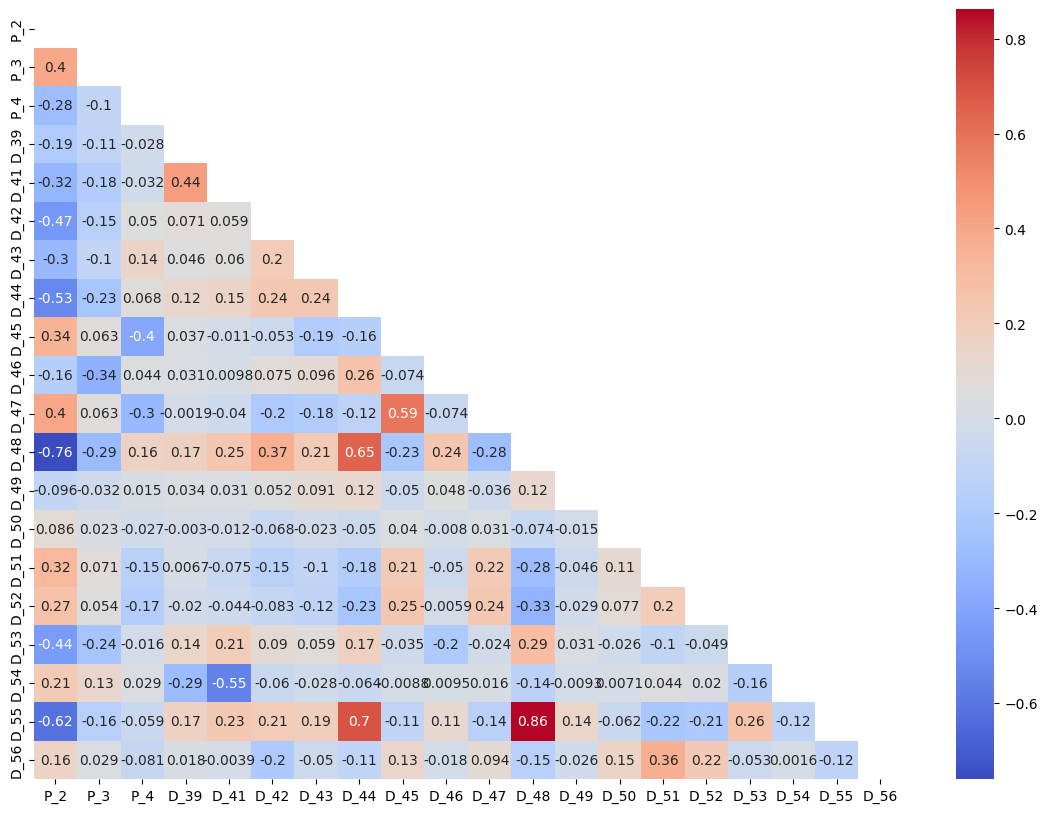

In [80]:
plt.figure(figsize=(14, 10))

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr.iloc[:20, :20], annot=True, mask=matrix[:20, :20], cmap='coolwarm')